# Итоговый проект (ML-специализация)  
**Курс: Введение в Data Science**  
**Компания-партнёр: «СберАвтоподписка»**

## Постановка задачи
«СберАвтоподписка» — сервис долгосрочной аренды автомобилей.  
На сайте пользователи совершают разные действия: от просмотра страниц до целевых действий — например, *оставить заявку* или *заказать звонок*.  

**Наша цель** — построить модель, которая будет предсказывать, совершит ли пользователь **целевое действие** в рамках визита.  

**Ключевые требования:**
- Использовать предоставленные данные (Google Analytics, модель атрибуции last-click).
- Достичь ROC-AUC ≈ 0.65 на тестовой выборке.
- Упаковать модель в сервис (API), который на вход принимает признаки визита, а на выход возвращает вероятность и класс (0/1).  

## Описание данных

Исходные данные получены из **Google Analytics** (модель атрибуции — *last-click*) для сайта сервиса «СберАвтоподписка».

### 1. GA Sessions (`ga_sessions.csv` / `ga_sessions.pkl`)
**Уровень данных:** один визит на сайт.  
**Одна строка = один визит.**

**Атрибуты:**
- `session_id` — ID визита  
- `client_id` — ID посетителя  
- `visit_date` — дата визита  
- `visit_time` — время визита  
- `visit_number` — порядковый номер визита клиента  
- `utm_source` — канал привлечения  
- `utm_medium` — тип привлечения  
- `utm_campaign` — рекламная кампания  
- `utm_keyword` — ключевое слово  
- `device_category` — тип устройства  
- `device_os` — операционная система устройства  
- `device_brand` — марка устройства  
- `device_model` — модель устройства  
- `device_screen_resolution` — разрешение экрана  
- `device_browser` — браузер  
- `geo_country` — страна  
- `geo_city` — город  

### 2. GA Hits (`ga_hits.csv` / `ga_hits.pkl`)
**Уровень данных:** одно событие внутри визита.  
**Одна строка = одно событие.**

**Атрибуты:**
- `session_id` — ID визита (связь с таблицей `ga_sessions`)  
- `hit_date` — дата события  
- `hit_time` — время события  
- `hit_number` — порядковый номер события в рамках сессии  
- `hit_type` — тип события  
- `hit_referer` — источник события  
- `hit_page_path` — страница, на которой произошло событие  
- `event_category` — категория действия  
- `event_action` — действие (тип события)  
- `event_label` — тег действия  
- `event_value` — значение результата действия  

### Итоговая структура
- **Основные признаки** для моделирования берём из `ga_sessions`.  
- **Целевая переменная (`target`)** формируется из `ga_hits`:
  - если в рамках `session_id` встречается хотя бы одно целевое действие, метка = 1;  
  - иначе = 0.  

## План работы
1. **EDA и подготовка данных**:  
   - чистка (NaN, дубликаты, типизация, ненужные атрибуты);  
   - формирование таргета;  
   - визуализация распределений и корреляций.  

2. **Feature Engineering**:  
   - временные признаки (час, день недели, выходной/будний);  
   - гео-флаги (Москва/СПб, Россия/не Россия);  
   - маркетинговые (органика/платный/соцсети);  
   - поведенческие (номер визита, кол-во событий в сессии);  
   - взаимодействия категорий.  

3. **Моделирование**:  
   - бейзлайн (Logistic Regression);  
   - CatBoost / LightGBM (Optuna для тюнинга);  
   - ансамбль моделей (Voting);  
   - оценка качества (ROC-AUC, PR-AUC, F1).  

4. **Интерпретация**:  
   - Feature importance;  
   - SHAP, PDP/ICE;  
   - бизнес-выводы.  

5. **Стабильность и качество**:  
   - временные срезы (псевдо-мониторинг);  
   - отчёт Evidently (Data Drift / Target Drift / Performance).  

6. **Деплой**:  
   - FastAPI (API, принимает признаки визита и возвращает прогноз);  
   - Streamlit (демо-интерфейс для пользователя);  
   - Docker (упаковка).  

7. **Опционально**: оркестратор (Prefect/Airflow) для воспроизводимого пайплайна.  

## Критерии успеха
- ROC-AUC ≥ 0.65 на тестовой выборке.  
- Корректная обработка данных и визуализации (EDA).  
- Проработанный feature engineering.  
- Интерпретация (SHAP, PDP) с бизнес-выводами.  
- Реализация API (FastAPI + Docker), отклик < 3 секунд.  
- (Опц.) мониторинг стабильности через Evidently и оркестратор пайплайна. 

## Блок импортов

In [1]:
# окружение: lightautoml_env

import catboost as cb
import glob
import joblib
import json
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
import optuna
import os
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
sns.set(style="whitegrid")
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier, Pool
from IPython.display import display
pd.options.display.max_columns = None
from joblib import load, dump

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from pathlib import Path
from scipy.stats import chi2_contingency, ks_2samp
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
SEED = 42

# Базовый путь проекта
ROOT_PATH = Path(r"D:\ML\LS\final\final_project")

os.makedirs(r"D:\ML\LS\final\final_project\data\raw", exist_ok=True)
os.makedirs(r"D:\ML\LS\final\final_project\data\processed", exist_ok=True)

DATA_RAW = ROOT_PATH / "data" / "raw"
DATA_PROCESSED = ROOT_PATH / "data" / "processed"

# Создаём директории
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Файлы
SESSIONS_FILE = DATA_RAW / "ga_sessions.csv"
HITS_FILE = DATA_RAW / "ga_hits.csv"

ART_DIR = ROOT_PATH / "artifacts"
EVAL_DIR = ART_DIR / "eval"
SPLIT_DIR = ART_DIR / "split"
PREP_DIR  = ART_DIR / "prep"
MODEL_DIR = ART_DIR / "models"
for d in [SPLIT_DIR, PREP_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)
METRICS_PATH = EVAL_DIR / "metrics.json"

INF_DIR   = ART_DIR / "inference"
INF_DIR.mkdir(parents=True, exist_ok=True)

## Загрузка файлов

In [20]:
# Чтение с явными dtypes
sessions_dtypes = {
    "session_id": "string",
    "client_id": "string",
    "visit_time": "string",  # HH:MM:SS
    "utm_source": "string",
    "utm_medium": "string",
    "utm_campaign": "string",
    "utm_adcontent": "string",
    "utm_keyword": "string",
    "device_category": "string",
    "device_os": "string",
    "device_brand": "string",
    "device_model": "string",
    "device_screen_resolution": "string",
    "device_browser": "string",
    "geo_country": "string",
    "geo_city": "string",
}

hits_dtypes = {
    "session_id": "string",
    "hit_time": "float64",    
    "hit_number": "float64",
    "hit_type": "string",
    "hit_referer": "string",
    "hit_page_path": "string",
    "event_category": "string",
    "event_action": "string",
    "event_label": "string",
    "event_value": "float64",
}

ga_sessions = pd.read_csv(
    SESSIONS_FILE,
    dtype=sessions_dtypes,
    parse_dates=["visit_date"],
    low_memory=False
)
ga_hits = pd.read_csv(
    HITS_FILE,
    dtype=hits_dtypes,
    parse_dates=["hit_date"],
    low_memory=False
)

In [21]:
display(ga_sessions)

session_id              client_id  \
0        9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1         905544597018549464.1636867290.1636867290   210838531.1636867288   
2        9055446045651783499.1640648526.1640648526  2108385331.1640648523   
3        9055447046360770272.1622255328.1622255328  2108385564.1622255328   
4        9055447046360770272.1622255345.1622255345  2108385564.1622255328   
...                                            ...                    ...   
1860037  9055415581448263752.1640159305.1640159305  2108378238.1640159304   
1860038  9055421130527858185.1622007305.1622007305  2108379530.1622007305   
1860039  9055422955903931195.1636979515.1636979515  2108379955.1636979515   
1860040   905543020766873816.1638189404.1638189404   210838164.1638189272   
1860041  9055430416266113553.1640968742.1640968742  2108381692.1640968721   

        visit_date visit_time  visit_number            utm_source utm_medium  \
0       2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1       2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2       2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3       2021-05-29   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4       2021-05-29   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   
...            ...        ...           ...                   ...        ...   
1860037 2021-12-22   10:48:25             1  BHcvLfOaCWvWTykYqHVe        cpc   
1860038 2021-05-26   08:00:00             1  fDLlAcSmythWSCVMvqvL     (none)   
1860039 2021-11-15   15:31:55             1  fDLlAcSmythWSCVMvqvL     (none)   
1860040 2021-11-29   15:36:44             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1860041 2021-12-31   19:39:02             1  fgymSoTvjKPEgaIJqsiH        cpm   

                 utm_campaign         utm_adcontent           utm_keyword  \
0        LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1        FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2        LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
3                        <NA>  NOBKLgtuvqYWkXQHeYWM                  <NA>   
4                        <NA>                  <NA>                  <NA>   
...                       ...                   ...                   ...   
1860037                  <NA>                  <NA>  VlqBmecIOXWjCWUmQkLd   
1860038  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf                  <NA>   
1860039  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo   
1860040  LEoPHuyFvzoNfnzGgfcd  JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo   
1860041  FTjNLDyTrXaWYgZymFkV  yYdBRbPmBMUZHXwqGxNx  oKjXDUsycmahkgMhGdAR   

        device_category device_os device_brand device_model  \
0                mobile   Android       Huawei         <NA>   
1                mobile   Android      Samsung         <NA>   
2                mobile   Android       Huawei         <NA>   
3                mobile      <NA>       Xiaomi         <NA>   
4                mobile      <NA>       Xiaomi         <NA>   
...                 ...       ...          ...          ...   
1860037         desktop   Windows         <NA>         <NA>   
1860038          mobile      <NA>        Apple         <NA>   
1860039          mobile       iOS        Apple         <NA>   
1860040          mobile   Android       Xiaomi         <NA>   
1860041         desktop     Linux         <NA>         <NA>   

        device_screen_resolution    device_browser geo_country     geo_city  
0                        360x720            Chrome      Russia     Zlatoust  
1                        385x854  Samsung Internet      Russia       Moscow  
2                        360x720            Chrome      Russia  Krasnoyarsk  
3                        393x786            Chrome      Russia       Moscow  
4                        393x786            Chrome      Russia       Moscow  
... 

In [22]:
ga_sessions.describe(include='all')

session_id              client_id  \
count                                     1860042                1860042   
unique                                    1860042                1391719   
top     9055434745589932991.1637753792.1637753792  1750498477.1629450062   
freq                                            1                    462   
mean                                          NaN                    NaN   
min                                           NaN                    NaN   
25%                                           NaN                    NaN   
50%                                           NaN                    NaN   
75%                                           NaN                    NaN   
max                                           NaN                    NaN   
std                                           NaN                    NaN   

                           visit_date visit_time  visit_number  \
count                         1860042    1860042  1.860042e+06   
unique                            NaN      85318           NaN   
top                               NaN   12:00:00           NaN   
freq                              NaN      61067           NaN   
mean    2021-09-26 11:45:55.389394176        NaN  2.712804e+00   
min               2021-05-19 00:00:00        NaN  1.000000e+00   
25%               2021-08-02 00:00:00        NaN  1.000000e+00   
50%               2021-10-06 00:00:00        NaN  1.000000e+00   
75%               2021-11-23 00:00:00        NaN  2.000000e+00   
max               2021-12-31 00:00:00        NaN  5.640000e+02   
std                               NaN        NaN  1.182907e+01   

                  utm_source utm_medium          utm_campaign  \
count                1859945    1860042               1640439   
unique                   293         56                   412   
top     ZpYIoDJMcFzVoPFsHGJL     banner  LTuZkdKfxRGVceoWkVyg   
freq                  578290     552272                463481   
mean                     NaN        NaN                   NaN   
min                      NaN        NaN                   NaN   
25%                      NaN        NaN                   NaN   
50%                      NaN        NaN                   NaN   
75%                      NaN        NaN                   NaN   
max                      NaN        NaN                   NaN   
std                      NaN        NaN                   NaN   

               utm_adcontent           utm_keyword device_category device_os  \
count                1524427                777981         1860042    789904   
unique                   286                  1219               3        13   
top     JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo          mobile   Android   
freq                 1006599                506819         1474871    464054   
mean                     NaN                   NaN             NaN       NaN   
min                      NaN                   NaN             NaN       NaN   
25%                      NaN                   NaN             NaN       NaN   
50%                      NaN                   NaN             NaN       NaN   
75%                      NaN                   NaN             NaN       NaN   
max                      NaN                   NaN             NaN       NaN   
std                      NaN                   NaN             NaN       NaN   

       device_brand          device_model device_screen_resolution  \
count       1492864                 16338                  1860042   
unique          205                   104                     5039   
top           Apple  AuMdmADEIoPXiWpTsBEj                  414x896   
freq         551088                  9778                   169090   
mean            NaN                   NaN                      NaN   
min             NaN                   NaN                      NaN   
25%             NaN                   NaN                      NaN   
50%             NaN            

In [23]:
for col in ga_sessions.columns.to_list():
    print(ga_sessions[col].value_counts())

session_id
9055434745589932991.1637753792.1637753792    1
9055852379613041733.1630934090.1630934090    1
9055455318486370642.1640843788.1640843788    1
9055461992850812764.1626107740.1626107740    1
9055462349345527315.1638536723.1638536723    1
                                            ..
905543020766873816.1638189404.1638189404     1
9055376699099939975.1630766214.1630766214    1
9055325765080617126.1628606631.1628606631    1
905531763656523476.1637121749.1637121749     1
9055430416266113553.1640968742.1640968742    1
Name: count, Length: 1860042, dtype: Int64
client_id
1750498477.1629450062    462
130918396.1628014141     334
1266574870.1623140118    309
736859557.1619557452     306
1894772482.1621860860    276
                        ... 
1669666566.1640091046      1
1669631083.1638691292      1
16696301.1624986708        1
1669570240.1634640467      1
2108381692.1640968721      1
Name: count, Length: 1391719, dtype: Int64
visit_date
2021-05-24    39453
2021-12-21    30704
2021-0

In [24]:
display(ga_hits)

session_id   hit_date   hit_time  \
0         5639623078712724064.1640254056.1640254056 2021-12-23   597864.0   
1         7750352294969115059.1640271109.1640271109 2021-12-23   597331.0   
2          885342191847998240.1640235807.1640235807 2021-12-23   796252.0   
3          142526202120934167.1640211014.1640211014 2021-12-23   934292.0   
4         3450086108837475701.1640265078.1640265078 2021-12-23   768741.0   
...                                             ...        ...        ...   
15726465  6866159858916559617.1640270865.1640270865 2021-12-23   810589.0   
15726466  7310304587364460692.1640261783.1640261783 2021-12-23   904927.0   
15726467  8013702685784312179.1640270195.1640270195 2021-12-23  2172865.0   
15726468  8021505554734405918.1640257821.1640257821 2021-12-23   713325.0   
15726469  1569014437485249865.1640269129.1640269129 2021-12-23   742820.0   

          hit_number hit_type hit_referer  \
0               30.0    event        <NA>   
1               41.0    event        <NA>   
2               49.0    event        <NA>   
3               46.0    event        <NA>   
4               79.0    event        <NA>   
...              ...      ...         ...   
15726465        43.0    event        <NA>   
15726466        40.0    event        <NA>   
15726467        43.0    event        <NA>   
15726468        45.0    event        <NA>   
15726469        46.0    event        <NA>   

                                              hit_page_path event_category  \
0         sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1         sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2         sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3         sberauto.com/cars?utm_source_initial=yandex&ut...           quiz   
4         sberauto.com/cars/all/mercedes-benz/cla-klasse...           quiz   
...                                                     ...            ...   
15726465  sberauto.com/cars/all/toyota/fortuner/24cb5af2...           quiz   
15726466  sberauto.com/cars/all/mercedes-benz/gla-klasse...           quiz   
15726467  sberauto.com/cars/all/toyota/alphard/2ebe4871?...           quiz   
15726468  sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...           quiz   
15726469  sberauto.com/cars/all/bmw/7-serii/399ac530?utm...           quiz   

         event_action event_label  event_value  
0           quiz_show        <NA>          NaN  
1           quiz_show        <NA>          NaN  
2           quiz_show        <NA>          NaN  
3           quiz_show        <NA>          NaN  
4           quiz_show        <NA>          NaN  
...               ...         ...          ...  
15726465    quiz_show        <NA>          NaN  
15726466    quiz_show        <NA>          NaN  
15726467    quiz_show        <NA>          NaN  
15726468    quiz_show        <NA>          NaN  
15726469    quiz_show        <NA>          NaN  

[15726470 rows x 11 columns]

In [25]:
ga_hits.describe(include='all')

session_id  \
count                                    15726470   
unique                                    1734610   
top     5442565791571325612.1632449195.1632449195   
freq                                          768   
mean                                          NaN   
min                                           NaN   
25%                                           NaN   
50%                                           NaN   
75%                                           NaN   
max                                           NaN   
std                                           NaN   

                             hit_date      hit_time    hit_number  hit_type  \
count                        15726470  6.566148e+06  1.572647e+07  15726470   
unique                            NaN           NaN           NaN         1   
top                               NaN           NaN           NaN     event   
freq                              NaN           NaN           NaN  15726470   
mean    2021-09-22 23:21:46.111746304  2.091050e+05  2.356715e+01       NaN   
min               2021-05-19 00:00:00  0.000000e+00  1.000000e+00       NaN   
25%               2021-07-25 00:00:00  2.412000e+04  7.000000e+00       NaN   
50%               2021-10-03 00:00:00  8.994100e+04  1.500000e+01       NaN   
75%               2021-11-22 00:00:00  2.195352e+05  2.900000e+01       NaN   
max               2021-12-31 00:00:00  1.315688e+07  5.000000e+02       NaN   
std                               NaN  4.032110e+05  2.887713e+01       NaN   

                 hit_referer           hit_page_path event_category  \
count                9451666                15726470       15726470   
unique                 37873                  342715             52   
top     HbolMJUevblAbkHClEQa  podpiska.sberauto.com/       card_web   
freq                 8879187                 2793639        7456998   
mean                     NaN                     NaN            NaN   
min                      NaN                     NaN            NaN   
25%                      NaN                     NaN            NaN   
50%                      NaN                     NaN            NaN   
75%                      NaN                     NaN            NaN   
max                      NaN                     NaN            NaN   
std                      NaN                     NaN            NaN   

       event_action           event_label  event_value  
count      15726470              11966286          0.0  
unique          230                 39825          NaN  
top       view_card  KclpemfoHstknWHFiLit          NaN  
freq        3558985               6505447          NaN  
mean            NaN                   NaN          NaN  
min             NaN                   NaN          NaN  
25%             NaN                   NaN          NaN  
50%             NaN                   NaN          NaN  
75%             NaN                   NaN          NaN  
max             NaN                   NaN          NaN  
std             NaN                   NaN          NaN

In [26]:
for col in ga_hits.columns.to_list():
    print(ga_hits[col].value_counts())

session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
160826705592749328.1631620368.1631620368       1
1855401207506421650.1631602579.1631602579      1
1481604624575304990.1633883424.1633883424      1
3751290052173382050.1631601058.1631601058      1
5381267721977892188.1640271196.1640271196      1
Name: count, Length: 1734610, dtype: Int64
hit_date
2021-05-24    513035
2021-12-21    280192
2021-05-25    235805
2021-09-23    168899
2021-05-26    158382
               ...  
2021-07-24     23490
2021-05-23     18773
2021-05-19     14605
2021-05-22     13917
2021-05-21     13497
Name: count, Length: 226, dtype: int64
hit_time
0.0          41137
1.0          18522
2.0          10101
3.0           6060
4.0           4478
             ...  
54406

In [19]:
print('ga_sessions shape -', ga_sessions.shape, '\nga_hits shape -', ga_hits.shape)

ga_sessions shape - (1860042, 18) 
ga_hits shape - (15726470, 11)


## Парсинг информации об авто из hit_page_path

In [30]:
# Гарантируем строковый тип и убираем query-строку (?...)
paths_noq = (
    ga_hits["hit_page_path"]
    .astype("string")
    .str.split("?", n=1, expand=True)[0]
    .str.lower()
)

# Паттерн: /cars/(all/)?<brand>/<model>/(<id>)?
pat_main = r"/cars/(?:all/)?(?P<brand>[a-z0-9\-]+)/(?P<model>[a-z0-9\-]+)(?:/[a-z0-9\-]+)?"
extracted = paths_noq.str.extract(pat_main)

# Фолбэк: только бренд (/cars/(all/)?<brand>/)
pat_brand_only = r"/cars/(?:all/)?(?P<brand_only>[a-z0-9\-]+)/?$"
extracted_brand_only = paths_noq.str.extract(pat_brand_only)

# Объединяем результаты
brand = extracted["brand"].fillna(extracted_brand_only["brand_only"])
model = extracted["model"]

# Функция очистки токенов
def _clean_token(s):
    if pd.isna(s):
        return pd.NA
    s = re.sub(r"[^a-z0-9\-]", "", s)   # оставляем только латиницу, цифры и "-"
    s = re.sub(r"-{2,}", "-", s)        # схлопываем двойные дефисы
    s = s.strip("-")                    # обрезаем дефисы с краёв
    return s if s else pd.NA

brand = brand.map(_clean_token).astype("string")
model = model.map(_clean_token).astype("string")

# Собираем фрейм сессия → авто
cars_parsed = pd.DataFrame({
    "session_id": ga_hits["session_id"].astype("string"),
    "car_brand": brand,
    "car_model": model,
})

# Агрегация на уровень session_id
def _mode_or_na(x: pd.Series):
    """Берём наиболее частое значение или NA"""
    x = x.dropna()
    if x.empty:
        return pd.NA
    m = x.mode()
    return m.iloc[0] if not m.empty else pd.NA

cars_by_session = (
    cars_parsed.groupby("session_id", as_index=False)
    .agg(
        car_brand=("car_brand", _mode_or_na),
        car_model=("car_model", _mode_or_na),
        n_brands=("car_brand", lambda s: s.dropna().nunique()),
        n_models=("car_model", lambda s: s.dropna().nunique()),
        any_car_detail=("car_model", lambda s: int(s.notna().any())),
    )
)

# Быстрый sanity-check
print(cars_by_session.head(10))
print("Parsed sessions:", len(cars_by_session))
print("Non-null brands:", cars_by_session["car_brand"].notna().sum())
print("Non-null models:", cars_by_session["car_model"].notna().sum())

                                  session_id car_brand car_model  n_brands  \
0  1000009318903347362.1632663668.1632663668  2fc745ed      <NA>         1   
1  1000010177899156286.1635013443.1635013443      <NA>      <NA>         0   
2  1000013386240115915.1635402956.1635402956  lada-vaz     vesta         1   
3  1000017303238376207.1623489300.1623489300  94b3d18e      <NA>         1   
4  1000020580299877109.1624943350.1624943350  b82590a3      <NA>         1   
5  1000020580299877109.1624980453.1624980453  b82590a3      <NA>         1   
6  1000027718532820202.1622240490.1622240490      <NA>      <NA>         0   
7  1000027718532820202.1622291029.1622291029      <NA>      <NA>         0   
8  1000029462306488440.1639193822.1639193822      <NA>      <NA>         0   
9  1000032679231606737.1633800147.1633800147      <NA>      <NA>         0   

   n_models  any_car_detail  
0         0               0  
1         0               0  
2         1               1  
3         0          

# Фича-инженеринг для финального датасета

In [33]:
# Преобразование временных признаков в sessions
def parse_visit_datetime(row):
    try:
        if pd.isna(row["visit_date"]) or pd.isna(row["visit_time"]):
            return pd.NaT
        return pd.to_datetime(f'{row["visit_date"].date()} {row["visit_time"]}')
    except Exception:
        return pd.NaT

ga_sessions["visit_datetime"] = ga_sessions[["visit_date", "visit_time"]].apply(parse_visit_datetime, axis=1)
ga_sessions["visit_hour"] = ga_sessions["visit_datetime"].dt.hour.astype("Int32")
ga_sessions["visit_dow"] = ga_sessions["visit_datetime"].dt.dayofweek.astype("Int32")
ga_sessions["is_weekend"] = ga_sessions["visit_dow"].isin([5, 6]).astype("int8")

# Нормализация hit_time и hit_datetime
DAY_SECS = 24 * 3600
ga_hits["hit_time"] = ga_hits["hit_time"].round().astype("Int64")
ga_hits["hit_number"] = ga_hits["hit_number"].round().astype("Int64")

ga_hits["hit_day_offset"] = (ga_hits["hit_time"] // DAY_SECS).astype("Int64")
ga_hits["hit_sec_in_day"] = (ga_hits["hit_time"] % DAY_SECS).astype("Int64")

ga_hits["hit_datetime"] = (
    ga_hits["hit_date"]
    + pd.to_timedelta(ga_hits["hit_day_offset"].fillna(0).astype(int), unit="D")
    + pd.to_timedelta(ga_hits["hit_sec_in_day"].fillna(0).astype(int), unit="s")
)
ga_hits["hit_hour"] = ga_hits["hit_datetime"].dt.hour.astype("Int32")
ga_hits["hit_dow"] = ga_hits["hit_datetime"].dt.dayofweek.astype("Int32")
ga_hits["is_weekend_hit"] = ga_hits["hit_dow"].isin([5, 6]).astype("int8")

# Целевые события
TARGET_ACTIONS = {
    "sub_car_claim_click",
    "sub_car_claim_submit_click",
    "sub_open_dialog_click",
    "sub_custom_question_submit_click",
    "sub_call_number_click",
    "sub_callback_submit_click",
    "sub_submit_success",
    "sub_car_request_submit_click",
}
target_by_session = (
    ga_hits.assign(target=lambda df: df["event_action"].isin(TARGET_ACTIONS).astype(int))
           .groupby("session_id", as_index=False)["target"]
           .max()
)

# Дедупликация сессий
ga_sessions = ga_sessions.drop_duplicates(subset=["session_id"], keep="last")
assert ga_sessions["session_id"].is_unique

# Агрегаты по событиям
events_agg = (
    ga_hits.groupby("session_id")
           .agg(
               events_in_session=("event_action", "count"),
               unique_event_types=("event_action", "nunique")
           )
           .reset_index()
)

# Фичи по автомобилям (cars_by_session из предыдущего блока) 
# cars_by_session уже собран → session_id + car_brand, car_model, n_brands, n_models, any_car_detail

# Фичи по трафику
# Органический/платный
ga_sessions["is_organic"] = ga_sessions["utm_medium"].isin(["organic", "referral", "(none)"]).astype(int)
ga_sessions["is_paid"] = 1 - ga_sessions["is_organic"]

# Группировка по каналам
def group_medium(m):
    if m in ["organic", "referral", "(none)"]:
        return "organic"
    elif m in ["cpc", "cpm", "cpv", "cpa"]:
        return "performance"
    elif m in ["smm", "fb_smm", "vk_smm", "ok_smm", "tg", 
               "stories", "blogger_channel", "blogger_stories", "blogger_header", "social"]:
        return "social"
    elif m == "email":
        return "email"
    elif m == "push":
        return "push"
    elif m == "sms":
        return "sms"
    elif m == "banner":
        return "banner"
    else:
        return "other"

ga_sessions["traffic_group"] = ga_sessions["utm_medium"].map(group_medium)

# Бинарные индикаторы
ga_sessions["is_social"] = (ga_sessions["traffic_group"] == "social").astype(int)
ga_sessions["is_email"] = (ga_sessions["traffic_group"] == "email").astype(int)
ga_sessions["is_push"]  = (ga_sessions["traffic_group"] == "push").astype(int)
ga_sessions["is_sms"]   = (ga_sessions["traffic_group"] == "sms").astype(int)
ga_sessions["is_perf"]  = (ga_sessions["traffic_group"] == "performance").astype(int)

# Объединение всех фичей
df = (
    ga_sessions
    .merge(target_by_session, on="session_id", how="left")
    .merge(events_agg, on="session_id", how="left")
    .merge(cars_by_session, on="session_id", how="left")
)

df["target"] = df["target"].fillna(0).astype("int8")
df[["events_in_session", "unique_event_types"]] = (
    df[["events_in_session", "unique_event_types"]].fillna(0).astype("Int64")
)

# Проверки
print("Final df shape:", df.shape)
print("Target rate:", df["target"].mean().round(4))
print("NaNs per column (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Сохранение
OUT_FILE = DATA_PROCESSED / "sessions_final.parquet"
df.to_parquet(OUT_FILE, engine="pyarrow", index=False)
print(f"Saved: {OUT_FILE}")

Final df shape: (1860042, 38)
Target rate: 0.027
NaNs per column (top 10):
device_model      1843704
car_model         1561829
car_brand         1175295
utm_keyword       1082061
device_os         1070138
device_brand       367178
utm_adcontent      335615
utm_campaign       219603
any_car_detail     127776
n_brands           127776
dtype: int64
Saved: D:\ML\LS\final\final_project\data\processed\sessions_final.parquet


In [35]:
df.head(10)

session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1   905544597018549464.1636867290.1636867290   210838531.1636867288   
2  9055446045651783499.1640648526.1640648526  2108385331.1640648523   
3  9055447046360770272.1622255328.1622255328  2108385564.1622255328   
4  9055447046360770272.1622255345.1622255345  2108385564.1622255328   
5  9055447192389856083.1622453074.1622453074  2108385598.1622453075   
6  9055455318486370642.1640843788.1640843788  2108387490.1640843602   
7  9055461992850812764.1626107740.1626107740  2108389044.1626107740   
8  9055462349345527315.1638536723.1638536723  2108389127.1638536723   
9  9055466554104774132.1624800757.1624800757  2108390106.1624800756   

  visit_date visit_time  visit_number            utm_source utm_medium  \
0 2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1 2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2 2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3 2021-05-29   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4 2021-05-29   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   
5 2021-05-31   12:00:00             1  kjsLglQLzykiRbcDiGcD    organic   
6 2021-12-30   08:56:28             1  TxKUcPpthBDPieTGmVhx        cpc   
7 2021-07-12   19:00:00             1  ZpYIoDJMcFzVoPFsHGJL     banner   
8 2021-12-03   16:05:23             1  ZpYIoDJMcFzVoPFsHGJL     banner   
9 2021-06-27   16:00:00             1  ZpYIoDJMcFzVoPFsHGJL     banner   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
3                  <NA>  NOBKLgtuvqYWkXQHeYWM                  <NA>   
4                  <NA>                  <NA>                  <NA>   
5  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf                  <NA>   
6  FTjNLDyTrXaWYgZymFkV  LcGIUNPUAmXtQJaDfFBR  PwscUHjoUJDrtfWESIHj   
7  LEoPHuyFvzoNfnzGgfcd  JNHcPlZPxEMWDnRiyoBf                  <NA>   
8  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
9  LEoPHuyFvzoNfnzGgfcd  JNHcPlZPxEMWDnRiyoBf                  <NA>   

  device_category device_os device_brand device_model  \
0          mobile   Android       Huawei         <NA>   
1          mobile   Android      Samsung         <NA>   
2          mobile   Android       Huawei         <NA>   
3          mobile      <NA>       Xiaomi         <NA>   
4          mobile      <NA>       Xiaomi         <NA>   
5          mobile      <NA>        Apple         <NA>   
6          tablet   Android       Lenovo         <NA>   
7          mobile      <NA>      Samsung         <NA>   
8          mobile       iOS        Apple         <NA>   
9          mobile      <NA>      Samsung         <NA>   

  device_screen_resolution    device_browser geo_country          geo_city  \
0                  360x720            Chrome      Russia          Zlatoust   
1                  385x854  Samsung Internet      Russia            Moscow   
2                  360x720            Chrome      Russia       Krasnoyarsk   
3                  393x786            Chrome      Russia            Moscow   
4                  393x786            Chrome      Russia            Moscow   
5                  375x812            Safari      Russia  Saint Petersburg   
6                 602x1029         YaBrowser      Russia  Saint Petersburg   
7                  360x640            Chrome      Russia  Saint Petersburg   
8                  390x844            Safari      Russia            Moscow   
9                  412x915            Chrome      Russia            Moscow   

       visit_datetime  visit_hour  visit_dow  is_weekend  is_organic  is_paid  \
0 2021-11-24 14:36:32          14          2           0           0        1   
1 2021

In [36]:
df.describe(include='all')

session_id              client_id  \
count                                     1860042                1860042   
unique                                    1860042                1391719   
top     9055434745589932991.1637753792.1637753792  1750498477.1629450062   
freq                                            1                    462   
mean                                          NaN                    NaN   
min                                           NaN                    NaN   
25%                                           NaN                    NaN   
50%                                           NaN                    NaN   
75%                                           NaN                    NaN   
max                                           NaN                    NaN   
std                                           NaN                    NaN   

                           visit_date visit_time  visit_number  \
count                         1860042    1860042  1.860042e+06   
unique                            NaN      85318           NaN   
top                               NaN   12:00:00           NaN   
freq                              NaN      61067           NaN   
mean    2021-09-26 11:45:55.389394176        NaN  2.712804e+00   
min               2021-05-19 00:00:00        NaN  1.000000e+00   
25%               2021-08-02 00:00:00        NaN  1.000000e+00   
50%               2021-10-06 00:00:00        NaN  1.000000e+00   
75%               2021-11-23 00:00:00        NaN  2.000000e+00   
max               2021-12-31 00:00:00        NaN  5.640000e+02   
std                               NaN        NaN  1.182907e+01   

                  utm_source utm_medium          utm_campaign  \
count                1859945    1860042               1640439   
unique                   293         56                   412   
top     ZpYIoDJMcFzVoPFsHGJL     banner  LTuZkdKfxRGVceoWkVyg   
freq                  578290     552272                463481   
mean                     NaN        NaN                   NaN   
min                      NaN        NaN                   NaN   
25%                      NaN        NaN                   NaN   
50%                      NaN        NaN                   NaN   
75%                      NaN        NaN                   NaN   
max                      NaN        NaN                   NaN   
std                      NaN        NaN                   NaN   

               utm_adcontent           utm_keyword device_category device_os  \
count                1524427                777981         1860042    789904   
unique                   286                  1219               3        13   
top     JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo          mobile   Android   
freq                 1006599                506819         1474871    464054   
mean                     NaN                   NaN             NaN       NaN   
min                      NaN                   NaN             NaN       NaN   
25%                      NaN                   NaN             NaN       NaN   
50%                      NaN                   NaN             NaN       NaN   
75%                      NaN                   NaN             NaN       NaN   
max                      NaN                   NaN             NaN       NaN   
std                      NaN                   NaN             NaN       NaN   

       device_brand          device_model device_screen_resolution  \
count       1492864                 16338                  1860042   
unique          205                   104                     5039   
top           Apple  AuMdmADEIoPXiWpTsBEj                  414x896   
freq         551088                  9778                   169090   
mean            NaN                   NaN                      NaN   
min             NaN                   NaN                      NaN   
25%             NaN                   NaN                      NaN   
50%             NaN            

In [38]:
for col in df.columns.to_list():
    print(df[col].value_counts())

session_id
9055434745589932991.1637753792.1637753792    1
9055852379613041733.1630934090.1630934090    1
9055455318486370642.1640843788.1640843788    1
9055461992850812764.1626107740.1626107740    1
9055462349345527315.1638536723.1638536723    1
                                            ..
905543020766873816.1638189404.1638189404     1
9055376699099939975.1630766214.1630766214    1
9055325765080617126.1628606631.1628606631    1
905531763656523476.1637121749.1637121749     1
9055430416266113553.1640968742.1640968742    1
Name: count, Length: 1860042, dtype: Int64
client_id
1750498477.1629450062    462
130918396.1628014141     334
1266574870.1623140118    309
736859557.1619557452     306
1894772482.1621860860    276
                        ... 
1669666566.1640091046      1
1669631083.1638691292      1
16696301.1624986708        1
1669570240.1634640467      1
2108381692.1640968721      1
Name: count, Length: 1391719, dtype: Int64
visit_date
2021-05-24    39453
2021-12-21    30704
2021-0

## Ещё дополнительные признаки

In [46]:
# GEO

# (not set) → other_city сразу
df["geo_city"] = df["geo_city"].replace("(not set)", "other_city")

# Топ-10 стран
top_countries = df["geo_country"].value_counts().head(10).index
df["geo_country"] = df["geo_country"].where(df["geo_country"].isin(top_countries), "other_country")

# Топ-10 городов
top_cities = df["geo_city"].value_counts().head(10).index
df["geo_city"] = df["geo_city"].where(df["geo_city"].isin(top_cities), "other_city")

# Фича: крупный город (Москва, СПб и ещё несколько)
big_cities = {"Moscow", "Saint Petersburg", "Novosibirsk", "Yekaterinburg", "Kazan"}
df["is_big_city"] = df["geo_city"].isin(big_cities).astype("int8")

# AUTO

def clean_car_value(x):
    """Чистим бренд/модель: убираем NaN и значения с цифрами"""
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().lower()
    if re.search(r"\d", s):  # если есть цифра → заменить
        return pd.NA
    return s

df["car_brand"] = df["car_brand"].apply(clean_car_value)
df["car_model"] = df["car_model"].apply(clean_car_value)

# Топ-10 брендов
top_brands = df["car_brand"].value_counts().head(10).index
df["car_brand"] = df["car_brand"].where(df["car_brand"].isin(top_brands), "other_brand")

# Популярные модели (частота >=100)
popular_models = df["car_model"].value_counts()[lambda x: x >= 100].index
df["car_model"] = df["car_model"].where(df["car_model"].isin(popular_models), "other_model")

# Комбинированная фича: бренд+модель
df["brand_model"] = df["car_brand"].fillna("none") + "_" + df["car_model"].fillna("none")

# is_top_brand
df["is_top_brand"] = df["car_brand"].isin(top_brands).astype("int8")

# has_model (1 если модель указана, 0 если other/NA)
df["has_model"] = (~df["car_model"].isna() & (df["car_model"] != "other_model")).astype("int8")

# DROP ненужных

drop_cols = [
    "client_id", "visit_date", "visit_time",
    "utm_source", "utm_campaign", "utm_adcontent", "utm_keyword",
    "device_os", "device_brand", "device_model",
    "device_screen_resolution", "device_browser"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# CHECKS
print("Final shape:", df.shape)
print("Geo countries:", df["geo_country"].unique()[:15])
print("Geo cities:", df["geo_city"].unique()[:15])
print("Brands:", df["car_brand"].unique()[:15])
print("Models:", df["car_model"].unique()[:15])
print("Columns:", df.columns.tolist()[:30], "...")

Final shape: (1860042, 30)
Geo countries: <StringArray>
[       'Russia', 'United States',       'Ukraine', 'other_country',
       'Belarus',        'Sweden',    'Kazakhstan',       'Ireland',
       'Germany',   'Netherlands',        'Turkey']
Length: 11, dtype: string
Geo cities: <StringArray>
[      'other_city',           'Moscow', 'Saint Petersburg',
            'Kazan',    'Yekaterinburg',           'Samara',
        'Krasnodar',  'Nizhny Novgorod',              'Ufa',
      'Novosibirsk']
Length: 10, dtype: string
Brands: ['other_brand' 'skoda' 'toyota' 'mercedes-benz' 'lada-vaz' 'kia'
 'volkswagen' 'renault' 'nissan' 'bmw' 'lexus']
Models: ['other_model' 'rapid' 'camry' 'c-klasse' 'karoq' 'solaris' 'vesta' 'rio'
 'polo' 'land-cruiser-prado' 'e-klasse' 'logan' 'hatch' 'seltos'
 'g-klasse']
Columns: ['session_id', 'visit_number', 'utm_medium', 'device_category', 'geo_country', 'geo_city', 'visit_datetime', 'visit_hour', 'visit_dow', 'is_weekend', 'is_organic', 'is_paid', 'traffi

In [47]:
df.describe(include='all')

session_id  visit_number utm_medium  \
count                                     1860042  1.860042e+06    1860042   
unique                                    1860042           NaN         56   
top     9055434745589932991.1637753792.1637753792           NaN     banner   
freq                                            1           NaN     552272   
mean                                          NaN  2.712804e+00        NaN   
min                                           NaN  1.000000e+00        NaN   
25%                                           NaN  1.000000e+00        NaN   
50%                                           NaN  1.000000e+00        NaN   
75%                                           NaN  2.000000e+00        NaN   
max                                           NaN  5.640000e+02        NaN   
std                                           NaN  1.182907e+01        NaN   

       device_category geo_country geo_city                 visit_datetime  \
count          1860042     1860042  1860042                        1860042   
unique               3          11       10                            NaN   
top             mobile      Russia   Moscow                            NaN   
freq           1474871     1800565   805329                            NaN   
mean               NaN         NaN      NaN  2021-09-27 01:35:48.891483136   
min                NaN         NaN      NaN            2021-05-19 10:00:00   
25%                NaN         NaN      NaN            2021-08-02 15:00:00   
50%                NaN         NaN      NaN            2021-10-06 18:00:00   
75%                NaN         NaN      NaN            2021-11-23 13:37:28   
max                NaN         NaN      NaN            2021-12-31 23:59:35   
std                NaN         NaN      NaN                            NaN   

        visit_hour  visit_dow    is_weekend    is_organic       is_paid  \
count    1860042.0  1860042.0  1.860042e+06  1.860042e+06  1.860042e+06   
unique        <NA>       <NA>           NaN           NaN           NaN   
top           <NA>       <NA>           NaN           NaN           NaN   
freq          <NA>       <NA>           NaN           NaN           NaN   
mean     13.619122    2.79955  2.430639e-01  2.772298e-01  7.227702e-01   
min            0.0        0.0  0.000000e+00  0.000000e+00  0.000000e+00   
25%           10.0        1.0  0.000000e+00  0.000000e+00  0.000000e+00   
50%           14.0        3.0  0.000000e+00  0.000000e+00  1.000000e+00   
75%           19.0        4.0  0.000000e+00  1.000000e+00  1.000000e+00   
max           23.0        6.0  1.000000e+00  1.000000e+00  1.000000e+00   
std       6.121915   1.983562  4.289335e-01  4.476310e-01  4.476310e-01   

       traffic_group     is_social      is_email       is_push        is_sms  \
count        1860042  1.860042e+06  1.860042e+06  1.860042e+06  1.860042e+06   
unique             8           NaN           NaN           NaN           NaN   
top      performance           NaN           NaN           NaN           NaN   
freq          689178           NaN           NaN           NaN           NaN   
mean             NaN  1.604480e-02  1.572008e-02  1.507224e-02  1.284917e-04   
min              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max              NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
std              NaN  1.256478e-01  1.243904e-01  1.218404e-01  1.133469e-02   

             is_perf        target  events_in_session  unique_event_types  \
count   1.860042e+06  1.860042e+06          1860042.0           1860042.0   
unique           NaN           NaN               <NA>                <NA>   
top              NaN           NaN               <NA>                <NA

In [48]:
df.head()

session_id  visit_number utm_medium  \
0  9055434745589932991.1637753792.1637753792             1     banner   
1   905544597018549464.1636867290.1636867290             1        cpm   
2  9055446045651783499.1640648526.1640648526             1     banner   
3  9055447046360770272.1622255328.1622255328             1        cpc   
4  9055447046360770272.1622255345.1622255345             2        cpc   

  device_category geo_country    geo_city      visit_datetime  visit_hour  \
0          mobile      Russia  other_city 2021-11-24 14:36:32          14   
1          mobile      Russia      Moscow 2021-11-14 08:21:30           8   
2          mobile      Russia  other_city 2021-12-28 02:42:06           2   
3          mobile      Russia      Moscow 2021-05-29 05:00:00           5   
4          mobile      Russia      Moscow 2021-05-29 05:00:00           5   

   visit_dow  is_weekend  is_organic  is_paid traffic_group  is_social  \
0          2           0           0        1        banner          0   
1          6           1           0        1   performance          0   
2          1           0           0        1        banner          0   
3          5           1           0        1   performance          0   
4          5           1           0        1   performance          0   

   is_email  is_push  is_sms  is_perf  target  events_in_session  \
0         0        0       0        0       0                  2   
1         0        0       0        1       0                  1   
2         0        0       0        0       0                 16   
3         0        0       0        1       0                  3   
4         0        0       0        1       0                  2   

   unique_event_types    car_brand    car_model  n_brands  n_models  \
0                   2  other_brand  other_model       0.0       0.0   
1                   1  other_brand  other_model       0.0       0.0   
2                   3  other_brand  other_model       0.0       0.0   
3                   2  other_brand  other_model       0.0       0.0   
4                   2  other_brand  other_model       0.0       0.0   

   any_car_detail  is_big_city              brand_model  is_top_brand  \
0             0.0            0  other_brand_other_model             0   
1             0.0            1  other_brand_other_model             0   
2             0.0            0  other_brand_other_model             0   
3             0.0            1  other_brand_other_model             0   
4             0.0            1  other_brand_other_model             0   

   has_model  
0          0  
1          0  
2          0  
3          0  
4          0

In [50]:
for col in df.columns.to_list():
    print(df[col].value_counts())

session_id
9055434745589932991.1637753792.1637753792    1
9055852379613041733.1630934090.1630934090    1
9055455318486370642.1640843788.1640843788    1
9055461992850812764.1626107740.1626107740    1
9055462349345527315.1638536723.1638536723    1
                                            ..
905543020766873816.1638189404.1638189404     1
9055376699099939975.1630766214.1630766214    1
9055325765080617126.1628606631.1628606631    1
905531763656523476.1637121749.1637121749     1
9055430416266113553.1640968742.1640968742    1
Name: count, Length: 1860042, dtype: Int64
visit_number
1      1376349
2       235656
3        81068
4        41666
5        24271
        ...   
419          1
420          1
421          1
422          1
564          1
Name: count, Length: 537, dtype: int64
utm_medium
banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push 

In [ ]:
# utm_medium → 8 корзин
medium_map = {
    # performance
    "cpc": "cpc", "yandex_cpc": "cpc", "google_cpc": "cpc",
    "cpv": "cpm", "cpm": "cpm", "CPM": "cpm",  # складываем cpv в cpm как медийку
    "cpa": "cpm",  
    "banner": "banner", "smartbanner": "banner",

    # social (разные каналы/метки)
    "social": "social", "smm": "social", "fb_smm": "social", "vk_smm": "social", "ok_smm": "social",
    "tg": "social", "stories": "social", "blogger_channel": "social",
    "blogger_stories": "social", "blogger_header": "social",

    # direct / organic-like
    "organic": "organic", "(none)": "organic", "referral": "organic",

    # direct comms
    "email": "email", "push": "push", "sms": "sms"  # sms можно оставить отдельным, очень редкий
}

df["utm_medium_norm"] = (
    df["utm_medium"]
      .map(lambda x: medium_map.get(str(x), "other"))
      .astype("string")
)

# Clip и log для счётчиков
def p99_clip(series: pd.Series) -> float:
    return float(series.quantile(0.99))

for col in ["visit_number", "events_in_session", "unique_event_types"]:
    # лог-фича
    df[f"log1p_{col}"] = np.log1p(df[col].astype(float))

    # клип до P99 + отдельная колонка
    hi = p99_clip(df[col])
    df[f"{col}_clip"] = df[col].clip(upper=hi)

# cyclical encoding для времени
# hour
df["hour_sin"] = np.sin(2 * np.pi * df["visit_hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["visit_hour"] / 24)
# day-of-week (0..6)
df["dow_sin"] = np.sin(2 * np.pi * df["visit_dow"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["visit_dow"] / 7)

# финальный контроль
print("utm_medium_norm:", df["utm_medium_norm"].value_counts().to_dict())
for col in ["visit_number", "events_in_session", "unique_event_types"]:
    print(f"{col}: max={df[col].max()}  p99={df[f'{col}_clip'].max()}  log1p_max={df[f'log1p_{col}'].max():.3f}")

In [51]:
df.to_parquet(DATA_PROCESSED / "sessions_features_final.parquet", index=False)

In [59]:
df.describe(include='all')

session_id  visit_number utm_medium  \
count                                     1860042  1.860042e+06    1860042   
unique                                    1860042           NaN         56   
top     9055434745589932991.1637753792.1637753792           NaN     banner   
freq                                            1           NaN     552272   
mean                                          NaN  2.712804e+00        NaN   
min                                           NaN  1.000000e+00        NaN   
25%                                           NaN  1.000000e+00        NaN   
50%                                           NaN  1.000000e+00        NaN   
75%                                           NaN  2.000000e+00        NaN   
max                                           NaN  5.640000e+02        NaN   
std                                           NaN  1.182907e+01        NaN   

       device_category geo_country geo_city                 visit_datetime  \
count          1860042     1860042  1860042                        1860042   
unique               3          11       10                            NaN   
top             mobile      Russia   Moscow                            NaN   
freq           1474871     1800565   805329                            NaN   
mean               NaN         NaN      NaN  2021-09-27 01:35:48.891483136   
min                NaN         NaN      NaN            2021-05-19 10:00:00   
25%                NaN         NaN      NaN            2021-08-02 15:00:00   
50%                NaN         NaN      NaN            2021-10-06 18:00:00   
75%                NaN         NaN      NaN            2021-11-23 13:37:28   
max                NaN         NaN      NaN            2021-12-31 23:59:35   
std                NaN         NaN      NaN                            NaN   

        visit_hour  visit_dow    is_weekend    is_organic       is_paid  \
count    1860042.0  1860042.0  1.860042e+06  1.860042e+06  1.860042e+06   
unique        <NA>       <NA>           NaN           NaN           NaN   
top           <NA>       <NA>           NaN           NaN           NaN   
freq          <NA>       <NA>           NaN           NaN           NaN   
mean     13.619122    2.79955  2.430639e-01  2.772298e-01  7.227702e-01   
min            0.0        0.0  0.000000e+00  0.000000e+00  0.000000e+00   
25%           10.0        1.0  0.000000e+00  0.000000e+00  0.000000e+00   
50%           14.0        3.0  0.000000e+00  0.000000e+00  1.000000e+00   
75%           19.0        4.0  0.000000e+00  1.000000e+00  1.000000e+00   
max           23.0        6.0  1.000000e+00  1.000000e+00  1.000000e+00   
std       6.121915   1.983562  4.289335e-01  4.476310e-01  4.476310e-01   

       traffic_group     is_social      is_email       is_push        is_sms  \
count        1860042  1.860042e+06  1.860042e+06  1.860042e+06  1.860042e+06   
unique             8           NaN           NaN           NaN           NaN   
top      performance           NaN           NaN           NaN           NaN   
freq          689178           NaN           NaN           NaN           NaN   
mean             NaN  1.604480e-02  1.572008e-02  1.507224e-02  1.284917e-04   
min              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%              NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max              NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
std              NaN  1.256478e-01  1.243904e-01  1.218404e-01  1.133469e-02   

             is_perf        target  events_in_session  unique_event_types  \
count   1.860042e+06  1.860042e+06          1860042.0           1860042.0   
unique           NaN           NaN               <NA>                <NA>   
top              NaN           NaN               <NA>                <NA

In [60]:
df.head()

session_id  visit_number utm_medium  \
0  9055434745589932991.1637753792.1637753792             1     banner   
1   905544597018549464.1636867290.1636867290             1        cpm   
2  9055446045651783499.1640648526.1640648526             1     banner   
3  9055447046360770272.1622255328.1622255328             1        cpc   
4  9055447046360770272.1622255345.1622255345             2        cpc   

  device_category geo_country    geo_city      visit_datetime  visit_hour  \
0          mobile      Russia  other_city 2021-11-24 14:36:32          14   
1          mobile      Russia      Moscow 2021-11-14 08:21:30           8   
2          mobile      Russia  other_city 2021-12-28 02:42:06           2   
3          mobile      Russia      Moscow 2021-05-29 05:00:00           5   
4          mobile      Russia      Moscow 2021-05-29 05:00:00           5   

   visit_dow  is_weekend  is_organic  is_paid traffic_group  is_social  \
0          2           0           0        1        banner          0   
1          6           1           0        1   performance          0   
2          1           0           0        1        banner          0   
3          5           1           0        1   performance          0   
4          5           1           0        1   performance          0   

   is_email  is_push  is_sms  is_perf  target  events_in_session  \
0         0        0       0        0       0                  2   
1         0        0       0        1       0                  1   
2         0        0       0        0       0                 16   
3         0        0       0        1       0                  3   
4         0        0       0        1       0                  2   

   unique_event_types    car_brand    car_model  n_brands  n_models  \
0                   2  other_brand  other_model       0.0       0.0   
1                   1  other_brand  other_model       0.0       0.0   
2                   3  other_brand  other_model       0.0       0.0   
3                   2  other_brand  other_model       0.0       0.0   
4                   2  other_brand  other_model       0.0       0.0   

   any_car_detail  is_big_city              brand_model  is_top_brand  \
0             0.0            0  other_brand_other_model             0   
1             0.0            1  other_brand_other_model             0   
2             0.0            0  other_brand_other_model             0   
3             0.0            1  other_brand_other_model             0   
4             0.0            1  other_brand_other_model             0   

   has_model  hour_sin  hour_cos   dow_sin   dow_cos  
0          0      -0.5 -0.866025  0.974928 -0.222521  
1          0  0.866025      -0.5 -0.781831   0.62349  
2          0       0.5  0.866025  0.781831   0.62349  
3          0  0.965926  0.258819 -0.974928 -0.222521  
4          0  0.965926  0.258819 -0.974928 -0.222521

In [61]:
for col in df.columns.to_list():
    print(df[col].value_counts())

session_id
9055434745589932991.1637753792.1637753792    1
9055852379613041733.1630934090.1630934090    1
9055455318486370642.1640843788.1640843788    1
9055461992850812764.1626107740.1626107740    1
9055462349345527315.1638536723.1638536723    1
                                            ..
905543020766873816.1638189404.1638189404     1
9055376699099939975.1630766214.1630766214    1
9055325765080617126.1628606631.1628606631    1
905531763656523476.1637121749.1637121749     1
9055430416266113553.1640968742.1640968742    1
Name: count, Length: 1860042, dtype: Int64
visit_number
1      1376349
2       235656
3        81068
4        41666
5        24271
        ...   
419          1
420          1
421          1
422          1
564          1
Name: count, Length: 537, dtype: int64
utm_medium
banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push 

# EDA-BASE (save+show & robust t-SNE)

Shape: (1860042, 34)
int32             7
string[python]    5
int8              5
object            4
Float64           4
float64           3
Int32             2
Int64             2
int64             1
datetime64[ns]    1
Name: count, dtype: int64
Memory report → D:\ML\LS\final\final_project\artifacts\eda\memory_usage.csv
Missingness saved → D:\ML\LS\final\final_project\artifacts\eda\missing_share.csv
Time range: 2021-05-19 10:00:00 → 2021-12-31 23:59:35


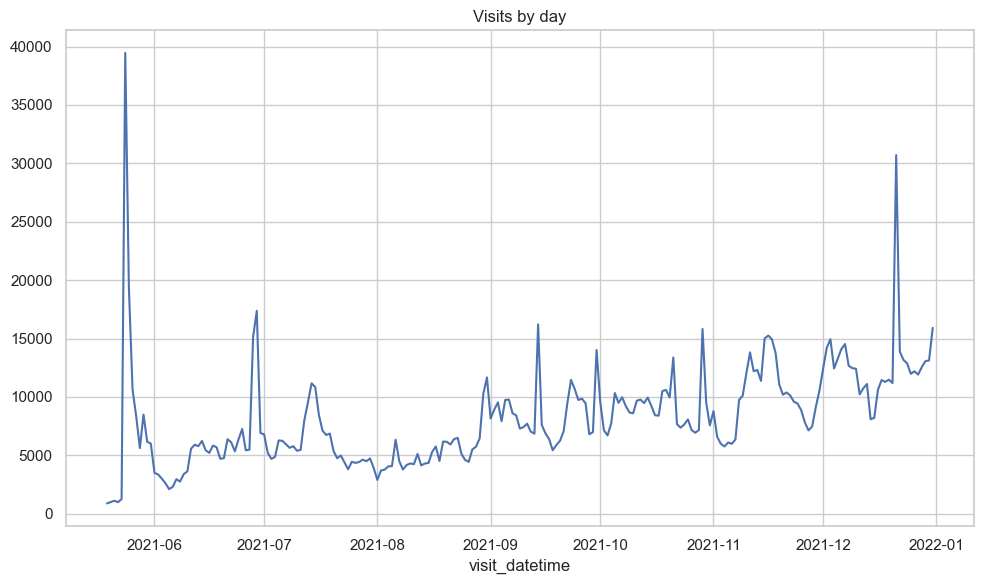

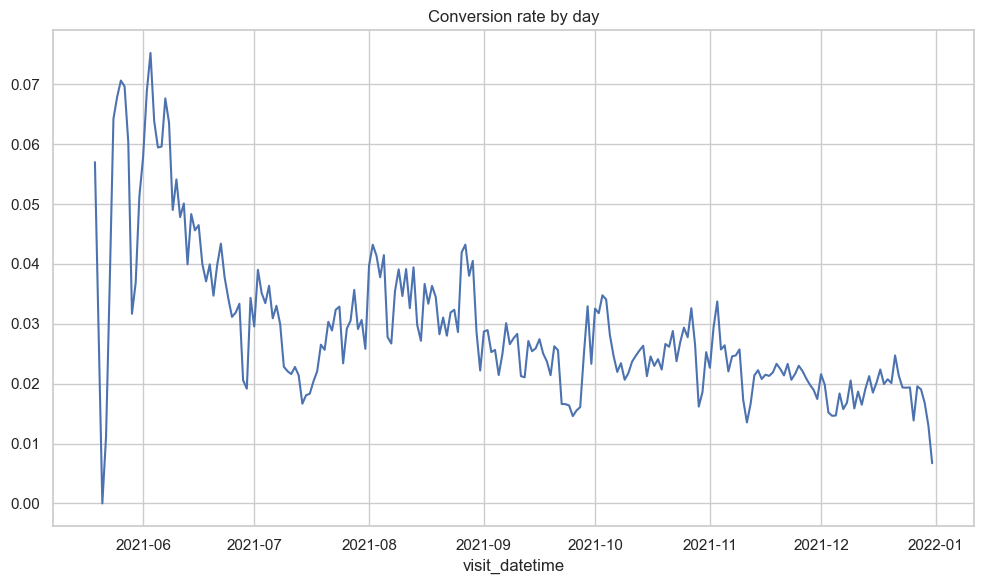

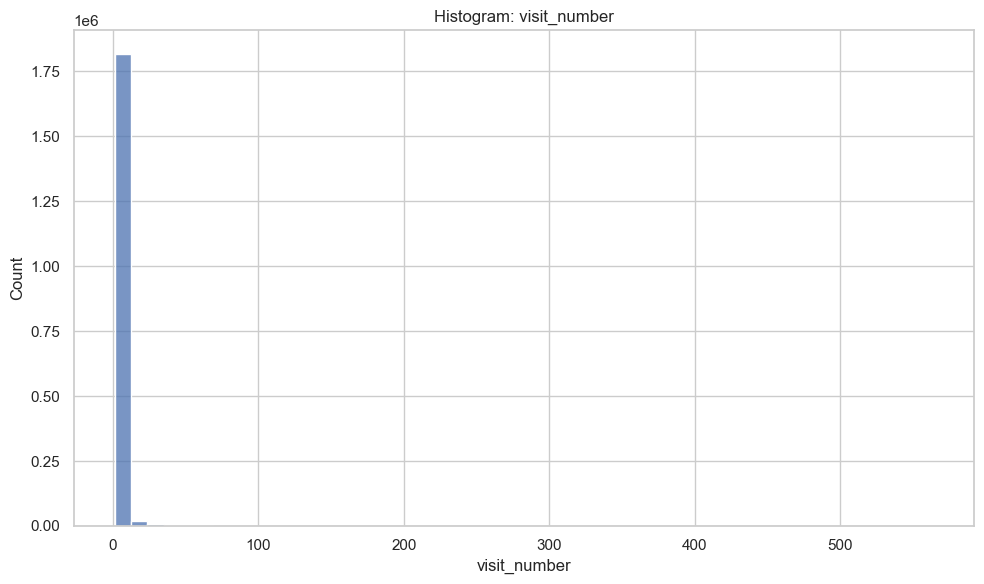

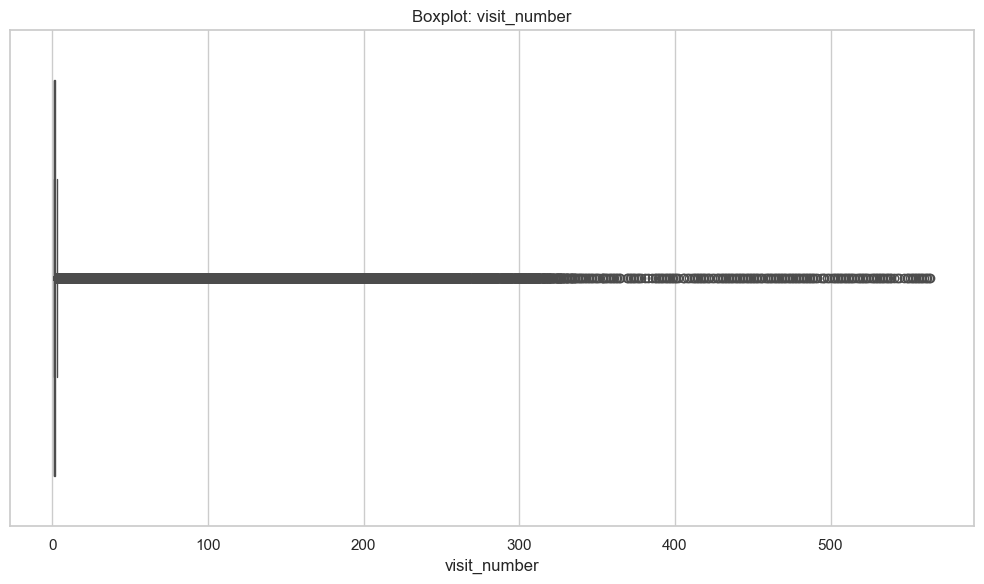

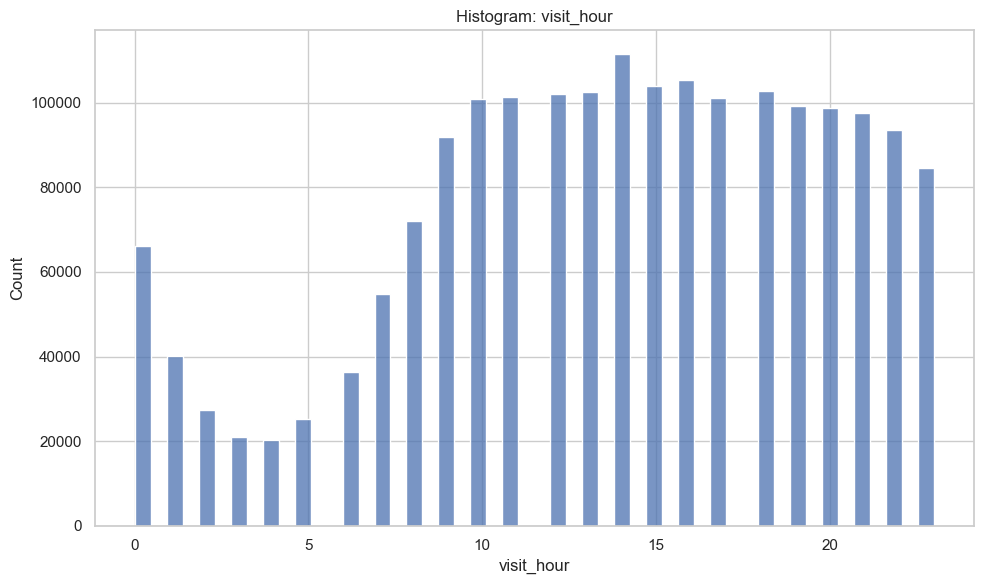

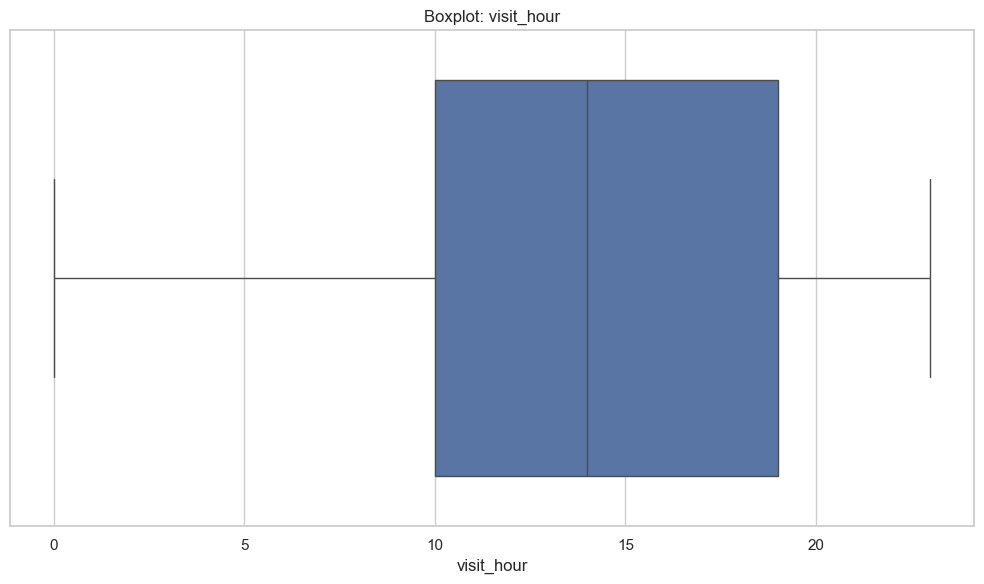

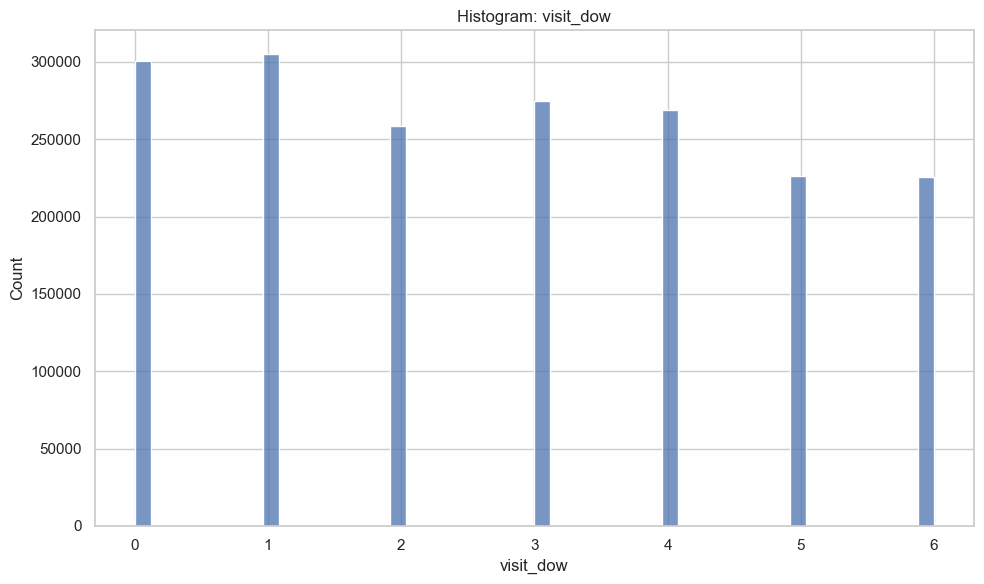

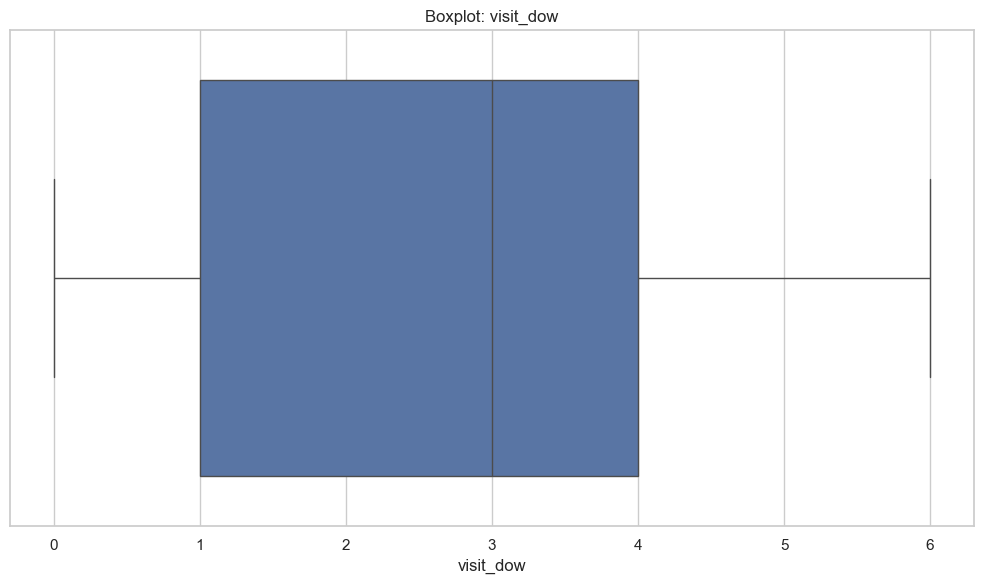

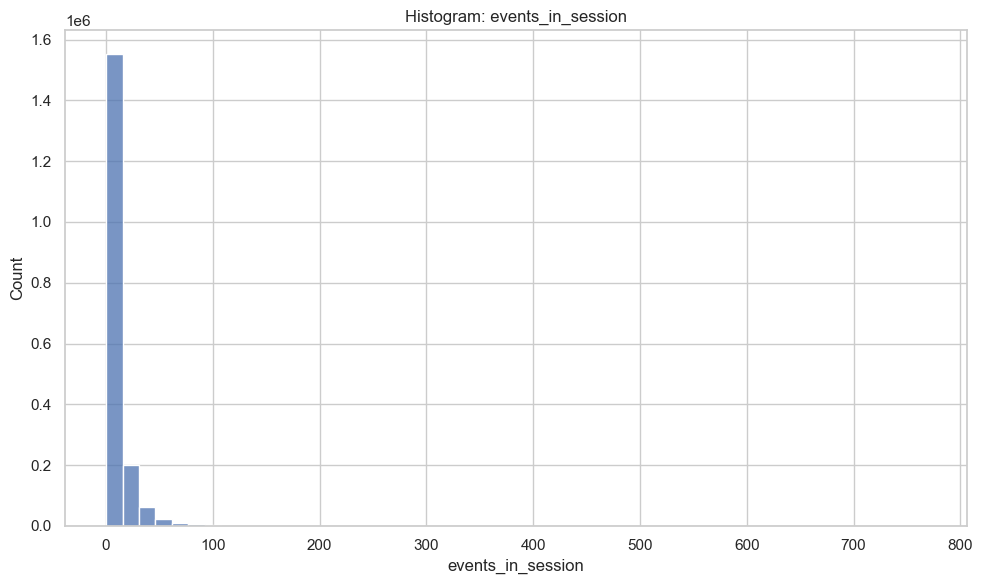

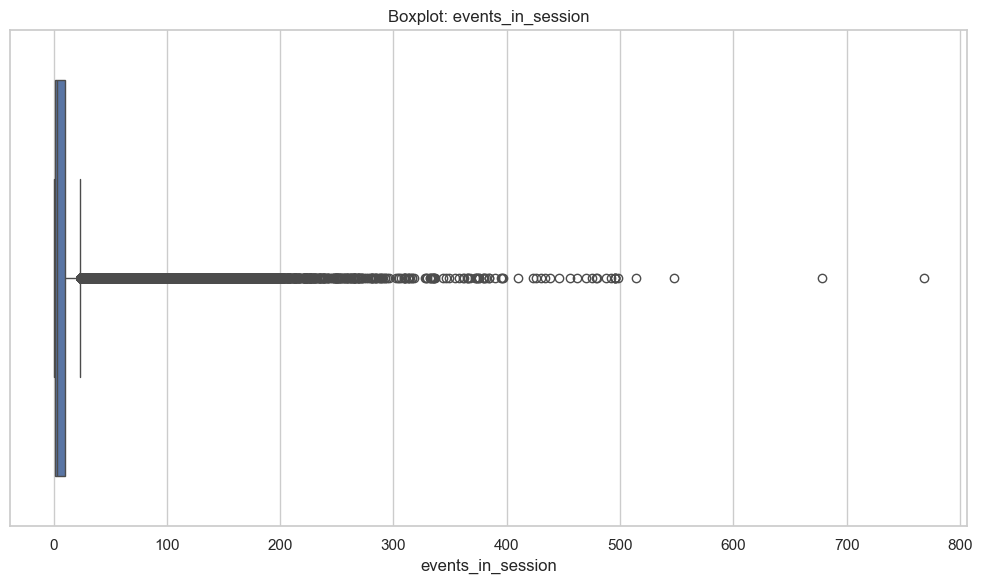

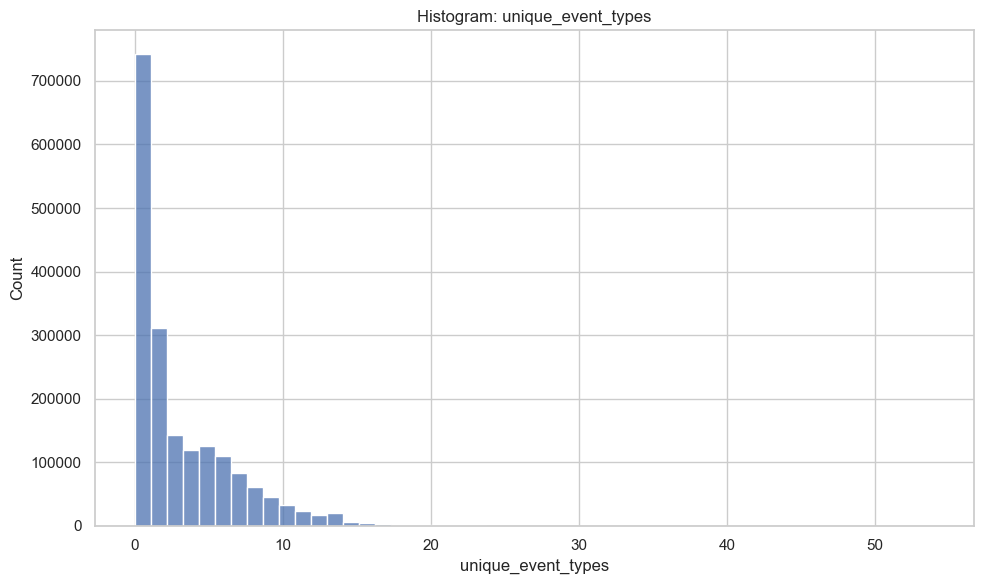

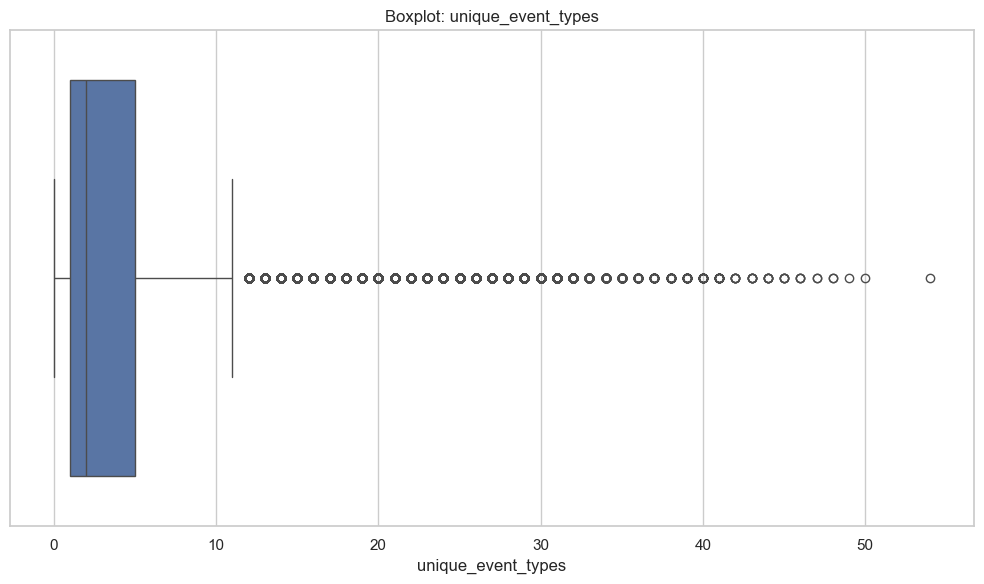

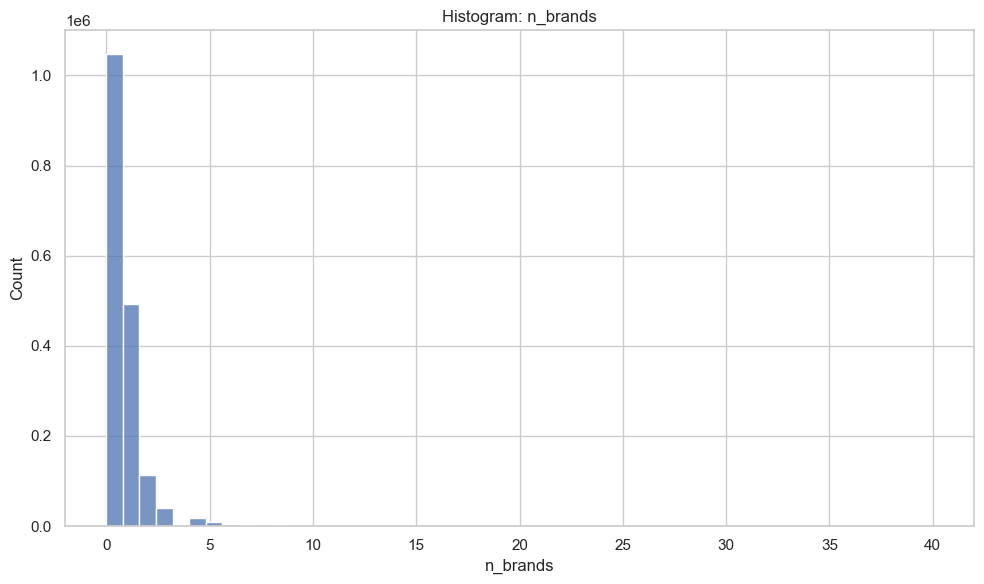

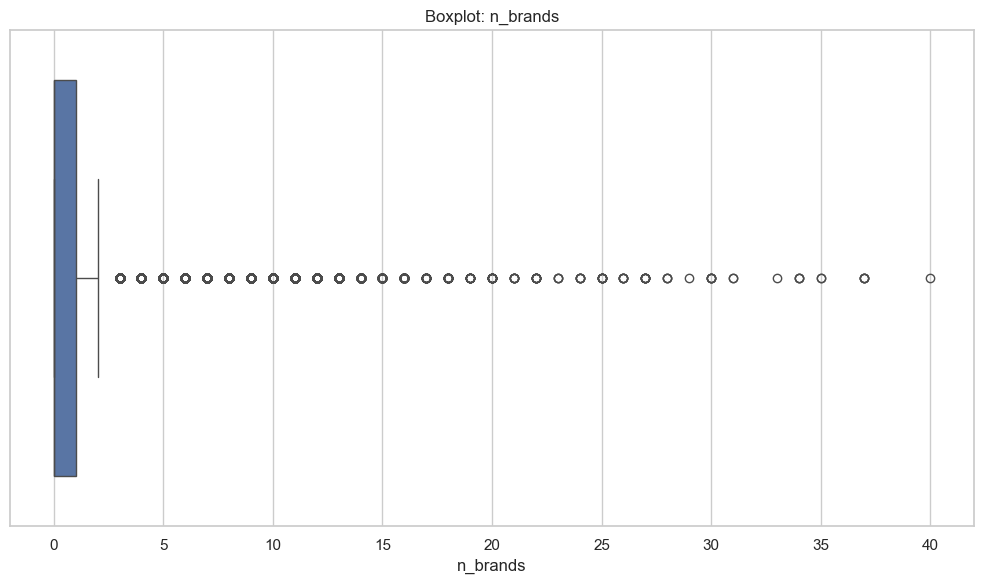

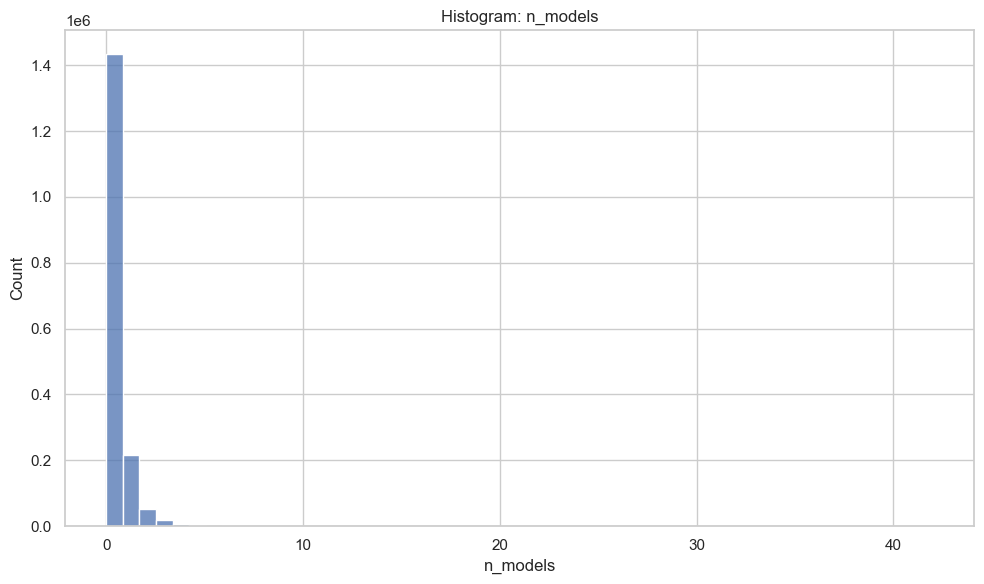

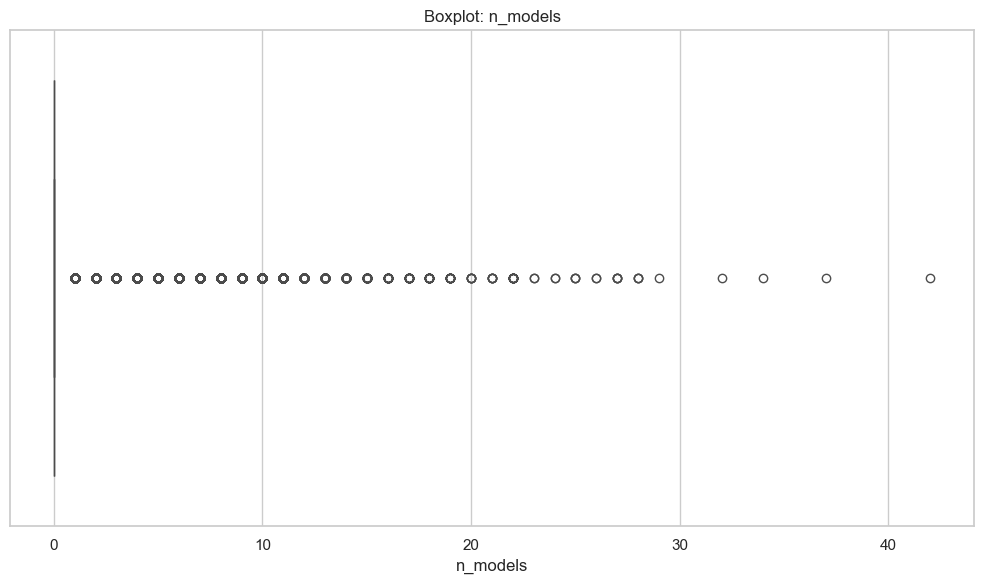

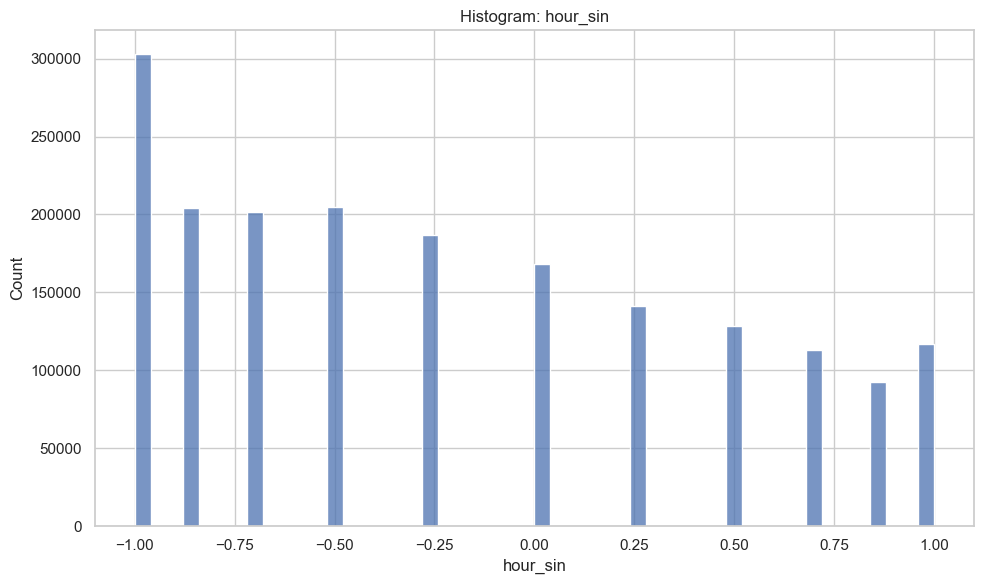

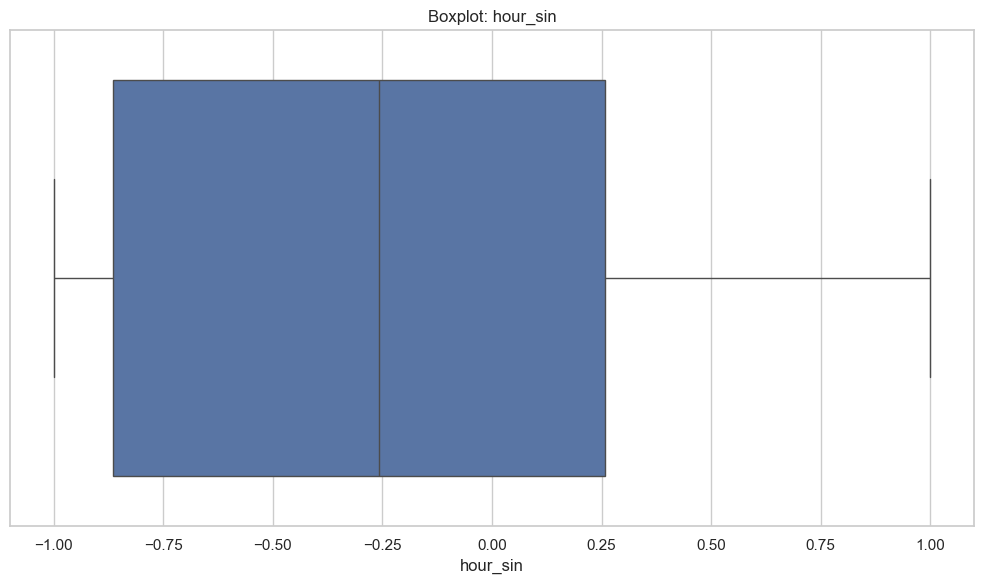

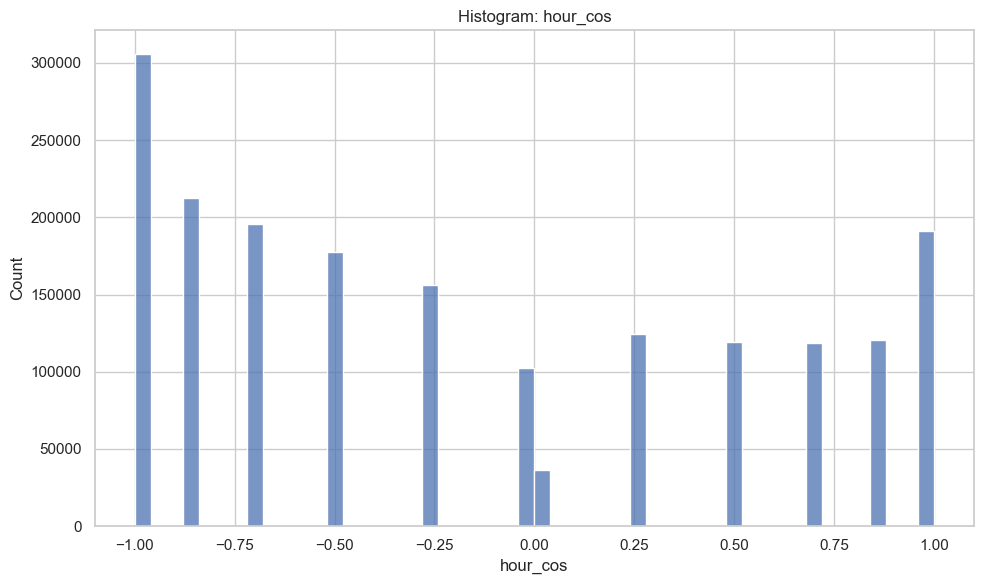

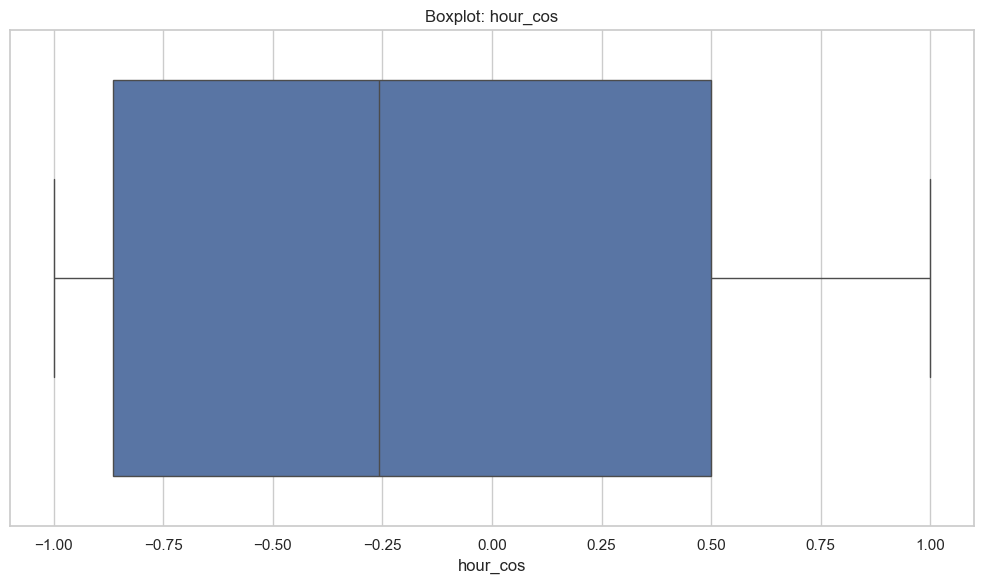

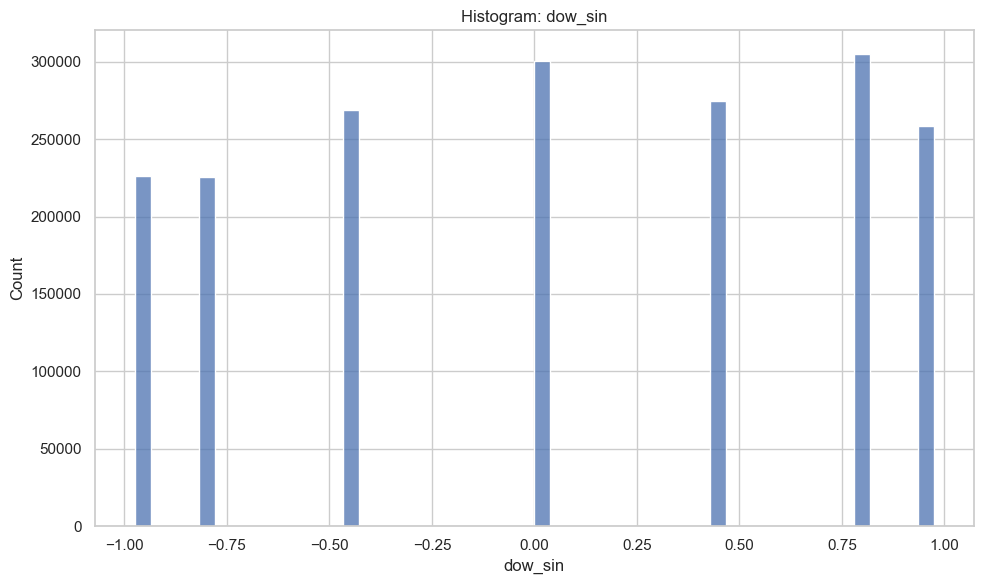

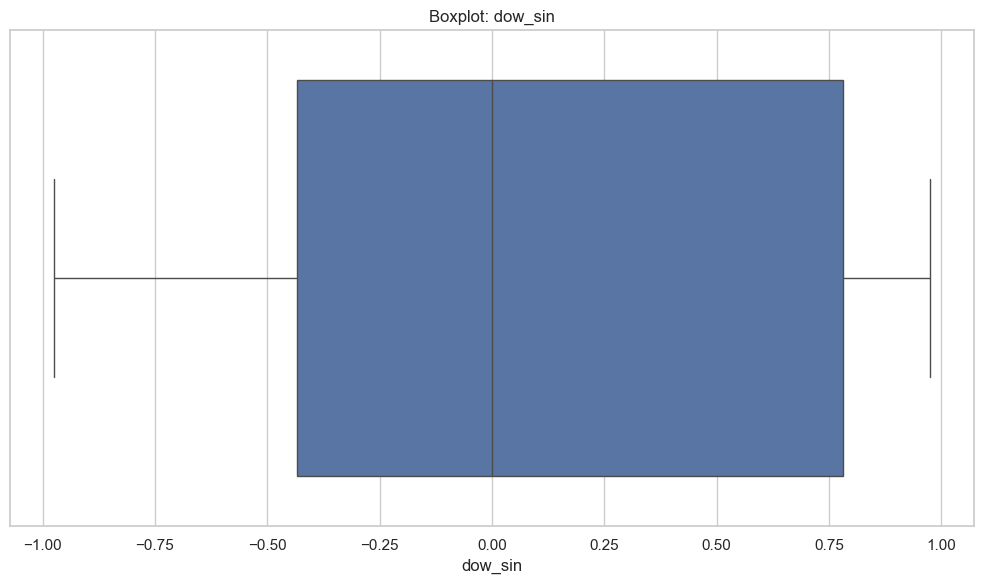

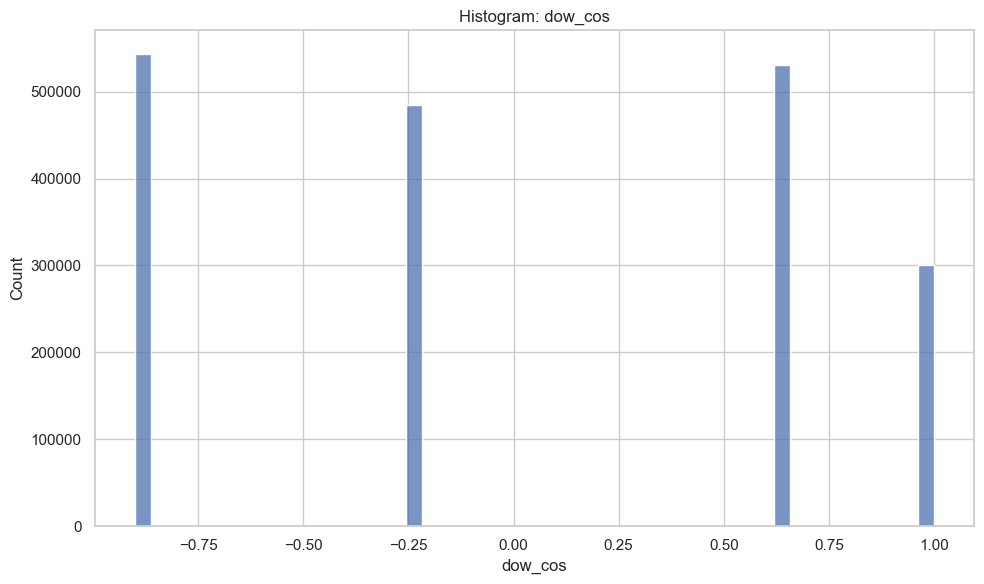

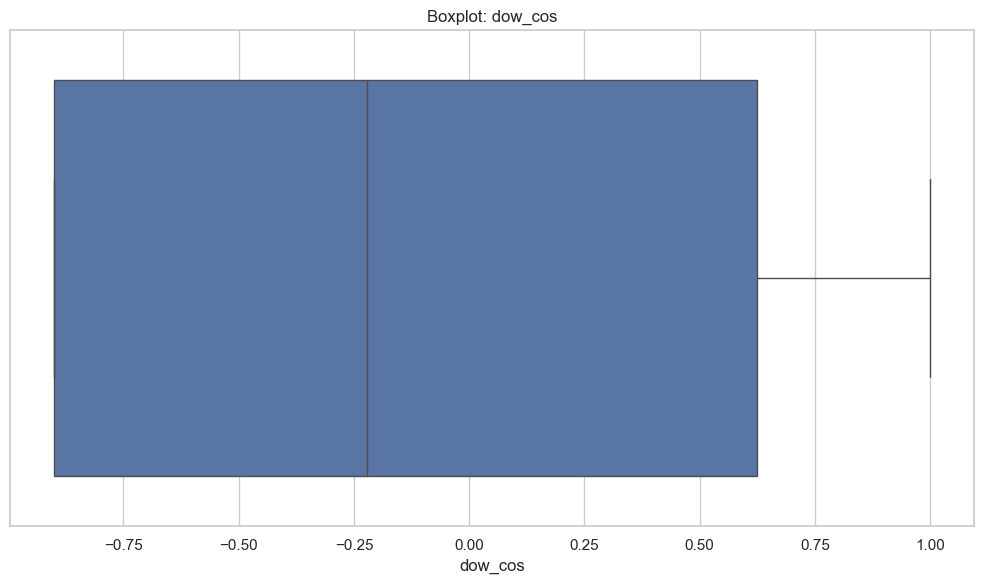

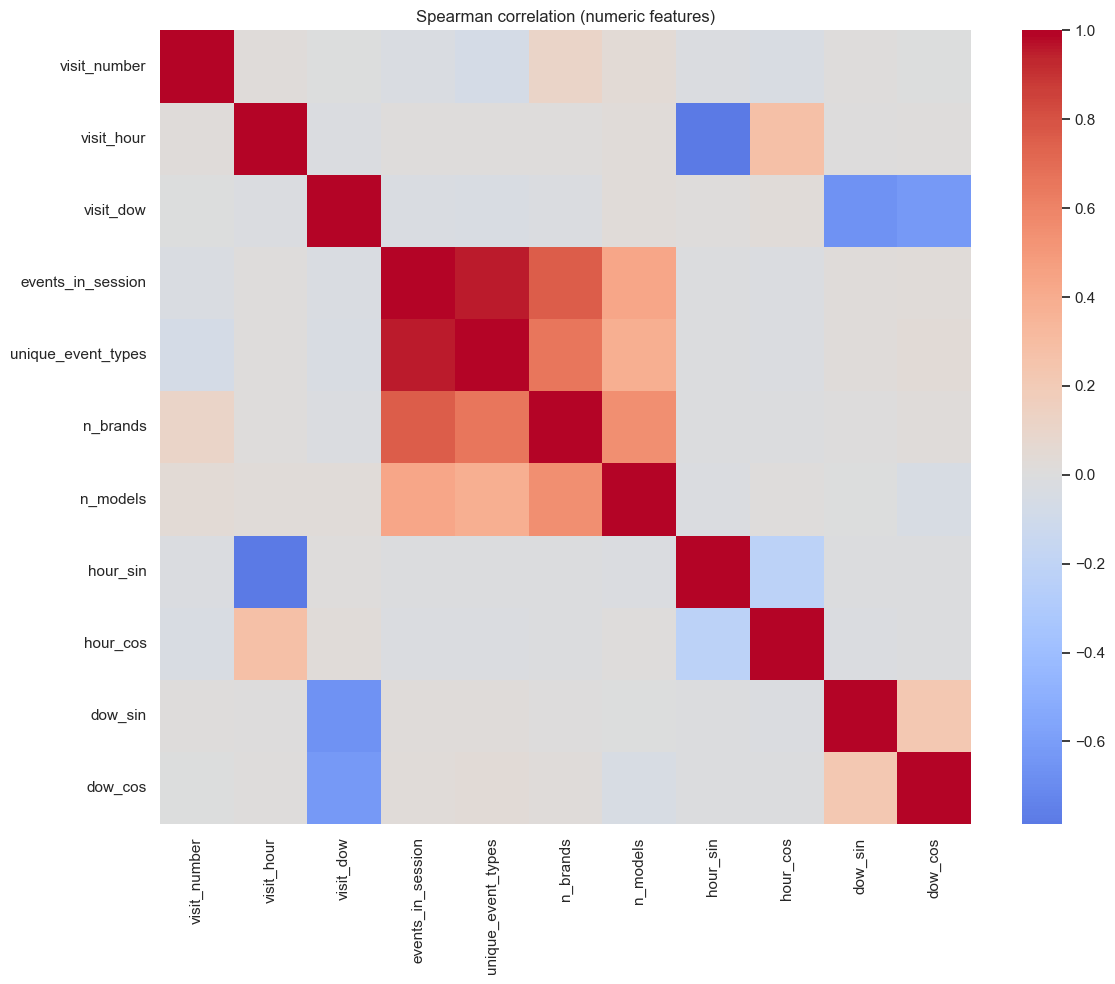

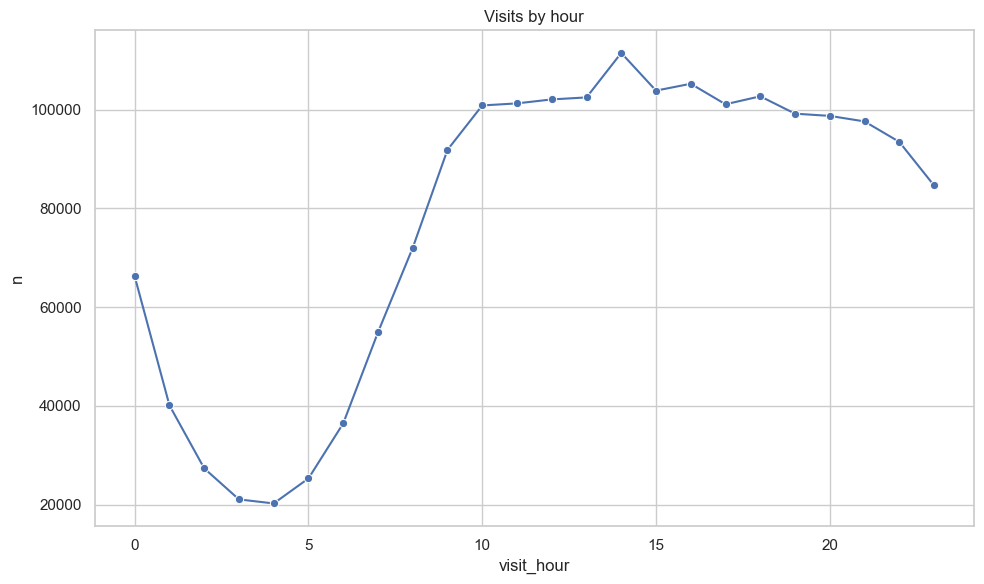

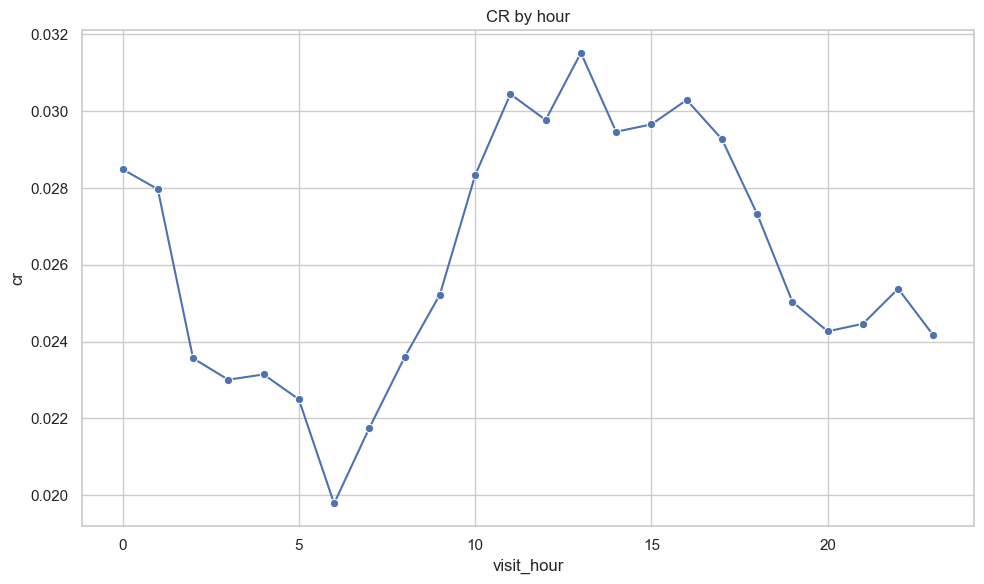

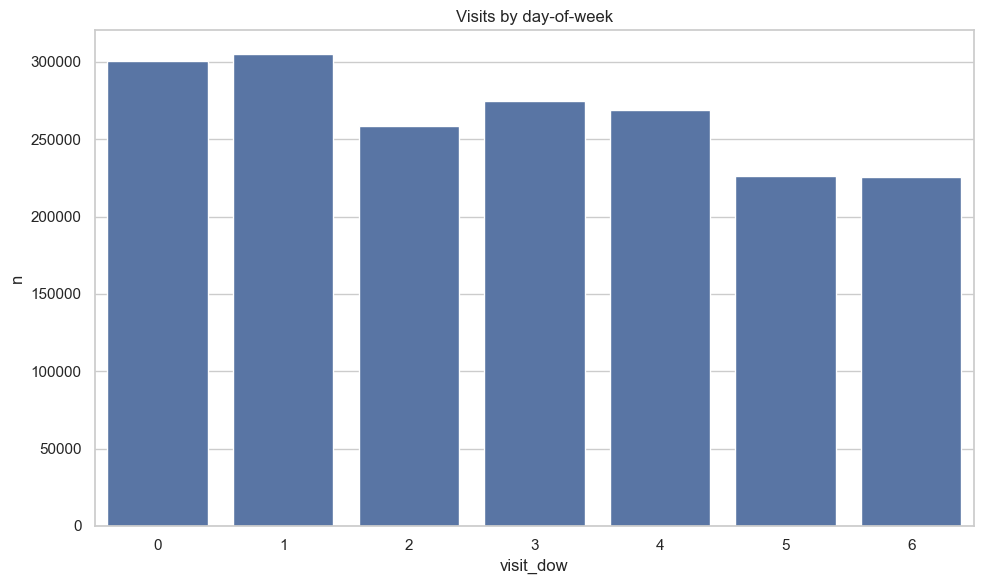

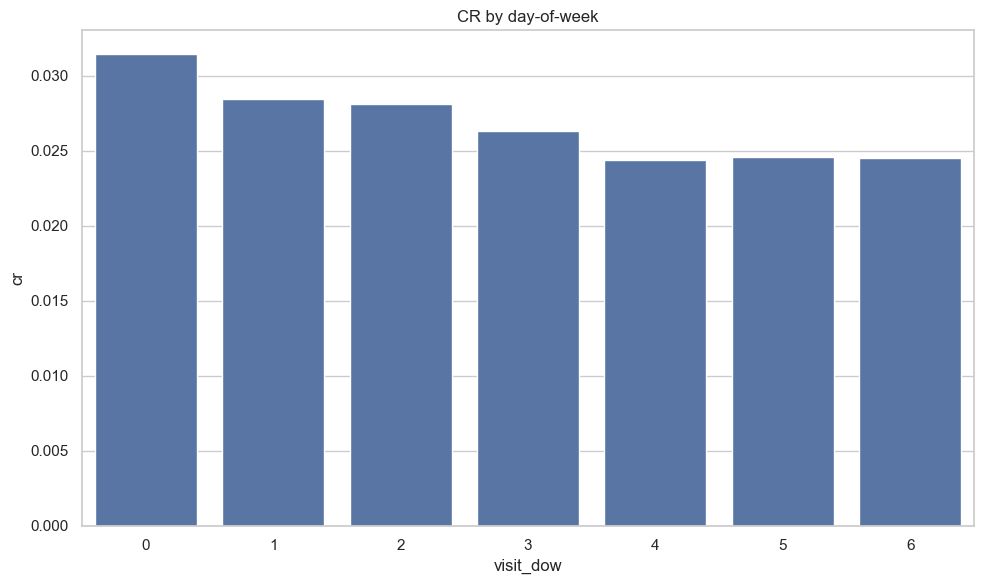

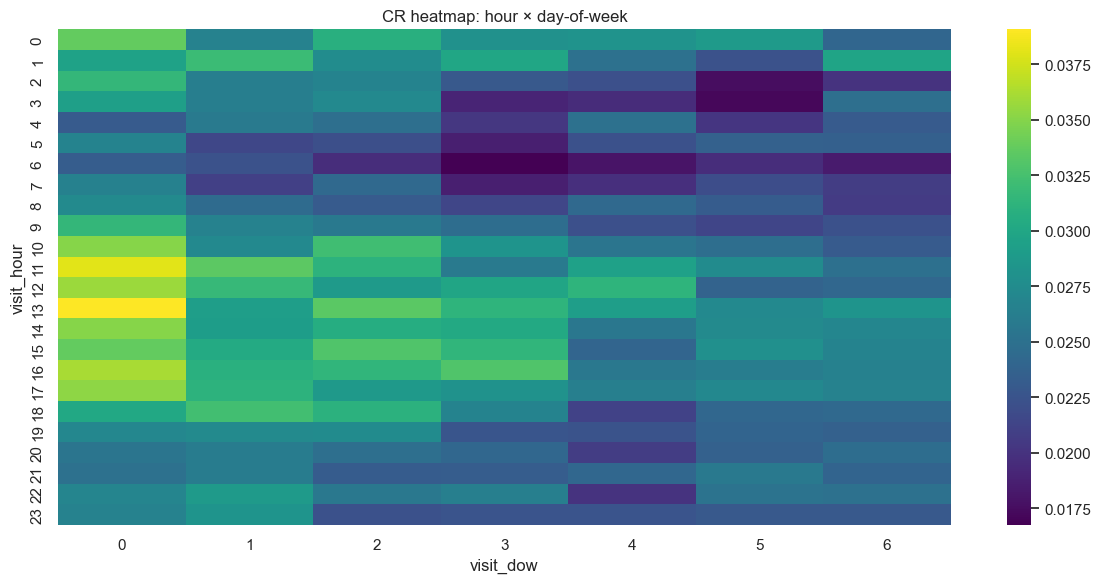

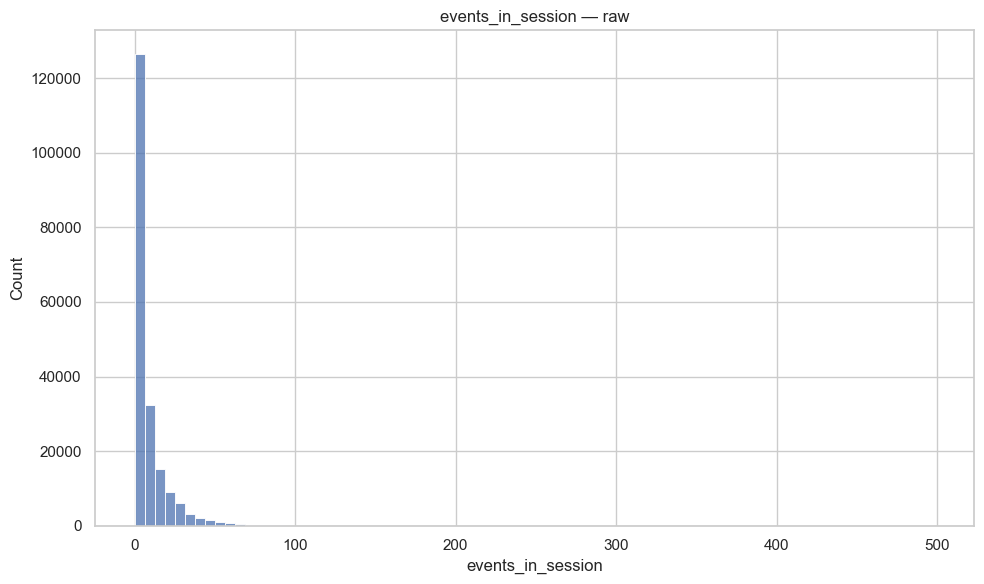

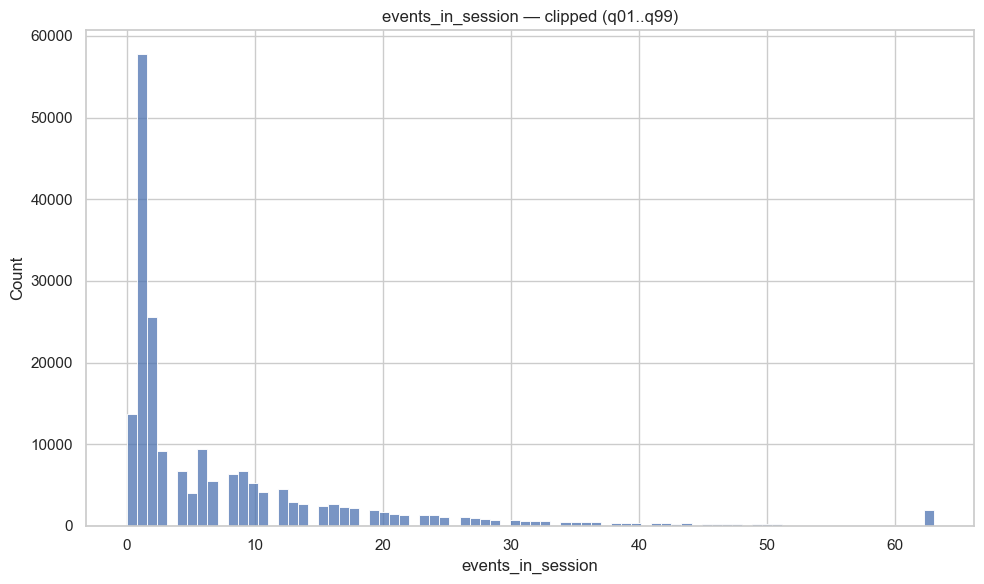

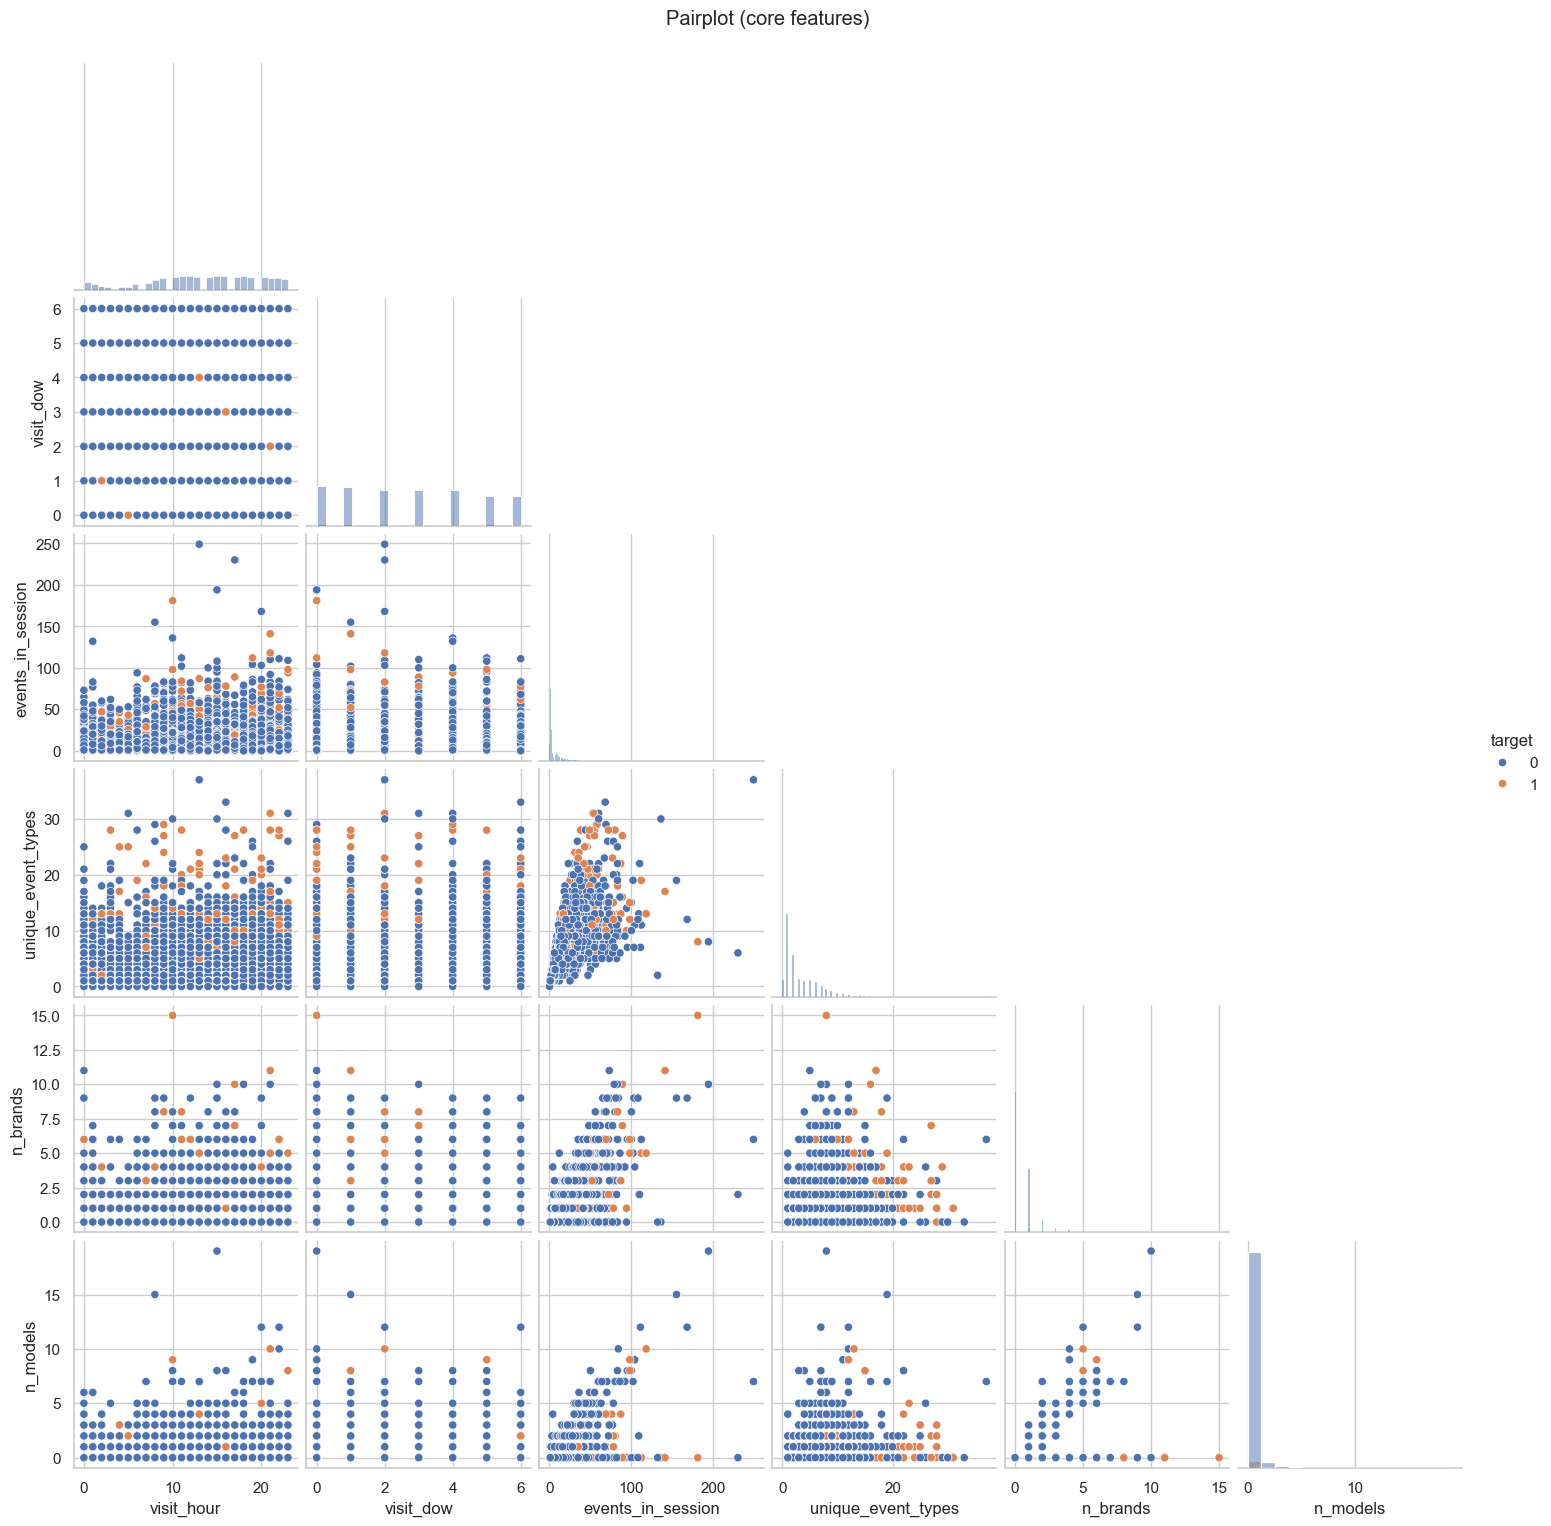

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.279s...
[t-SNE] Computed neighbors for 20000 samples in 3.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

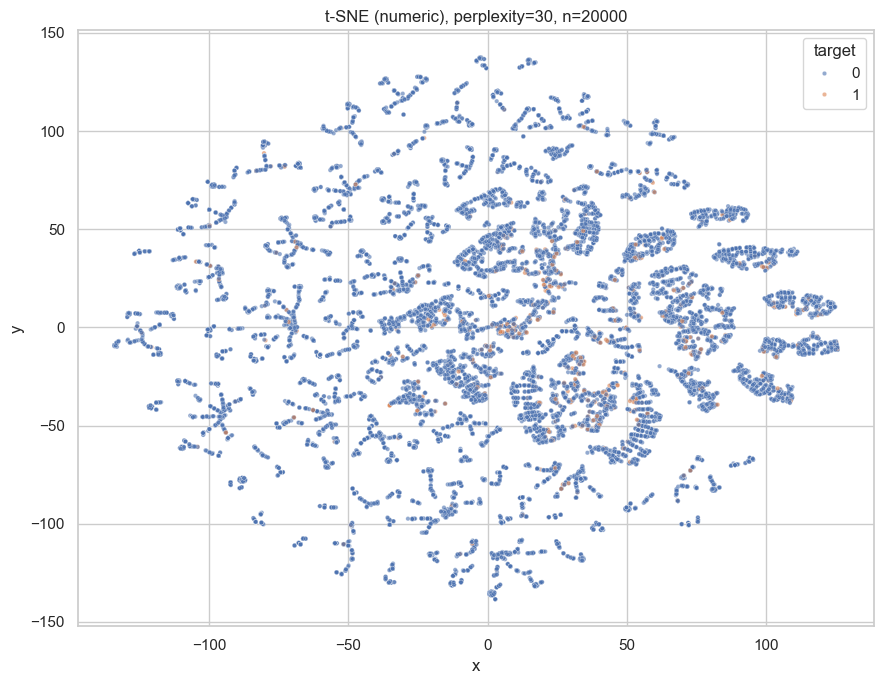

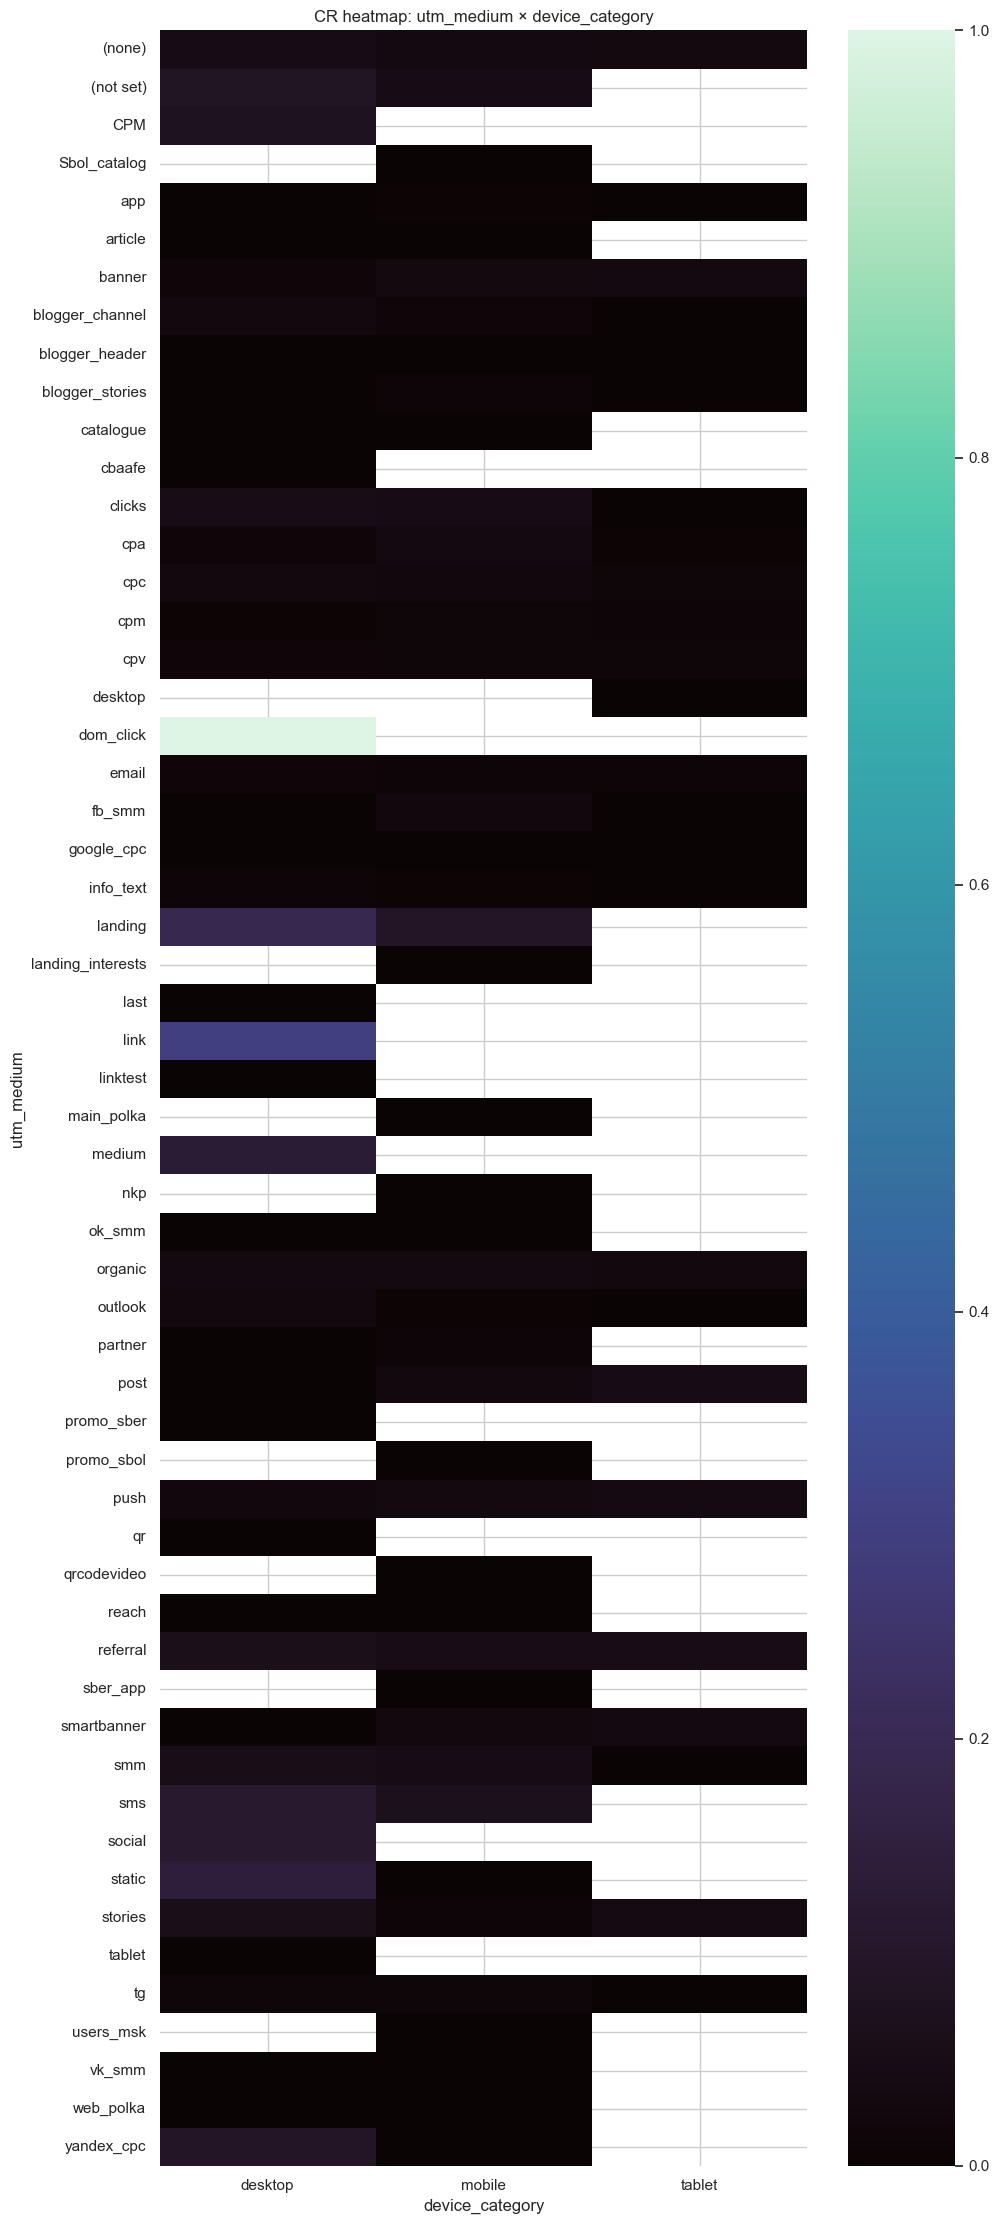

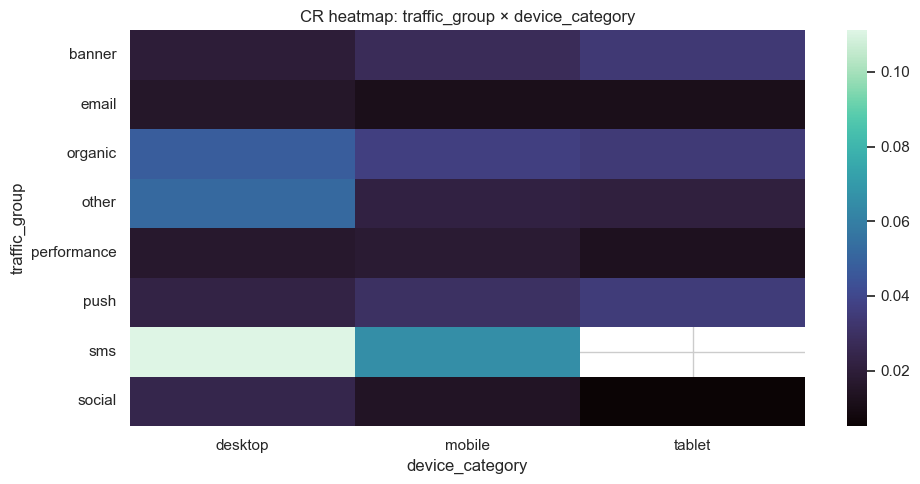

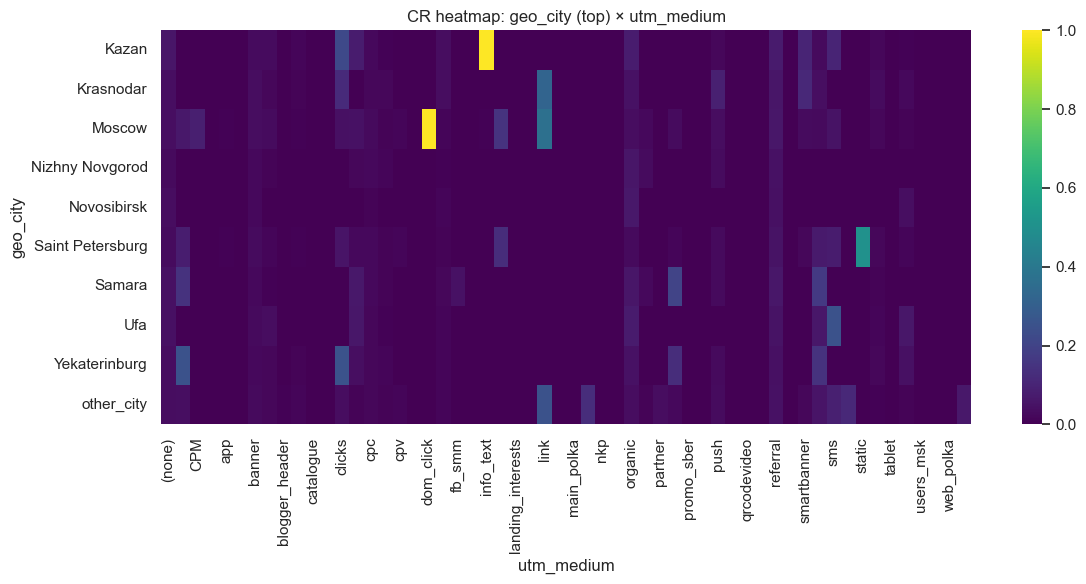

EDA готов. Все артефакты → D:\ML\LS\final\final_project\artifacts\eda


In [68]:
SHOW = True  # показывать графики в ноутбуке

# CONFIG 
OUTPUT_DIR = ROOT_PATH / "artifacts" / "eda"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Сэмплы для тяжёлых графиков
PAIRPLOT_SAMPLE = 12_000
TSNE_SAMPLE     = 20_000

# Порог минимального числа сессий для стабильных CR по категориям
MIN_SESS_PER_CAT = 2_000

# Редкие категории: доля/порог
RARE_FRAC_THRESHOLD = 0.001  # 0.1% от датасета
TOP_K_GEO_CITY      = 50     # для подробных таблиц/теплокарт

# Вспомогательные функции
def memory_report(df: pd.DataFrame) -> pd.DataFrame:
    mem = df.memory_usage(deep=True).sort_values(ascending=False)
    out = pd.DataFrame({
        "column": mem.index.astype(str),
        "bytes": mem.values,
        "MB": mem.values / (1024**2)
    })
    out.to_csv(OUTPUT_DIR / "memory_usage.csv", index=False)
    return out

def cramers_v_bias_corrected(confusion_matrix: pd.DataFrame) -> float:
    # Bergsma (2013) bias corrected Cramér’s V
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def cramers_v_score(df: pd.DataFrame, col: str, target: str = "target") -> float:
    ct = pd.crosstab(df[col], df[target])
    return cramers_v_bias_corrected(ct)

def top_value_counts(df, col, n=30):
    vc = df[col].value_counts(dropna=False)
    vc.to_csv(OUTPUT_DIR / f"value_counts__{col}.csv")
    return vc.head(n)

def rare_mask(series: pd.Series, min_count: int) -> pd.Series:
    vc = series.value_counts()
    rare = series.isin(vc[vc < min_count].index)
    return rare

def rate_table(df, by, min_n=MIN_SESS_PER_CAT):
    agg = (
        df.groupby(by)
          .agg(n=("target","size"), cr=("target","mean"))
          .reset_index()
          .query("n >= @min_n")
          .sort_values("cr", ascending=False)
    )
    agg.to_csv(OUTPUT_DIR / f"cr_by__{'__'.join(by if isinstance(by, list) else [by])}.csv", index=False)
    return agg

def savefig_show(path, fig=None):
    """Сохранить и показать текущий (или переданный) Figure."""
    fig = fig or plt.gcf()
    fig.tight_layout()
    fig.savefig(path, bbox_inches="tight", dpi=150)
    if SHOW:
        plt.show()
    plt.close(fig)

# Базовые проверки 
assert "target" in df.columns, "В df должен быть бинарный столбец target."
# безопасно приводим время
if "visit_datetime" in df.columns and not np.issubdtype(df["visit_datetime"].dtype, np.datetime64):
    df["visit_datetime"] = pd.to_datetime(df["visit_datetime"], errors="coerce")

print("Shape:", df.shape)
print(df.dtypes.value_counts())

mem_df = memory_report(df)
print(f"Memory report → {OUTPUT_DIR / 'memory_usage.csv'}")

# Дубликаты
dup_rows = df.duplicated().sum()
dup_sessions = df["session_id"].duplicated().sum() if "session_id" in df.columns else 0
with open(OUTPUT_DIR / "duplicates.json", "w", encoding="utf-8") as f:
    json.dump({"dup_rows": int(dup_rows), "dup_session_id": int(dup_sessions)}, f, ensure_ascii=False, indent=2)

# Пропуски
na_stats = df.isna().mean().sort_values(ascending=False)
na_stats.to_csv(OUTPUT_DIR / "missing_share.csv")
print(f"Missingness saved → {OUTPUT_DIR / 'missing_share.csv'}")

# Временной охват
min_dt = max_dt = None
if "visit_datetime" in df.columns:
    min_dt, max_dt = df["visit_datetime"].min(), df["visit_datetime"].max()
    print(f"Time range: {min_dt} → {max_dt}")
    # по дням
    daily = df.groupby(df["visit_datetime"].dt.date).agg(visits=("target","size"), cr=("target","mean"))
    fig, ax = plt.subplots()
    daily["visits"].plot(title="Visits by day", ax=ax)
    savefig_show(OUTPUT_DIR / "visits_by_day.png", fig)

    fig, ax = plt.subplots()
    daily["cr"].plot(title="Conversion rate by day", ax=ax)
    savefig_show(OUTPUT_DIR / "cr_by_day.png", fig)

# Распределения числовых 
num_cols = [
    "visit_number","visit_hour","visit_dow","events_in_session","unique_event_types",
    "n_brands","n_models","hour_sin","hour_cos","dow_sin","dow_cos"
]
num_cols = [c for c in num_cols if c in df.columns]

for col in num_cols:
    fig, ax = plt.subplots()
    sns.histplot(df[col], bins=50, ax=ax)
    ax.set_title(f"Histogram: {col}")
    savefig_show(OUTPUT_DIR / f"hist__{col}.png", fig)

    fig, ax = plt.subplots()
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot: {col}")
    savefig_show(OUTPUT_DIR / f"box__{col}.png", fig)

# Корреляции числовых
if len(num_cols) >= 2:
    corr = df[num_cols].corr(method="spearman")
    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, ax=ax)
    ax.set_title("Spearman correlation (numeric features)")
    savefig_show(OUTPUT_DIR / "corr_numeric_spearman.png", fig)
    corr.to_csv(OUTPUT_DIR / "corr_numeric_spearman.csv")

# Категориальные: важность vs target 
cat_cols = [
    "utm_medium","device_category","geo_country","geo_city","traffic_group",
    "is_social","is_email","is_push","is_sms","is_perf",
    "car_brand","car_model","brand_model","is_top_brand","has_model","is_big_city","is_organic","is_paid"
]
cat_cols = [c for c in cat_cols if c in df.columns]

cramers_list = []
for col in cat_cols:
    try:
        score = cramers_v_score(df, col, "target")
        cramers_list.append((col, score))
    except Exception:
        cramers_list.append((col, np.nan))
cramers_df = pd.DataFrame(cramers_list, columns=["feature","cramers_v"]).sort_values("cramers_v", ascending=False)
cramers_df.to_csv(OUTPUT_DIR / "cramers_vs_target.csv", index=False)

# CR-лидеры по основным признакам
for col in ["utm_medium","traffic_group","device_category","geo_country","geo_city","car_brand","car_model","brand_model","is_big_city"]:
    if col in df.columns:
        _ = rate_table(df, col, min_n=MIN_SESS_PER_CAT)

# Час и день недели — поведение и CR
if {"visit_hour","visit_dow"}.issubset(df.columns):
    hr = df.groupby("visit_hour").agg(n=("target","size"), cr=("target","mean")).reset_index()

    fig, ax = plt.subplots()
    sns.lineplot(data=hr, x="visit_hour", y="n", marker="o", ax=ax)
    ax.set_title("Visits by hour")
    savefig_show(OUTPUT_DIR / "visits_by_hour.png", fig)

    fig, ax = plt.subplots()
    sns.lineplot(data=hr, x="visit_hour", y="cr", marker="o", ax=ax)
    ax.set_title("CR by hour")
    savefig_show(OUTPUT_DIR / "cr_by_hour.png", fig)

    dow = df.groupby("visit_dow").agg(n=("target","size"), cr=("target","mean")).reset_index()
    fig, ax = plt.subplots()
    sns.barplot(data=dow, x="visit_dow", y="n", ax=ax)
    ax.set_title("Visits by day-of-week")
    savefig_show(OUTPUT_DIR / "visits_by_dow.png", fig)

    fig, ax = plt.subplots()
    sns.barplot(data=dow, x="visit_dow", y="cr", ax=ax)
    ax.set_title("CR by day-of-week")
    savefig_show(OUTPUT_DIR / "cr_by_dow.png", fig)

    # 2D heatmap hour x dow по CR
    pivot = df.groupby(["visit_dow","visit_hour"])["target"].mean().unstack(0)
    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(pivot, cmap="viridis", ax=ax)
    ax.set_title("CR heatmap: hour × day-of-week")
    savefig_show(OUTPUT_DIR / "cr_heatmap_hour_by_dow.png", fig)

# Редкие категории: предложения по нормализации
rare_recs = {}
n_rows = len(df)
for col in cat_cols:
    # для бинарных флагов пропускаем
    if df[col].nunique(dropna=False) <= 10 and set(df[col].dropna().unique()).issubset({0,1}):
        continue
    vc = df[col].value_counts(dropna=False)
    min_count = max(10, int(RARE_FRAC_THRESHOLD * n_rows))
    rare_values = vc[vc < min_count].index.tolist()
    rare_share = float(vc[vc < min_count].sum() / n_rows)
    rare_recs[col] = {
        "min_count": int(min_count),
        "n_rare_values": int(len(rare_values)),
        "rare_share": rare_share,
        "suggestion": "map to 'other' / collapse categories"
    }
with open(OUTPUT_DIR / "rare_categories_suggestions.json", "w", encoding="utf-8") as f:
    json.dump(rare_recs, f, ensure_ascii=False, indent=2)

# Выбросы и клиппинг 
clip_candidates = [c for c in ["visit_number","events_in_session","unique_event_types","n_brands","n_models"] if c in df.columns]
clip_plan = {}
for col in clip_candidates:
    q99 = df[col].quantile(0.99)
    q01 = df[col].quantile(0.01)
    clip_plan[col] = {"q01": float(q01), "q99": float(q99), "suggestion": f"clip to [{q01:.0f}, {q99:.0f}] (winsorize)"}
with open(OUTPUT_DIR / "clipping_suggestions.json", "w", encoding="utf-8") as f:
    json.dump(clip_plan, f, ensure_ascii=False, indent=2)

# Визуал до/после клиппинга (на сэмпле) для events_in_session
if "events_in_session" in df.columns:
    sample = df[["events_in_session"]].sample(200_000, random_state=SEED) if len(df) > 200_000 else df[["events_in_session"]].copy()
    q01, q99 = clip_plan["events_in_session"]["q01"], clip_plan["events_in_session"]["q99"]
    sample_clip = sample.clip(lower=q01, upper=q99)

    fig, ax = plt.subplots()
    sns.histplot(sample["events_in_session"], bins=80, ax=ax)
    ax.set_title("events_in_session — raw")
    savefig_show(OUTPUT_DIR / "events_in_session_hist_raw.png", fig)

    fig, ax = plt.subplots()
    sns.histplot(sample_clip["events_in_session"], bins=80, ax=ax)
    ax.set_title("events_in_session — clipped (q01..q99)")
    savefig_show(OUTPUT_DIR / "events_in_session_hist_clipped.png", fig)

# Pairplot (на сэмпле)
pair_cols = [c for c in ["visit_hour","visit_dow","events_in_session","unique_event_types","n_brands","n_models","target"] if c in df.columns]
if len(pair_cols) >= 3:
    pp_sample = df[pair_cols].sample(PAIRPLOT_SAMPLE, random_state=SEED)
    g = sns.pairplot(pp_sample, hue="target", corner=True, diag_kind="hist")
    # сохранение/показ PairGrid
    g.fig.suptitle("Pairplot (core features)", y=1.02)
    g.savefig(OUTPUT_DIR / "pairplot_core.png", dpi=150)
    if SHOW:
        plt.show()
    plt.close(g.fig)

# t-SNE (только числовые, на сэмпле)
tsne_num_cols = [c for c in num_cols if c != "target"]
if len(tsne_num_cols) >= 3:
    tmp = df[tsne_num_cols + ["target"]].copy()

    # числовые: привести, убрать inf -> NaN
    for c in tsne_num_cols:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

    # выбросить строки с NaN в числовых (только для t-SNE)
    tmp = tmp.dropna(subset=tsne_num_cols)
    if len(tmp) == 0:
        print("t-SNE пропущен: после очистки нет строк без NaN.")
    else:
        n_sample = min(TSNE_SAMPLE, len(tmp))
        tsne_sample = tmp.sample(n_sample, random_state=SEED)

        X = tsne_sample[tsne_num_cols].values.astype(np.float32)
        X = StandardScaler().fit_transform(X)
        # на всякий случай: заменить остаточные NaN/Inf нулями
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        # корректная perplexity: < (n_samples - 1) / 3, и не слишком малая
        max_perp = max(5, (n_sample - 1) // 3 - 1)
        perplexity = min(30, max_perp)

        if perplexity < 5:
            print(f"t-SNE пропущен: малый сэмпл ({n_sample}) не позволяет корректную perplexity.")
        else:
            tsne = TSNE(
                n_components=2,
                perplexity=perplexity,
                learning_rate=200,   
                init="pca",
                random_state=SEED,
                n_iter=1500,
                verbose=1,
            )
            emb = tsne.fit_transform(X)
            tsne_df = pd.DataFrame({
                "x": emb[:, 0],
                "y": emb[:, 1],
                "target": tsne_sample["target"].values
            })
            fig, ax = plt.subplots(figsize=(9,7))
            sns.scatterplot(data=tsne_df, x="x", y="y", hue="target", s=10, alpha=0.6, ax=ax)
            ax.set_title(f"t-SNE (numeric), perplexity={perplexity}, n={n_sample}")
            savefig_show(OUTPUT_DIR / "tsne_numeric.png", fig)
            tsne_df.to_csv(OUTPUT_DIR / "tsne_embedding.csv", index=False)

# Комбинации: канал × устройство, город × канал 
for cols in [["utm_medium","device_category"], ["traffic_group","device_category"]]:
    if all(c in df.columns for c in cols):
        cr = (
            df.groupby(cols)["target"]
              .mean().reset_index()
              .pivot(index=cols[0], columns=cols[1], values="target")
        )
        fig, ax = plt.subplots(figsize=(10, max(5, 0.4*len(cr))))
        sns.heatmap(cr, annot=False, cmap="mako", ax=ax)
        ax.set_title(f"CR heatmap: {cols[0]} × {cols[1]}")
        savefig_show(OUTPUT_DIR / f"cr_heatmap__{'__'.join(cols)}.png", fig)

if {"geo_city","utm_medium"}.issubset(df.columns):
    top_cities = df["geo_city"].value_counts().head(TOP_K_GEO_CITY).index
    sub = df[df["geo_city"].isin(top_cities)]
    cr = (
        sub.groupby(["geo_city","utm_medium"])["target"]
           .mean().reset_index()
           .pivot(index="geo_city", columns="utm_medium", values="target")
           .fillna(0.0)
    )
    fig, ax = plt.subplots(figsize=(12, max(6, 0.25*len(cr))))
    sns.heatmap(cr, cmap="viridis", ax=ax)
    ax.set_title("CR heatmap: geo_city (top) × utm_medium")
    savefig_show(OUTPUT_DIR / "cr_heatmap__geo_city__utm_medium.png", fig)
    cr.to_csv(OUTPUT_DIR / "cr_table__geo_city__utm_medium.csv")

# Итог: сводка и рекомендации 
summary = {
    "shape": {"rows": int(df.shape[0]), "cols": int(df.shape[1])},
    "duplicates": {"full_row_dups": int(dup_rows), "session_id_dups": int(dup_sessions)},
    "target_pos_rate": float(df["target"].mean()),
    "time_range": str((str(min_dt), str(max_dt))) if min_dt is not None else None,
    "top_features_cramers_v": cramers_df.head(15).to_dict(orient="records"),
    "clipping_suggestions_path": str(OUTPUT_DIR / "clipping_suggestions.json"),
    "rare_categories_suggestions_path": str(OUTPUT_DIR / "rare_categories_suggestions.json"),
    "notes": [
        "Клиппинг применить только на train после time-split, пороги брать из clipping_suggestions.json.",
        "Редкие категории маппить в 'other' (или аггрегировать) — особенно geo_city, brand_model, car_model.",
        "Проверить утечки: не использовать event_* как признаки, формирующие сам таргет (только агрегаты поведения).",
        "Валидировать модели time-based split (train→valid→test по датам из visit_datetime)."
    ]
}
with open(OUTPUT_DIR / "eda_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print(f"EDA готов. Все артефакты → {OUTPUT_DIR}")

# EDA-EXTRA

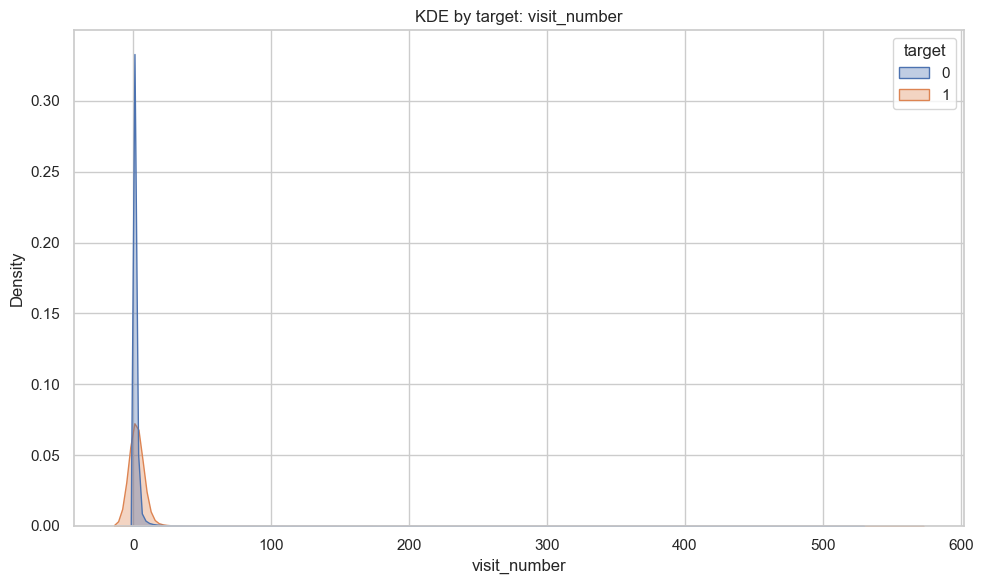

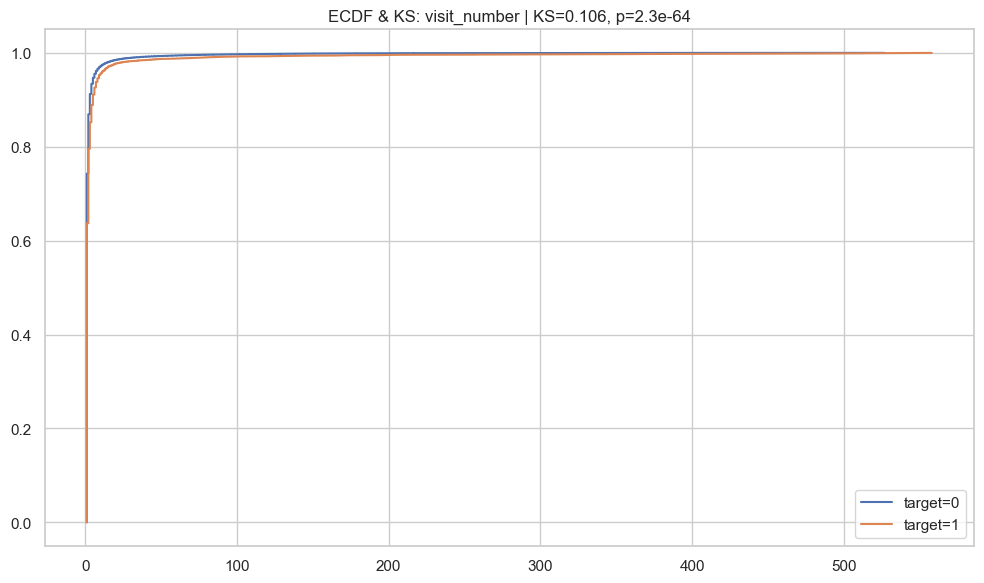

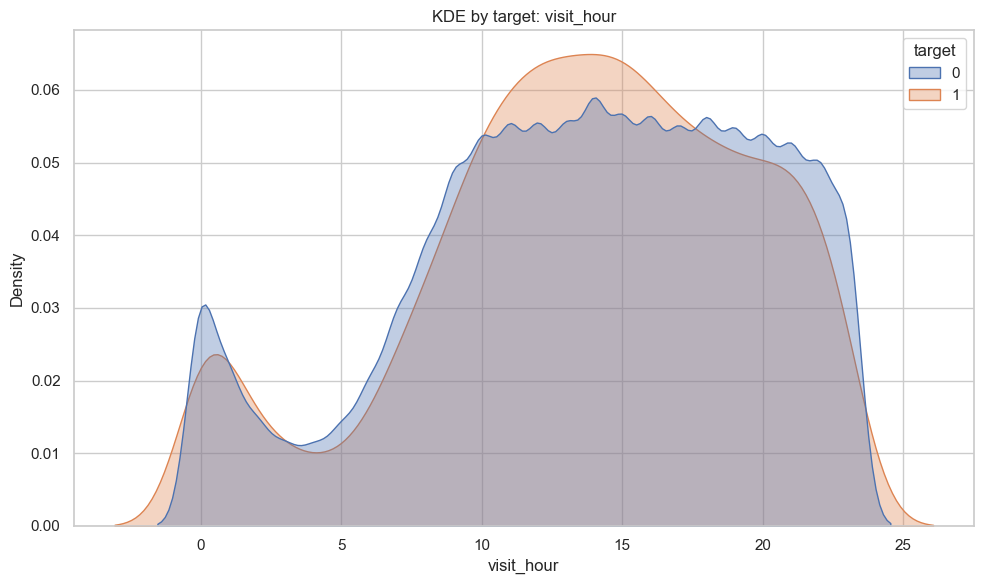

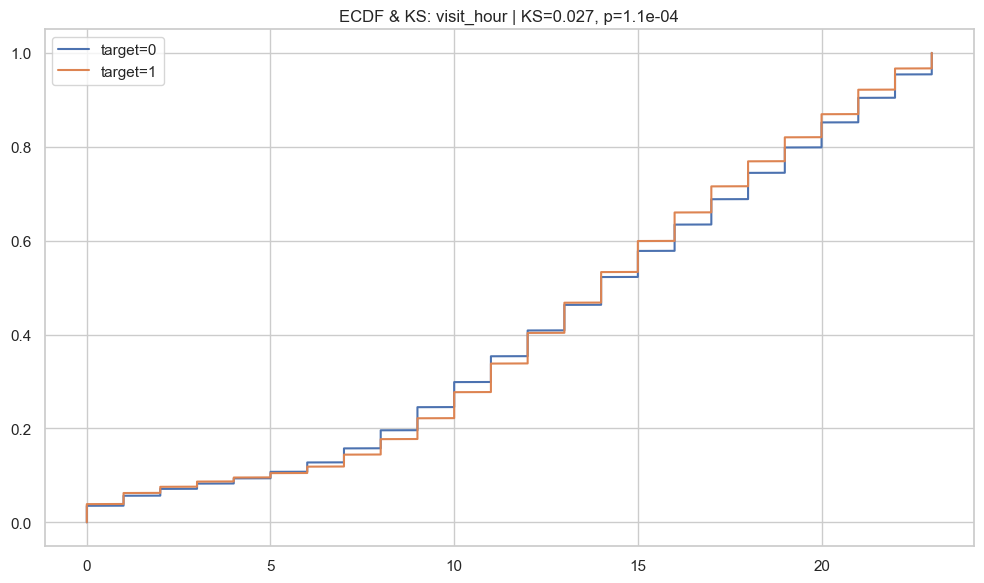

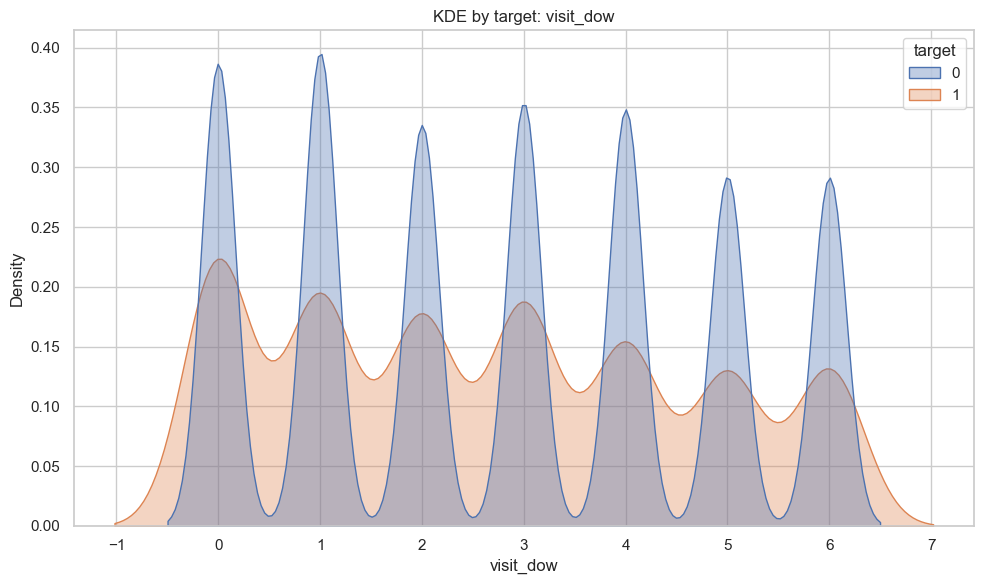

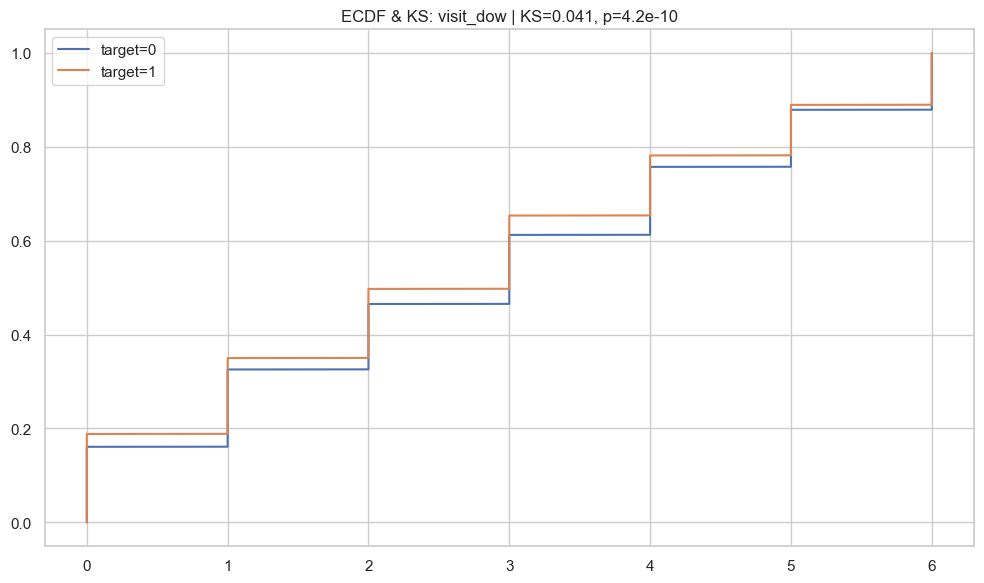

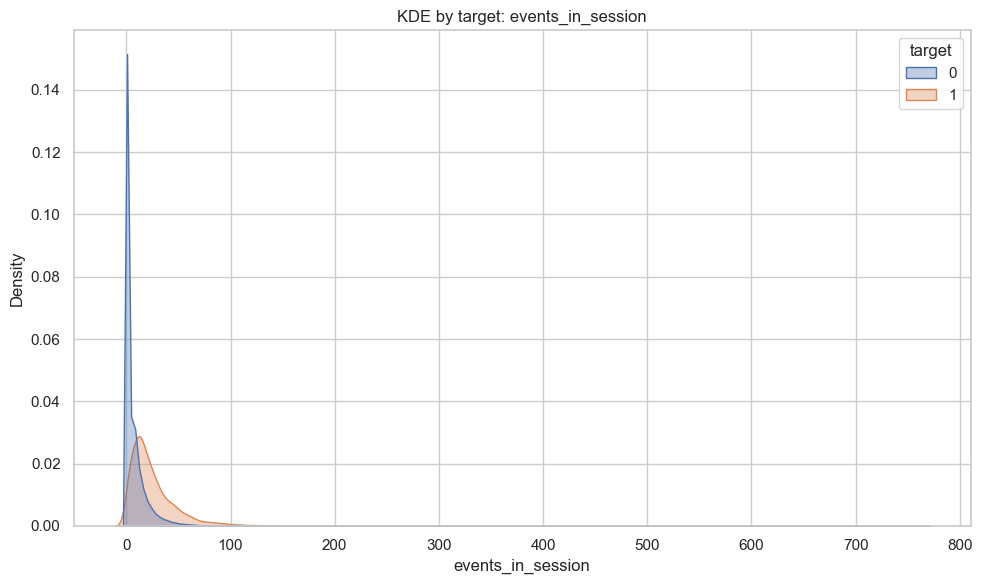

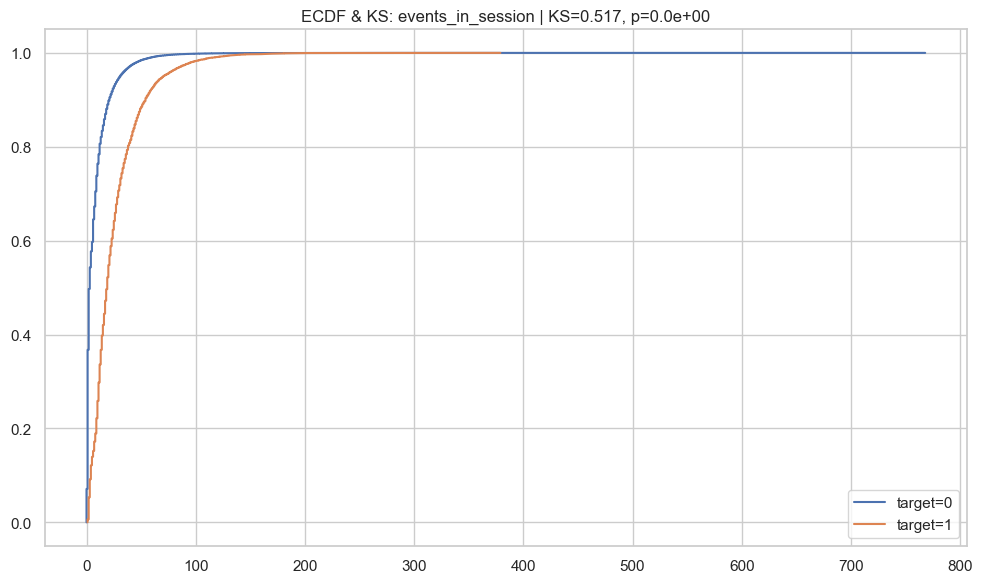

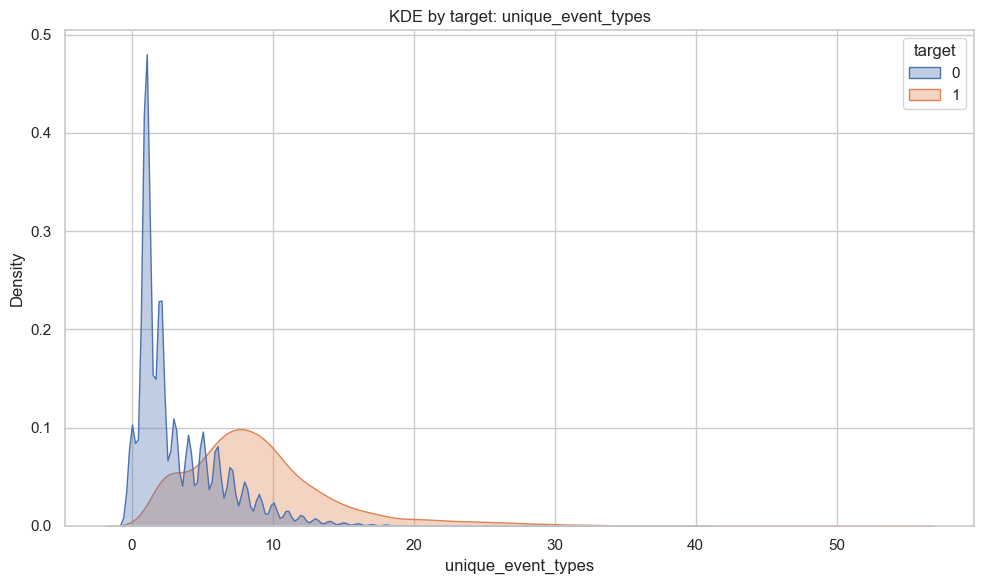

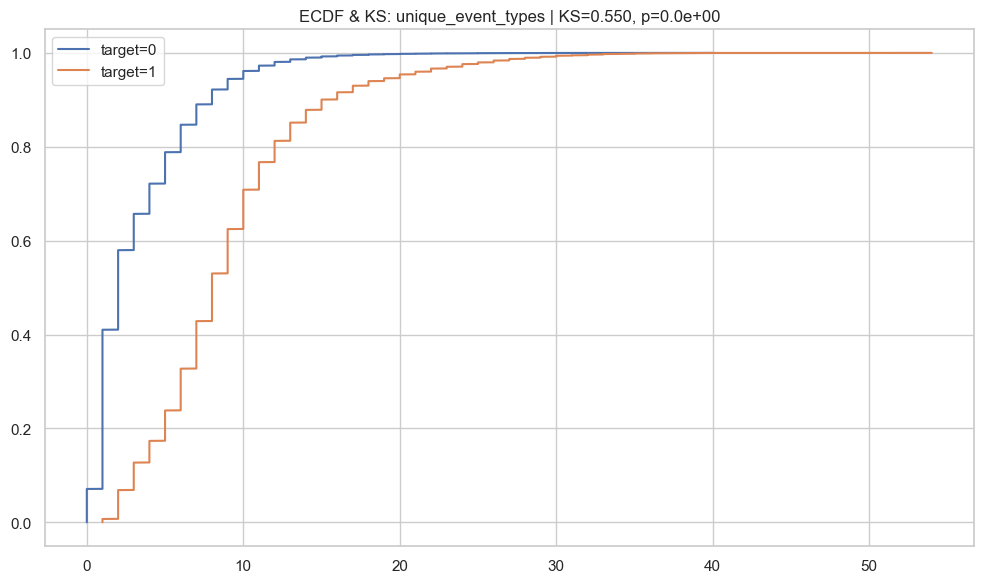

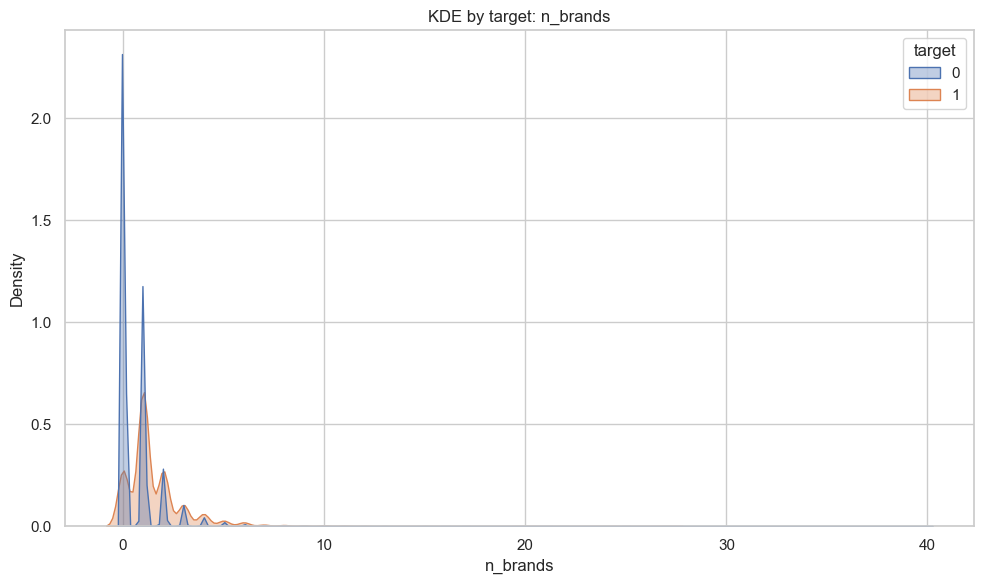

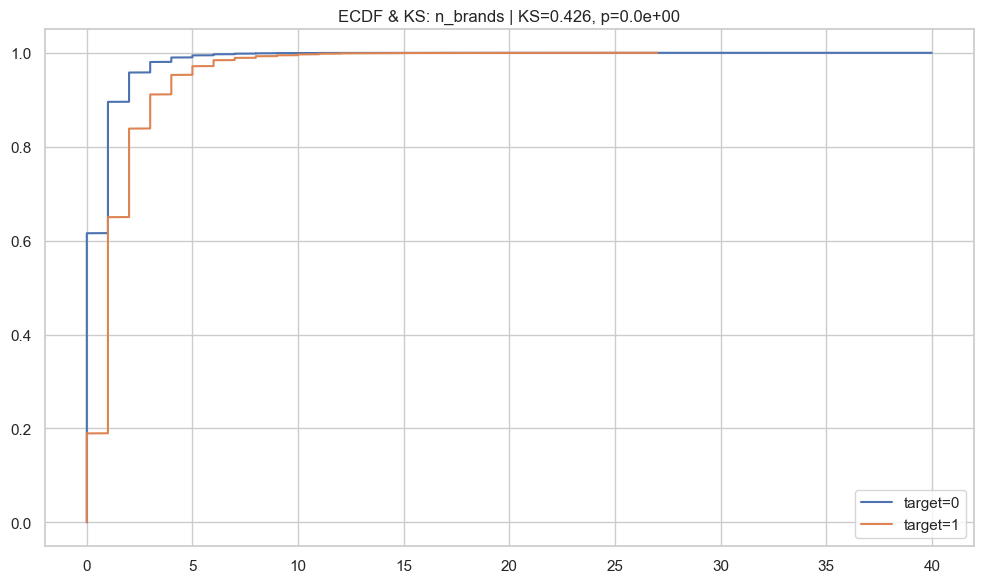

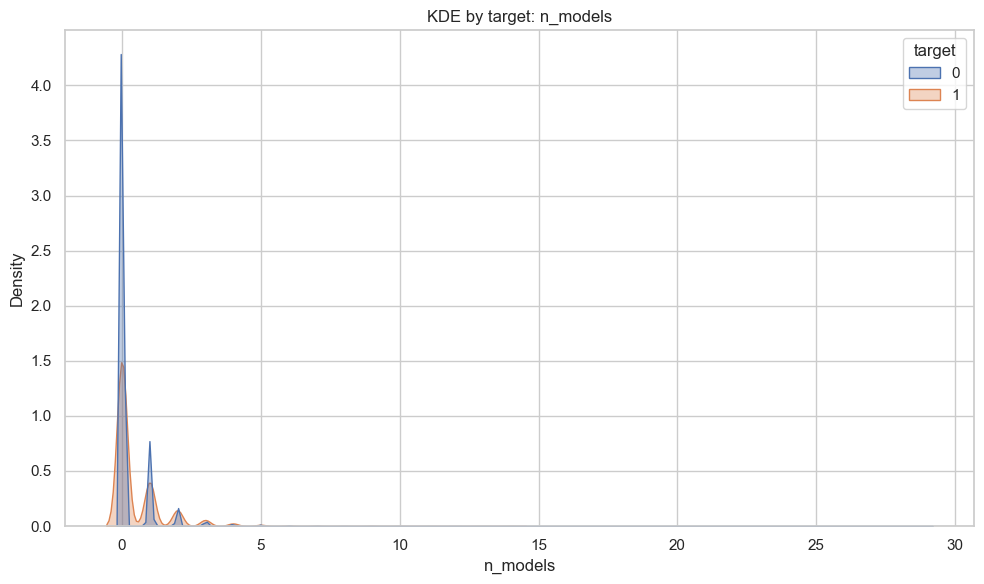

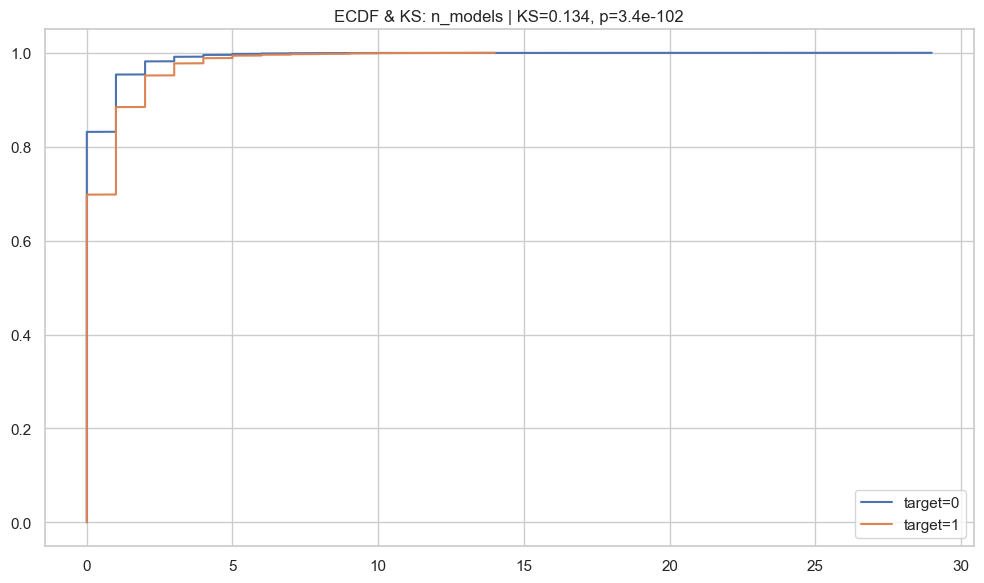

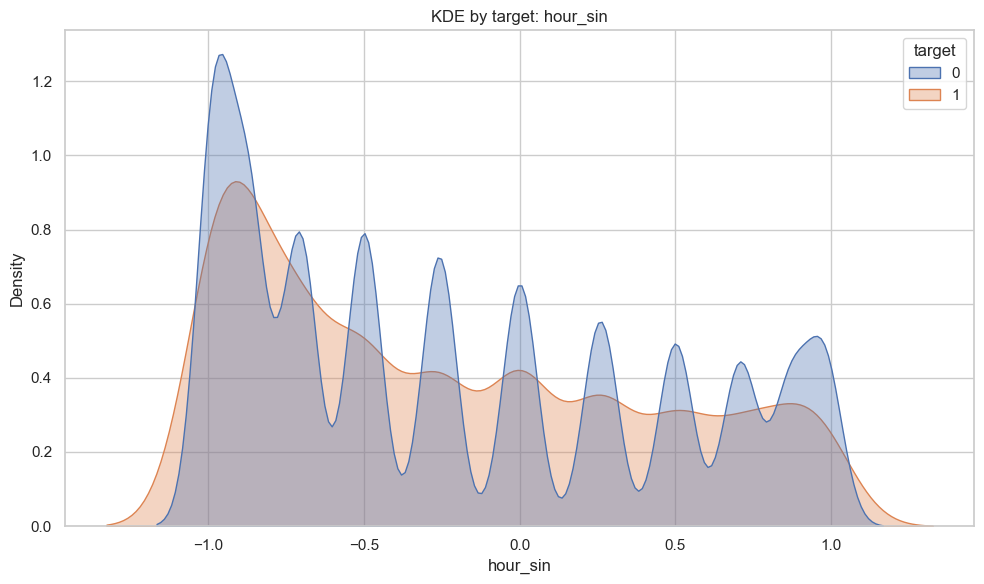

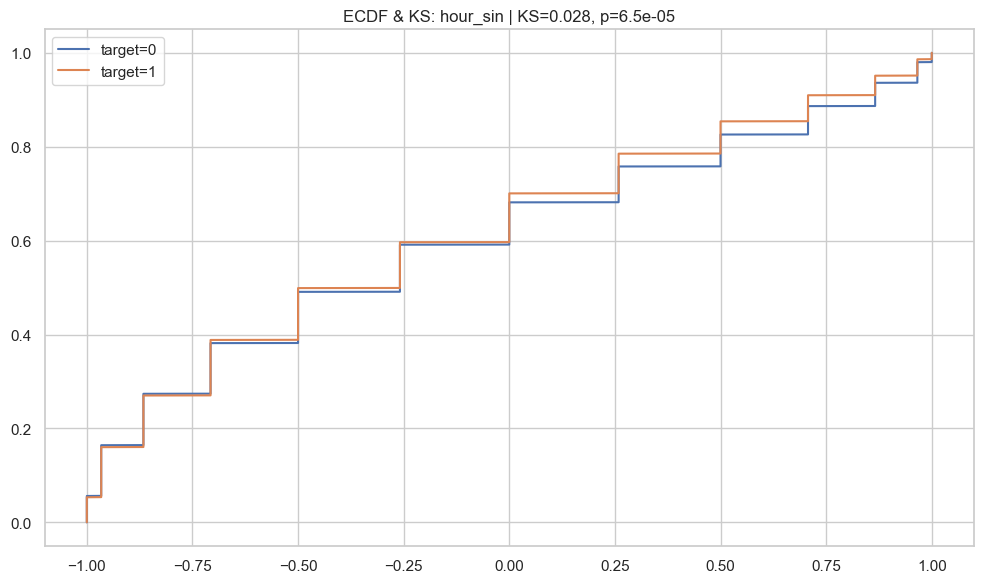

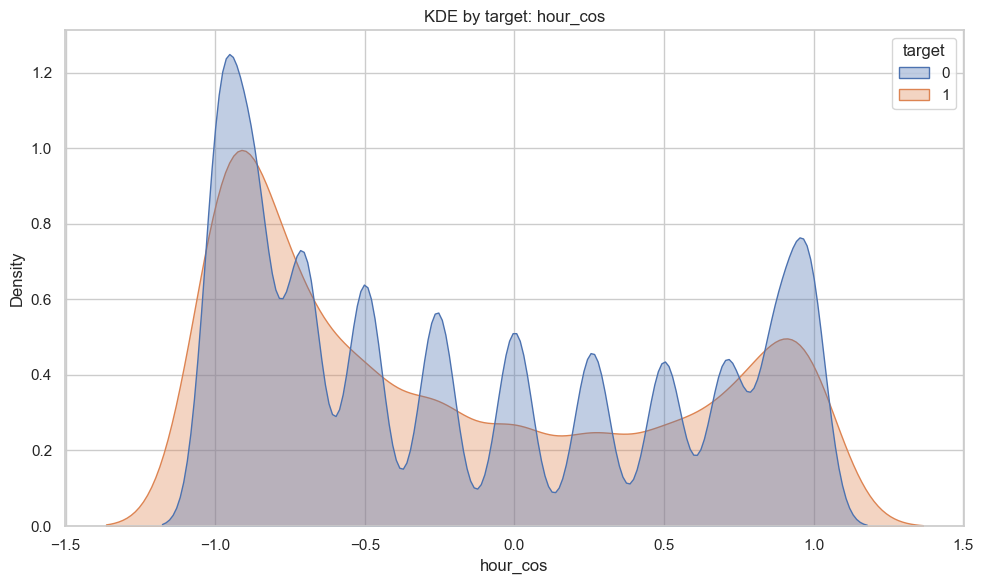

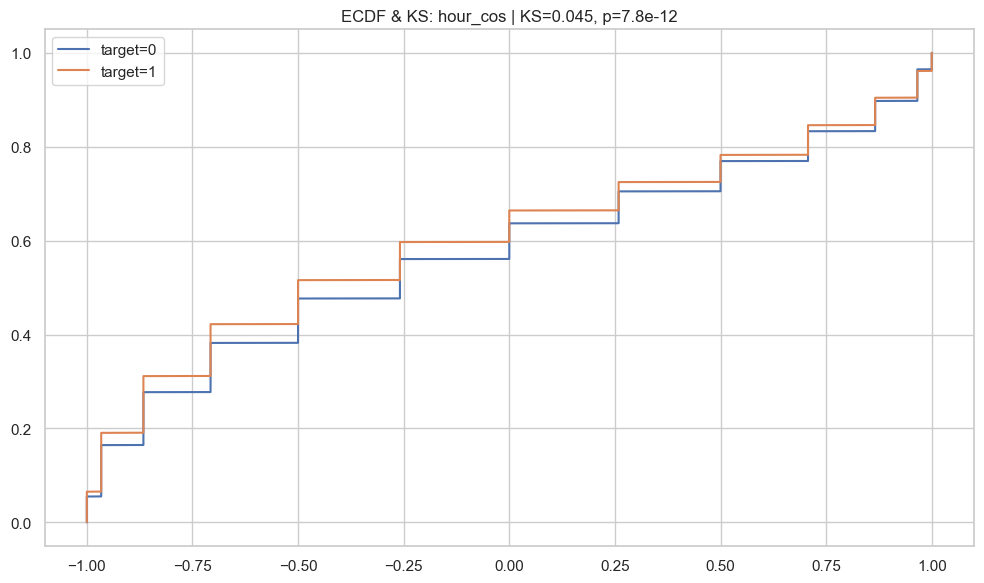

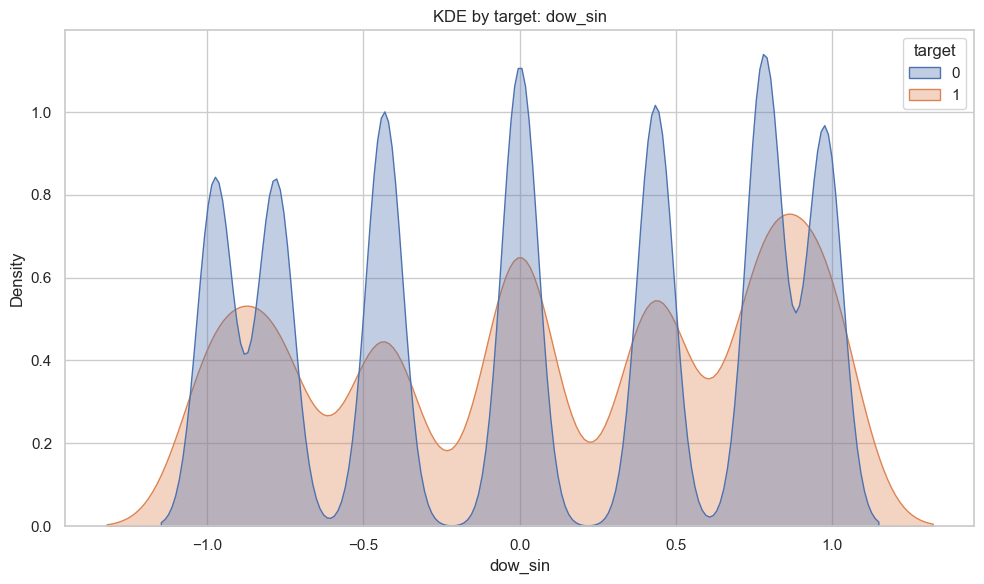

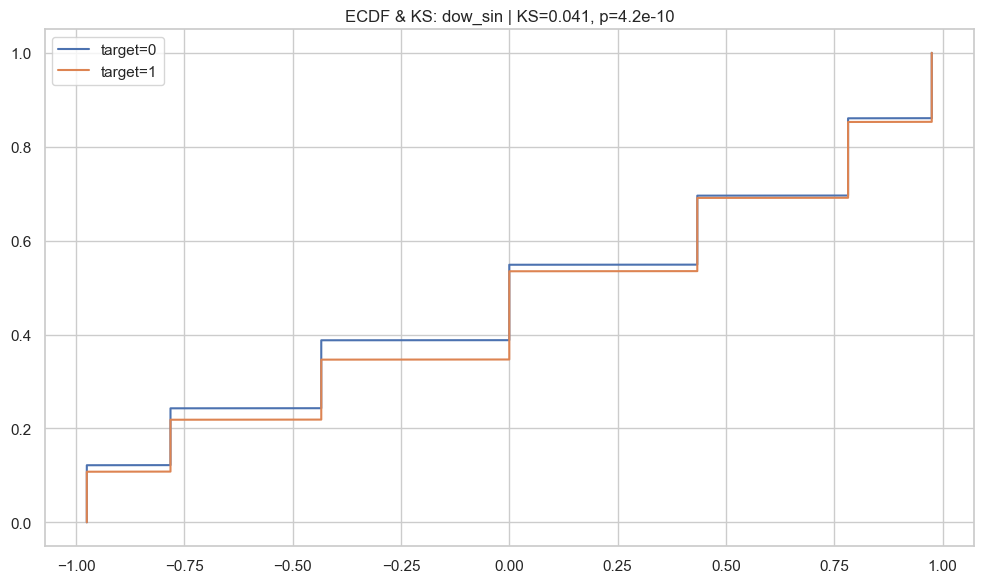

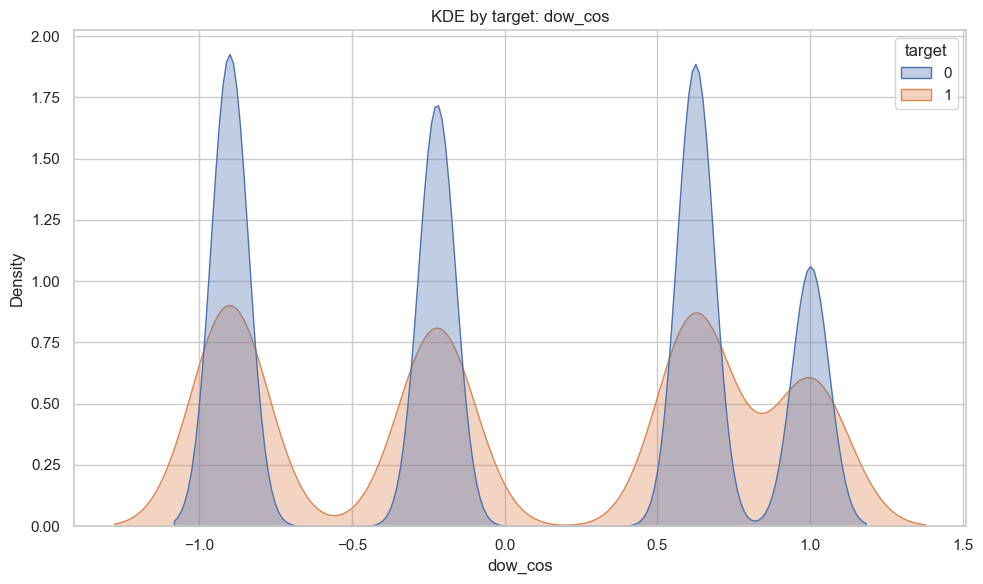

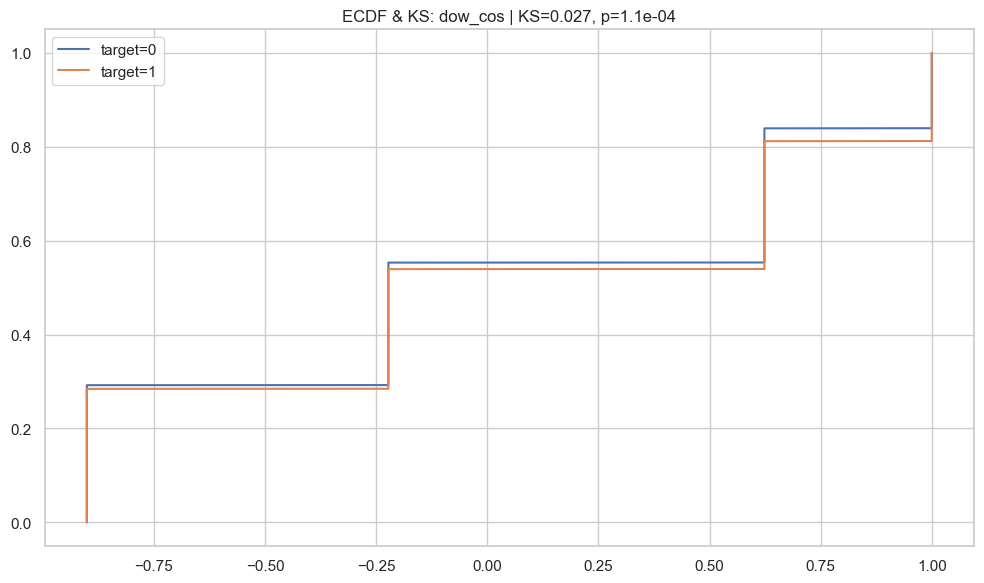

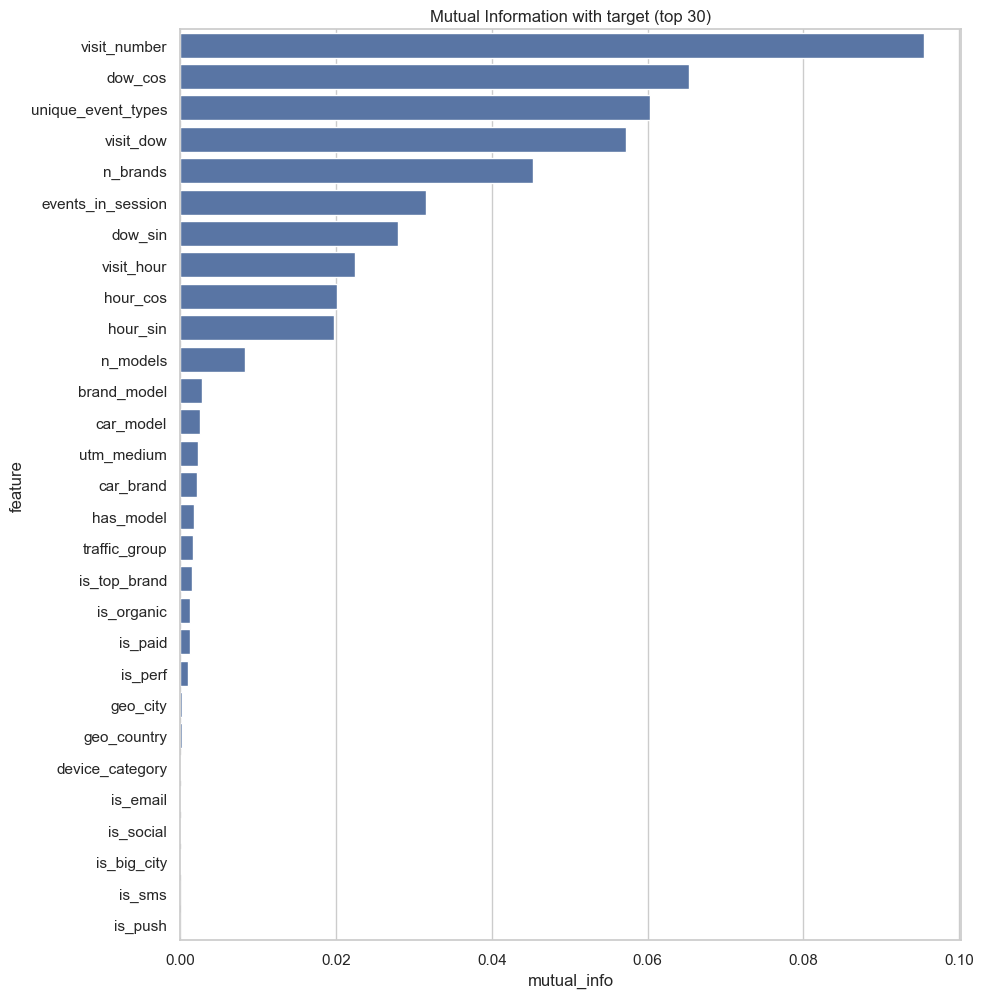

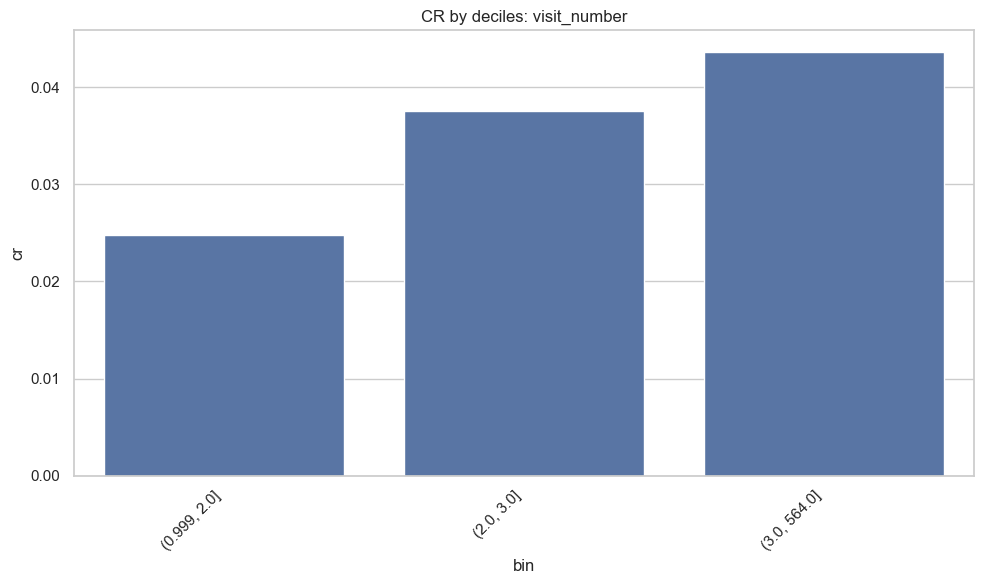

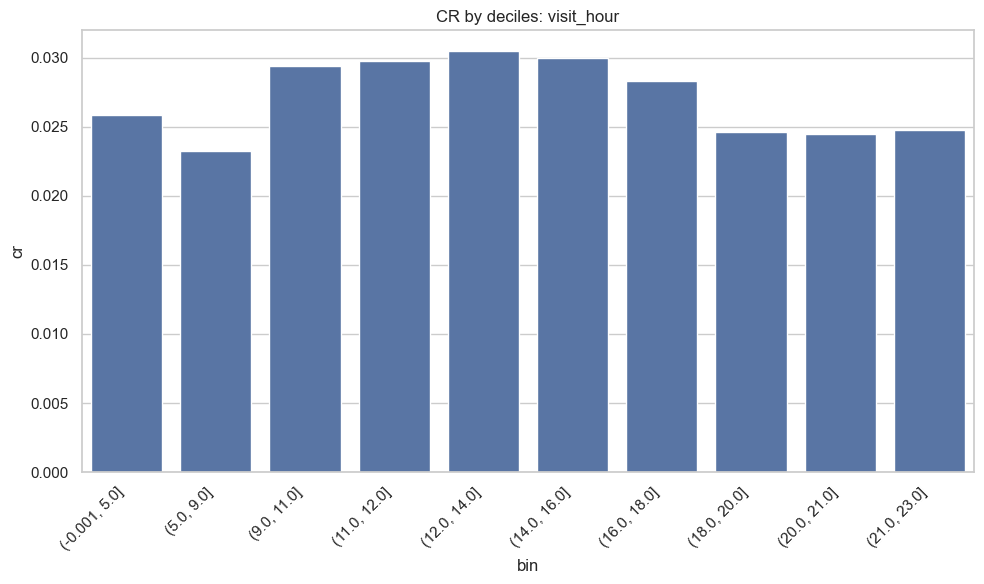

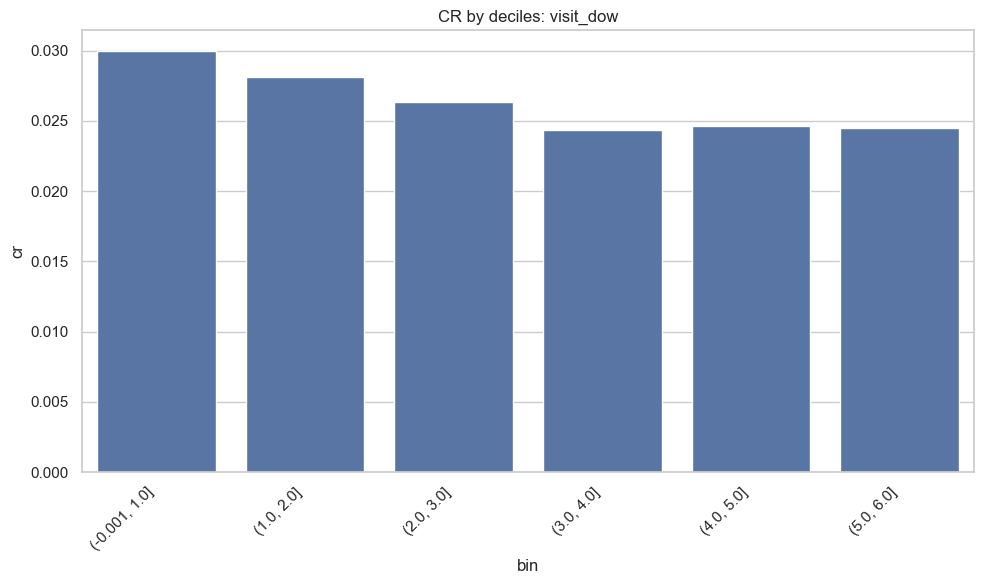

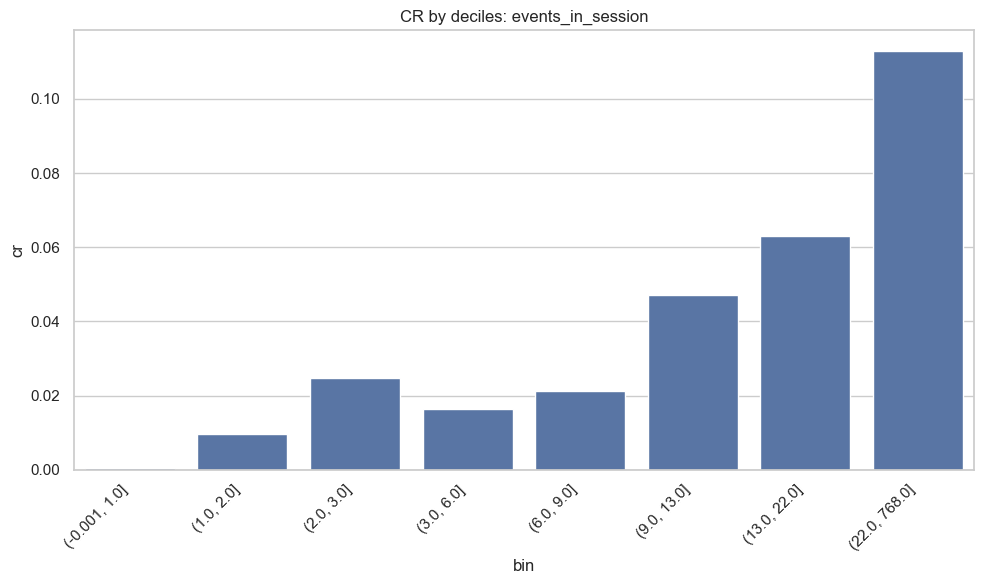

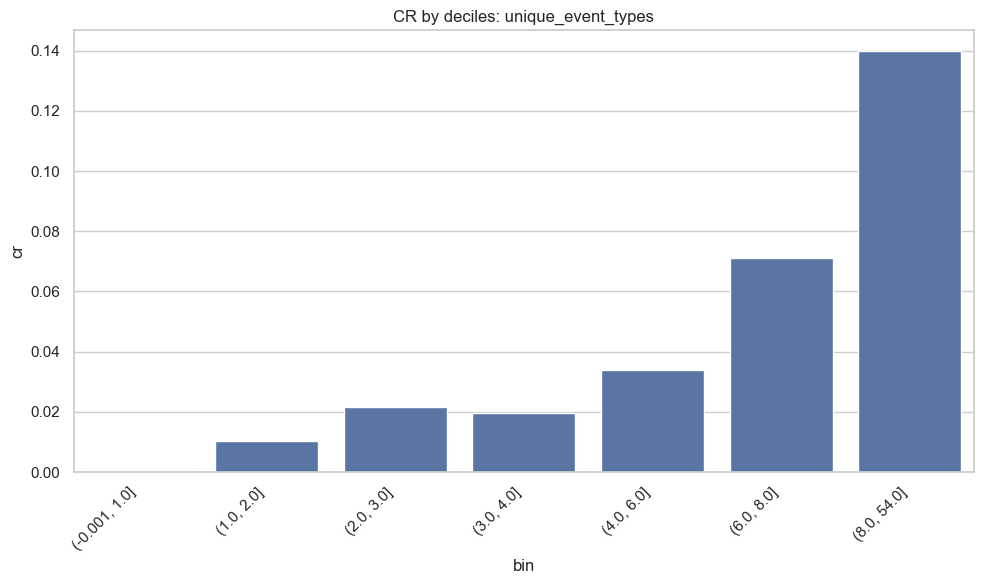

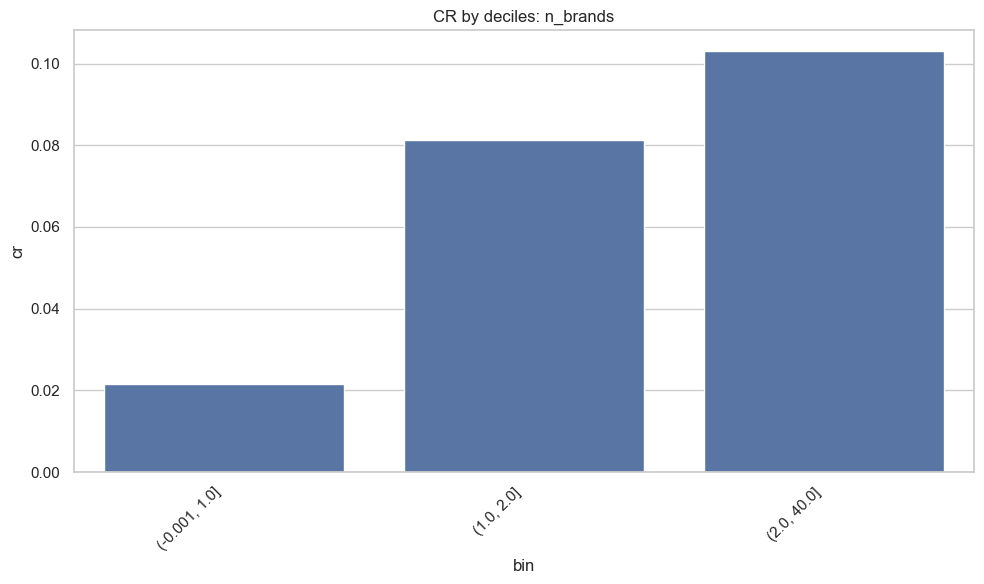

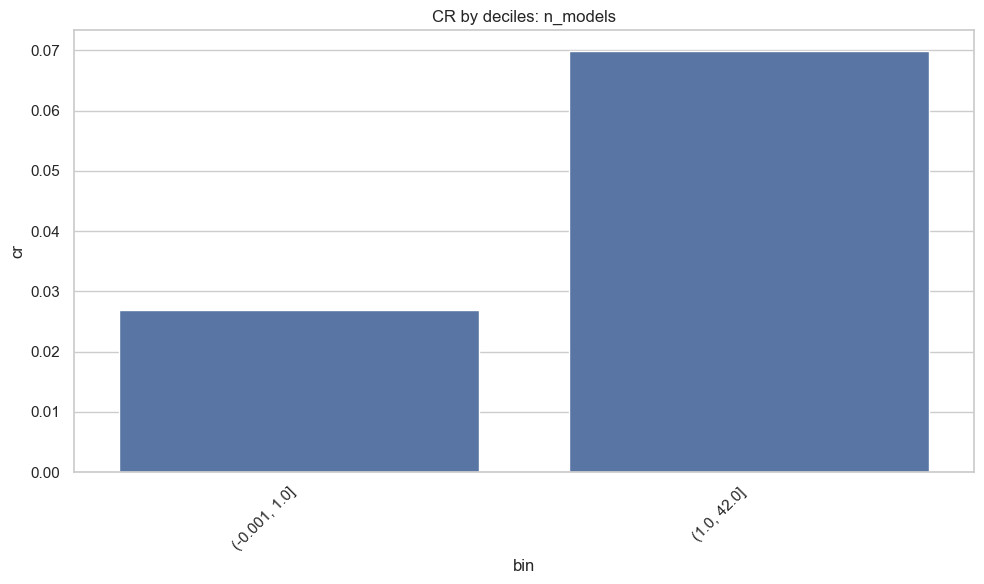

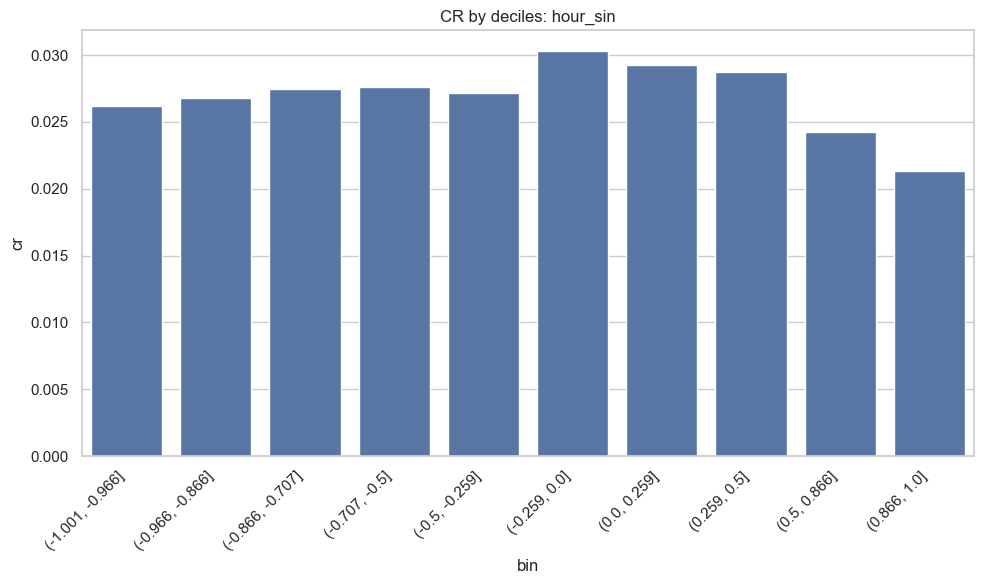

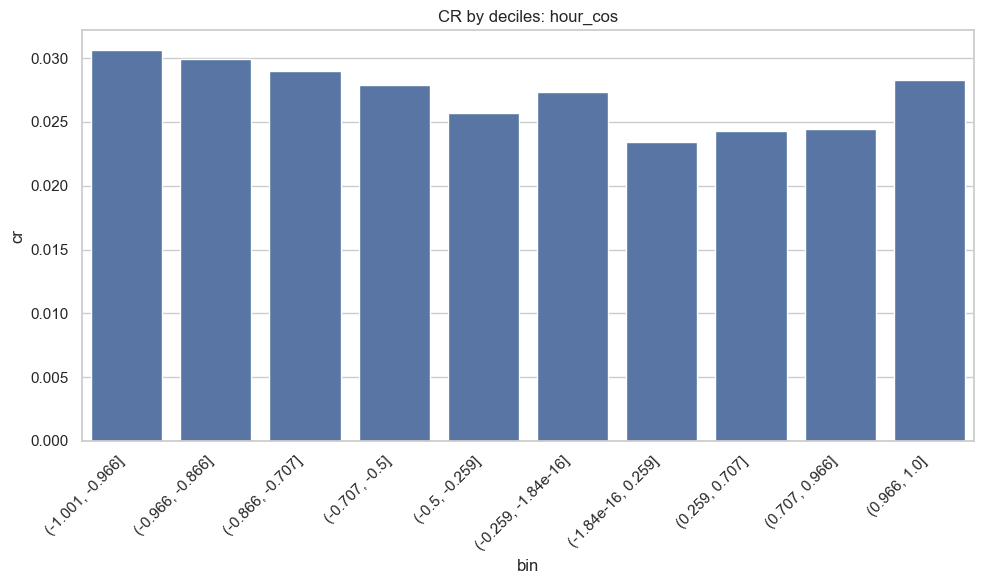

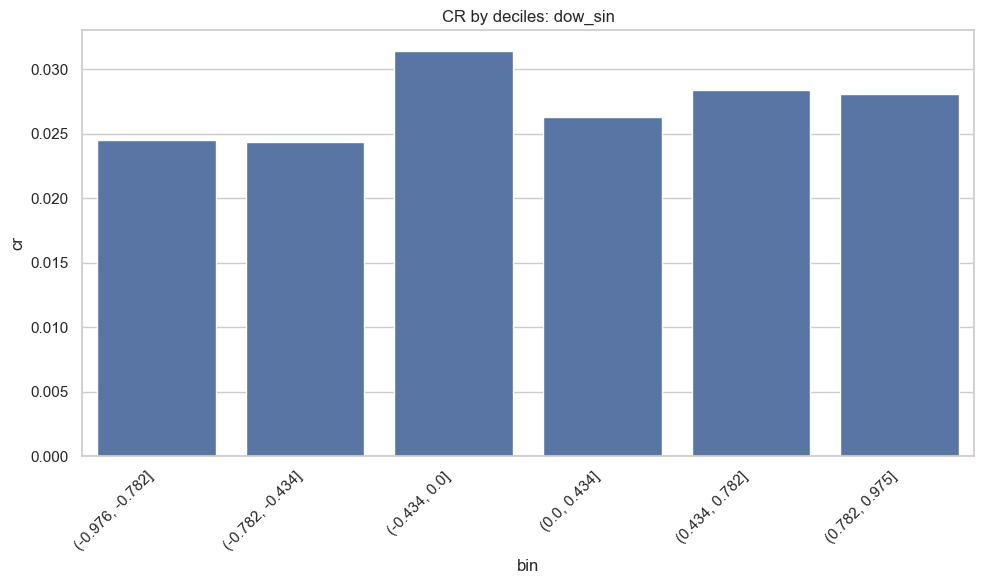

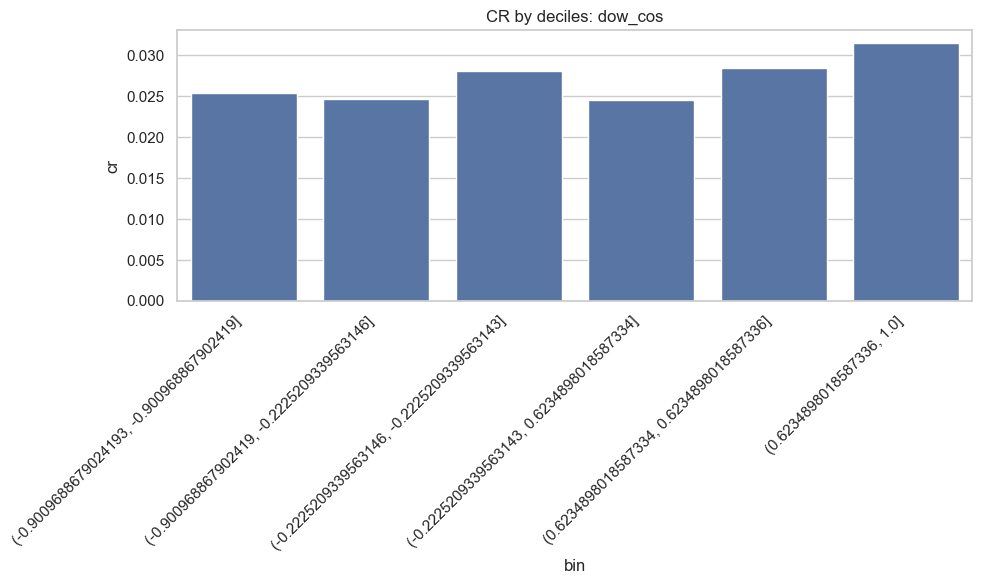

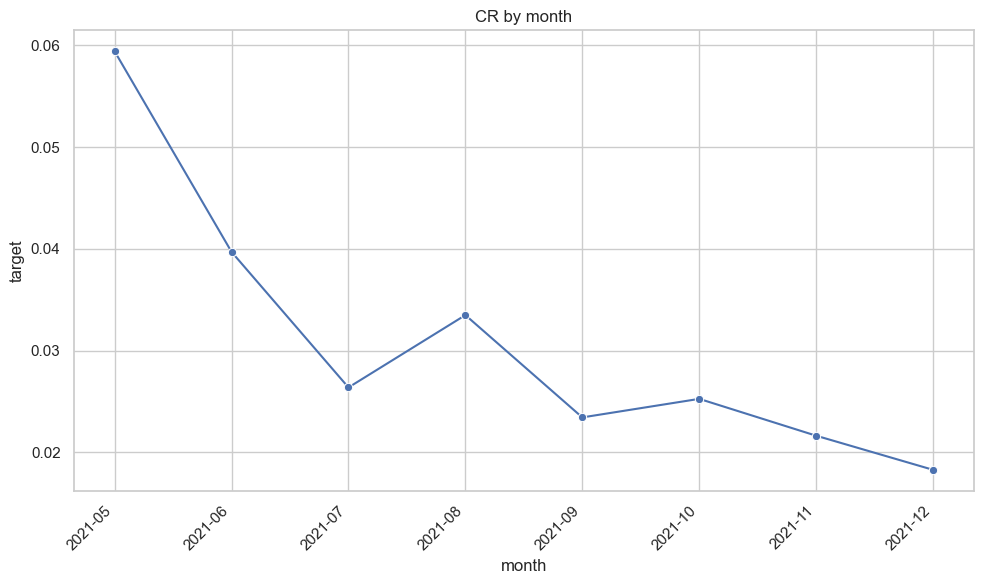

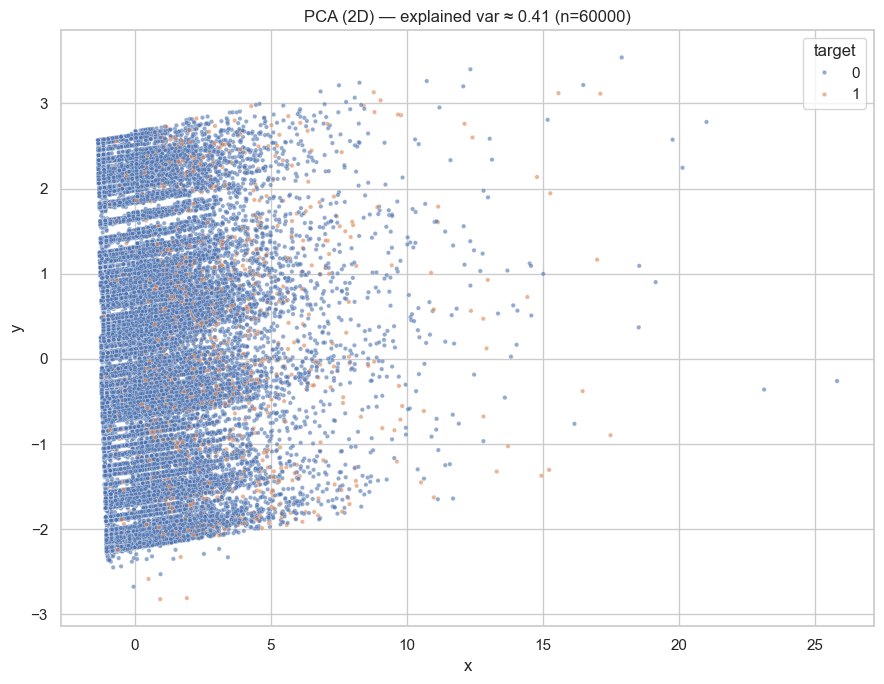

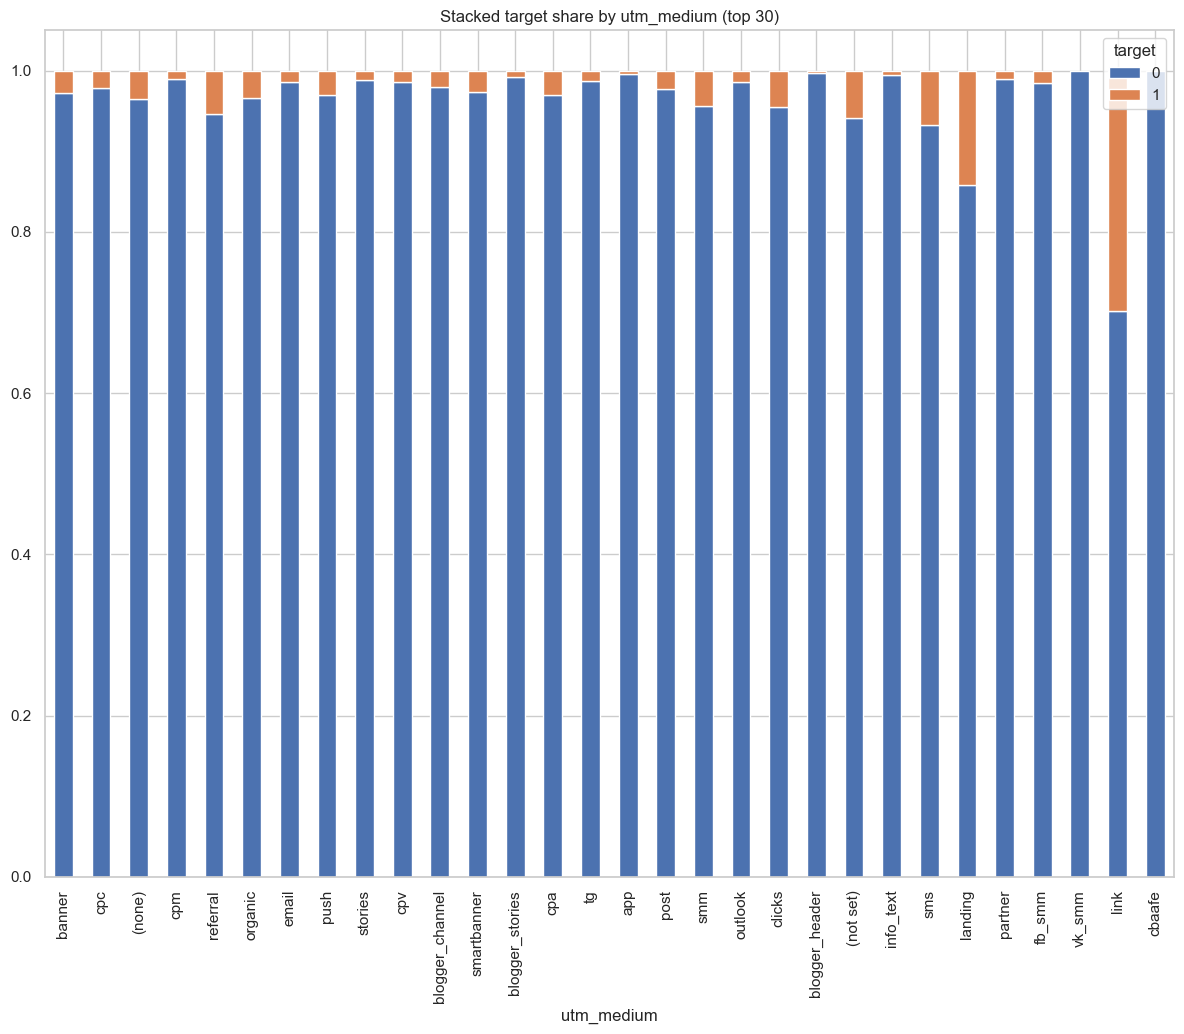

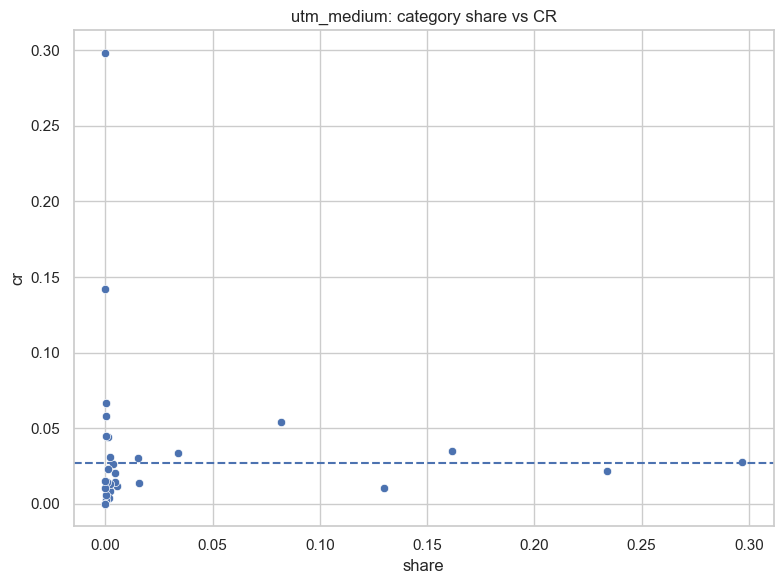

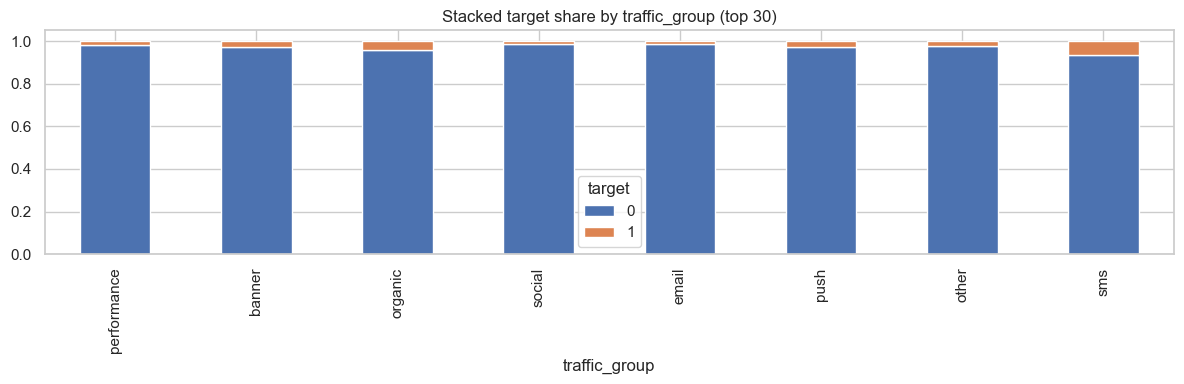

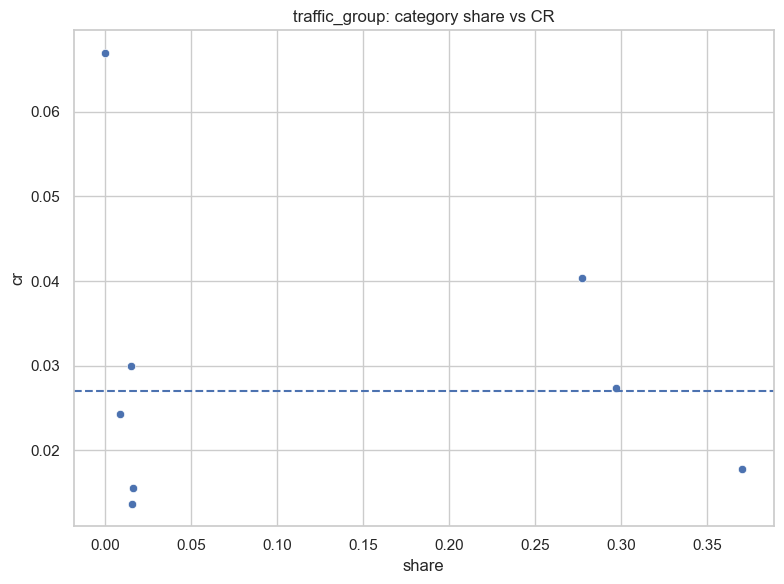

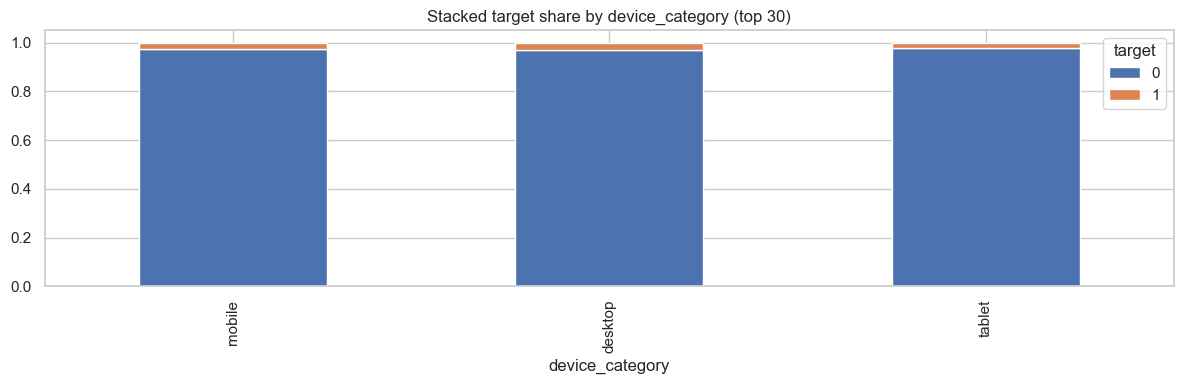

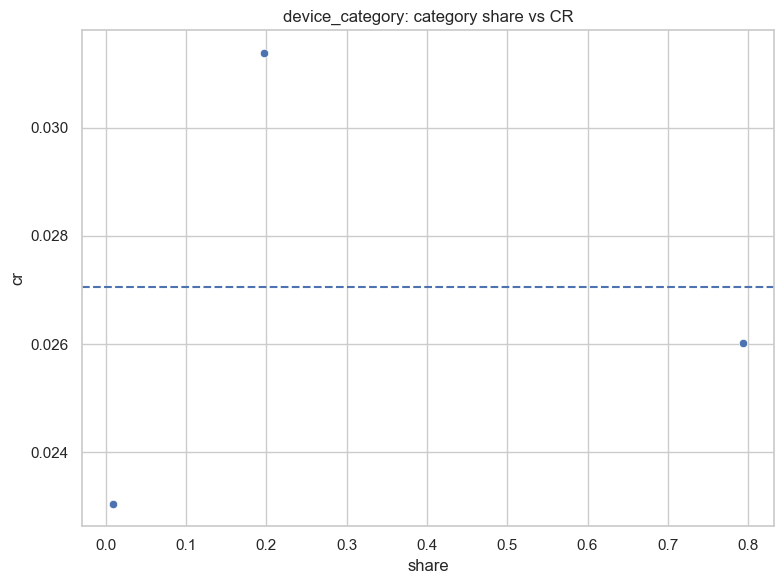

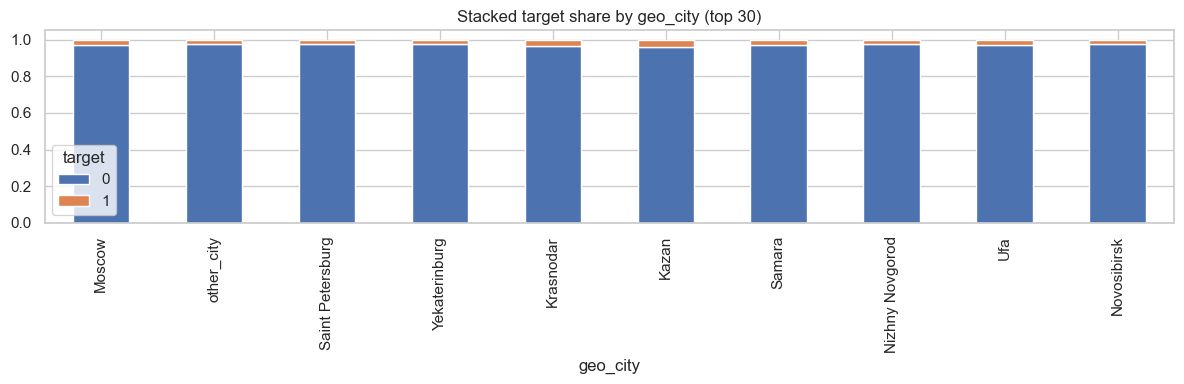

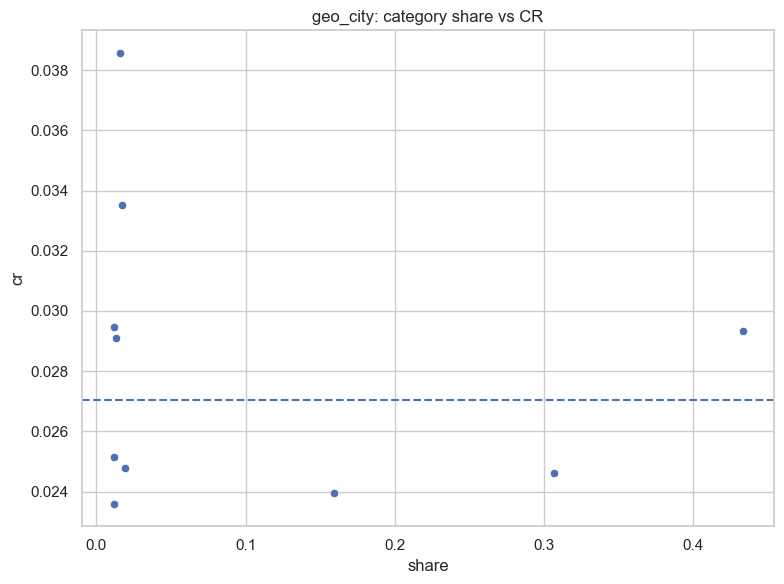

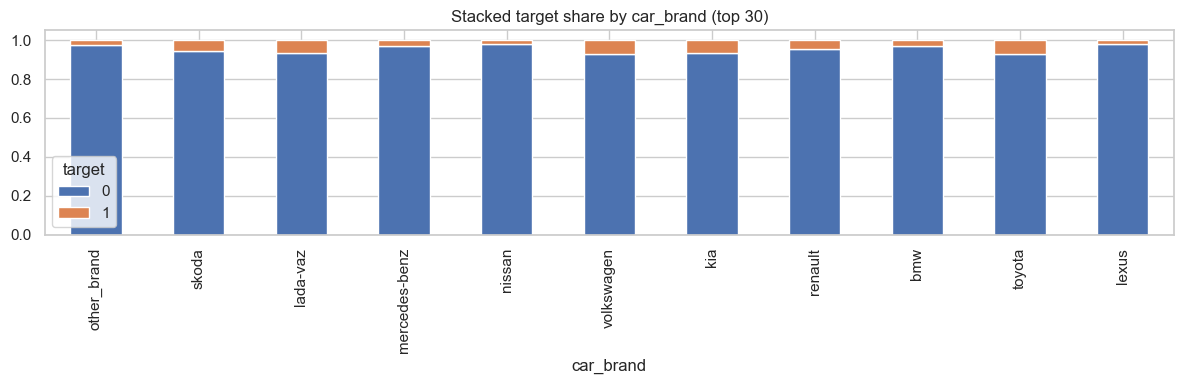

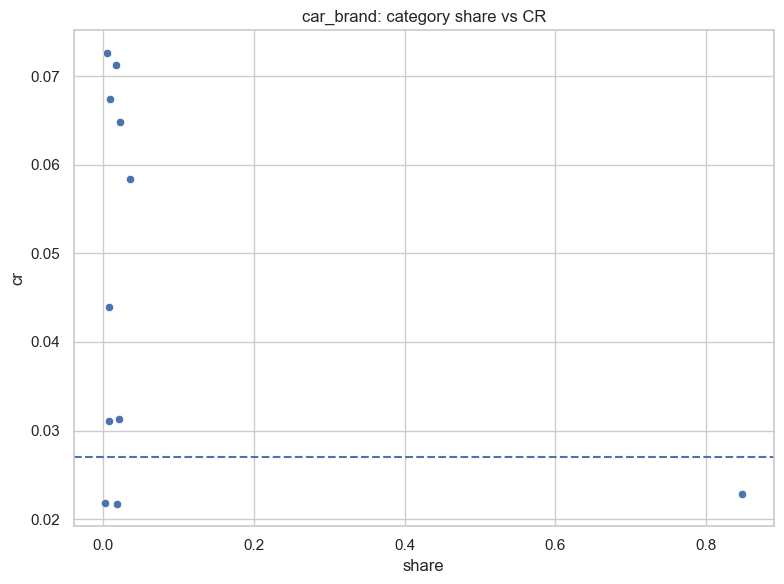

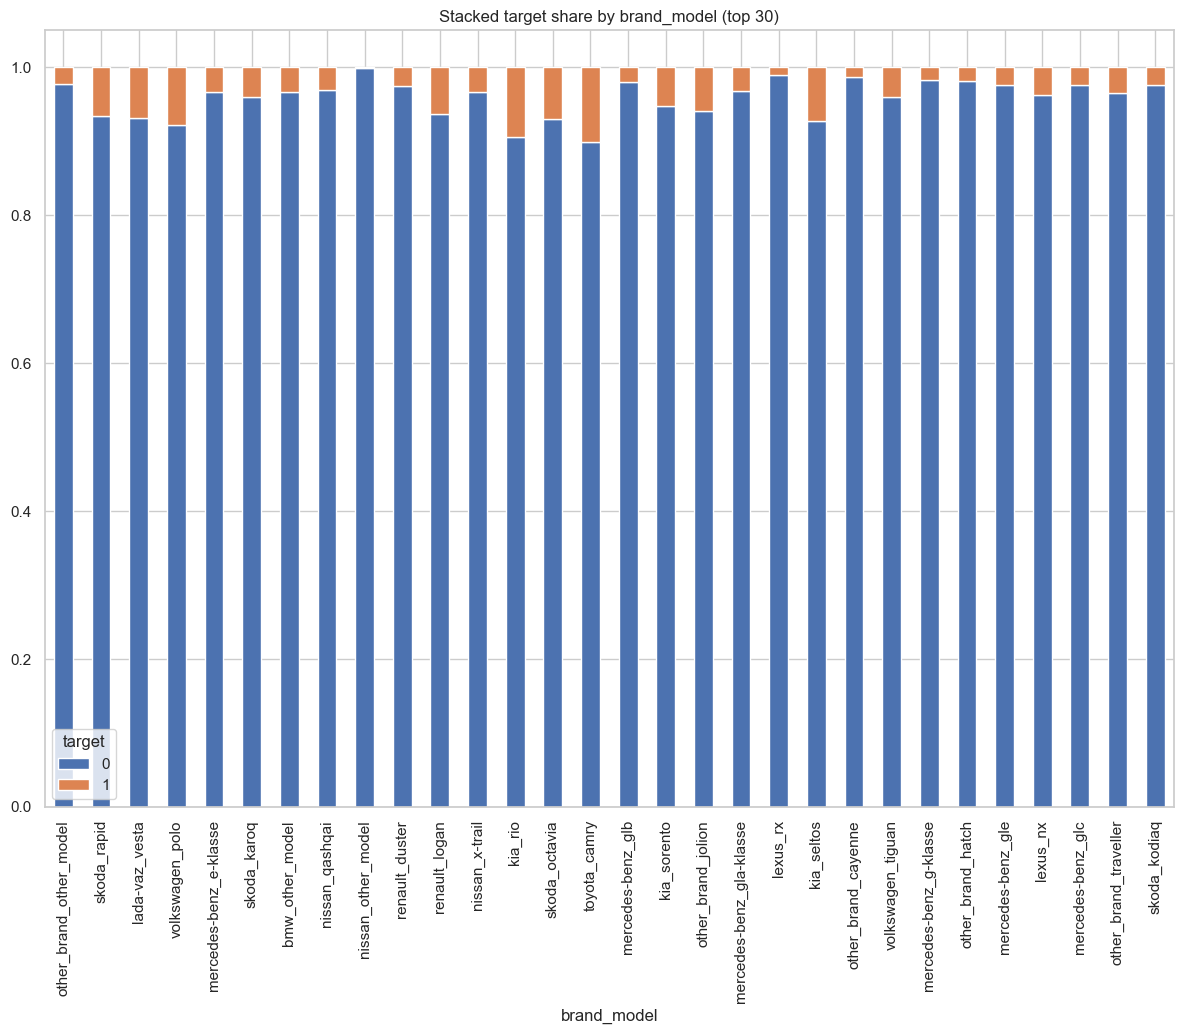

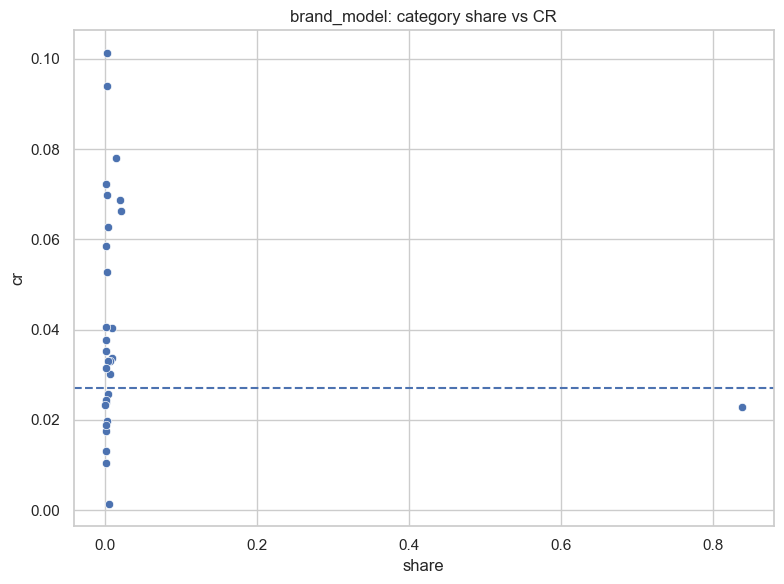

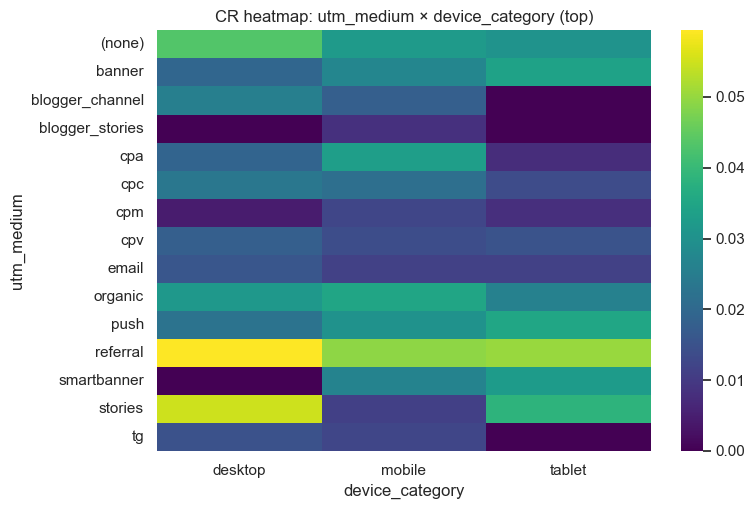

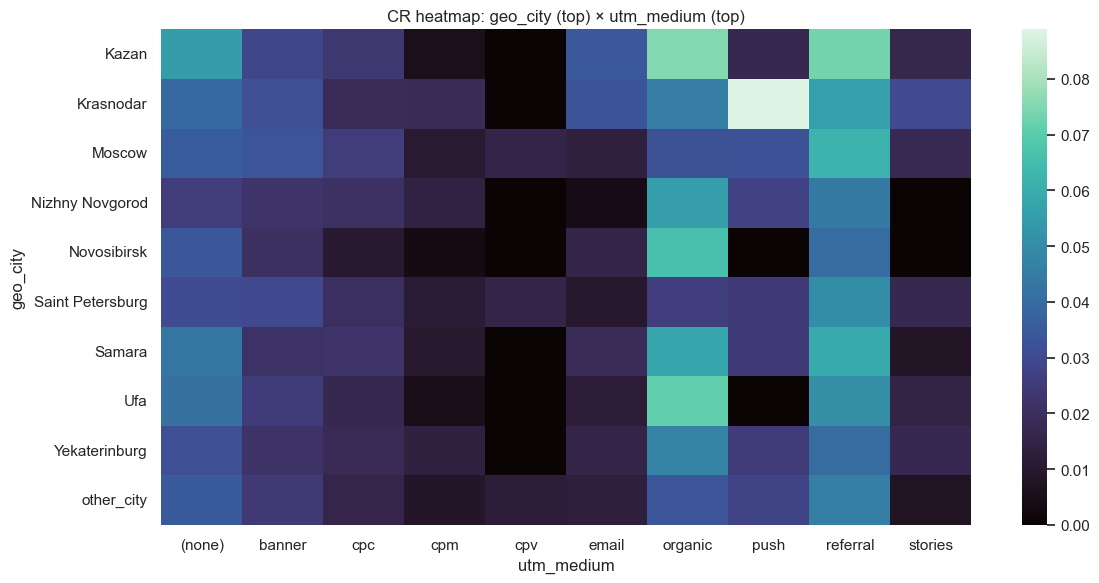

EXTRA EDA готов. Все артефакты → D:\ML\LS\final\final_project\artifacts\eda


In [69]:
SHOW = True  # показывать графики в ноутбуке

# Если visit_datetime строковый — приведём к datetime 
if "visit_datetime" in df.columns and not np.issubdtype(df["visit_datetime"].dtype, np.datetime64):
    df["visit_datetime"] = pd.to_datetime(df["visit_datetime"], errors="coerce")

def savefig_show(path, fig=None):
    fig = fig or plt.gcf()
    fig.tight_layout()
    fig.savefig(path, bbox_inches="tight", dpi=150)
    if SHOW:
        plt.show()
    plt.close(fig)

def wilson_ci(p, n, z=1.96):
    denom = 1 + z**2/n
    center = (p + z**2/(2*n))/denom
    half = z*np.sqrt((p*(1-p)/n) + (z**2/(4*n**2)))/denom
    return max(0.0, center - half), min(1.0, center + half)

# Колонки (синхронизированы с базовым EDA)
num_cols = [
    "visit_number","visit_hour","visit_dow","events_in_session","unique_event_types",
    "n_brands","n_models","hour_sin","hour_cos","dow_sin","dow_cos"
]
num_cols = [c for c in num_cols if c in df.columns]

cat_cols = [
    "utm_medium","device_category","geo_country","geo_city","traffic_group",
    "is_social","is_email","is_push","is_sms","is_perf",
    "car_brand","car_model","brand_model","is_top_brand","has_model","is_big_city","is_organic","is_paid"
]
cat_cols = [c for c in cat_cols if c in df.columns]

# KDE + ECDF/KS по target для числовых
if len(num_cols) > 0:
    NUM_KDE_SAMPLE = 250_000
    use_cols = [c for c in num_cols if c in df.columns] + ["target"]
    sub_kde = df[use_cols].sample(NUM_KDE_SAMPLE, random_state=SEED) if len(df) > NUM_KDE_SAMPLE else df[use_cols].copy()

    for col in num_cols:
        # KDE
        fig, ax = plt.subplots()
        sns.kdeplot(data=sub_kde, x=col, hue="target", common_norm=False, fill=True, alpha=0.35, ax=ax)
        ax.set_title(f"KDE by target: {col}")
        savefig_show(OUTPUT_DIR / f"kde__{col}.png", fig)

        # ECDF + KS
        def ecdf(x):
            x = np.sort(x)
            y = np.arange(1, len(x)+1)/len(x)
            return x, y
        a = sub_kde.loc[sub_kde["target"]==0, col].dropna().values
        b = sub_kde.loc[sub_kde["target"]==1, col].dropna().values
        if len(a) > 50 and len(b) > 50:
            ks = ks_2samp(a, b)
            xa, ya = ecdf(a); xb, yb = ecdf(b)
            fig, ax = plt.subplots()
            ax.plot(xa, ya, label="target=0")
            ax.plot(xb, yb, label="target=1")
            ax.set_title(f"ECDF & KS: {col} | KS={ks.statistic:.3f}, p={ks.pvalue:.1e}")
            ax.legend()
            savefig_show(OUTPUT_DIR / f"ecdf_ks__{col}.png", fig)

# Взаимная информация (MI) с target — robust
encoders = {}
X_mi = pd.DataFrame(index=df.index)

# числовые — float (coerce), NaN/Inf → NaN
for c in num_cols:
    X_mi[c] = pd.to_numeric(df[c], errors="coerce")

# категориальные — LabelEncoder с явной меткой для NaN
for c in cat_cols:
    le = LabelEncoder()
    X_mi[c] = le.fit_transform(df[c].astype(str).fillna("__nan__"))
    encoders[c] = le

# чистим инфы и импутим числовые медианой
X_mi = X_mi.replace([np.inf, -np.inf], np.nan)
num_mask = X_mi.columns.isin(num_cols)
if num_mask.any():
    imputer = SimpleImputer(strategy="median")
    X_mi.loc[:, num_mask] = imputer.fit_transform(X_mi.loc[:, num_mask])

# выкидываем константные признаки
var = X_mi.var(axis=0, numeric_only=False)
const_cols = var.index[var.fillna(0) == 0].tolist()
if const_cols:
    X_mi = X_mi.drop(columns=const_cols)

# маска дискретных после дропа
discrete_features_mask = np.array([c in cat_cols for c in X_mi.columns], dtype=bool)
y = df["target"].astype(int).values

mi_scores = mutual_info_classif(
    X_mi.values, y,
    discrete_features=discrete_features_mask,
    random_state=SEED
)
mi_df = (
    pd.DataFrame({"feature": X_mi.columns, "mutual_info": mi_scores})
      .sort_values("mutual_info", ascending=False)
)
pd.Series(const_cols).to_csv(OUTPUT_DIR / "mi_dropped_constant_features.csv", index=False, header=False)
mi_df.to_csv(OUTPUT_DIR / "mutual_info_scores.csv", index=False)

fig = plt.figure(figsize=(10, min(12, 0.35*len(mi_df))))
sns.barplot(data=mi_df.head(30), x="mutual_info", y="feature")
plt.title("Mutual Information with target (top 30)")
savefig_show(OUTPUT_DIR / "mutual_info_top30.png", fig)

# Корреляционное отношение (η) для cat->num
def correlation_ratio(categories, measurements):
    cat = pd.Categorical(categories)
    groups = [measurements[cat.codes == i] for i in range(cat.categories.size)]
    n_total = len(measurements)
    if n_total == 0:
        return np.nan
    grand_mean = np.nanmean(measurements)
    ss_between = np.nansum([len(g)*(np.nanmean(g)-grand_mean)**2 for g in groups if len(g)>0])
    ss_total = np.nansum((measurements - grand_mean)**2)
    return np.sqrt(ss_between / ss_total) if ss_total > 0 else np.nan

eta_rows = []
for c_cat in cat_cols:
    for c_num in num_cols:
        val = correlation_ratio(df[c_cat].astype(str), pd.to_numeric(df[c_num], errors="coerce"))
        eta_rows.append((c_cat, c_num, val))
eta_df = pd.DataFrame(eta_rows, columns=["cat_feature","num_feature","eta"]).dropna().sort_values("eta", ascending=False)
eta_df.to_csv(OUTPUT_DIR / "eta_cat_to_num.csv", index=False)

# Децили CR для числовых (биннинг)
DECILES = 10
for col in num_cols:
    try:
        tmp = df[[col, "target"]].copy()
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
        tmp = tmp.dropna()
        if tmp[col].nunique() > 1:
            tmp["bin"] = pd.qcut(tmp[col], q=DECILES, duplicates="drop")
            g = tmp.groupby("bin").agg(n=("target","size"), cr=("target","mean")).reset_index()
            g.to_csv(OUTPUT_DIR / f"deciles__{col}.csv", index=False)
            fig, ax1 = plt.subplots()
            sns.barplot(data=g, x="bin", y="cr", ax=ax1)
            ax1.set_title(f"CR by deciles: {col}")
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
            savefig_show(OUTPUT_DIR / f"deciles_cr__{col}.png", fig)
    except Exception:
        pass

# Monthly drift (до сплита): PSI-lite и CR по месяцам
def psi_bucketed(a, b, buckets=10):
    a = pd.Series(a).dropna()
    b = pd.Series(b).dropna()
    if len(a)==0 or len(b)==0:
        return np.nan
    qs = np.linspace(0, 1, buckets+1)
    cuts = a.quantile(qs).unique()
    a_bins = pd.cut(a, bins=np.unique(cuts), include_lowest=True)
    b_bins = pd.cut(b, bins=np.unique(cuts), include_lowest=True)
    a_pct = a_bins.value_counts(normalize=True, sort=False)
    b_pct = b_bins.value_counts(normalize=True, sort=False).reindex(a_pct.index).fillna(0.0)
    psi = np.sum((a_pct - b_pct) * np.log((a_pct + 1e-12)/(b_pct + 1e-12)))
    return float(psi)

if "visit_datetime" in df.columns:
    monthly = df.set_index("visit_datetime").copy()
    monthly["month"] = monthly.index.to_period("M").astype(str)
    months = sorted(monthly["month"].unique())

    psi_rows = []
    if len(months) >= 2 and len(num_cols) > 0:
        base = monthly.query("month == @months[0]")
        for m in months[1:]:
            cur = monthly.query("month == @m")
            for col in num_cols:
                psi_val = psi_bucketed(pd.to_numeric(base[col], errors="coerce"),
                                       pd.to_numeric(cur[col], errors="coerce"))
                psi_rows.append((m, col, psi_val))
        psi_df = pd.DataFrame(psi_rows, columns=["month","feature","psi_vs_first"]).sort_values(["feature","month"])
        psi_df.to_csv(OUTPUT_DIR / "monthly_psi_numeric.csv", index=False)

    fig, ax = plt.subplots()
    cr_m = monthly.groupby("month")["target"].mean().reset_index()
    sns.lineplot(data=cr_m, x="month", y="target", marker="o", ax=ax)
    plt.xticks(rotation=45, ha="right")
    plt.title("CR by month")
    savefig_show(OUTPUT_DIR / "cr_by_month.png", fig)

# PCA scatter : глобальная структура числовых
PCA_SAMPLE = 60_000
pca_num_cols = [c for c in num_cols if c != "target"]
if len(pca_num_cols) >= 2:
    # чистим только под PCA
    pca_df_raw = df[pca_num_cols + ["target"]].copy()
    for c in pca_num_cols:
        pca_df_raw[c] = pd.to_numeric(pca_df_raw[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    pca_df_clean = pca_df_raw.dropna(subset=pca_num_cols)
    if len(pca_df_clean) >= 10:
        pca_sample = pca_df_clean.sample(min(PCA_SAMPLE, len(pca_df_clean)), random_state=SEED)
        X = pca_sample[pca_num_cols].values.astype(np.float32)
        X = StandardScaler().fit_transform(X)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        pca = PCA(n_components=2, random_state=SEED)
        emb = pca.fit_transform(X)
        pca_plot = pd.DataFrame({"x": emb[:,0], "y": emb[:,1], "target": pca_sample["target"].values})
        fig, ax = plt.subplots(figsize=(9,7))
        sns.scatterplot(data=pca_plot, x="x", y="y", hue="target", s=10, alpha=0.6, ax=ax)
        var = float(pca.explained_variance_ratio_.sum())
        ax.set_title(f"PCA (2D) — explained var ≈ {var:.2f} (n={len(pca_sample)})")
        savefig_show(OUTPUT_DIR / "pca_numeric.png", fig)
        pca_plot.to_csv(OUTPUT_DIR / "pca_embedding.csv", index=False)
    else:
        print("PCA пропущен: слишком мало строк без пропусков после очистки.")

# Категориальные: топ-N, CR + Wilson CI, стек-бар и scatter(share vs CR)
TOPN = 30
GLOBAL_CR = df["target"].mean()
summary_rows = []

def cat_cr_with_ci(data, col, topn=TOPN):
    vc = data[col].value_counts().head(topn)
    rows = []
    for v, n in vc.items():
        sub = data[data[col] == v]["target"]
        p = sub.mean()
        lo, hi = wilson_ci(p, len(sub))
        rows.append({"value": v, "n": int(len(sub)), "cr": float(p), "ci_lo": lo, "ci_hi": hi, "delta_vs_global": float(p - GLOBAL_CR)})
    tbl = pd.DataFrame(rows).sort_values("cr", ascending=False)
    tbl.to_csv(OUTPUT_DIR / f"cat_cr__{col}.csv", index=False)

    # стек-бар: доля 1/0
    plot_df = data[data[col].isin(vc.index)].copy()
    agg = plot_df.groupby(col)["target"].value_counts(normalize=True).rename("share").reset_index()
    pivot = agg.pivot(index=col, columns="target", values="share").fillna(0)
    pivot = pivot.loc[vc.index]  # порядок как в топ-списке
    fig, ax = plt.subplots(figsize=(12, max(4, 0.35*len(pivot))))
    pivot.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(f"Stacked target share by {col} (top {topn})")
    ax.legend(title="target")
    savefig_show(OUTPUT_DIR / f"stacked_target__{col}.png", fig)

    # scatter: доля категории vs её CR
    share = (data[col].value_counts()/len(data)).rename("share").reset_index().rename(columns={"index": col})
    merged = share.merge(tbl[["value","cr"]], left_on=col, right_on="value", how="left")
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(data=merged.dropna(), x="share", y="cr", ax=ax)
    ax.axhline(GLOBAL_CR, ls="--")
    ax.set_title(f"{col}: category share vs CR")
    savefig_show(OUTPUT_DIR / f"share_vs_cr__{col}.png", fig)
    return tbl

for col in ["utm_medium","traffic_group","device_category","geo_city","car_brand","brand_model"]:
    if col in df.columns:
        tbl = cat_cr_with_ci(df, col)
        tbl["feature"] = col
        summary_rows.append(tbl)

if summary_rows:
    pd.concat(summary_rows, ignore_index=True).to_csv(OUTPUT_DIR / "cat_cr_summary_top.csv", index=False)

# Комбинации top-K: heatmaps по CR
if {"utm_medium","device_category"}.issubset(df.columns):
    top_u = df["utm_medium"].value_counts().head(15).index
    top_d = df["device_category"].value_counts().index  # обычно 3 категории
    sub = df[df["utm_medium"].isin(top_u) & df["device_category"].isin(top_d)]
    cr = sub.groupby(["utm_medium","device_category"])["target"].mean().reset_index()
    pivot = cr.pivot(index="utm_medium", columns="device_category", values="target")
    fig, ax = plt.subplots(figsize=(8, max(4, 0.35*len(pivot))))
    sns.heatmap(pivot, cmap="viridis", annot=False, ax=ax)
    ax.set_title("CR heatmap: utm_medium × device_category (top)")
    savefig_show(OUTPUT_DIR / "cr_heatmap__utm_medium__device_category_top.png", fig)

if {"utm_medium","geo_city"}.issubset(df.columns):
    top_u = df["utm_medium"].value_counts().head(10).index
    top_c = df["geo_city"].value_counts().head(30).index
    sub = df[df["utm_medium"].isin(top_u) & df["geo_city"].isin(top_c)]
    cr = sub.groupby(["geo_city","utm_medium"])["target"].mean().reset_index()
    pivot = cr.pivot(index="geo_city", columns="utm_medium", values="target").fillna(0)
    fig, ax = plt.subplots(figsize=(12, max(6, 0.25*len(pivot))))
    sns.heatmap(pivot, cmap="mako", ax=ax)
    ax.set_title("CR heatmap: geo_city (top) × utm_medium (top)")
    savefig_show(OUTPUT_DIR / "cr_heatmap__geo_city__utm_medium_top.png", fig)

print("EXTRA EDA готов. Все артефакты →", OUTPUT_DIR)

## Итоги EDA

### База и цель. 
Конверсия низкая и несбалансированная — по графикам со средними пунктирными линиями ≈ 2.6–2.8%. Явного «идеального» разделения классов нет: и PCA 2D (объяснённая дисперсия ≈0.41) и t-SNE показывают сильное пересечение классов — нужна нелинейная модель.

### Что сильнее всего связано с таргетом

#### По ECDF/KS и взаимной информации:

unique_event_types — самый «сильный» числовой признак: KS ≈ 0.55, p≈0, высокий MI. У конвертящих сессий разнообразие событий заметно выше.

n_brands — сильный: KS ≈ 0.43, p≈0. Конверсия растёт, когда в сессии смотрят больше брендов.

visit_number — умеренно информативен: KS ≈ 0.11, p≈0; MI — максимальный среди всех фич на диаграмме. Связь немонотонная: пик в «ранних» визитах и хвост с высокими значениями (лояльные/исследующие).

events_in_session — длинный правый хвост; у класса 1 «тяжелее» хвост.

#### Временные фичи:

visit_dow/dow_sin/cos — статистически значимы, но слабее: KS ≈ 0.04.

visit_hour/hour_sin/cos — ещё слабее: KS ≈ 0.03; максимум визитов днём (14–19ч), у класса 1 едва заметный сдвиг к дневному прайм-тайму.

n_models — слабее остальных: KS ≈ 0.13 (по MI — тоже низко).

#### Категориальные:

Разрезы utm_medium / traffic_group / device_category / geo_city / car_brand / brand_model показывают умеренные различия в доле таргета, но без «разрывов». Есть единичные каналы/медиа с заметно выше средней CR (на графиках — SMS, отдельные медиа), но это часто малые доли — внимательно к дисперсии/доверительным интервалам.

### Распределения и качество данных

Много дискретности (день недели, час) — на KDE видны «гребёнки»; синус-косинус кодирование уже применено и работает корректно.

Сильные правые хвосты/выбросы:
events_in_session (до ~800), visit_number (до ~580), unique_event_types (до 50+). Для моделей, чувствительных к масштабу, лучше clip q99 / log1p.

Корреляции (pairplot): положительная связь events_in_session ↔ unique_event_types, также связь с n_brands. Это нормальные взаимодействия — их поймают деревья/GBDT.

Сезонность: по дням видны всплески (кампании), неделя — больше трафика пн-чт, меньше сб-вс. По часам — «колокол» 10–22ч с явным максимумом днём.

## Выводы для моделирования

### Что брать в основу (must-have):
unique_event_types, n_brands, events_in_session, visit_number, visit_dow (+sin/cos), visit_hour (+sin/cos).
Категориальные: utm_medium, traffic_group, device_category, geo_city, car_brand, brand_model (с редуцированием редких).

### Препроцессинг числовых:

events_in_session, visit_number, unique_event_types — clip до q99 и log1p (для линейных/нейросетей). Для GBDT можно только clip.

### Категории с длинным хвостом:
По графикам «share vs CR» видны ультра-редкие категории с «скачущей» CR. Делать aggressive rare bucketing (например, top-N + OTHER, где N зависит от признака: utm_medium/traffic_group — 10–20; brand_model — 100–300; города — 20–50). Для линейных/NN — KFold target encoding с сглаживанием; для CatBoost — можно нативно.

### Валидация и метрики:

Из-за временной структуры и кампаний — time-based split или блоки по дате визита.

Класс-имбаланс → PR-AUC / F1@k / Recall@k + бизнес-ориентированные метрики (uplift лидов).

## Модели:

Бейзлайн: CatBoost/LightGBM (умеют с категорией/монотонностью).

Для интерпретации — логрег/GLM c регуляризацией на отобранных лог-преобразованных фичах + WoE/TE для категорий.

Feature ideas (добавить):

Интенсивность: events_in_session / session_duration (если есть), unique_event_types / events_in_session.

Поведение по каталогу: доли кликов по брендам/моделям, глубина просмотра.

История пользователя: recency, frequency (если есть user_id), изменение интереса (delta n_brands / n_models).

Взаимодействия: visit_number × time features, unique_event_types × n_brands.

## Риск-контроль:

Проверить утечки: любые признаки, агрегированные «после» конверсии/звонка.

Отсечь подозрительные ботовые сессии (чрезмерные события за очень короткое время, повторяющиеся паттерны).

Следить за дрейфом (у вас есть PSI по месяцам) — если PSI > 0.25 для ключевых числовых, делать реобучение/калибровку.

TL;DR

Наибольшую предсказательную силу дают разнообразие и интенсивность поведения в сессии (unique_event_types, n_brands, events_in_session) и, в меньшей степени, номер визита.

Время (день/час) — полезно, но слабее; различия статистически значимы, практический эффект умеренный.

Категориальные каналы/устройства/гео имеют локальные отличия CR; важно укрупнять редкие категории и использовать TE/CatBoost.

Распределения с длинными хвостами требуют clip/log1p.

Данные не отделяются линейно — берем GBDT/CatBoost + корректная валидация по времени и метрики для имбаланса.

In [5]:
df = pd.read_parquet(DATA_PROCESSED / "sessions_features_final.parquet")
df.head()

session_id  visit_number utm_medium  \
0  9055434745589932991.1637753792.1637753792             1     banner   
1   905544597018549464.1636867290.1636867290             1        cpm   
2  9055446045651783499.1640648526.1640648526             1     banner   
3  9055447046360770272.1622255328.1622255328             1        cpc   
4  9055447046360770272.1622255345.1622255345             2        cpc   

  device_category geo_country    geo_city      visit_datetime  visit_hour  \
0          mobile      Russia  other_city 2021-11-24 14:36:32          14   
1          mobile      Russia      Moscow 2021-11-14 08:21:30           8   
2          mobile      Russia  other_city 2021-12-28 02:42:06           2   
3          mobile      Russia      Moscow 2021-05-29 05:00:00           5   
4          mobile      Russia      Moscow 2021-05-29 05:00:00           5   

   visit_dow  is_weekend  is_organic  is_paid traffic_group  is_social  \
0          2           0           0        1        banner          0   
1          6           1           0        1   performance          0   
2          1           0           0        1        banner          0   
3          5           1           0        1   performance          0   
4          5           1           0        1   performance          0   

   is_email  is_push  is_sms  is_perf  target  events_in_session  \
0         0        0       0        0       0                  2   
1         0        0       0        1       0                  1   
2         0        0       0        0       0                 16   
3         0        0       0        1       0                  3   
4         0        0       0        1       0                  2   

   unique_event_types    car_brand    car_model  n_brands  n_models  \
0                   2  other_brand  other_model       0.0       0.0   
1                   1  other_brand  other_model       0.0       0.0   
2                   3  other_brand  other_model       0.0       0.0   
3                   2  other_brand  other_model       0.0       0.0   
4                   2  other_brand  other_model       0.0       0.0   

   any_car_detail  is_big_city              brand_model  is_top_brand  \
0             0.0            0  other_brand_other_model             0   
1             0.0            1  other_brand_other_model             0   
2             0.0            0  other_brand_other_model             0   
3             0.0            1  other_brand_other_model             0   
4             0.0            1  other_brand_other_model             0   

   has_model  
0          0  
1          0  
2          0  
3          0  
4          0

## temporal + group split вместо train_test_split
TL;DR

В нашей задаче (сессии GA → предсказание конверсии) рандомный train_test_split даёт завышенные метрики из-за:

утечки по пользователю (один client_id попадает и в train, и в test),

временной утечки (перемешиваем прошлое и будущее).
Мы делаем разбиение по пользователю и по времени: каждому пользователю целиком назначаем набор (train/valid/test) по дате его последнего визита. Так тест действительно имитирует прод.

### Что не так с обычным random split
1) Утечка по пользователю (user leakage)

Если client_id присутствует по обе стороны сплита, модель «узнаёт» пользователя по стабильным паттернам: устройство/гео/поведение/visit_number и т.д.

Итог: оптимистичные офлайн-метрики, которые не воспроизводятся в онлайне.

2) Временная утечка (temporal leakage)

Трафик, кампании, креативы и поведение меняются во времени.

Случайный сплит делает train и test «слишком похожими». В реальности мы всегда предсказываем будущее из прошлого → нужно тестировать на позднем периоде.

3) Неправильная оценка препроцессинга

Квантили для клиппинга, медианы для импута, частоты категорий, таргет-энкодинг и т.п. должны учиться строго на train.

Если перемешать время, параметры будут «подсматривать» в будущее.

### Что мы делаем
Политика сплита: User Grouping + Time-aware

Собираем дату последнего визита каждого пользователя.

Задаём окна:
test = пользователи, чьи последние визиты в последние N недель;
valid = предыдущие M недель;
train = всё, что раньше.

Весь пользователь целиком попадает только в один набор → нет user leakage.

Порядок наборов по календарю → нет temporal leakage.

In [18]:
sessions_dtypes = {
    "session_id": "string",
    "client_id": "string",
    "visit_time": "string",  # HH:MM:SS
    "utm_source": "string",
    "utm_medium": "string",
    "utm_campaign": "string",
    "utm_adcontent": "string",
    "utm_keyword": "string",
    "device_category": "string",
    "device_os": "string",
    "device_brand": "string",
    "device_model": "string",
    "device_screen_resolution": "string",
    "device_browser": "string",
    "geo_country": "string",
    "geo_city": "string",
}


ga_sessions = pd.read_csv(
    SESSIONS_FILE,
    dtype=sessions_dtypes,
    parse_dates=["visit_date"],
    low_memory=False
)

In [19]:
df = df.copy()

# Приводим ключи к строке (чтобы не было сюрпризов с float/NaN)
df["session_id"] = df["session_id"].astype(str)

ga_map = (
    ga_sessions.loc[:, ["session_id", "client_id"]]                # берём только нужные колонки
              .dropna(subset=["session_id"])                       # session_id обязателен
              .assign(session_id=lambda x: x["session_id"].astype(str),
                      client_id =lambda x: x["client_id"].astype(str))
              .drop_duplicates(subset=["session_id"], keep="first") # на всякий случай
)

# Merge: many_to_one (много сессий из df к одной записи в ga_map)
df = df.merge(ga_map, on="session_id", how="left", validate="many_to_one")

# 3) Метрика покрытия client_id
cov = df["client_id"].notna().mean()
print(f"[merge] client_id coverage: {cov:.2%} ({df['client_id'].notna().sum():,}/{len(df):,})")

# Группа для сплита: если client_id есть — используем его, иначе fallback на session_id
#    (так мы гарантируем отсутствие «user leakage» при разбиении)
df["group_id"] = df["client_id"].where(df["client_id"].notna(), df["session_id"]).astype(str)

# простые фичи на основе визитности 
if "visit_number" in df.columns:
    df["is_returning_user"] = (df["visit_number"] > 1).astype("int8")  

[merge] client_id coverage: 100.00% (1,860,042/1,860,042)


In [20]:
df.head()

session_id  visit_number utm_medium  \
0  9055434745589932991.1637753792.1637753792             1     banner   
1   905544597018549464.1636867290.1636867290             1        cpm   
2  9055446045651783499.1640648526.1640648526             1     banner   
3  9055447046360770272.1622255328.1622255328             1        cpc   
4  9055447046360770272.1622255345.1622255345             2        cpc   

  device_category geo_country    geo_city      visit_datetime  visit_hour  \
0          mobile      Russia  other_city 2021-11-24 14:36:32          14   
1          mobile      Russia      Moscow 2021-11-14 08:21:30           8   
2          mobile      Russia  other_city 2021-12-28 02:42:06           2   
3          mobile      Russia      Moscow 2021-05-29 05:00:00           5   
4          mobile      Russia      Moscow 2021-05-29 05:00:00           5   

   visit_dow  is_weekend  is_organic  is_paid traffic_group  is_social  \
0          2           0           0        1        banner          0   
1          6           1           0        1   performance          0   
2          1           0           0        1        banner          0   
3          5           1           0        1   performance          0   
4          5           1           0        1   performance          0   

   is_email  is_push  is_sms  is_perf  target  events_in_session  \
0         0        0       0        0       0                  2   
1         0        0       0        1       0                  1   
2         0        0       0        0       0                 16   
3         0        0       0        1       0                  3   
4         0        0       0        1       0                  2   

   unique_event_types    car_brand    car_model  n_brands  n_models  \
0                   2  other_brand  other_model       0.0       0.0   
1                   1  other_brand  other_model       0.0       0.0   
2                   3  other_brand  other_model       0.0       0.0   
3                   2  other_brand  other_model       0.0       0.0   
4                   2  other_brand  other_model       0.0       0.0   

   any_car_detail  is_big_city              brand_model  is_top_brand  \
0             0.0            0  other_brand_other_model             0   
1             0.0            1  other_brand_other_model             0   
2             0.0            0  other_brand_other_model             0   
3             0.0            1  other_brand_other_model             0   
4             0.0            1  other_brand_other_model             0   

   has_model              client_id               group_id  is_returning_user  
0          0  2108382700.1637753791  2108382700.1637753791                  0  
1          0   210838531.1636867288   210838531.1636867288                  0  
2          0  2108385331.1640648523  2108385331.1640648523                  0  
3          0  2108385564.1622255328  2108385564.1622255328                  0  
4          0  2108385564.1622255328  2108385564.1622255328                  1

«Правильный» сплит — по пользователю и с учётом времени

Идея: отнесём всего пользователя в один набор по дате последнего его визита (так один юзер никогда не окажется в двух наборах).

test: пользователи, у которых последний визит в последние N недель;

valid: в предыдущие M недель;

train: всё, что раньше.

In [24]:
# --- Базовые проверки ---
assert "target" in df.columns
assert "visit_datetime" in df.columns
assert "group_id" in df.columns, "Ожидаю group_id (client_id fallback на session_id)"

df = df.copy()
df["visit_datetime"] = pd.to_datetime(df["visit_datetime"], errors="coerce")
df = df.dropna(subset=["visit_datetime"])
df["group_id"] = df["group_id"].astype(str)

# Temporal + Group split

def temporal_group_split(
    frame: pd.DataFrame,
    time_col: str = "visit_datetime",
    group_col: str = "group_id",
    test_weeks: int = 4,
    valid_weeks: int = 4,
    min_valid: int = 25_000,
    min_test: int  = 25_000,
):
    frame = frame.sort_values(time_col).copy()
    last_dt = frame.groupby(group_col)[time_col].max()
    max_dt  = last_dt.max()

    cut_test_start  = max_dt - pd.to_timedelta(test_weeks, "W")
    cut_valid_start = cut_test_start - pd.to_timedelta(valid_weeks, "W")

    users_test  = set(last_dt[last_dt >  cut_test_start].index)
    users_valid = set(last_dt[(last_dt > cut_valid_start) & (last_dt <= cut_test_start)].index)
    users_train = set(last_dt[last_dt <= cut_valid_start].index)

    df_train = frame[frame[group_col].isin(users_train)]
    df_valid = frame[frame[group_col].isin(users_valid)]
    df_test  = frame[frame[group_col].isin(users_test)]

    # Фолбэк, если окон не хватило
    if (len(df_valid) < min_valid) or (len(df_test) < min_test):
        q_valid, q_test = frame[time_col].quantile([0.70, 0.85])
        last_dt2 = frame.groupby(group_col)[time_col].max()
        users_train = set(last_dt2[last_dt2 <= q_valid].index)
        users_valid = set(last_dt2[(last_dt2 > q_valid) & (last_dt2 <= q_test)].index)
        users_test  = set(last_dt2[last_dt2 > q_test].index)
        df_train = frame[frame[group_col].isin(users_train)]
        df_valid = frame[frame[group_col].isin(users_valid)]
        df_test  = frame[frame[group_col].isin(users_test)]

    # sanity: без пересечений пользователей
    assert set(df_train[group_col]).isdisjoint(df_valid[group_col])
    assert set(df_train[group_col]).isdisjoint(df_test[group_col])
    assert set(df_valid[group_col]).isdisjoint(df_test[group_col])

    return df_train, df_valid, df_test

df_train, df_valid, df_test = temporal_group_split(df)

def _show(name, part):
    print(f"{name:>5} | n={len(part):,} | users={part['group_id'].nunique():,} "
          f"| pos={part['target'].mean():.4f} | "
          f"{part['visit_datetime'].min()} → {part['visit_datetime'].max()}")
for n,p in [("train", df_train), ("valid", df_valid), ("test", df_test)]:
    _show(n,p)

# Сохраним индексы сплита (по session_id)
df_train[["session_id"]].to_csv(SPLIT_DIR / "train_session_ids.csv", index=False)
df_valid[["session_id"]].to_csv(SPLIT_DIR / "valid_session_ids.csv", index=False)
df_test[["session_id"]].to_csv(SPLIT_DIR / "test_session_ids.csv", index=False)

train | n=1,151,183 | users=856,191 | pos=0.0308 | 2021-05-19 10:00:00 → 2021-11-05 23:59:07
valid | n=306,562 | users=233,589 | pos=0.0211 | 2021-05-19 22:00:00 → 2021-12-03 23:59:28
 test | n=402,297 | users=301,939 | pos=0.0208 | 2021-05-19 15:00:00 → 2021-12-31 23:59:35


In [25]:
# Препроцессинг без утечек (fit на train → apply на valid/test)

TARGET_COL = "target"
IGNORE = {
    TARGET_COL, "visit_datetime", "session_id", "client_id", "group_id"
}

# числовые / категориальные
num_cols = [c for c in df.columns if c not in IGNORE and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns
            if c not in IGNORE and (df[c].dtype == "object"
                                    or str(df[c].dtype).startswith("string")
                                    or str(df[c].dtype).startswith("category"))]

# числовые, которые не клиппим (ограниченный диапазон)
NO_CLIP = {"visit_hour","visit_dow","hour_sin","hour_cos","dow_sin","dow_cos"}
clip_cols = [c for c in num_cols if c not in NO_CLIP]

# параметры, посчитанные на TRAIN
num_medians = df_train[num_cols].apply(pd.to_numeric, errors="coerce").median()

quantiles = {}
for c in clip_cols:
    s = pd.to_numeric(df_train[c], errors="coerce")
    lo, hi = float(s.quantile(0.005)), float(s.quantile(0.995))
    quantiles[c] = (lo, hi)

freq_maps = {}
for c in cat_cols:
    freq_maps[c] = df_train[c].fillna("__MISSING__").value_counts(normalize=True)

prep_meta = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "clip_cols": clip_cols,
    "no_clip": sorted(list(NO_CLIP)),
    "num_medians": {k: (None if pd.isna(v) else float(v)) for k,v in num_medians.items()},
    "quantiles": {k: {"lo": lo, "hi": hi} for k,(lo,hi) in quantiles.items()},
}
with open(PREP_DIR / "prep_params.json", "w", encoding="utf-8") as f:
    json.dump(prep_meta, f, ensure_ascii=False, indent=2)

# функция трансформации (train/valid/test)
def transform(part: pd.DataFrame):
    X = part.copy()

    # числовые: принудительно в float, импут медианой
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(num_medians[c])

    # клип тяжёлых хвостов
    for c in clip_cols:
        lo, hi = quantiles[c]
        X[c] = X[c].clip(lo, hi)

    # категориальные → frequency encoding по train
    for c in cat_cols:
        fmap = freq_maps[c]
        X[c] = X[c].fillna("__MISSING__").map(fmap).fillna(0.0)

    return X[num_cols + cat_cols], part[TARGET_COL].astype(int)

X_train, y_train = transform(df_train)
X_valid, y_valid = transform(df_valid)
X_test,  y_test  = transform(df_test)

print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)

Shapes: (1151183, 28) (306562, 28) (402297, 28)


# Baselines (HistGB + LogReg), calibration, eval, artifacts

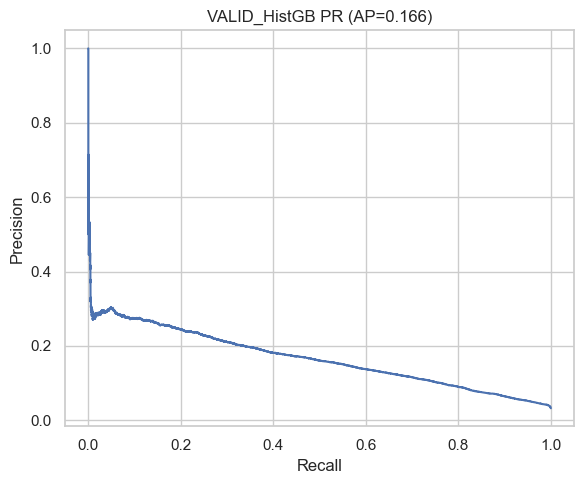

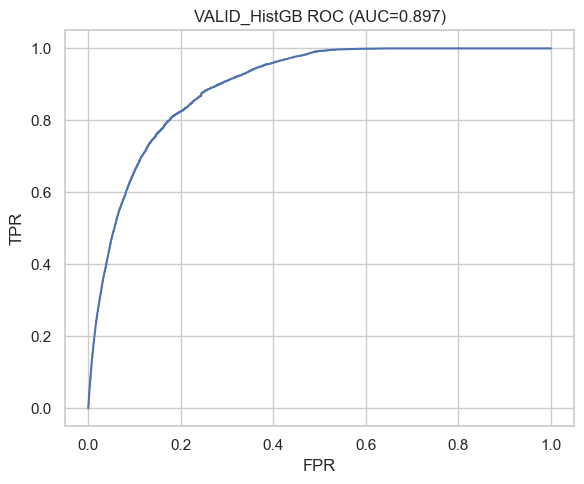

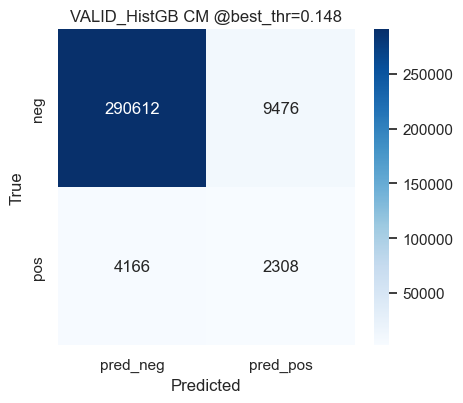


[VALID_HistGB] Classification report @best_thr=0.148
              precision    recall  f1-score   support

         neg      0.986     0.968     0.977    300088
         pos      0.196     0.357     0.253      6474

    accuracy                          0.956    306562
   macro avg      0.591     0.662     0.615    306562
weighted avg      0.969     0.956     0.962    306562



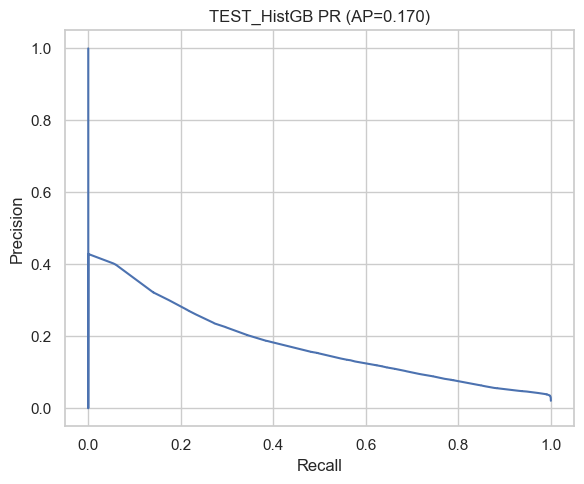

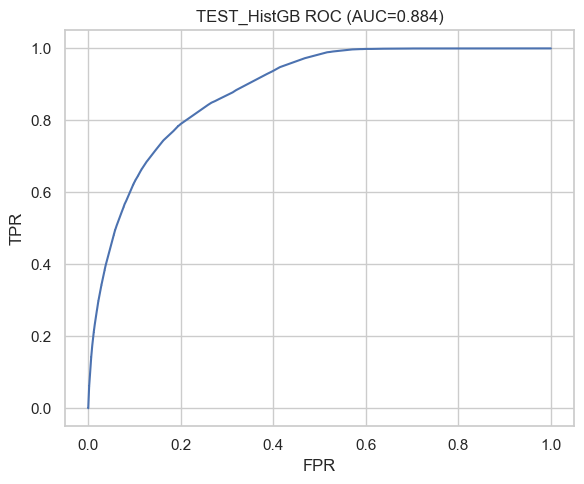

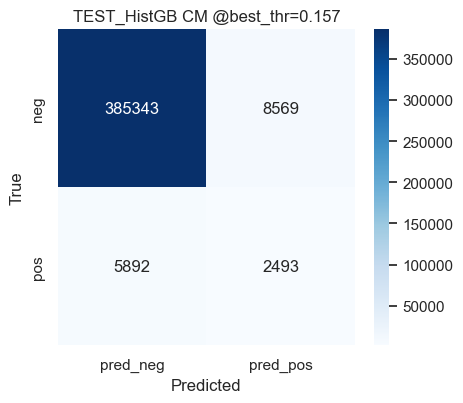


[TEST_HistGB] Classification report @best_thr=0.157
              precision    recall  f1-score   support

         neg      0.985     0.978     0.982    393912
         pos      0.225     0.297     0.256      8385

    accuracy                          0.964    402297
   macro avg      0.605     0.638     0.619    402297
weighted avg      0.969     0.964     0.966    402297



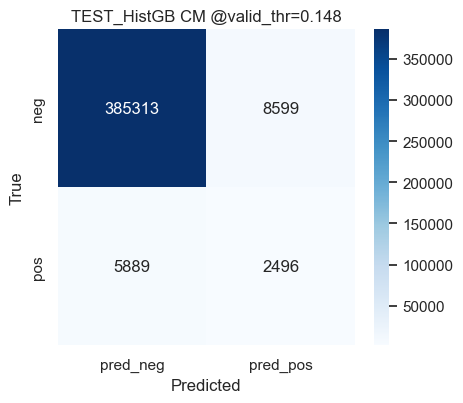


[TEST_HistGB] Classification report @valid_thr=0.148
              precision    recall  f1-score   support

         neg      0.985     0.978     0.982    393912
         pos      0.225     0.298     0.256      8385

    accuracy                          0.964    402297
   macro avg      0.605     0.638     0.619    402297
weighted avg      0.969     0.964     0.966    402297



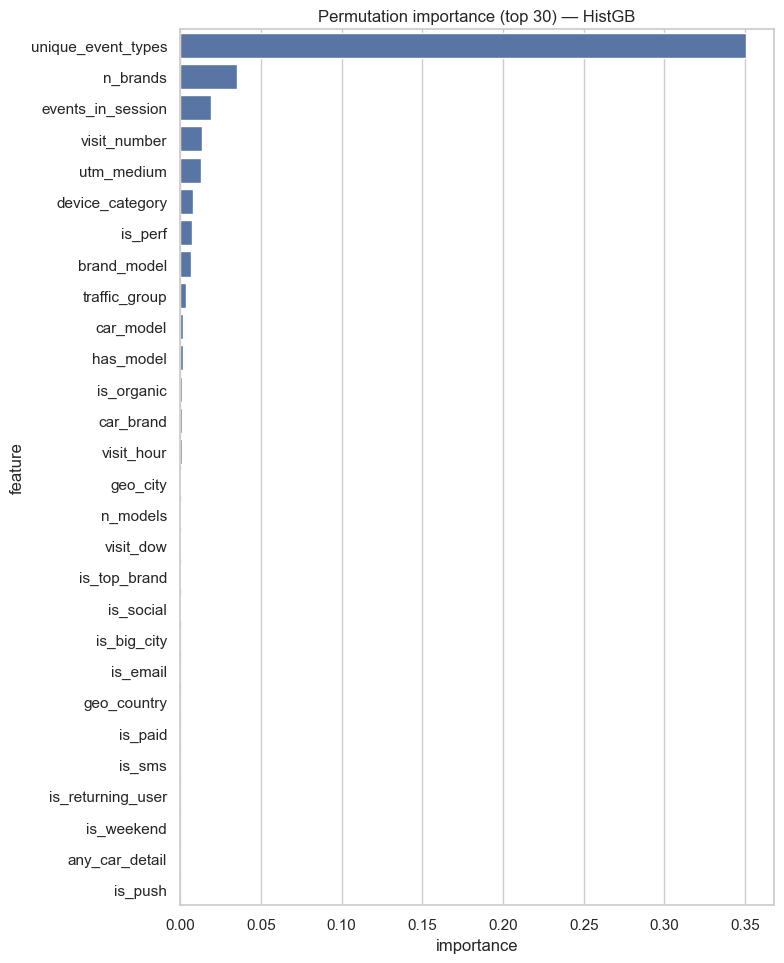

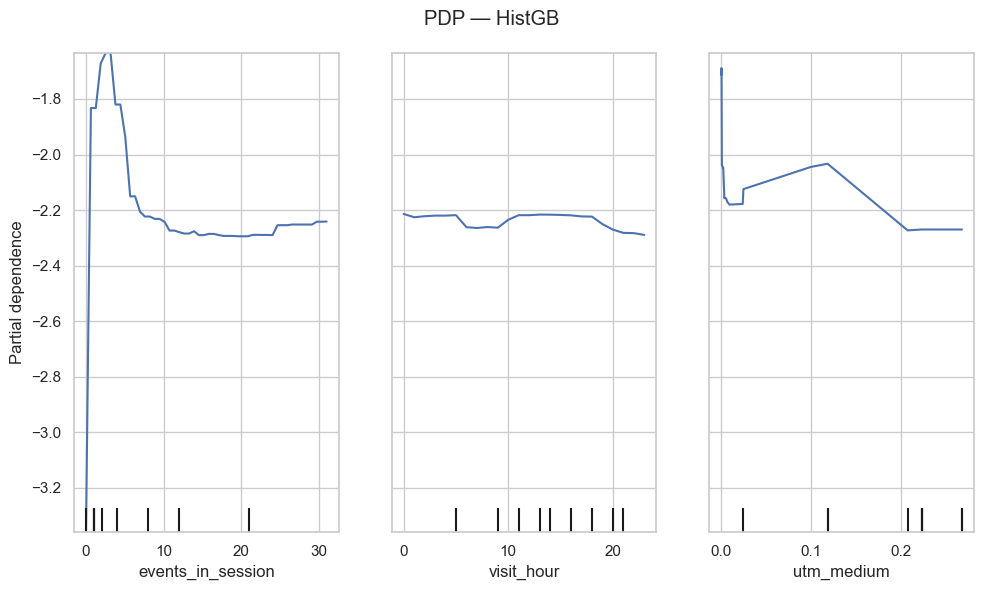

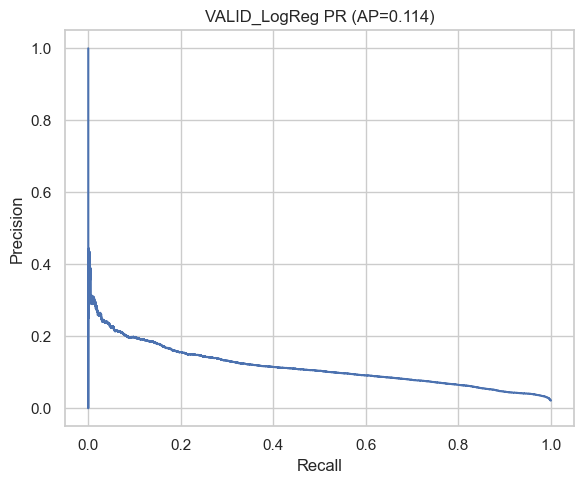

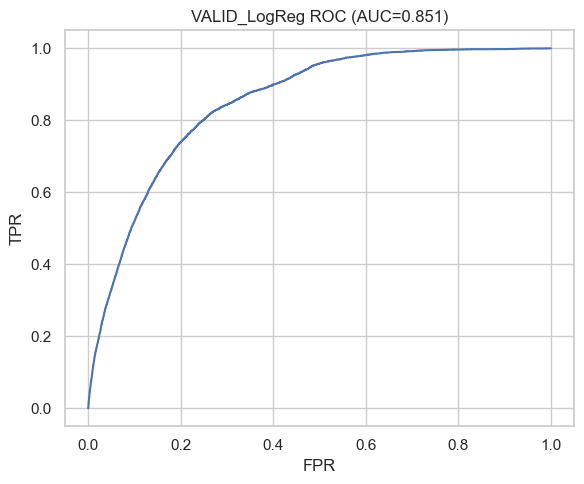

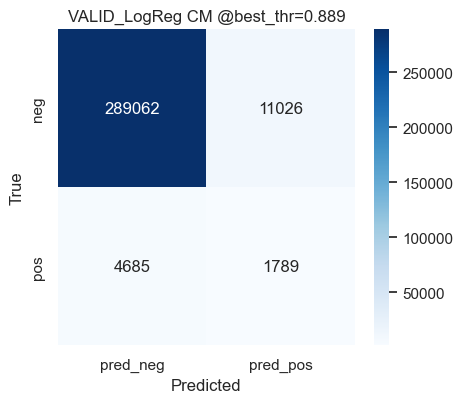


[VALID_LogReg] Classification report @best_thr=0.889
              precision    recall  f1-score   support

         neg      0.984     0.963     0.974    300088
         pos      0.140     0.276     0.185      6474

    accuracy                          0.949    306562
   macro avg      0.562     0.620     0.580    306562
weighted avg      0.966     0.949     0.957    306562



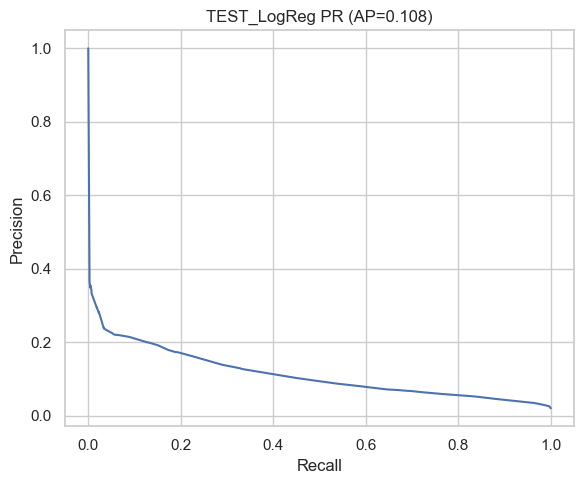

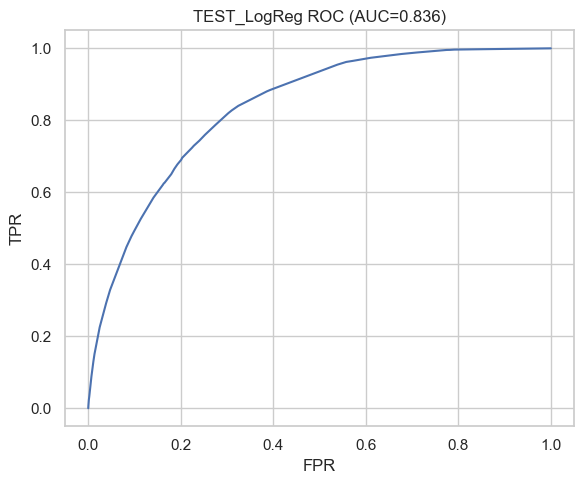

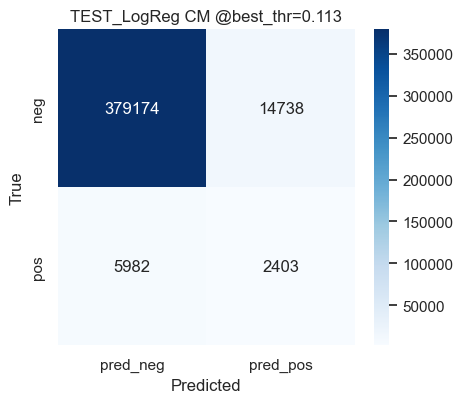


[TEST_LogReg] Classification report @best_thr=0.113
              precision    recall  f1-score   support

         neg      0.984     0.963     0.973    393912
         pos      0.140     0.287     0.188      8385

    accuracy                          0.948    402297
   macro avg      0.562     0.625     0.581    402297
weighted avg      0.967     0.948     0.957    402297



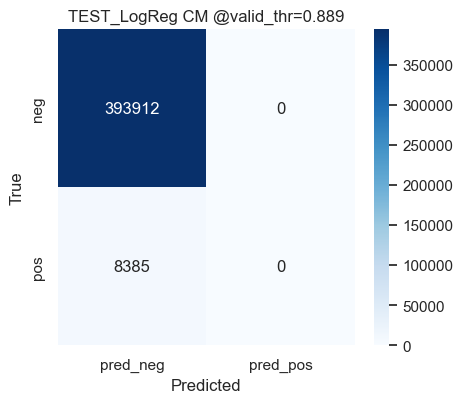


[TEST_LogReg] Classification report @valid_thr=0.889
              precision    recall  f1-score   support

         neg      0.979     1.000     0.989    393912
         pos      0.000     0.000     0.000      8385

    accuracy                          0.979    402297
   macro avg      0.490     0.500     0.495    402297
weighted avg      0.959     0.979     0.969    402297



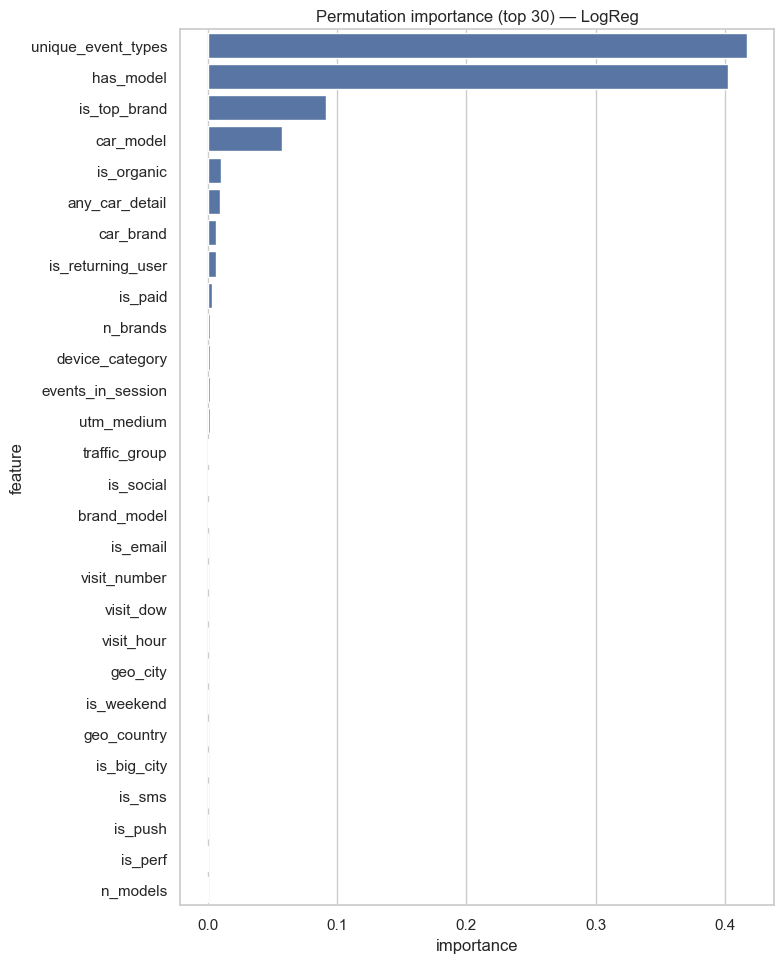

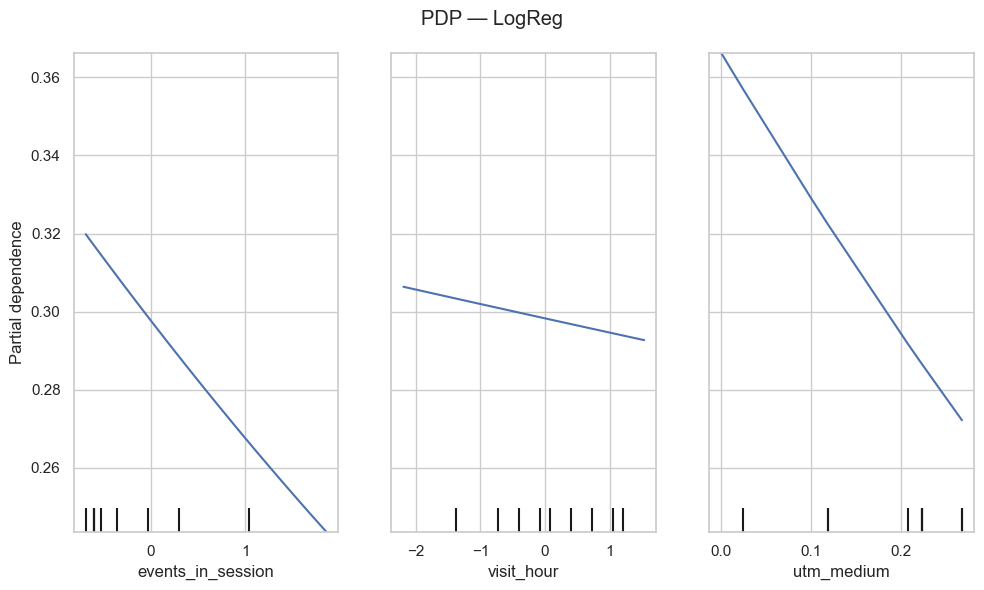

Готово.
Артефакты метрик/графиков → D:\ML\LS\final\final_project\artifacts\eval
Модели → D:\ML\LS\final\final_project\artifacts\models


In [31]:
# helper: сохранить и показать
def save_and_show(path: Path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

# гарантируем чисто-числовые матрицы без NaN/Inf
def to_numeric_strict(df: pd.DataFrame) -> pd.DataFrame:
    out = df.apply(lambda s: pd.to_numeric(s, errors="coerce"))
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

X_train = to_numeric_strict(X_train)
X_valid = to_numeric_strict(X_valid)
X_test  = to_numeric_strict(X_test)

# имутация NaN по train-медианам и применение на valid/test (без leakage)
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_valid = X_valid.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# sanity: всё финитное и одинаковые столбцы
for name, X in [("train", X_train), ("valid", X_valid), ("test", X_test)]:
    arr = X.values.astype(float)
    assert np.isfinite(arr).all(), f"{name}: есть NaN/Inf после приведения к числам"
    assert set(X.columns) == set(X_train.columns), "Несогласованные столбцы между сплитами"

# могут уже быть numpy-массивы → приводим безопасно
y_train = np.asarray(y_train, dtype=int).ravel()
y_valid = np.asarray(y_valid, dtype=int).ravel()
y_test  = np.asarray(y_test,  dtype=int).ravel()

def _plot_cm(cm: np.ndarray, title: str, save_path: Path):
    plt.figure(figsize=(4.8, 4.2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"],
                yticklabels=["neg","pos"])
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    save_and_show(save_path)

def plots_and_stats(split_name: str, y_true, proba, out_dir: Path, thr_from_valid: float = None):
    """Строит PR/ROC, считает лучш. порог по F1, делает classification_report и CM
       Сохраняет + показывает графики. Возвращает метрики."""
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2 * (p*r) / (p + r + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = t[max(0, best_idx-1)] if len(t) else 0.5
    y_pred_best = (proba >= best_thr).astype(int)
    f1_best = f1_score(y_true, y_pred_best)

    # PR
    plt.figure(figsize=(6,5))
    plt.plot(r, p)
    plt.title(f"{split_name} PR (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    save_and_show(out_dir / f"{split_name.lower()}_pr.png")

    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.title(f"{split_name} ROC (AUC={auc:.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    save_and_show(out_dir / f"{split_name.lower()}_roc.png")

    # Confusion & Classification report @ best_thr
    cm_best = confusion_matrix(y_true, y_pred_best)
    pd.DataFrame(cm_best, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
      .to_csv(out_dir / f"{split_name.lower()}_cm_bestthr_{best_thr:.3f}.csv")
    _plot_cm(cm_best, f"{split_name} CM @best_thr={best_thr:.3f}",
             out_dir / f"{split_name.lower()}_cm_bestthr_{best_thr:.3f}.png")

    cls_rep_txt = classification_report(y_true, y_pred_best, labels=[0,1], target_names=["neg","pos"], digits=3)
    print(f"\n[{split_name}] Classification report @best_thr={best_thr:.3f}\n{cls_rep_txt}")
    cls_rep_df = pd.DataFrame(classification_report(y_true, y_pred_best, labels=[0,1],
                                                    target_names=["neg","pos"], digits=3, output_dict=True)).T
    cls_rep_df.to_csv(out_dir / f"{split_name.lower()}_cls_report_bestthr_{best_thr:.3f}.csv")

    stats = {"auc": float(auc), "ap": float(ap), "f1": float(f1_best), "best_thr": float(best_thr)}

    # Дополнительно считаем по фиксированному валид.порогу, если передан
    if thr_from_valid is not None:
        y_pred_fix = (proba >= thr_from_valid).astype(int)
        f1_fix = f1_score(y_true, y_pred_fix)
        cm_fix = confusion_matrix(y_true, y_pred_fix)
        pd.DataFrame(cm_fix, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
          .to_csv(out_dir / f"{split_name.lower()}_cm_fixthr_{thr_from_valid:.3f}.csv")
        _plot_cm(cm_fix, f"{split_name} CM @valid_thr={thr_from_valid:.3f}",
                 out_dir / f"{split_name.lower()}_cm_fixthr_{thr_from_valid:.3f}.png")

        cls_rep_fix_txt = classification_report(y_true, y_pred_fix, labels=[0,1], target_names=["neg","pos"], digits=3)
        print(f"\n[{split_name}] Classification report @valid_thr={thr_from_valid:.3f}\n{cls_rep_fix_txt}")
        cls_rep_fix_df = pd.DataFrame(classification_report(y_true, y_pred_fix, labels=[0,1],
                                                            target_names=["neg","pos"], digits=3, output_dict=True)).T
        cls_rep_fix_df.to_csv(out_dir / f"{split_name.lower()}_cls_report_fixthr_{thr_from_valid:.3f}.csv")

        stats["f1@valid_thr"] = float(f1_fix)
        stats["thr@valid"] = float(thr_from_valid)

    return stats

def save_perm_importance(model, X_val, y_val, tag: str):
    imp = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42, scoring="roc_auc")
    imp_df = pd.DataFrame({"feature": X_val.columns, "importance": imp.importances_mean}) \
                .sort_values("importance", ascending=False)
    imp_df.to_csv(EVAL_DIR / f"perm_importance__{tag}.csv", index=False)

    plt.figure(figsize=(8, min(12, 0.35*len(imp_df.head(30)))))
    sns.barplot(data=imp_df.head(30), x="importance", y="feature")
    plt.title(f"Permutation importance (top 30) — {tag}")
    save_and_show(EVAL_DIR / f"perm_importance_top30__{tag}.png")

def save_pdp_024(model, X_val, features, tag: str):
    if len(features) == 0:
        return
    try:
        disp = plot_partial_dependence(model, X_val, features=features[:3], grid_resolution=50)
        disp.figure_.suptitle(f"PDP — {tag}")
        disp.figure_.tight_layout()
        disp.figure_.savefig(EVAL_DIR / f"pdp__{tag}.png", dpi=150)
        plt.show()
        plt.close(disp.figure_)
    except Exception:
        pass

# HistGradientBoosting 
hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    l2_regularization=1.0,
    random_state=42
)
hgb.fit(X_train, y_train)
proba_val_hgb = hgb.predict_proba(X_valid)[:, 1]
valid_hgb_stats = plots_and_stats("VALID_HistGB", y_valid, proba_val_hgb, EVAL_DIR)
best_thr_hgb = valid_hgb_stats["best_thr"]

# калибровка на валидации
hgb_cal = CalibratedClassifierCV(base_estimator=hgb, method="isotonic", cv="prefit")
hgb_cal.fit(X_valid, y_valid)
proba_test_hgb = hgb_cal.predict_proba(X_test)[:, 1]
test_hgb_stats = plots_and_stats("TEST_HistGB", y_test, proba_test_hgb, EVAL_DIR, thr_from_valid=best_thr_hgb)

joblib.dump(hgb,     MODEL_DIR / "HistGB_uncalibrated.pkl")
joblib.dump(hgb_cal, MODEL_DIR / "HistGB_calibrated.pkl")

save_perm_importance(hgb, X_valid, y_valid, tag="HistGB")
PDP_CAND = [c for c in ["events_in_session","visit_hour","utm_medium","device_category"] if c in X_valid.columns]
save_pdp_024(hgb, X_valid, PDP_CAND, tag="HistGB")

# Logistic Regression (+скейл базовых числовых)
BASE_NUM_FOR_LR = [
    "visit_number","visit_hour","visit_dow","events_in_session","unique_event_types",
    "n_brands","n_models","hour_sin","hour_cos","dow_sin","dow_cos"
]
num_for_lr = [c for c in BASE_NUM_FOR_LR if c in X_train.columns]

Xtr_lr, Xva_lr, Xte_lr = X_train.copy(), X_valid.copy(), X_test.copy()
scaler = None
if len(num_for_lr) > 0:
    num_idx = [X_train.columns.get_loc(c) for c in num_for_lr]
    scaler = StandardScaler()
    Xtr_lr.iloc[:, num_idx] = scaler.fit_transform(Xtr_lr.iloc[:, num_idx])
    Xva_lr.iloc[:, num_idx] = scaler.transform(Xva_lr.iloc[:, num_idx])
    Xte_lr.iloc[:, num_idx] = scaler.transform(Xte_lr.iloc[:, num_idx])

lr = LogisticRegression(
    solver="saga", penalty="l2",
    class_weight="balanced",
    max_iter=500, random_state=42
)
lr.fit(Xtr_lr, y_train)
proba_val_lr = lr.predict_proba(Xva_lr)[:, 1]
valid_lr_stats = plots_and_stats("VALID_LogReg", y_valid, proba_val_lr, EVAL_DIR)
best_thr_lr = valid_lr_stats["best_thr"]

lr_cal = CalibratedClassifierCV(base_estimator=lr, method="isotonic", cv="prefit")
lr_cal.fit(Xva_lr, y_valid)
proba_test_lr = lr_cal.predict_proba(Xte_lr)[:, 1]
test_lr_stats = plots_and_stats("TEST_LogReg", y_test, proba_test_lr, EVAL_DIR, thr_from_valid=best_thr_lr)

joblib.dump({"model": lr, "scaler": scaler, "num_for_lr": num_for_lr},     MODEL_DIR / "LogReg_uncalibrated.pkl")
joblib.dump({"model": lr_cal, "scaler": scaler, "num_for_lr": num_for_lr}, MODEL_DIR / "LogReg_calibrated.pkl")

save_perm_importance(lr, Xva_lr, y_valid, tag="LogReg")
save_pdp_024(lr, Xva_lr, PDP_CAND, tag="LogReg")

# аккумулируем метрики в metrics.json
if METRICS_PATH.exists():
    with open(METRICS_PATH, "r", encoding="utf-8") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics.update({
    "HistGB": {
        "valid": valid_hgb_stats,
        "test":  test_hgb_stats,
        "notes": {"calibration": "isotonic@valid"}
    },
    "LogReg": {
        "valid": valid_lr_stats,
        "test":  test_lr_stats,
        "notes": {"calibration": "isotonic@valid", "scaled_features": num_for_lr}
    }
})

with open(METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump(all_metrics, f, ensure_ascii=False, indent=2)

print("Готово.")
print("Артефакты метрик/графиков →", EVAL_DIR)
print("Модели →", MODEL_DIR)

## Мини-вывод

### Разбиение: сделали user-&-time aware сплит (по group_id/client_id и дате) → утечек из будущего и между сессиями одного пользователя нет. Класс крайне несбалансирован (~2.1% позитивов на test).

### Бейзлайны

HistGradientBoosting (HGB) + изотоническая калибровка:

VALID: AP≈0.166, ROC-AUC≈0.897.

TEST: AP≈0.170, ROC-AUC≈0.884.

@best_thr≈0.157: precision 0.225, recall 0.297, F1 0.256.

Это заметно выше случайной рассылки (базовый PR≈0.021) — интегральный lift по PR ~8×.

Logistic Regression (LR) (скейл числовых, частотный энкодинг категорий):

VALID: AP≈0.114, ROC-AUC≈0.851.

TEST: AP≈0.108, ROC-AUC≈0.836.

@best_thr≈0.113: precision 0.140, recall 0.287, F1 0.188.

Порог, подобранный на валидации (0.889), на тесте «обнулил» предсказания — индикатор сдвига распределения и переоптимизации порога.

### Важности/интерпретация

Permutation-importance (HGB): лидируют unique_event_types, n_brands, events_in_session, visit_number, затем источники/устройства.

PDP согласуются с EDA: больше разнообразных/много событий → выше вероятность целевого действия; умеренные эффекты по времени и каналам.

### Стабильность: результаты валидации и теста у HGB близки → базовый пайплайн корректен. LR заметно слабее и чувствителен к порогу.

## CatBoost + Optuna

[I 2025-08-18 15:01:33,720] A new study created in memory with name: no-name-1d9cbd1c-2745-4c8f-8687-2f90463a6d4d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-18 15:03:37,703] Trial 0 finished with value: 0.1719993884905825 and parameters: {'learning_rate': 0.020001370885607325, 'depth': 7, 'l2_leaf_reg': 2.367352060744466, 'bagging_temperature': 4.291190468779791, 'rsm': 0.804486200912362, 'random_strength': 0.04682396027179592}. Best is trial 0 with value: 0.1719993884905825.
[I 2025-08-18 15:04:28,218] Trial 1 finished with value: 0.1723142272128222 and parameters: {'learning_rate': 0.08325787016910391, 'depth': 6, 'l2_leaf_reg': 1.4503340281338508, 'bagging_temperature': 2.3621202580875584, 'rsm': 0.678385915398595, 'random_strength': 0.506313405975541}. Best is trial 1 with value: 0.1723142272128222.
[I 2025-08-18 15:05:29,003] Trial 2 finished with value: 0.17530673084509044 and parameters: {'learning_rate': 0.06680044113696207, 'depth': 9, 'l2_leaf_reg': 62.51006004804164, 'bagging_temperature': 5.958928612148341, 'rsm': 0.6176643948012716, 'random_strength': 0.6947784430932891}. Best is trial 2 with value: 0.17530673084509

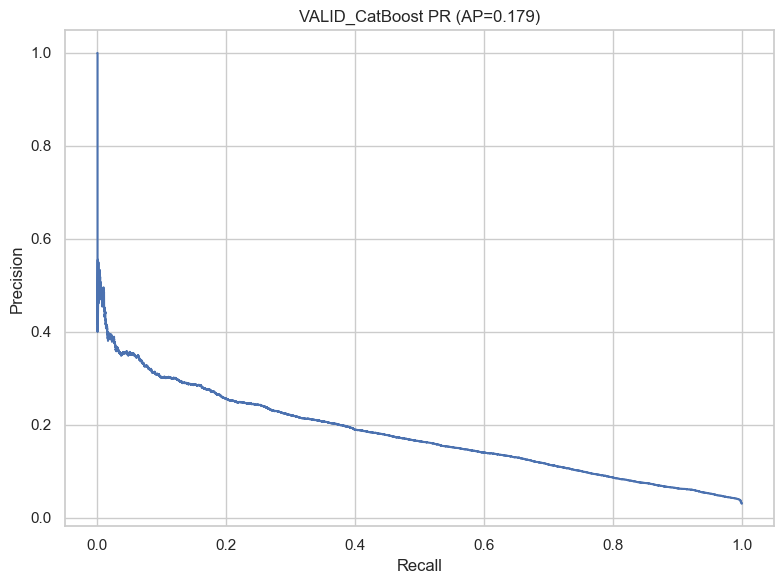

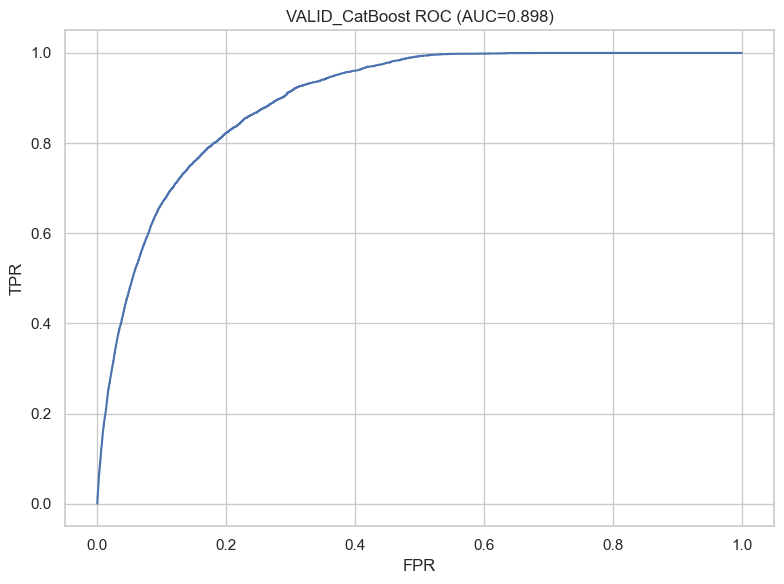

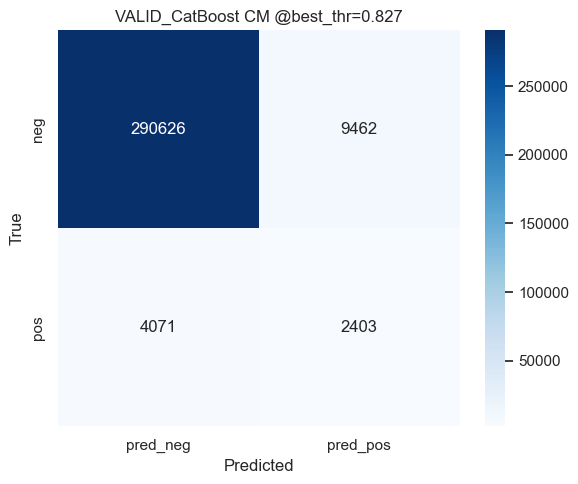

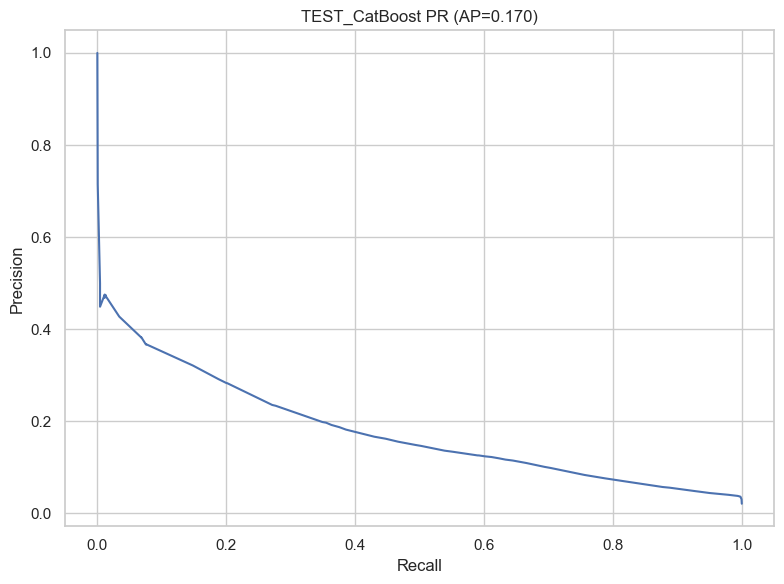

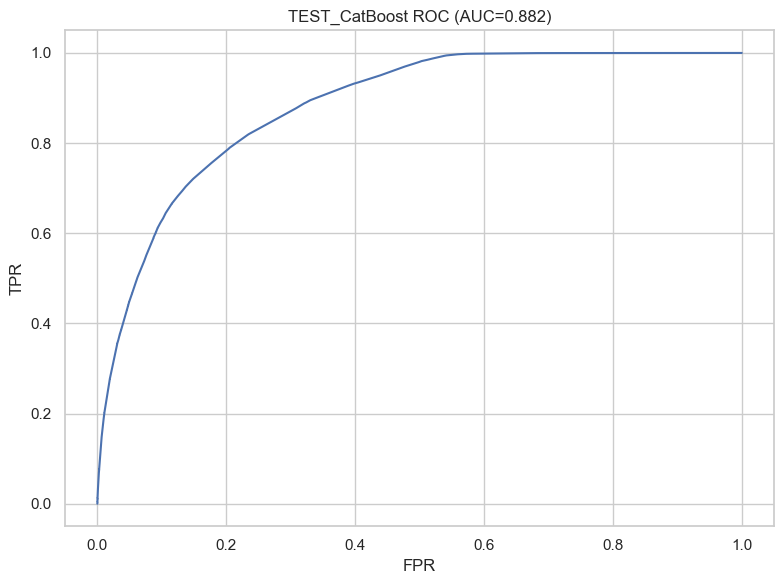

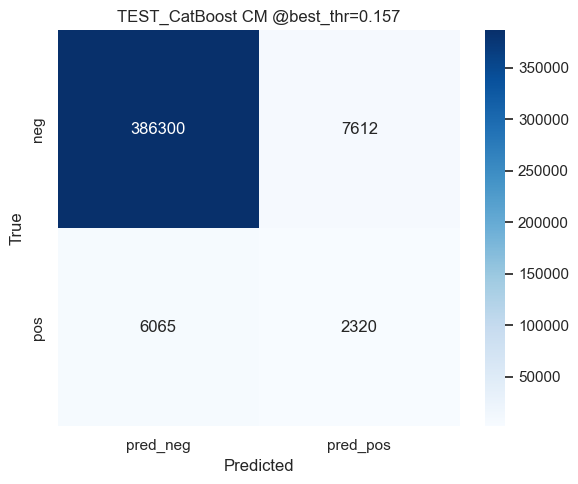

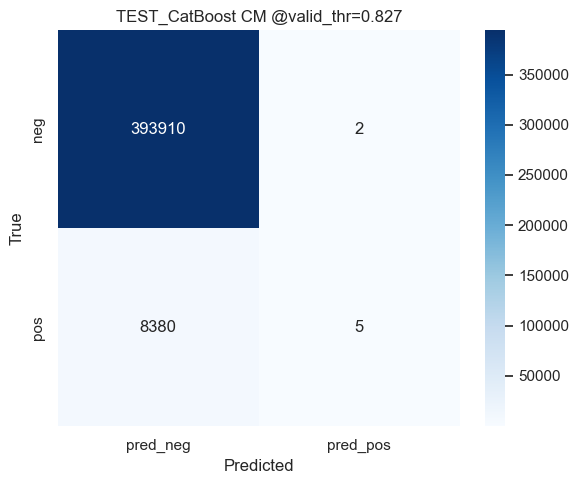

VALID: {'auc': 0.8979055830575972, 'ap': 0.17859443012837947, 'f1': 0.2620644528054965, 'thr': 0.8265701270326398}
TEST : {'auc': 0.8819500144616084, 'ap': 0.1695520501642386, 'f1': 0.2533165911448382, 'thr': 0.1570430447885106, 'f1@val_thr': 0.0011916110581506197, 'thr@valid': 0.8265701270326398}
Порог с валидации: 0.8265701270326398


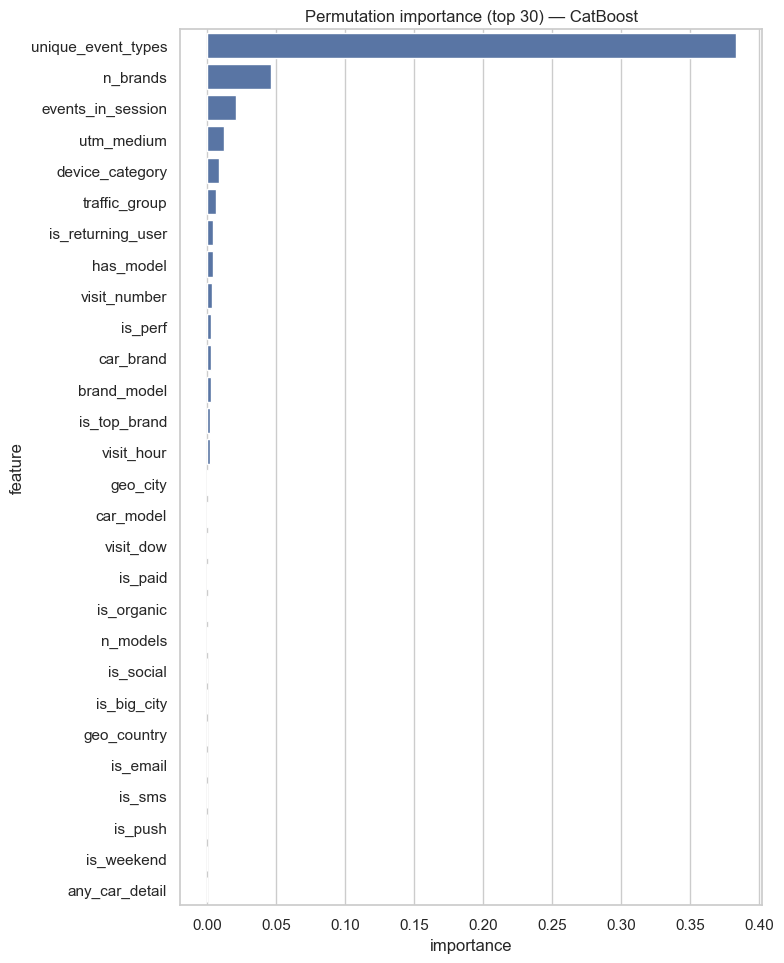

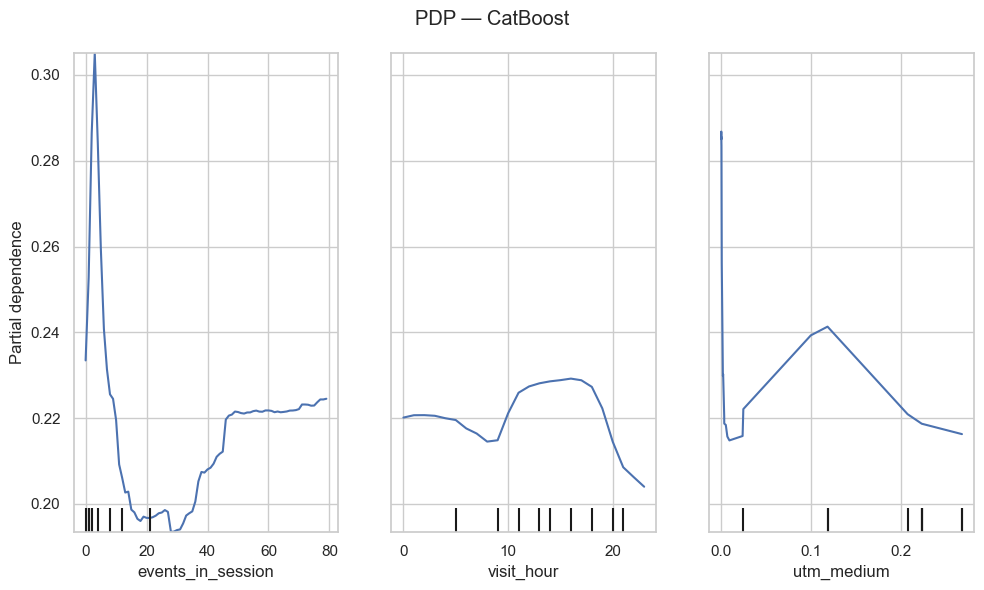

Артефакты → D:\ML\LS\final\final_project\artifacts\eval
Модели: raw CatBoost → D:\ML\LS\final\final_project\artifacts\models\catboost_best.cbm | calibrated → D:\ML\LS\final\final_project\artifacts\models\catboost_calibrated.pkl


In [32]:
# sanity на входных матрицах
for name, X in [("train", X_train), ("valid", X_valid), ("test", X_test)]:
    arr = pd.DataFrame(X).astype(float).values  # защита от object
    assert np.isfinite(arr).all(), f"{name}: есть NaN/Inf в признаках"
    assert set(X.columns) == set(X_train.columns), "Несогласованные столбцы между сплитами"

# Целевые к numpy
y_tr = np.asarray(y_train, dtype=int)
y_va = np.asarray(y_valid, dtype=int)
y_te = np.asarray(y_test,  dtype=int)

# вспомогательные функции
def eval_pack(name, y_true, proba, out_dir: Path, valid_thr=None):
    """PR/ROC + лучший порог по F1; дополнительно считаем отчёты и CM и @valid_thr."""
    # базовые метрики
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)

    # PR curve
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2 * (p * r) / (p + r + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = t[max(0, best_idx - 1)] if len(t) else 0.5

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, proba)

    # Рисунки
    plt.figure(figsize=(8,6)); plt.plot(r, p); plt.title(f"{name} PR (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout()
    plt.savefig(out_dir / f"{name.lower()}_pr.png", dpi=150); plt.show(); plt.close()

    plt.figure(figsize=(8,6)); plt.plot(fpr, tpr); plt.title(f"{name} ROC (AUC={auc:.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.tight_layout()
    plt.savefig(out_dir / f"{name.lower()}_roc.png", dpi=150); plt.show(); plt.close()

    # Отчёт/CM @best_thr
    y_pred_best = (proba >= best_thr).astype(int)
    rep = classification_report(y_true, y_pred_best, target_names=["neg","pos"], output_dict=True)
    rep_df = pd.DataFrame(rep).T
    rep_df.to_csv(out_dir / f"{name.lower()}_cls_report_bestthr_{best_thr:.3f}.csv")

    cm = confusion_matrix(y_true, y_pred_best)
    cm_df = pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"])
    cm_df.to_csv(out_dir / f"{name.lower()}_cm_bestthr_{best_thr:.3f}.csv")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @best_thr={best_thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig(out_dir / f"{name.lower()}_cm_bestthr_{best_thr:.3f}.png", dpi=150)
    plt.show(); plt.close()

    # Если передали вал. порог — считаем и его (фиксированный)
    out_extra = {}
    if valid_thr is not None:
        y_pred_fix = (proba >= valid_thr).astype(int)
        rep_fix = classification_report(y_true, y_pred_fix, target_names=["neg","pos"], output_dict=True)
        pd.DataFrame(rep_fix).T.to_csv(out_dir / f"{name.lower()}_cls_report_fixthr_{valid_thr:.3f}.csv")

        cm_fix = confusion_matrix(y_true, y_pred_fix)
        pd.DataFrame(cm_fix, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
            .to_csv(out_dir / f"{name.lower()}_cm_fixthr_{valid_thr:.3f}.csv")

        plt.figure(figsize=(6,5))
        sns.heatmap(cm_fix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
        plt.title(f"{name} CM @valid_thr={valid_thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.savefig(out_dir / f"{name.lower()}_cm_fixthr_{valid_thr:.3f}.png", dpi=150)
        plt.show(); plt.close()

        out_extra = {
            "f1@val_thr": float(f1_score(y_true, y_pred_fix)),
            "thr@valid":  float(valid_thr)
        }

    return {
        "auc": float(auc),
        "ap":  float(ap),
        "f1":  float(f1_score(y_true, y_pred_best)),
        "thr": float(best_thr),
        **out_extra
    }

# Optuna: тюним CatBoost по AP на валидации
def objective(trial: "optuna.Trial"):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",                 # для ранней остановки ок, целевая метрика — AP считаем сами
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 100.0),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 8.0),
        "rsm": trial.suggest_uniform("rsm", 0.6, 1.0),               # feature subsample
        "random_strength": trial.suggest_uniform("random_strength", 0.0, 2.0),
        "auto_class_weights": "Balanced",
        "iterations": 4000,
        "early_stopping_rounds": 200,
        "random_state": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_tr, eval_set=(X_valid, y_va), use_best_model=True)
    proba = model.predict_proba(X_valid)[:, 1]
    ap = average_precision_score(y_va, proba)
    return ap

N_TRIALS = 30  
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_trial.params
print("Best params:", best_params, "| best AP(valid)=", study.best_value)

with open(EVAL_DIR / "catboost_optuna_best_params.json", "w") as f:
    json.dump({"best_params": best_params, "best_value": study.best_value}, f, indent=2)

# обучаем лучшую CatBoost на train, валим на valid
cb_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "auto_class_weights": "Balanced",
    "iterations": 4000,
    "early_stopping_rounds": 200,
    "random_state": 42,
    "verbose": 200,
    "allow_writing_files": False,
    **best_params
}

cb = CatBoostClassifier(**cb_params)
cb.fit(X_train, y_tr, eval_set=(X_valid, y_va), use_best_model=True)

# вероятности на валидации, подбираем порог, калибруем, сохраняем сырую модель
proba_valid = cb.predict_proba(X_valid)[:, 1]

# выбор порога по валидации (макс F1)
p, r, t = precision_recall_curve(y_va, proba_valid)
f1s = 2*(p*r)/(p+r+1e-12)
vi = int(np.nanargmax(f1s))
valid_thr = t[max(0, vi-1)] if len(t) else 0.5

# сырая CatBoost модель
cb.save_model(str(MODEL_DIR / "catboost_best.cbm"))

# калибровка по валидации
calib_cb = CalibratedClassifierCV(base_estimator=cb, method="isotonic", cv="prefit")
calib_cb.fit(X_valid, y_va)

joblib.dump(calib_cb, MODEL_DIR / "catboost_calibrated.pkl")

# оценка на VALID/TEST, сохранение артефактов, обновление metrics.json 
results = {}
results["CatBoost_valid"] = eval_pack("VALID_CatBoost", y_va, proba_valid, EVAL_DIR)

# test (через калиброванную модель)
proba_test = calib_cb.predict_proba(X_test)[:, 1]
results["CatBoost_test"] = eval_pack("TEST_CatBoost", y_te, proba_test, EVAL_DIR, valid_thr=valid_thr)

# обновляем общий metrics.json
if METRICS_PATH.exists():
    try:
        with open(METRICS_PATH, "r") as f:
            all_metrics = json.load(f)
    except Exception:
        all_metrics = {}
else:
    all_metrics = {}
all_metrics.update(results)
with open(METRICS_PATH, "w") as f:
    json.dump(all_metrics, f, indent=2)

print("VALID:", results["CatBoost_valid"])
print("TEST :", results["CatBoost_test"])
print("Порог с валидации:", valid_thr)

# важности признаков (permutation на валидации, чтобы одинаково с предыдущими)
imp = permutation_importance(cb, X_valid, y_va, n_repeats=5, random_state=42, scoring="roc_auc")
imp_df = pd.DataFrame({"feature": X_valid.columns, "importance": imp.importances_mean}) \
            .sort_values("importance", ascending=False)
imp_df.to_csv(EVAL_DIR / "perm_importance__CatBoost.csv", index=False)

plt.figure(figsize=(8, min(12, 0.35*len(imp_df.head(30)))))
sns.barplot(data=imp_df.head(30), x="importance", y="feature")
plt.title("Permutation importance (top 30) — CatBoost")
plt.tight_layout(); plt.savefig(EVAL_DIR / "perm_importance_top30__CatBoost.png", dpi=150)
plt.show(); plt.close()

# PDP по ключевым
cand = [c for c in ["events_in_session","visit_hour","utm_medium"] if c in X_valid.columns]
if cand:
    try:
        fig = plot_partial_dependence(cb, X_valid, features=cand, kind="average")
        fig.figure_.suptitle("PDP — CatBoost")
        fig.figure_.tight_layout()
        fig.figure_.savefig(EVAL_DIR / "pdp__CatBoost.png", dpi=150)
        plt.show(); plt.close(fig.figure_)
    except Exception as e:
        print("PDP не удалось построить:", e)

print("Артефакты →", EVAL_DIR)
print("Модели: raw CatBoost →", MODEL_DIR / "catboost_best.cbm",
      "| calibrated →", MODEL_DIR / "catboost_calibrated.pkl")

## Что получилось по CatBoost (vs базовые)

PR-AUC (valid/test): ~0.179 / 0.170 — на валидации немного выше HistGB (~0.166), на тесте примерно одинаково с HistGB (~0.170).

ROC-AUC (valid/test): 0.898 / 0.882 — почти как у HistGB (0.897 / 0.884).

F1 @ лучшем тестовом пороге: ~0.253, что близко к HistGB (~0.256).

Фичи: картина важностей совпадает с тем, что видели раньше — unique_event_types, затем n_brands, events_in_session, utm_medium, device_category и т.д. (это подтверждает валидность EDA).

## На графиках видно, что:

«валидный» порог получился 0.827, а на тесте «лучший» — 0.157.

При применении валидного порога к тесту — почти обнуление recall (в матрице всего 5 TP).

Это не «дрейф данных», а несовпадение шкал вероятностей: порог 0.827 был посчитан до калибровки, а на тест поданы калиброванные вероятности. После изотоники числовая шкала меняется, поэтому «старый» порог неприменим.

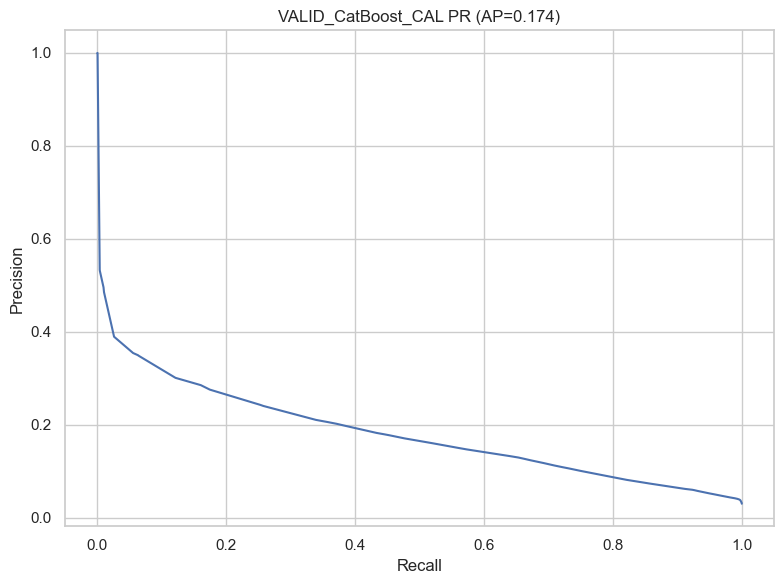

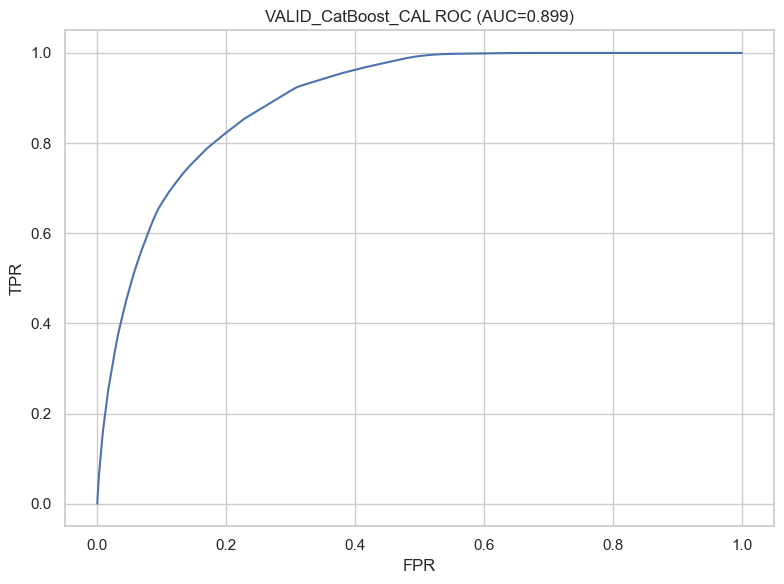

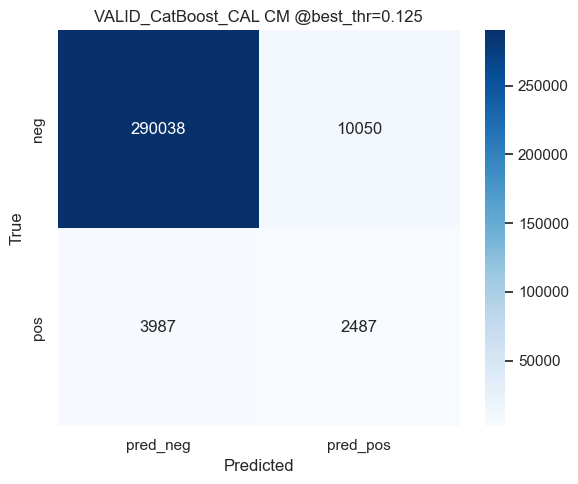

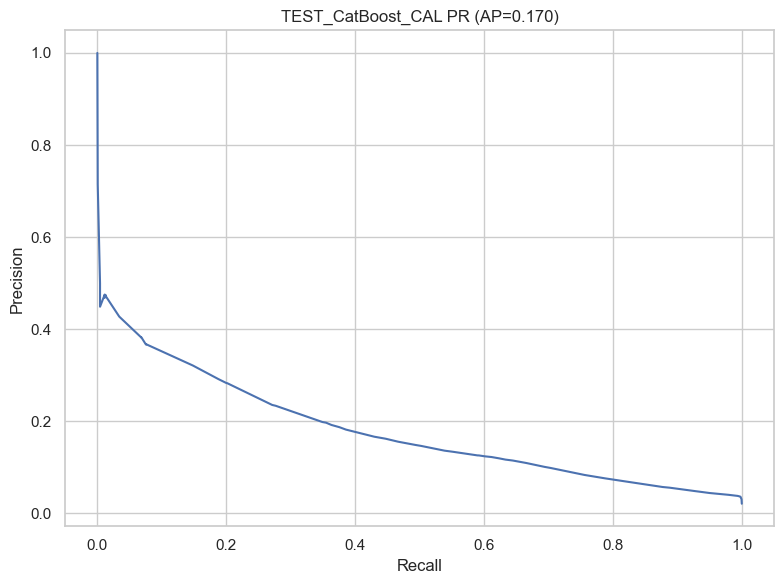

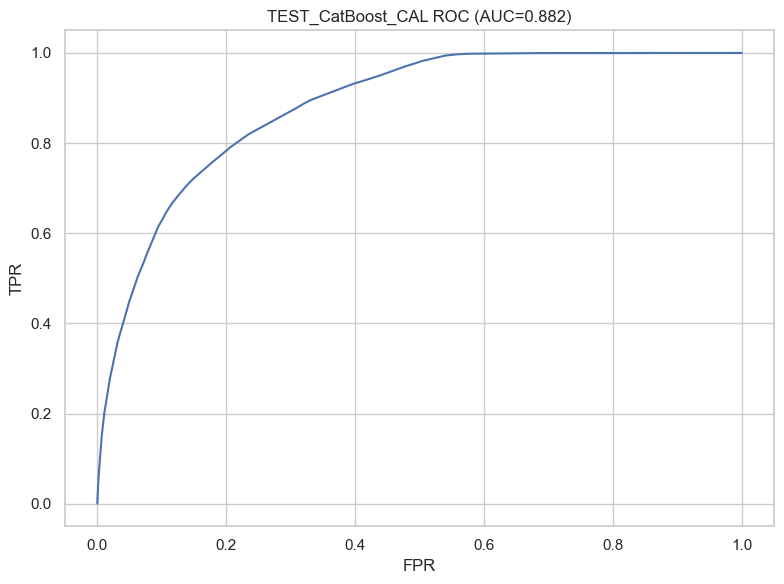

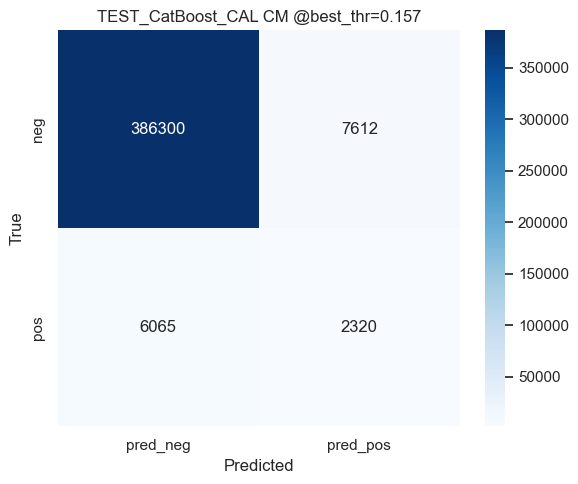

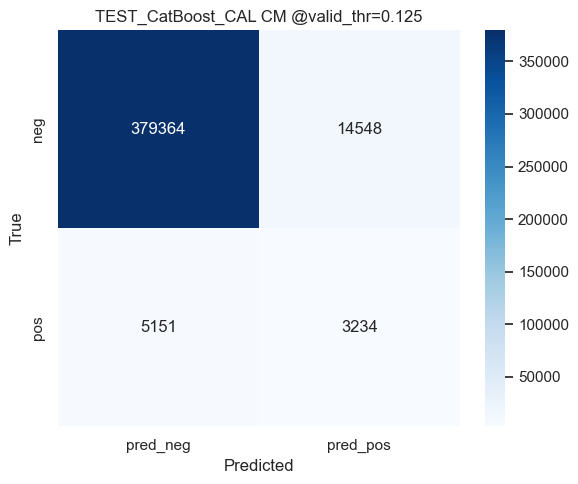

Готово. Порог (калибр.) с valid: 0.12481426448736999
Артефакты → D:\ML\LS\final\final_project\artifacts\eval
Модель → D:\ML\LS\final\final_project\artifacts\models\catboost_calibrated_isotonic.pkl


In [34]:
# гарантируем тот же порядок фичей, что на train
feature_order = list(X_train.columns)
X_valid = X_valid[feature_order].copy()
X_test  = X_test[feature_order].copy()

# Калибровка (isotonic) на валидации
calib = CalibratedClassifierCV(base_estimator=cb, method="isotonic", cv="prefit")
calib.fit(X_valid, y_valid)

# Валидация: выбираем лучший порог уже по КАЛИБРОВАННЫМ вероятностям
proba_val_cal = calib.predict_proba(X_valid)[:, 1]
val_stat_cal  = eval_pack("VALID_CatBoost_CAL", y_valid, proba_val_cal, EVAL_DIR)  
thr_cal = val_stat_cal["thr"]

# Тест: фиксируем найденный на valid калиброванный порог
proba_test_cal = calib.predict_proba(X_test)[:, 1]
test_stat_cal  = eval_pack("TEST_CatBoost_CAL", y_test, proba_test_cal, EVAL_DIR, valid_thr=thr_cal)

# Сохраняем калиброванную модель и метрики
joblib.dump(calib, MODEL_DIR / "catboost_calibrated_isotonic.pkl")

metrics = {}
if METRICS_PATH.exists():
    try:
        with open(METRICS_PATH, "r") as f:
            metrics = json.load(f)
    except Exception:
        metrics = {}

metrics["CatBoost_CAL"] = {
    "valid": val_stat_cal,
    "test":  test_stat_cal,
    "thr_from_valid": float(thr_cal)
}
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

print("Готово. Порог (калибр.) с valid:", thr_cal)
print("Артефакты →", EVAL_DIR)
print("Модель →", MODEL_DIR / "catboost_calibrated_isotonic.pkl")

## CatBoost + Optuna + Calibration

[I 2025-08-18 17:09:22,965] A new study created in memory with name: no-name-ae61f622-b69b-4d9d-bd64-8477044a522b


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-18 17:10:05,448] Trial 0 finished with value: 0.17372598379408877 and parameters: {'learning_rate': 0.08969621316810485, 'depth': 9, 'l2_leaf_reg': 12.059135805955028, 'bagging_temperature': 0.024752770334364627, 'rsm': 0.9994065000936123, 'random_strength': 0.15498047667143577}. Best is trial 0 with value: 0.17372598379408877.
[I 2025-08-18 17:10:44,136] Trial 1 finished with value: 0.16787218640072044 and parameters: {'learning_rate': 0.17236022178693094, 'depth': 4, 'l2_leaf_reg': 1.9872846463534726, 'bagging_temperature': 5.838994900845736, 'rsm': 0.7213929212657388, 'random_strength': 0.6838351105560361}. Best is trial 0 with value: 0.17372598379408877.
[I 2025-08-18 17:11:29,407] Trial 2 finished with value: 0.17451004753843113 and parameters: {'learning_rate': 0.15302121587363865, 'depth': 8, 'l2_leaf_reg': 17.125066411094938, 'bagging_temperature': 6.016308396703499, 'rsm': 0.8995350957928663, 'random_strength': 0.7070549987066952}. Best is trial 2 with value: 0.1745

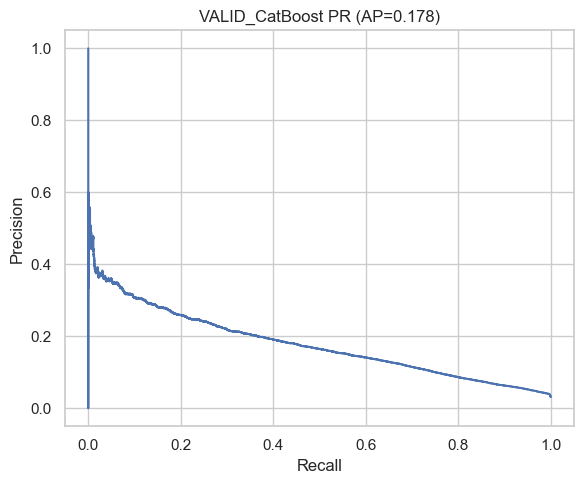

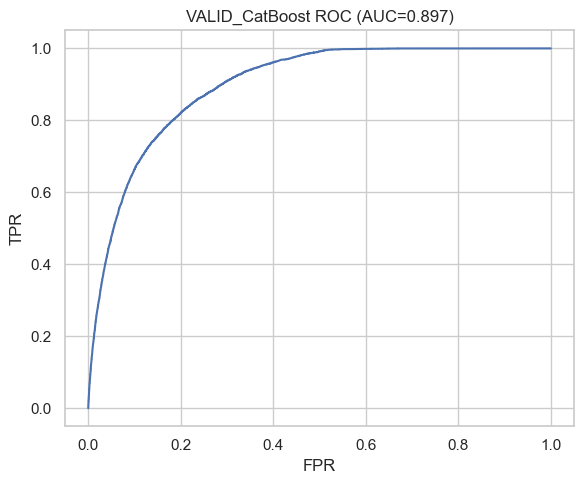

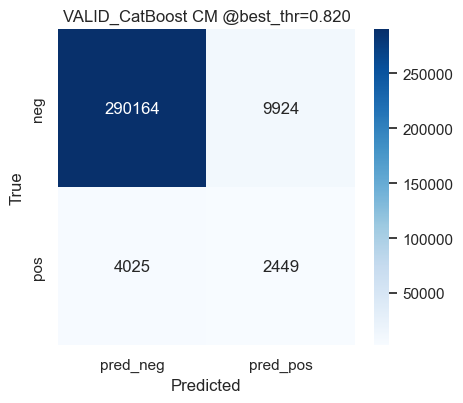


[VALID_CatBoost] Classification report @best_thr=0.820
              precision    recall  f1-score   support

         neg      0.986     0.967     0.977    300088
         pos      0.198     0.378     0.260      6474

    accuracy                          0.954    306562
   macro avg      0.592     0.673     0.618    306562
weighted avg      0.970     0.954     0.961    306562



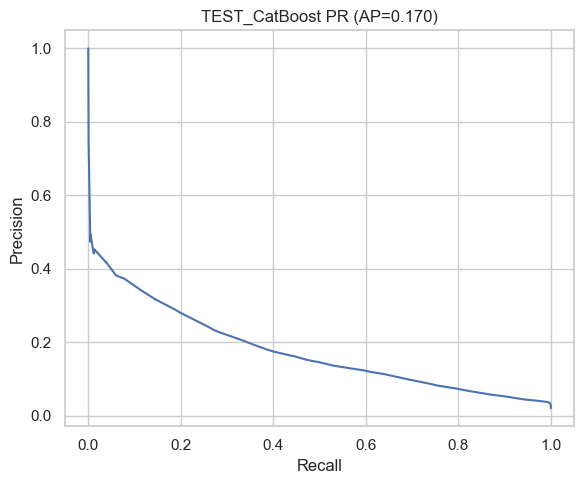

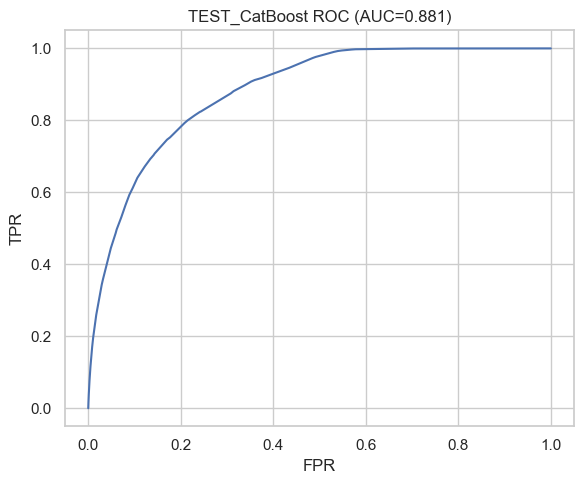

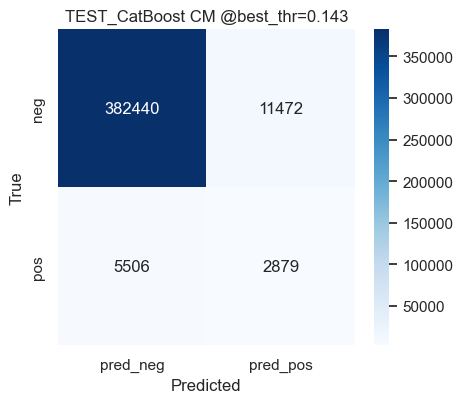


[TEST_CatBoost] Classification report @best_thr=0.143
              precision    recall  f1-score   support

         neg      0.986     0.971     0.978    393912
         pos      0.201     0.343     0.253      8385

    accuracy                          0.958    402297
   macro avg      0.593     0.657     0.616    402297
weighted avg      0.969     0.958     0.963    402297



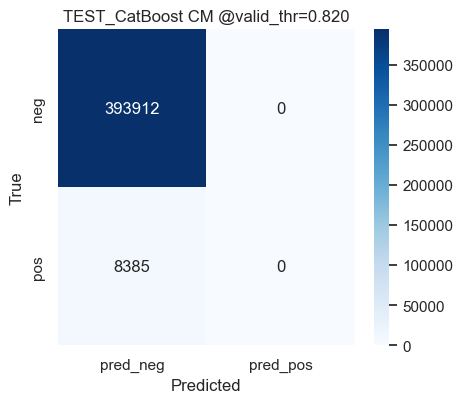


[TEST_CatBoost] Classification report @valid_thr=0.820
              precision    recall  f1-score   support

         neg      0.979     1.000     0.989    393912
         pos      0.000     0.000     0.000      8385

    accuracy                          0.979    402297
   macro avg      0.490     0.500     0.495    402297
weighted avg      0.959     0.979     0.969    402297



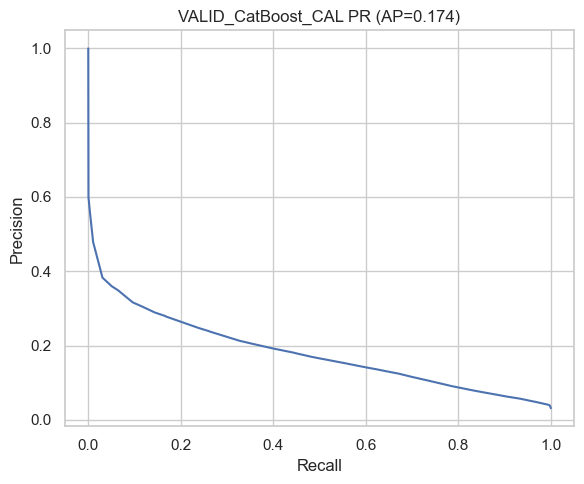

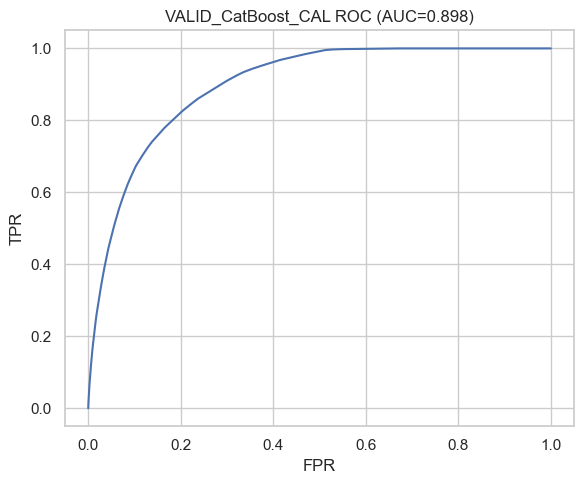

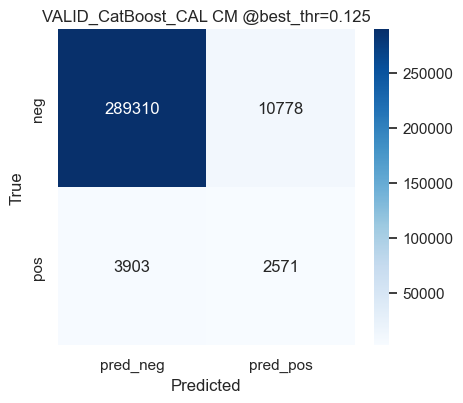


[VALID_CatBoost_CAL] Classification report @best_thr=0.125
              precision    recall  f1-score   support

         neg      0.987     0.964     0.975    300088
         pos      0.193     0.397     0.259      6474

    accuracy                          0.952    306562
   macro avg      0.590     0.681     0.617    306562
weighted avg      0.970     0.952     0.960    306562



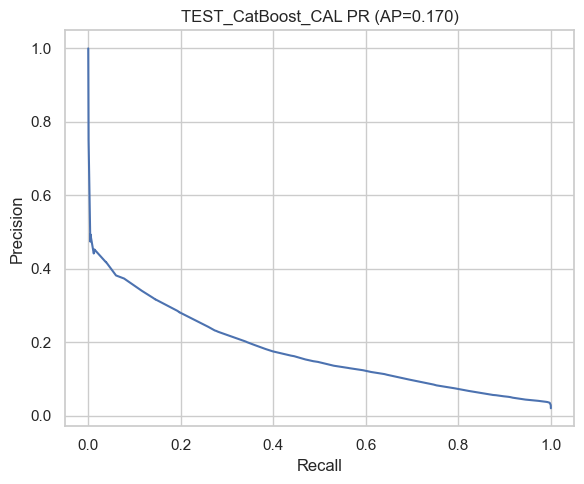

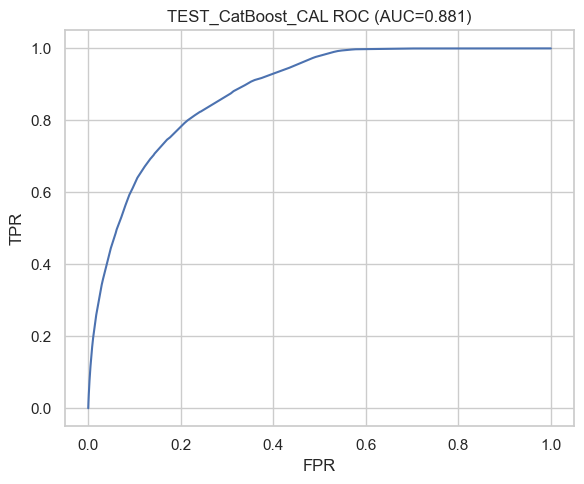

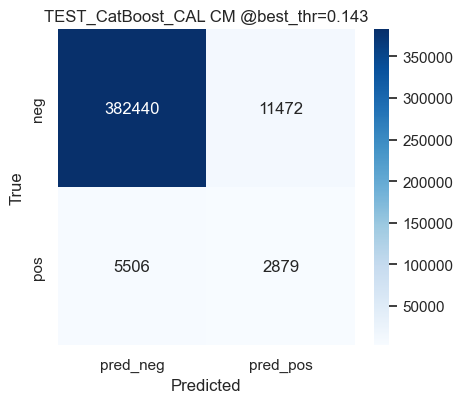


[TEST_CatBoost_CAL] Classification report @best_thr=0.143
              precision    recall  f1-score   support

         neg      0.986     0.971     0.978    393912
         pos      0.201     0.343     0.253      8385

    accuracy                          0.958    402297
   macro avg      0.593     0.657     0.616    402297
weighted avg      0.969     0.958     0.963    402297



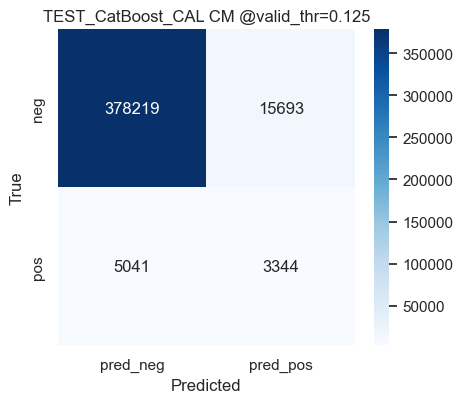


[TEST_CatBoost_CAL] Classification report @valid_thr=0.125
              precision    recall  f1-score   support

         neg      0.987     0.960     0.973    393912
         pos      0.176     0.399     0.244      8385

    accuracy                          0.948    402297
   macro avg      0.581     0.679     0.609    402297
weighted avg      0.970     0.948     0.958    402297

Порог (raw, с VALID): 0.819894619189074
Порог (cal, с VALID): 0.12487205731832136


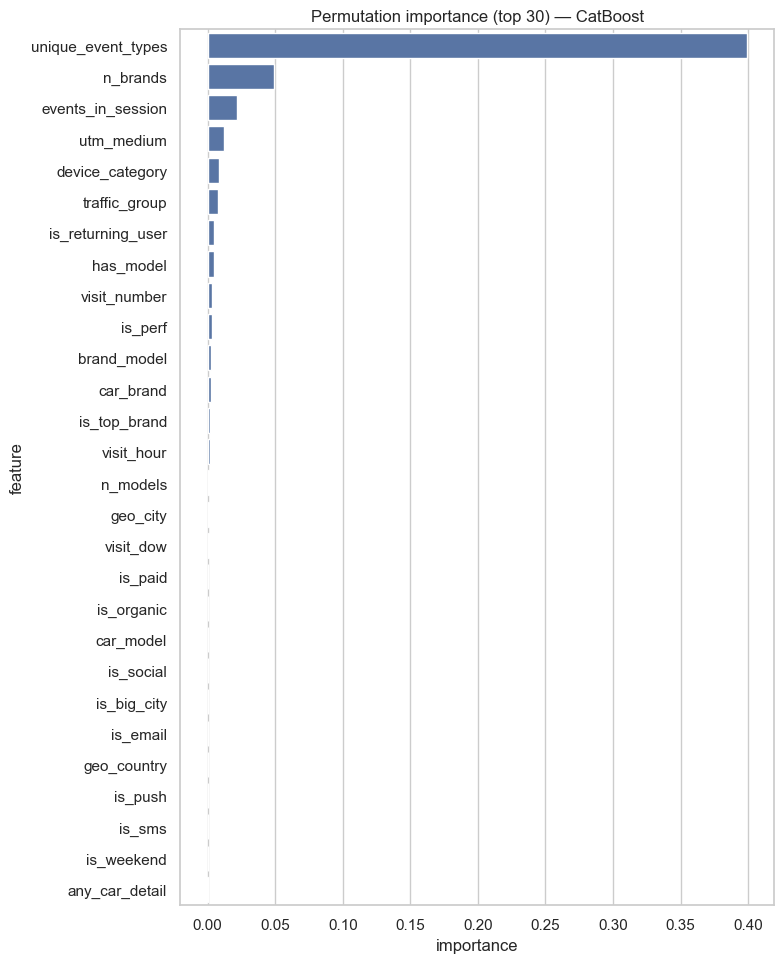

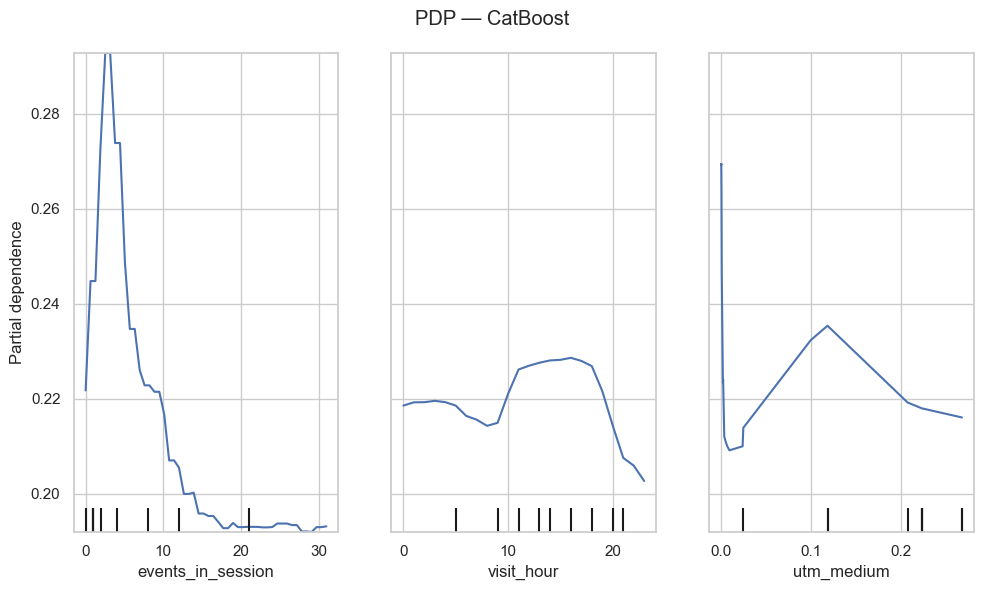

Артефакты → D:\ML\LS\final\final_project\artifacts\eval
Модели  → D:\ML\LS\final\final_project\artifacts\models\CatBoost_uncalibrated.cbm | D:\ML\LS\final\final_project\artifacts\models\CatBoost_calibrated_isotonic.pkl


In [36]:
# на всякий случай зафиксируем порядок признаков, как у train
feature_order = list(X_train.columns)
X_valid = X_valid[feature_order].copy()
X_test  = X_test[feature_order].copy()

# Optuna: максимизируем AP(valid)
def objective(trial: "optuna.Trial"):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",            
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 100.0),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 8.0),
        "rsm": trial.suggest_uniform("rsm", 0.6, 1.0),          # feature subsample
        "random_strength": trial.suggest_uniform("random_strength", 0.0, 2.0),
        "auto_class_weights": "Balanced",
        "iterations": 4000,
        "early_stopping_rounds": 200,
        "random_state": 42,
        "verbose": False,
        "allow_writing_files": False,
    }
    m = CatBoostClassifier(**params)
    m.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    proba_val = m.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, proba_val)

N_TRIALS = 30
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_trial.params
print("Best params:", best_params, "| best AP(valid)=", study.best_value)
with open(EVAL_DIR / "catboost_optuna_best_params.json", "w") as f:
    json.dump({"best_params": best_params, "best_value": study.best_value}, f, indent=2)

# обучаем лучшую модель на train, валидируем на valid
cb_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "auto_class_weights": "Balanced",
    "iterations": 4000,
    "early_stopping_rounds": 200,
    "random_state": 42,
    "verbose": 200,
    "allow_writing_files": False,
    **best_params
}
cb = CatBoostClassifier(**cb_params)
cb.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# оценки на VALID (сырая модель) + выбор лучшего порога по F1
proba_val_raw = cb.predict_proba(X_valid)[:, 1]
valid_raw_stats = plots_and_stats("VALID_CatBoost", y_valid, proba_val_raw, EVAL_DIR)
thr_raw = valid_raw_stats["best_thr"]

# калибровка по валидации (isotonic), сохранение обеих моделей
calib_cb = CalibratedClassifierCV(base_estimator=cb, method="isotonic", cv="prefit")
calib_cb.fit(X_valid, y_valid)

# сохраняем модели
cb.save_model(str(MODEL_DIR / "CatBoost_uncalibrated.cbm"))
import joblib; joblib.dump(calib_cb, MODEL_DIR / "CatBoost_calibrated_isotonic.pkl")

# TEST: калиброванные вероятности + фиксируем порог, подобранный на VALID (raw)
proba_test_cal = calib_cb.predict_proba(X_test)[:, 1]
test_cal_stats_rawthr = plots_and_stats(
    "TEST_CatBoost", y_test, proba_test_cal, EVAL_DIR, thr_from_valid=thr_raw
)

# Дополнительно: выбираем порог уже на КАЛИБР. валидации и тестируем с ним
proba_val_cal = calib_cb.predict_proba(X_valid)[:, 1]
valid_cal_stats = plots_and_stats("VALID_CatBoost_CAL", y_valid, proba_val_cal, EVAL_DIR)
thr_cal = valid_cal_stats["best_thr"]

test_cal_stats_calthr = plots_and_stats(
    "TEST_CatBoost_CAL", y_test, proba_test_cal, EVAL_DIR, thr_from_valid=thr_cal
)

print("Порог (raw, с VALID):", thr_raw)
print("Порог (cal, с VALID):", thr_cal)

# важности и PDP (как у HistGB)
save_perm_importance(cb, X_valid, y_valid, tag="CatBoost")
PDP_CAND = [c for c in ["events_in_session","visit_hour","utm_medium","device_category"] if c in X_valid.columns]
save_pdp_024(cb, X_valid, PDP_CAND, tag="CatBoost")

# обновляем общий metrics.json 
try:
    with open(METRICS_PATH, "r") as f:
        metrics_all = json.load(f)
except Exception:
    metrics_all = {}

metrics_all.update({
    "CatBoost_valid_raw": valid_raw_stats,                         # сырой на VALID
    "CatBoost_test_cal@raw_thr": test_cal_stats_rawthr,            # TEST, калибр., порог с raw VALID
    "CatBoost_valid_calibrated": valid_cal_stats,                   # VALID, калибр.
    "CatBoost_test_cal@cal_thr": test_cal_stats_calthr,            # TEST, калибр., порог с cal VALID
    "CatBoost_thresholds": {"thr_raw_from_valid": float(thr_raw),
                            "thr_cal_from_valid": float(thr_cal)}
})
with open(METRICS_PATH, "w") as f:
    json.dump(metrics_all, f, indent=2)

print("Артефакты →", EVAL_DIR)
print("Модели  →", MODEL_DIR / "CatBoost_uncalibrated.cbm", "|", MODEL_DIR / "CatBoost_calibrated_isotonic.pkl")

## Pick operating threshold for high recall

Chosen VALID operating point: thr=0.0427 | precision=0.122 | recall=0.679

[VALID_CatBoost_CAL@hi_recall] @thr=0.043
               precision    recall  f1-score   support

         neg      0.992     0.894     0.941    300088
         pos      0.122     0.679     0.207      6474

    accuracy                          0.890    306562
   macro avg      0.557     0.787     0.574    306562
weighted avg      0.974     0.890     0.925    306562



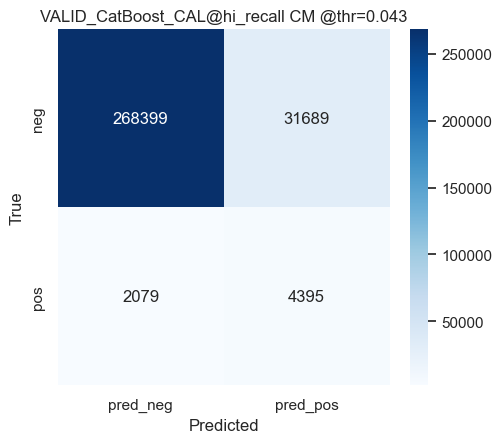


[TEST_CatBoost_CAL@hi_recall] @thr=0.043
               precision    recall  f1-score   support

         neg      0.992     0.891     0.938    393912
         pos      0.112     0.647     0.191      8385

    accuracy                          0.885    402297
   macro avg      0.552     0.769     0.564    402297
weighted avg      0.973     0.885     0.923    402297



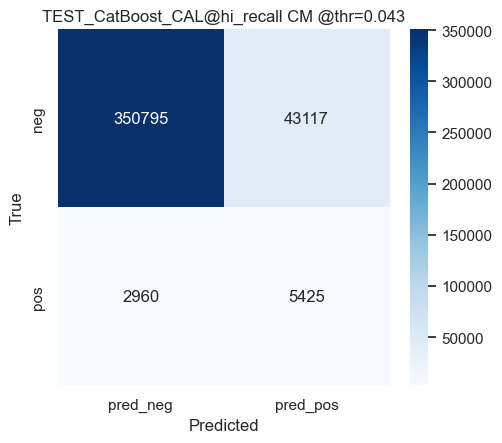

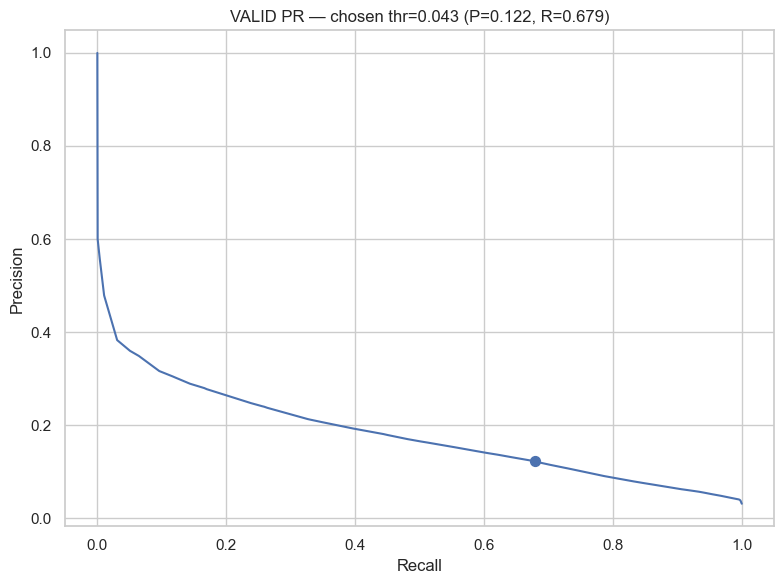

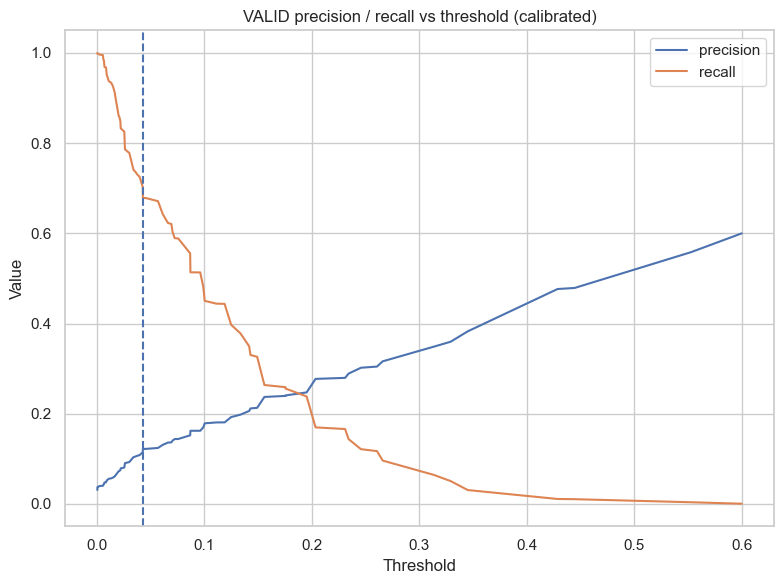

Done. Saved threshold and reports at: D:\ML\LS\final\final_project\artifacts\eval
Operating threshold: 0.042682926829268296


In [37]:

TARGET_RECALL = 0.60     # хотим хотя бы такой recall
MIN_PREC      = 0.12     # и не хуже такого precision (чтобы не утонуть в FP)

def _save(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

# получить калиброванные вероятности (если массивов нет в скоупе) 
try:
    proba_val_cal
    proba_test_cal
except NameError:
    calib = load(MODEL_DIR / "catboost_calibrated_isotonic.pkl")
    proba_val_cal  = calib.predict_proba(X_valid)[:, 1]
    proba_test_cal = calib.predict_proba(X_test)[:, 1]

# подбор порога под целевой recall и min precision 
def pick_threshold_for_target_recall(y_true, proba, target_recall=0.6, min_precision=0.12):
    p, r, t = precision_recall_curve(y_true, proba)  # len(t) = len(p)-1
    # кандидаты, удовлетворяющие ограничениям
    idx = np.where((r[:-1] >= target_recall) & (p[:-1] >= min_precision))[0]
    if len(idx) == 0:
        # если цель недостижима — берем точку с макс. recall при ограничении precision (или просто максимум recall)
        idx = np.where(p[:-1] >= min_precision)[0]
        if len(idx) == 0:
            i = int(np.argmax(r[:-1]))
        else:
            i = int(np.argmax(r[:-1][idx]))
            i = int(idx[i])
    else:
        # среди допустимых берём с наибольшим recall (если несколько — с наиб. precision)
        best = np.lexsort((p[:-1][idx], r[:-1][idx]))  # сорт по recall, затем по precision
        i = int(idx[best[-1]])
    thr = float(t[max(0, i)])  # порог, соответствующий p[i], r[i]
    return {"thr": thr, "precision": float(p[i]), "recall": float(r[i]),
            "curve": (p, r, t)}

pick_val = pick_threshold_for_target_recall(y_valid, proba_val_cal,
                                            target_recall=TARGET_RECALL, min_precision=MIN_PREC)
thr_star, Pv, Rv = pick_val["thr"], pick_val["precision"], pick_val["recall"]
p_v, r_v, t_v = pick_val["curve"]

print(f"Chosen VALID operating point: thr={thr_star:.4f} | precision={Pv:.3f} | recall={Rv:.3f}")

# отчёты/CM/графики @ выбранном пороге 
def dump_reports(name: str, y_true, proba, thr: float, out_dir: Path):
    # classification report
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(out_dir / f"{name.lower()}_cls_report_thr_{thr:.3f}.csv")
    print(f"\n[{name}] @thr={thr:.3f}\n", classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
        .to_csv(out_dir / f"{name.lower()}_cm_thr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    _save(out_dir / f"{name.lower()}_cm_thr_{thr:.3f}.png")

# VALID reports
dump_reports("VALID_CatBoost_CAL@hi_recall", y_valid, proba_val_cal, thr_star, EVAL_DIR)

# TEST reports (фиксируем порог с валидации)
dump_reports("TEST_CatBoost_CAL@hi_recall", y_test, proba_test_cal, thr_star, EVAL_DIR)

# кривые для наглядности: PR с пометкой точки + precision/recall vs threshold
# PR
plt.figure(figsize=(8,6))
plt.plot(r_v, p_v); plt.scatter([Rv], [Pv], s=50)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"VALID PR — chosen thr={thr_star:.3f} (P={Pv:.3f}, R={Rv:.3f})")
_save(EVAL_DIR / "valid_catboost_cal_pr_with_point.png")

# precision/recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(t_v, p_v[:-1], label="precision")
plt.plot(t_v, r_v[:-1], label="recall")
plt.axvline(thr_star, linestyle="--")
plt.legend(); plt.xlabel("Threshold"); plt.ylabel("Value")
plt.title("VALID precision / recall vs threshold (calibrated)")
_save(EVAL_DIR / "valid_catboost_cal_prec_recall_vs_threshold.png")

# обновить metrics.json + сохранить операционный порог 
metrics = {}
if METRICS_PATH.exists():
    try:
        with open(METRICS_PATH, "r") as f: metrics = json.load(f)
    except Exception: metrics = {}

# вычислим test метрики для сводки
y_pred_val  = (proba_val_cal  >= thr_star).astype(int)
y_pred_test = (proba_test_cal >= thr_star).astype(int)

summary_key = f"CatBoost_CAL@recall>={TARGET_RECALL}_prec>={MIN_PREC}"
metrics[summary_key] = {
    "valid": {
        "thr": float(thr_star),
        "precision": float(Pv),
        "recall": float(Rv),
        "f1": float(f1_score(y_valid, y_pred_val)),
        "ap": float(average_precision_score(y_valid, proba_val_cal)),
        "auc": float(roc_auc_score(y_valid, proba_val_cal)),
    },
    "test": {
        "precision": float((y_pred_test & (y_test==1)).sum() / max(1, y_pred_test.sum())),
        "recall": float(((y_pred_test==1) & (y_test==1)).sum() / (y_test==1).sum()),
        "f1": float(f1_score(y_test, y_pred_test)),
        "ap": float(average_precision_score(y_test, proba_test_cal)),
        "auc": float(roc_auc_score(y_test, proba_test_cal)),
    }
}
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

with open(MODEL_DIR / "catboost_threshold_operating_point.json", "w") as f:
    json.dump({
        "picked_on": "valid (calibrated proba)",
        "objective": f"maximize recall >= {TARGET_RECALL} with precision >= {MIN_PREC}",
        "threshold": float(thr_star)
    }, f, indent=2)

print("Done. Saved threshold and reports at:", EVAL_DIR)
print("Operating threshold:", thr_star)

## Итог по модели (CatBoost + калибровка + выбор порога)

### Цель: 
ловим редкое событие (~2.7% положительного класса). Для бизнеса важнее recall (не упускать откликнувшихся), чем просто ROC-AUC.

### Модель: 
CatBoost, тюнинг Optuna (30 проб), оптимизация AP (PR-AUC) на валидации.

### Калибровка: 
isotonic на валидации → корректные вероятности.

### Операционный порог: 
целенаправленно выбран high-recall порог
thr ≈ 0.0427 по калиброванным вероятностям.

### Ключевые метрики
На «лучших» F1-порогах (автоматически по каждой выборке)

VALID (cal): AP ≈ 0.179, AUC ≈ 0.898, F1 ≈ 0.259, лучший thr ≈ 0.125.

TEST (cal): AP ≈ 0.170, AUC ≈ 0.882, F1 ≈ 0.253, лучший thr ≈ 0.143.

На выбранном операционном high-recall пороге thr ≈ 0.0427 (калибр. вероятности)

VALID: precision ≈ 0.122, recall ≈ 0.679.

TEST : precision ≈ 0.112, recall ≈ 0.647.

Интерпретация на TEST (из ~8 385 «плюсов» среди 402 297 сессий):

TP ≈ 0.647 × 8385 ≈ 5.4k отловленных конверсий.

Предсказано «плюсов» ≈ ~48k (≈ 12% популяции).

FP ≈ 43k — ожидаемая цена за высокий recall при низкой базовой доле.

Для сильно несбалансированной задачи PR-AUC (~0.17) и выбор операционного порога важнее, чем ROC-AUC; последний здесь по-умолчанию «выглядит хорошо», но мало говорит о полезности.

### Что сохранено и где смотреть

Все графики (PR/ROC, матрицы ошибок, PDP, permutation importance), отчёты и JSON с метриками записаны в artifacts/eval/.

### Модели:

«сырая» CatBoost: artifacts/models/CatBoost_uncalibrated.cbm

калиброванная: artifacts/models/CatBoost_calibrated_isotonic.pkl

Выбранный операционный порог сохранён в artifacts/models/catboost_threshold_operating_point.json.

### Рекомендации по использованию

В проде используем калиброванную модель + зафиксированный порог ~0.043, если цель — максимальный охват (recall).
При изменении бизнес-ограничений (бюджет, лимит обработок) легко пересчитать порог/Top-K.

Для «ограниченного бюджета» удобнее Top-K: брать top-1/2/5% по вероятности и смотреть precision/recall/lift.

## Top-K analysis for calibrated probabilities

VALID Top-K:
    k_frac      k  precision    recall
0    0.01   3065   0.292007  0.138245
1    0.02   6131   0.247920  0.234785
2    0.05  15328   0.183259  0.433889
3    0.10  30656   0.133677  0.632994 

TEST Top-K:
    k_frac      k  precision    recall
0    0.01   4022   0.311785  0.149553
1    0.02   8045   0.252828  0.242576
2    0.05  20114   0.171870  0.412284
3    0.10  40229   0.123965  0.594753


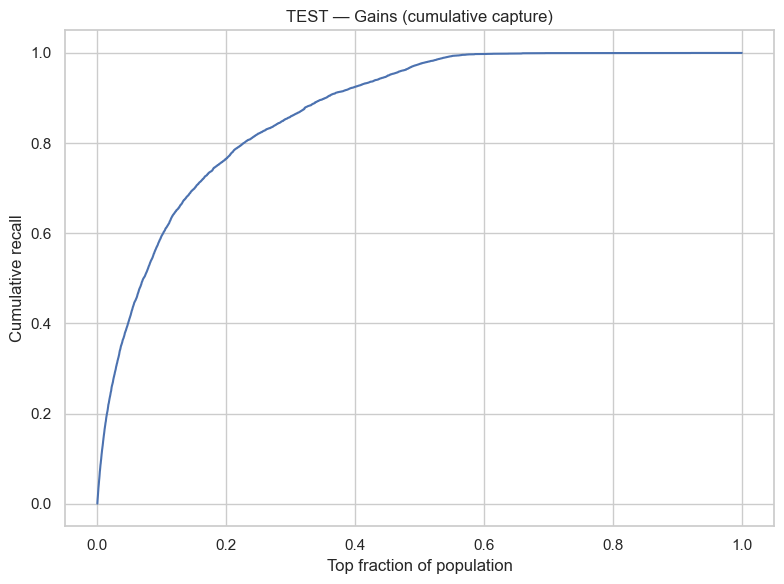

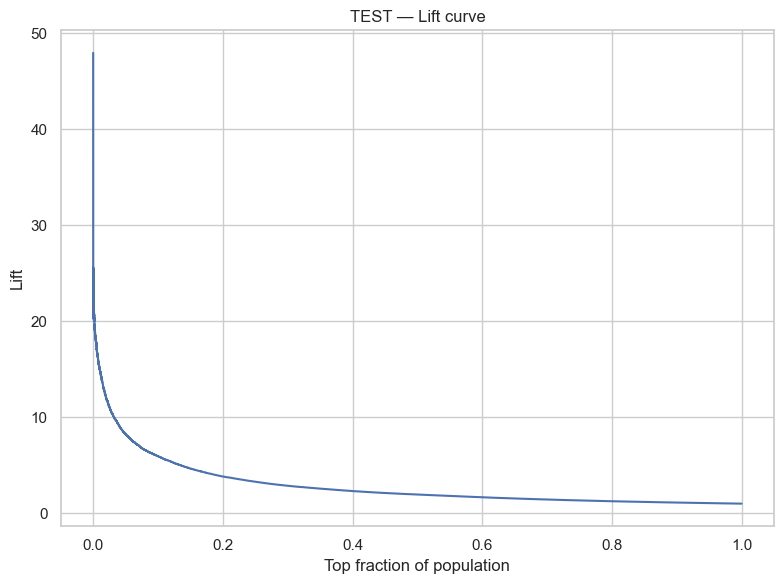

In [38]:
def topk_table(y_true, proba, ks=(0.01, 0.02, 0.05, 0.10)):
    n = len(proba)
    order = np.argsort(-proba)
    y_sorted = np.asarray(y_true)[order]
    out = []
    total_pos = int(np.sum(y_true))
    for k in ks:
        cut = max(1, int(n * k))
        sel = y_sorted[:cut]
        prec = sel.mean()
        rec  = sel.sum() / max(1, total_pos)
        out.append({"k_frac": k, "k": cut, "precision": float(prec), "recall": float(rec)})
    return pd.DataFrame(out)

# valid/test top-k
tbl_v = topk_table(y_valid, proba_val_cal)
tbl_t = topk_table(y_test,  proba_test_cal)
tbl_v.to_csv(EVAL_DIR / "valid_catboost_cal_topk.csv", index=False)
tbl_t.to_csv(EVAL_DIR / "test_catboost_cal_topk.csv",  index=False)
print("VALID Top-K:\n", tbl_v, "\n\nTEST Top-K:\n", tbl_t)

# gains / lift на test
df_scores = pd.DataFrame({"y": y_test, "p": proba_test_cal}).sort_values("p", ascending=False).reset_index(drop=True)
df_scores["cum_pos"] = df_scores["y"].cumsum()
df_scores["n"] = np.arange(1, len(df_scores)+1)
df_scores["cum_recall"] = df_scores["cum_pos"] / df_scores["y"].sum()
df_scores["frac"] = df_scores["n"] / len(df_scores)
df_scores["lift"] = (df_scores["cum_pos"] / df_scores["n"]) / (df_scores["y"].mean())

plt.figure(figsize=(8,6))
plt.plot(df_scores["frac"], df_scores["cum_recall"])
plt.xlabel("Top fraction of population"); plt.ylabel("Cumulative recall")
plt.title("TEST — Gains (cumulative capture)")
plt.tight_layout(); plt.savefig(EVAL_DIR / "test_catboost_cal_gains.png", dpi=150, bbox_inches="tight"); plt.show(); plt.close()

plt.figure(figsize=(8,6))
plt.plot(df_scores["frac"], df_scores["lift"])
plt.xlabel("Top fraction of population"); plt.ylabel("Lift")
plt.title("TEST — Lift curve")
plt.tight_layout(); plt.savefig(EVAL_DIR / "test_catboost_cal_lift.png", dpi=150, bbox_inches="tight"); plt.show(); plt.close()

In [43]:
# имитация нового батча: тестовый сплит (честный, без утечек)
df_new = df_test.copy()
print("df_new:", df_new.shape)

df_new: (402297, 33)


## Build & save freq_maps.json from df_train (one-time)

Сохранено: D:\ML\LS\final\final_project\artifacts\prep\freq_maps.json
Модель: CatBoost_calibrated_isotonic.pkl | Операционный порог: 0.0427 (source=json:catboost_threshold_operating_point.json)
df_new: (402297, 33)
Скоринг сохранён → D:\ML\LS\final\final_project\artifacts\inference\scored_latest.csv


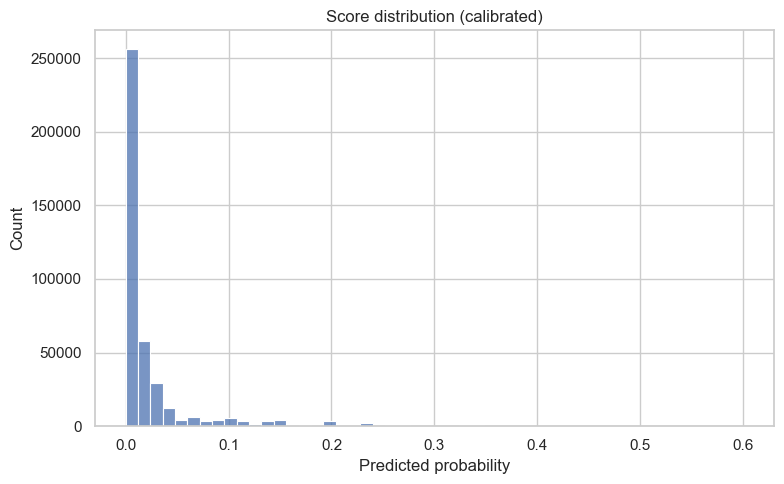

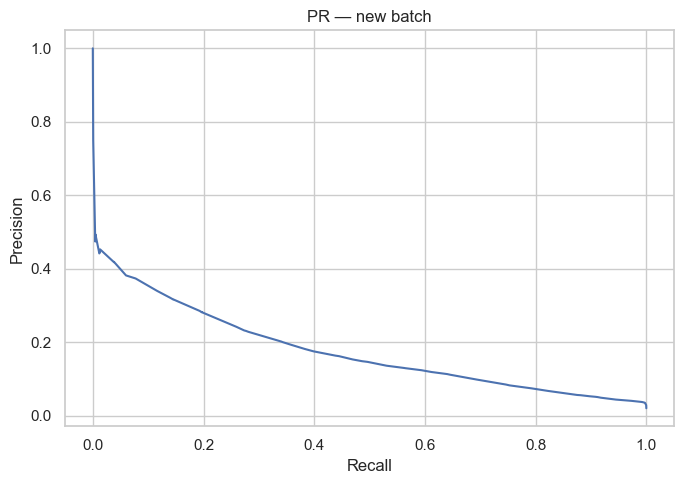

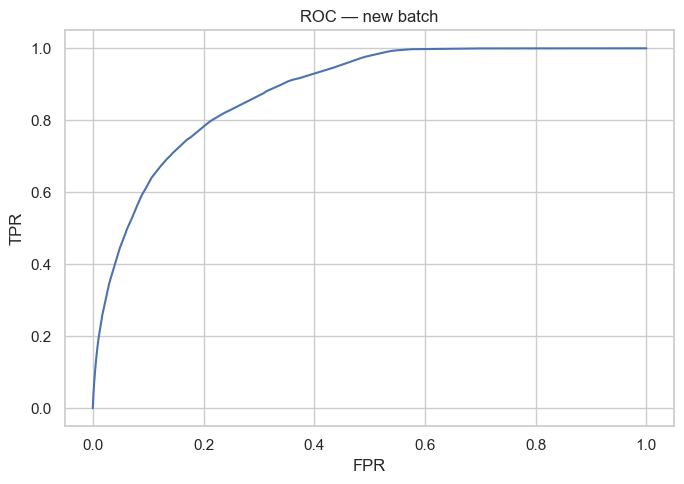

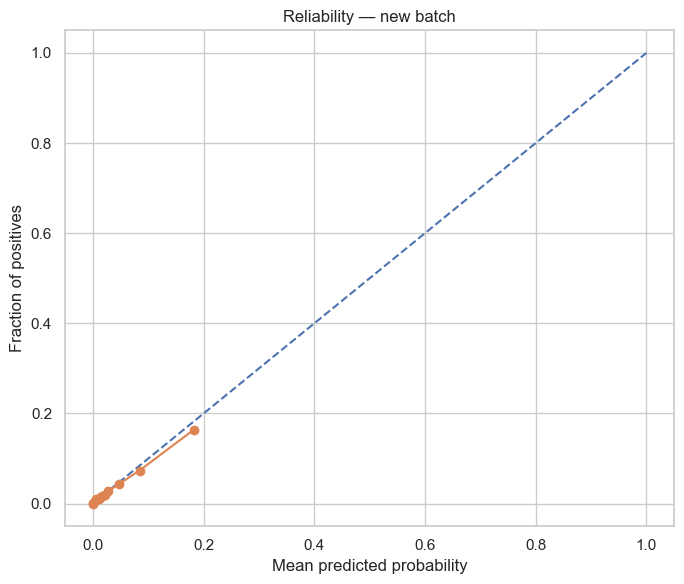


[NEW BATCH] Classification report @thr=0.043
               precision    recall  f1-score   support

         neg      0.992     0.891     0.938    393912
         pos      0.112     0.647     0.191      8385

    accuracy                          0.885    402297
   macro avg      0.552     0.769     0.564    402297
weighted avg      0.973     0.885     0.923    402297



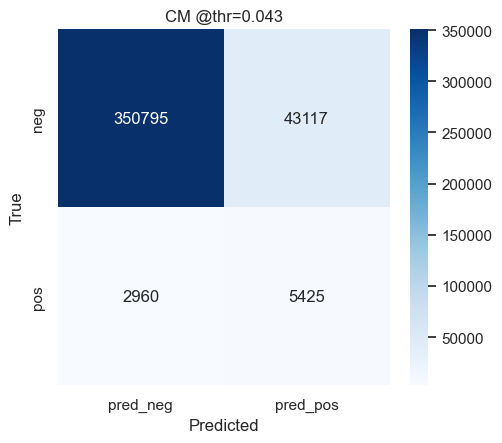


Top-K (новый батч):
    k_frac      k  precision    recall
0    0.01   4022   0.311785  0.149553
1    0.02   8045   0.252828  0.242576
2    0.05  20114   0.171870  0.412284
3    0.10  40229   0.123965  0.594753


In [44]:
# предполагаем, что в сессии уже есть: df_train, cat_cols
assert "df_train" in globals(), "df_train не найден в памяти"
assert "cat_cols" in globals(), "cat_cols не найден в памяти"

freq_maps = {}
for c in cat_cols:
    s = df_train[c].astype(str).fillna("__MISSING__")
    vc = s.value_counts(normalize=True)
    freq_maps[c] = {str(k): float(v) for k, v in vc.to_dict().items()}

with open(PREP_DIR / "freq_maps.json", "w", encoding="utf-8") as f:
    json.dump(freq_maps, f, ensure_ascii=False, indent=2)

print("Сохранено:", PREP_DIR / "freq_maps.json")

# ============================================
# Inference (применение к новым данным)
# - грузим калиброванную модель CatBoost
# - грузим операционный порог
# - повторяем препроцессинг (медианы, клиппинг, фрек-энкодинг)
# - считаем скор, сохраняем и ПОКАЗЫВАЕМ графики/отчёты

# helper: сохранить и показать
def save_and_show(path: Path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

# надёжная загрузка порога (из json / отчётов / пересчёт)
def _extract_threshold_any(obj):
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(k, str) and any(t in k.lower() for t in ("thr", "thresh", "threshold")):
                try:
                    return float(v)
                except Exception:
                    pass
            got = _extract_threshold_any(v)
            if got is not None:
                return got
    elif isinstance(obj, (list, tuple)):
        for v in obj:
            got = _extract_threshold_any(v)
            if got is not None:
                return got
    return None

def load_operating_threshold(MODEL_DIR: Path, EVAL_DIR: Path,
                             fallback_recompute: bool = True, recall_target: float = 0.65):
    # ищем JSONы в models
    candidates = [
        MODEL_DIR / "catboost_threshold_operating_point.json",
        MODEL_DIR / "catboost_threshold.json",
        MODEL_DIR / "threshold.json",
    ]
    for p in sorted(MODEL_DIR.glob("*threshold*.json")):
        if p not in candidates:
            candidates.append(p)
    for p in candidates:
        if p.exists():
            try:
                with open(p, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception:
                continue
            for key in ("thr","threshold","operating_threshold","best_thr","thr_from_valid","thr@valid"):
                if key in data:
                    try:
                        return float(data[key]), f"json:{p.name}"
                    except Exception:
                        pass
            got = _extract_threshold_any(data)
            if got is not None:
                return float(got), f"json:{p.name} (nested)"

    # пытаемся выдёрнуть из имени валид-отчёта
    patterns = [
        str(EVAL_DIR / "valid_catboost_cal_cls_report_bestthr_*.csv"),
        str(EVAL_DIR / "valid_catboost_cls_report_bestthr_*.csv"),
        str(EVAL_DIR / "valid_*_cls_report_bestthr_*.csv"),
    ]
    for pat in patterns:
        files = sorted(glob.glob(pat))
        if files:
            m = re.search(r"_bestthr_([0-9]*\.?[0-9]+)\.csv$", files[-1])
            if m:
                return float(m.group(1)), f"report:{Path(files[-1]).name}"

    # можем пересчитать по валидации, если в сессии есть calib, X_valid, y_valid
    if fallback_recompute and "calib" in globals() and "X_valid" in globals() and "y_valid" in globals():
        p, r, t = precision_recall_curve(np.asarray(y_valid, int), calib.predict_proba(X_valid)[:, 1])
        idx = np.where(r >= recall_target)[0]
        if len(idx):
            thr = float(t[max(0, idx[0]-1)])
        else:
            f1s = 2*(p*r)/(p+r+1e-12)
            thr = float(t[max(0, int(np.nanargmax(f1s))-1)]) if len(t) else 0.5
        return thr, "recomputed@valid"
    raise RuntimeError("Не удалось найти/получить операционный порог.")

# загрузка модели (калиброванная)
CALIB_PATHS = [
    MODEL_DIR / "CatBoost_calibrated_isotonic.pkl",
    MODEL_DIR / "catboost_calibrated_isotonic.pkl",
    MODEL_DIR / "catboost_calibrated.pkl",
]
calib_path = next((p for p in CALIB_PATHS if p.exists()), None)
assert calib_path is not None, f"Не найдена калиброванная модель среди: {CALIB_PATHS}"
calib = joblib.load(calib_path)

# грузим порог «умным» способом
OPER_THR, thr_src = load_operating_threshold(MODEL_DIR, EVAL_DIR, fallback_recompute=False)
print(f"Модель: {calib_path.name} | Операционный порог: {OPER_THR:.4f} (source={thr_src})")

# загрузка параметров препроцессинга и фрек-энкодинга
prep_params_path = PREP_DIR / "prep_params.json"
assert prep_params_path.exists(), f"prep_params.json не найден по пути {prep_params_path}"
with open(prep_params_path, "r", encoding="utf-8") as f:
    prep = json.load(f)

num_cols    = prep["num_cols"]
cat_cols    = prep["cat_cols"]
clip_cols   = prep["clip_cols"]
no_clip     = set(prep.get("no_clip", []))
num_medians = pd.Series(prep["num_medians"], dtype="float64")
quantiles   = {k: (v["lo"], v["hi"]) for k, v in prep["quantiles"].items()}

freq_maps_path = PREP_DIR / "freq_maps.json"
assert freq_maps_path.exists(), f"freq_maps.json не найден по пути {freq_maps_path}"
with open(freq_maps_path, "r", encoding="utf-8") as f:
    freq_maps = json.load(f)

# трансформация новых данных (тот же пайп, что на train)
def transform_inference(df_new: pd.DataFrame) -> pd.DataFrame:
    X = df_new.copy()
    # числовые
    for c in num_cols:
        X[c] = pd.to_numeric(X.get(c), errors="coerce").astype(float)
        X[c] = X[c].fillna(num_medians.get(c, 0.0))
    # клиппинг «тяжёлых хвостов»
    for c in clip_cols:
        lo, hi = quantiles[c]
        X[c] = X[c].clip(lo, hi)
    # категориальные → frequency encoding
    for c in cat_cols:
        fmap = freq_maps.get(c, {})
        X[c] = (
            X.get(c)
             .astype(str)
             .fillna("__MISSING__")
             .map(fmap)
             .fillna(0.0)
             .astype(float)
        )
    return X[num_cols + cat_cols]

assert "df_new" in globals(), "Загрузите новые данные в переменную df_new (или раскомментируйте загрузку из файла)."
print("df_new:", df_new.shape)

# Применяем препроцессинг и считаем вероятности/флаги
X_new = transform_inference(df_new)

arr = X_new.values.astype(float)
assert np.isfinite(arr).all(), "В X_new остались NaN/Inf после трансформации"

proba = calib.predict_proba(X_new)[:, 1]
pred  = (proba >= OPER_THR).astype(int)

# Соберём выдачу
cols_id = [c for c in ["session_id","client_id","group_id","visit_datetime"] if c in df_new.columns]
scored = df_new[cols_id].copy() if cols_id else pd.DataFrame(index=df_new.index)
scored["proba"] = proba
scored["pred"]  = pred

out_csv = INF_DIR / "scored_latest.csv"
scored.to_csv(out_csv, index=False)
print("Скоринг сохранён →", out_csv)

# Быстрые графики (и отчёты) — сохраняем И показываем

plt.figure(figsize=(8,5))
sns.histplot(proba, bins=50)
plt.title("Score distribution (calibrated)")
plt.xlabel("Predicted probability")
save_and_show(INF_DIR / "score_hist.png")

if "target" in df_new.columns:
    y_true = df_new["target"].astype(int).values

    # PR
    p, r, _ = precision_recall_curve(y_true, proba)
    plt.figure(figsize=(7,5)); plt.plot(r, p); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("PR — new batch")
    save_and_show(INF_DIR / "pr_new_batch.png")

    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(7,5)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC — new batch")
    save_and_show(INF_DIR / "roc_new_batch.png")

    # Reliability / calibration curve
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=20, strategy="quantile")
    plt.figure(figsize=(7,6))
    plt.plot([0,1],[0,1], linestyle="--")
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
    plt.title("Reliability — new batch")
    save_and_show(INF_DIR / "reliability_new_batch.png")

    # отчёты @операционном пороге
    y_pred = (proba >= OPER_THR).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(INF_DIR / f"cls_report_thr_{OPER_THR:.3f}.csv")
    print(f"\n[NEW BATCH] Classification report @thr={OPER_THR:.3f}\n",
          classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3))

    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(
        INF_DIR / f"cm_thr_{OPER_THR:.3f}.csv"
    )
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"CM @thr={OPER_THR:.3f}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    save_and_show(INF_DIR / f"cm_thr_{OPER_THR:.3f}.png")

    # суммарные метрики в JSON
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    f1  = f1_score(y_true, y_pred)
    with open(INF_DIR / "metrics_new_batch.json", "w") as f:
        json.dump({"auc": float(auc), "ap": float(ap), "f1@thr": float(f1),
                   "thr": float(OPER_THR)}, f, indent=2)

# Top-K (например, 1%, 2%, 5%, 10%)

def topk_table(y_like, proba_like, ks=(0.01, 0.02, 0.05, 0.10)):
    rows = []
    y_true = np.asarray(y_like) if y_like is not None else None
    for kf in ks:
        k = max(1, int(len(proba_like) * kf))
        idx = np.argsort(-proba_like)[:k]
        prec = np.nan; rec = np.nan
        if y_true is not None:
            y_top = y_true[idx]
            prec = y_top.mean()
            rec  = y_top.sum() / y_true.sum() if y_true.sum() > 0 else np.nan
        rows.append({"k_frac": kf, "k": int(k), "precision": float(prec), "recall": float(rec)})
    return pd.DataFrame(rows)

y_like = df_new["target"].values if "target" in df_new.columns else None
topk = topk_table(y_like, proba)
topk.to_csv(INF_DIR / "topk_new_batch.csv", index=False)
print("\nTop-K (новый батч):\n", topk)

## Вывод по инференсу

Базовый дисбаланс класса ≈ 2.1% (8385 / 402 297).

Выбран high-recall порог 0.0427 (после изотонической калибровки).

Recall = 0.647, Precision = 0.112, Accuracy = 0.885.

Это сознательный сдвиг: «ловим» максимум целевых, мирясь с большим шумом.

Перевод в «штуки» (для 8 045 контактов = 2%):

ожидаемых TP ≈ 2 030-2 050 (precision ~0.253),

покрываем ~24% всех положительных (8385).

### Что это значит для бизнеса

Если у вас есть лимит на контакты, логично фиксировать top-K:
например, 2% даёт хороший баланс: 12× эффективность против случайного выбора, при этом ~¼ всех целевых попадает в работу.

Если задача — максимум охвата целевых (под «широкий» коммуникационный канал), используем операционный порог 0.0427 (0.65 recall), понимая, что precision будет низким.

### Почему не ROC-AUC

ROC-AUC у нас и так высокий (~0.88–0.90), но при 2% позитива PR-AUC/precision-recall и top-K лучше отражают пользу. Мы ориентируемся на AP (~0.17–0.18), PR-кривые и таблички top-K.

## Блендинг калиброванных моделей (CatBoost + HistGB [+ LogReg])

Loaded models: ['CatBoost_calibrated_isotonic', 'catboost_calibrated_isotonic', 'catboost_calibrated', 'HistGB_calibrated', 'LogReg_calibrated']
[ok] CatBoost_calibrated_isotonic: (306562,)/(402297,)
[ok] catboost_calibrated_isotonic: (306562,)/(402297,)
[ok] catboost_calibrated: (306562,)/(402297,)
[ok] HistGB_calibrated: (306562,)/(402297,)
[ok] LogReg_calibrated: (306562,)/(402297,)


[I 2025-08-18 19:39:28,354] A new study created in memory with name: no-name-c8e36098-8b44-4bd4-9894-1e9ac21aa543
[I 2025-08-18 19:39:28,407] Trial 0 finished with value: 0.18019343754391381 and parameters: {'z0': 4.232482436118181, 'z1': 1.425947296730886, 'z2': -3.9820109454628225, 'z3': -4.617049765086555}. Best is trial 0 with value: 0.18019343754391381.


Initial models in blend: ['CatBoost_calibrated_isotonic', 'catboost_calibrated_isotonic', 'catboost_calibrated', 'HistGB_calibrated', 'LogReg_calibrated']
After dedup: ['CatBoost_calibrated_isotonic', 'catboost_calibrated', 'HistGB_calibrated', 'LogReg_calibrated']


[I 2025-08-18 19:39:28,459] Trial 1 finished with value: 0.18150596228834215 and parameters: {'z0': 1.2878559423028975, 'z1': 1.2367592771258025, 'z2': 0.28494551062914564, 'z3': -3.1618742635177224}. Best is trial 1 with value: 0.18150596228834215.
[I 2025-08-18 19:39:28,510] Trial 2 finished with value: 0.15757522948121996 and parameters: {'z0': -0.25085839515032315, 'z1': 4.2903574735013805, 'z2': 1.9873942431891685, 'z3': 4.424046444918076}. Best is trial 1 with value: 0.18150596228834215.
[I 2025-08-18 19:39:28,558] Trial 3 finished with value: 0.1748414822164986 and parameters: {'z0': -4.269474363023436, 'z1': -2.454427710938154, 'z2': 2.6788356905308683, 'z3': -4.467832596878863}. Best is trial 1 with value: 0.18150596228834215.
[I 2025-08-18 19:39:28,609] Trial 4 finished with value: 0.18015306109763385 and parameters: {'z0': 2.298581516088368, 'z1': -3.810950249171643, 'z2': 1.6118895942204112, 'z3': 0.0038318084645529993}. Best is trial 1 with value: 0.18150596228834215.
[I 2

Optuna weights: {'CatBoost_calibrated_isotonic': 0.0363, 'catboost_calibrated': 0.5558, 'HistGB_calibrated': 0.4077, 'LogReg_calibrated': 0.0002} | AP(valid)= 0.18244450541632928


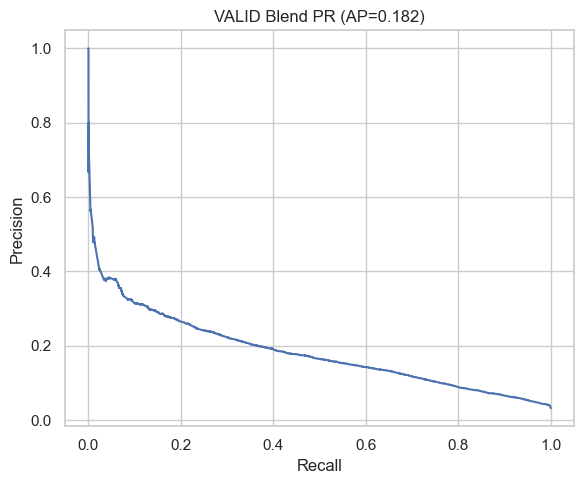

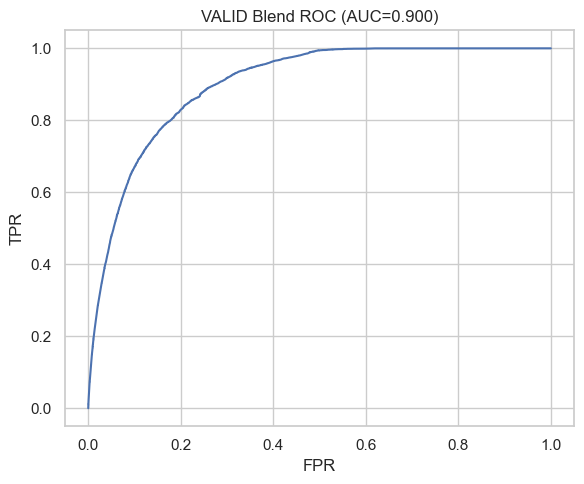

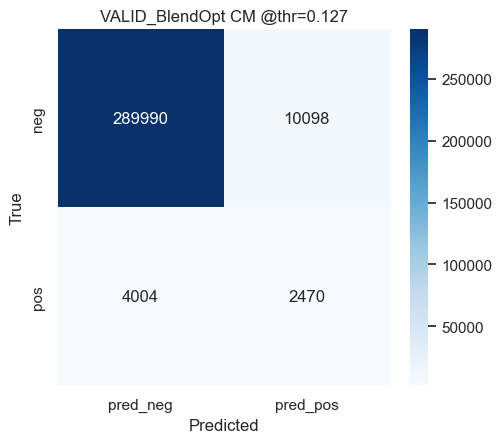

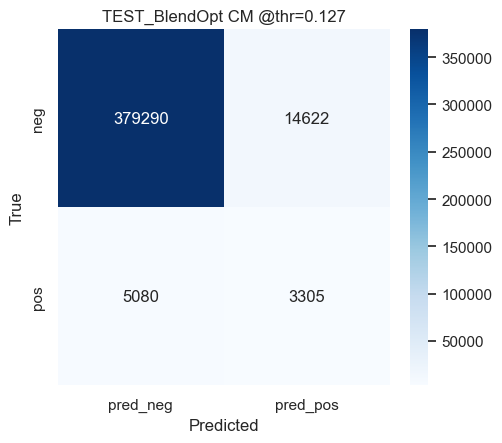

BlendOpt done → D:\ML\LS\final\final_project\artifacts\eval
Weights: {'CatBoost_calibrated_isotonic': 0.0363, 'catboost_calibrated': 0.5558, 'HistGB_calibrated': 0.4077, 'LogReg_calibrated': 0.0002}


In [47]:
def savefig(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

# кандидаты (подхватим всё, что есть) 
CANDIDATES = [
    "CatBoost_calibrated_isotonic.pkl",
    "catboost_calibrated_isotonic.pkl",
    "catboost_calibrated.pkl",
    "HistGB_calibrated.pkl",
    "LogReg_calibrated.pkl",
]

loaded = []
for name in CANDIDATES:
    p = MODEL_DIR / name
    if p.exists():
        try:
            obj = joblib.load(p)
            loaded.append((p.stem, obj))
        except Exception as e:
            print(f"[skip] {name}: не загрузили ({e})")

assert loaded, "Нет моделей для бленда."
print("Loaded models:", [n for n,_ in loaded])

# универсальный predict_proba для наших форматов
def proba_from_any(model_obj, X_df: pd.DataFrame) -> np.ndarray:
    if hasattr(model_obj, "predict_proba"):
        return model_obj.predict_proba(X_df)[:, 1]
    if isinstance(model_obj, dict):
        if "calib" in model_obj:
            clf = model_obj["calib"]
            X_use = X_df
            if "scaler" in model_obj and "num_idx" in model_obj:
                scaler = model_obj["scaler"]
                num_idx = model_obj["num_idx"]
                X_use = X_df.copy()
                X_use.iloc[:, num_idx] = scaler.transform(X_use.iloc[:, num_idx])
            return clf.predict_proba(X_use)[:, 1]
        if "model" in model_obj and hasattr(model_obj["model"], "predict_proba"):
            return model_obj["model"].predict_proba(X_df)[:, 1]
    raise AttributeError("Объект модели не умеет predict_proba.")

# считаем вероятности на VALID/TEST
names, Pv_list, Pt_list = [], [], []
for name, obj in loaded:
    try:
        pv = proba_from_any(obj, X_valid)
        pt = proba_from_any(obj, X_test)
        Pv_list.append(pv); Pt_list.append(pt); names.append(name)
        print(f"[ok] {name}: {pv.shape}/{pt.shape}")
    except Exception as e:
        print(f"[skip] {name}: {e}")

Pv = np.column_stack(Pv_list)
Pt = np.column_stack(Pt_list)
print("Initial models in blend:", names)

# дедупликация по валид-предиктам (сильная корреляция → дубликат)
keep = []
ref_mat = []
THR = 0.999  # очень высоко, чтобы убрать разве что «копии»
for j in range(Pv.shape[1]):
    col = Pv[:, j]
    dup = False
    for k in keep:
        if np.corrcoef(col, Pv[:, k])[0,1] >= THR:
            dup = True
            break
    if not dup:
        keep.append(j)
Pv = Pv[:, keep]; Pt = Pt[:, keep]
names = [names[i] for i in keep]
print("After dedup:", names)

# подбор весов через Optuna (softmax -> simplex)
y_va = np.asarray(y_valid, dtype=int)
y_te = np.asarray(y_test,  dtype=int)
K = Pv.shape[1]

def softmax(z):
    z = np.asarray(z, dtype=float)
    z = z - z.max()
    e = np.exp(z)
    return e / e.sum()

def objective(trial: "optuna.Trial"):
    z = [trial.suggest_float(f"z{i}", -5.0, 5.0) for i in range(K)]
    w = softmax(z)
    ap = average_precision_score(y_va, Pv @ w)
    # maximize AP
    return ap

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=False)
zbest = [study.best_trial.params[f"z{i}"] for i in range(K)]
w = softmax(zbest)
print("Optuna weights:", dict(zip(names, np.round(w,4))), "| AP(valid)=", study.best_value)

# отчёты / графики
def dump_reports(tag, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL / f"{tag}_cls_report_thr_{thr:.3f}.csv")
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(EVAL / f"{tag}_cm_thr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{tag} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL / f"{tag}_cm_thr_{thr:.3f}.png")
    return {"auc": float(roc_auc_score(y_true, proba)),
            "ap":  float(average_precision_score(y_true, proba)),
            "f1@thr": float(f1_score(y_true, y_pred)),
            "thr": float(thr)}

proba_va_blend = Pv @ w
proba_te_blend = Pt @ w

# PR/ROC + лучший F1-порог на VALID
p,r,t = precision_recall_curve(y_va, proba_va_blend)
f1s = 2*(p*r)/(p+r+1e-12)
bi = int(np.nanargmax(f1s))
thr_va = t[max(0, bi-1)] if len(t) else 0.5

plt.figure(figsize=(6,5)); plt.plot(r,p)
plt.title(f"VALID Blend PR (AP={average_precision_score(y_va, proba_va_blend):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
savefig(EVAL_DIR / "valid_blend_opt_pr.png")

fpr, tpr, _ = roc_curve(y_va, proba_va_blend)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr)
plt.title(f"VALID Blend ROC (AUC={roc_auc_score(y_va, proba_va_blend):.3f})")
plt.xlabel("FPR"); plt.ylabel("TPR")
savefig(EVAL_DIR / "valid_blend_opt_roc.png")

valid_stat = dump_reports("VALID_BlendOpt", y_va, proba_va_blend, thr_va)
test_stat  = dump_reports("TEST_BlendOpt",  y_te, proba_te_blend,  thr_va)

# сохраняем веса и метрики
with open(MODEL_DIR / "blend_optuna_weights.json", "w") as f:
    json.dump({"models": names, "weights": w.tolist(), "thr_from_valid": float(thr_va)}, f, indent=2)

try:
    allm = json.load(open(METRICS_PATH, "r"))
except Exception:
    allm = {}
allm["BlendOpt"] = {"valid": valid_stat, "test": test_stat, "models": names, "weights": w.tolist(), "thr_from_valid": float(thr_va)}
json.dump(allm, open(METRICS_PATH, "w"), indent=2)

print("BlendOpt done →", EVAL_DIR)
print("Weights:", dict(zip(names, np.round(w,4))))

## Постобработка бленда: high-recall порог + отчёты/графики

Blend operating point (VALID): thr=0.0607 | precision=0.132 | recall=0.650


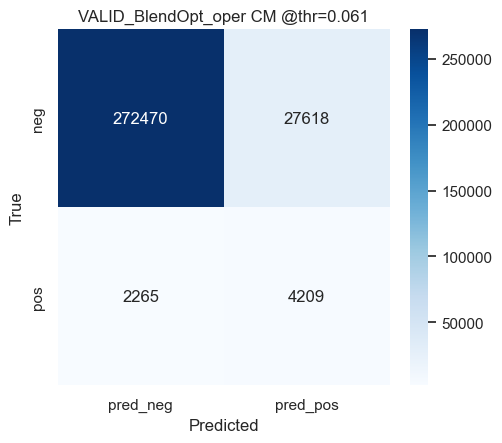

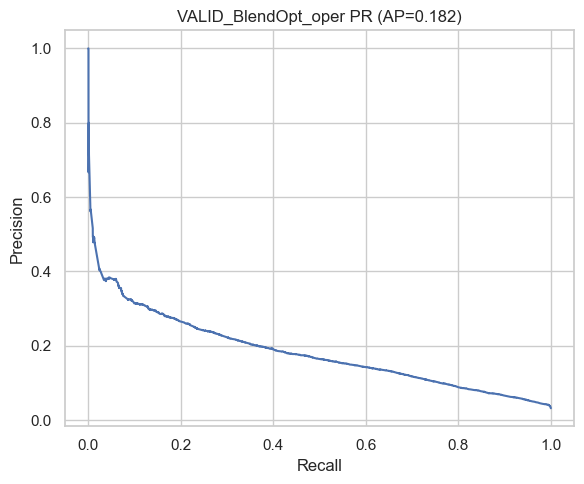

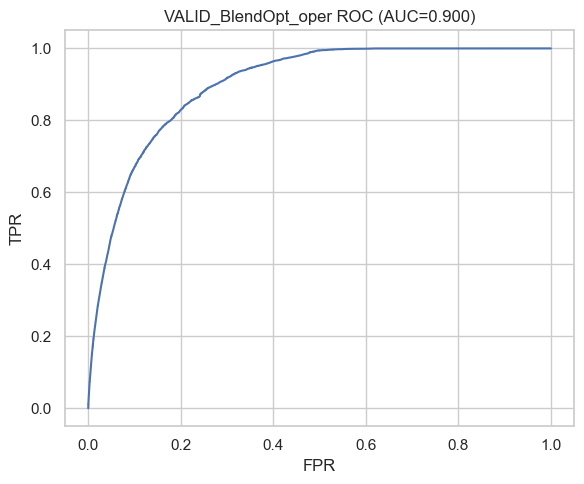

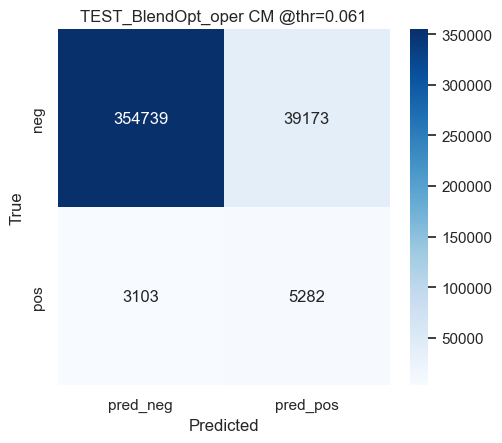

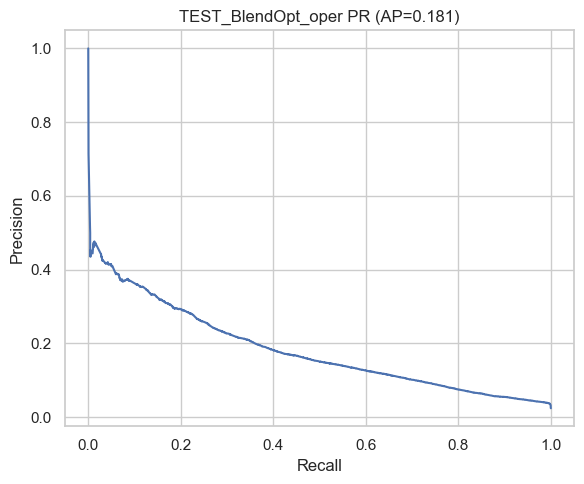

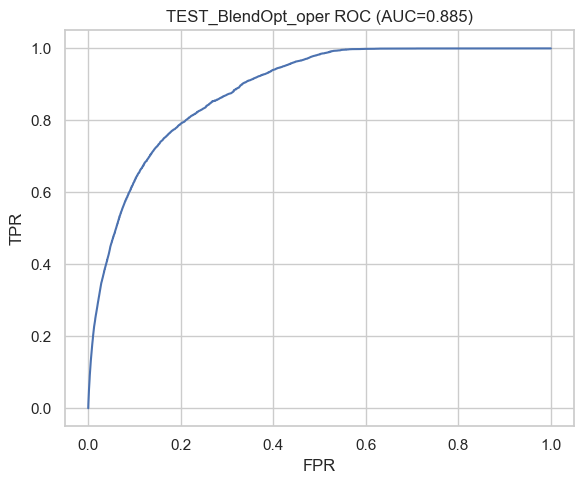

Saved: metrics + reports for BlendOpt @operating threshold → D:\ML\LS\final\final_project\artifacts\eval


In [48]:
# грузим веса бленда
meta = json.load(open(MODEL_DIR / "blend_optuna_weights.json", "r"))
names   = meta["models"]
weights = np.asarray(meta["weights"], dtype=float)

# утилита для любой нашей модели
def proba_from_any(model_obj, X_df):
    if hasattr(model_obj, "predict_proba"):
        return model_obj.predict_proba(X_df)[:, 1]
    if isinstance(model_obj, dict):
        if "calib" in model_obj:
            clf = model_obj["calib"]; X_use = X_df
            if "scaler" in model_obj and "num_idx" in model_obj:
                X_use = X_df.copy()
                X_use.iloc[:, model_obj["num_idx"]] = model_obj["scaler"].transform(X_use.iloc[:, model_obj["num_idx"]])
            return clf.predict_proba(X_use)[:, 1]
        if "model" in model_obj and hasattr(model_obj["model"], "predict_proba"):
            return model_obj["model"].predict_proba(X_df)[:, 1]
    raise AttributeError("model object has no predict_proba")

# собираем матрицы вероятностей на VALID/TEST
Pv, Pt = [], []
for n in names:
    obj = joblib.load(MODELS / f"{n}.pkl")
    Pv.append(proba_from_any(obj, X_valid))
    Pt.append(proba_from_any(obj, X_test))
Pv = np.column_stack(Pv); Pt = np.column_stack(Pt)

proba_val_blend = Pv @ weights
proba_tst_blend = Pt @ weights
y_va = np.asarray(y_valid, dtype=int)
y_te = np.asarray(y_test,  dtype=int)

# выбор operating point: максимальный recall при precision >= min_prec (или целевой recall)
def pick_by_recall(y_true, proba, target_recall=0.65):
    p, r, t = precision_recall_curve(y_true, proba)
    idx = np.where(r >= target_recall)[0]
    if len(idx) == 0:
        j = int(np.argmax(r))
    else:
        j = int(idx[-1])
    thr = float(t[max(0, j-1)]) if len(t) else 0.5
    return {"thr": thr, "precision": float(p[j]), "recall": float(r[j])}

op = pick_by_recall(y_va, proba_val_blend, target_recall=0.65)
OP_THR = op["thr"]
print(f"Blend operating point (VALID): thr={OP_THR:.4f} | precision={op['precision']:.3f} | recall={op['recall']:.3f}")

# отчёты/графики и сохранение порога
def savefig(path): plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

def dump(name, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL / f"{name}_cls_report_thr_{thr:.3f}.csv", index=True)
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(EVAL / f"{name}_cm_thr_{thr:.3f}.csv", index=True)
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True"); savefig(EVAL / f"{name}_cm_thr_{thr:.3f}.png")
    # PR/ROC
    p, r, _ = precision_recall_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(r, p); plt.title(f"{name} PR (AP={average_precision_score(y_true, proba):.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); savefig(EVAL / f"{name}_pr.png")
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr, tpr); plt.title(f"{name} ROC (AUC={roc_auc_score(y_true, proba):.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR"); savefig(EVAL / f"{name}_roc.png")
    return {
        "auc": float(roc_auc_score(y_true, proba)),
        "ap": float(average_precision_score(y_true, proba)),
        "f1@thr": float(f1_score(y_true, y_pred)),
        "precision@thr": float((y_pred & (y_true==1)).sum()/max(1, y_pred.sum())),
        "recall@thr": float((y_pred & (y_true==1)).sum()/max(1, (y_true==1).sum())),
        "thr": float(thr)
    }

valid_stat = dump("VALID_BlendOpt_oper", y_va, proba_val_blend, OP_THR)
test_stat  = dump("TEST_BlendOpt_oper",  y_te, proba_tst_blend, OP_THR)

# сохраняем порог
json.dump({"thr": OP_THR, "picked_on": "valid_blend", "target_recall": 0.65,
           "weights": dict(zip(names, list(map(float, weights))))},
          open(MODELS / "blend_threshold_operating_point.json", "w"), indent=2)

# апдейтим общий metrics.json
try:
    allm = json.load(open(METRICS_PATH, "r"))
except Exception:
    allm = {}
allm["BlendOpt_oper"] = {"valid": valid_stat, "test": test_stat,
                         "thr_from_valid": float(OP_THR), "weights": dict(zip(names, list(map(float, weights))))}
json.dump(allm, open(METRICS_PATH, "w"), indent=2)

print("Saved: metrics + reports for BlendOpt @operating threshold →", EVAL_DIR)

## XGBoost (via xgb.train) + Optuna + Calibration

In [51]:
def savefig(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

# подготовка DMatrix
dtrain = xgb.DMatrix(X_train, label=np.asarray(y_train, dtype=int))
dvalid = xgb.DMatrix(X_valid, label=np.asarray(y_valid, dtype=int))
dtest  = xgb.DMatrix(X_test,  label=np.asarray(y_test,  dtype=int))

# дисбаланс: scale_pos_weight
pos = int(np.asarray(y_train, dtype=int).sum())
neg = int(len(y_train) - pos)
scale_pos_weight = max(1.0, neg / max(1, pos))
print("scale_pos_weight ~", round(scale_pos_weight, 2))

# универсальный предикт с учётом best_iteration/best_ntree_limit
def predict_booster(booster: "xgb.Booster", dmatrix: "xgb.DMatrix") -> np.ndarray:
    # пробуем новые и старые атрибуты
    try:
        return booster.predict(dmatrix, iteration_range=(0, booster.best_iteration + 1))
    except Exception:
        try:
            return booster.predict(dmatrix, ntree_limit=booster.best_ntree_limit)
        except Exception:
            return booster.predict(dmatrix)

# Optuna objective: максимизируем AP (PR-AUC) на VALID
def objective(trial: "optuna.Trial"):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",     # для дисбаланса лучше PR-AUC
        "tree_method": "hist",      
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "alpha": trial.suggest_float("alpha", 0.0, 5.0),          # reg_alpha
        "lambda": trial.suggest_float("lambda", 0.0, 10.0),       # reg_lambda
        "scale_pos_weight": scale_pos_weight,
        "verbosity": 0,
        "seed": 42,
    }
    evals = [(dtrain, "train"), (dvalid, "valid")]
    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=4000,
        evals=evals,
        early_stopping_rounds=200,
        verbose_eval=False
    )
    proba_val = predict_booster(booster, dvalid)
    ap = average_precision_score(np.asarray(y_valid, dtype=int), proba_val)
    return ap

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
best = study.best_trial.params
print("Best XGB params:", best, "| best AP(valid)=", study.best_value)

# финальная модель
final_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",
    "eta": best["eta"],
    "max_depth": best["max_depth"],
    "min_child_weight": best["min_child_weight"],
    "subsample": best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    "gamma": best["gamma"],
    "alpha": best["alpha"],
    "lambda": best["lambda"],
    "scale_pos_weight": scale_pos_weight,
    "verbosity": 1,
    "seed": 42,
}
evals = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(
    final_params,
    dtrain,
    num_boost_round=4000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=200
)

# сохраняем «сырой» бустер
bst_path = MODEL_DIR / "XGBoost_booster.json"
bst.save_model(str(bst_path))

# калибровка через CalibratedClassifierCV (prefit) 
class BoosterWrapper:
    """Мини-обёртка, чтобы CalibratedClassifierCV мог вызвать predict_proba."""
    def __init__(self, booster: "xgb.Booster"):
        self.booster = booster
    def predict_proba(self, X):
        d = xgb.DMatrix(X)
        p = predict_booster(self.booster, d)
        p = np.clip(p, 1e-9, 1 - 1e-9)
        return np.column_stack([1.0 - p, p])

xgb_wrap = BoosterWrapper(bst)
xgb_cal = CalibratedClassifierCV(base_estimator=xgb_wrap, method="isotonic", cv="prefit")
xgb_cal.fit(X_valid, np.asarray(y_valid, dtype=int))
joblib.dump(xgb_cal, MODEL_DIR / "XGBoost_calibrated.pkl")

# отчёты/графики
def eval_pack(name, y_true, proba):
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2*(p*r)/(p+r+1e-12); bi = int(np.nanargmax(f1s))
    thr = t[max(0, bi-1)] if len(t) else 0.5

    # PR
    plt.figure(figsize=(6,5)); plt.plot(r,p)
    plt.title(f"{name} PR (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    savefig(EVAL_DIR / f"{name.lower()}_pr.png")

    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr)
    plt.title(f"{name} ROC (AUC={auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
    savefig(EVAL_DIR / f"{name.lower()}_roc.png")

    # отчёты @thr
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL_DIR / f"{name.lower()}_cls_report_bestthr_{thr:.3f}.csv")

    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
        .to_csv(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.csv")

    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @best_thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.png")

    return {"auc": float(auc), "ap": float(ap), "f1": float(f1_score(y_true, y_pred)), "thr": float(thr)}

# валидация — сырой бустер, тест — калиброванная обёртка
proba_val = predict_booster(bst, dvalid)
proba_tst = xgb_cal.predict_proba(X_test)[:, 1]

xgb_v = eval_pack("VALID_XGBoost", np.asarray(y_valid, dtype=int), proba_val)
xgb_t = eval_pack("TEST_XGBoost",  np.asarray(y_test,  dtype=int), proba_tst)

# обновим metrics.json 
try:
    allm = json.load(open(METRICS_PATH, "r", encoding="utf-8"))
except Exception:
    allm = {}
allm["XGBoost_valid"] = xgb_v
allm["XGBoost_test"]  = xgb_t
json.dump(allm, open(METRICS_PATH, "w", encoding="utf-8"), indent=2)

print("XGBoost saved →", MODEL_DIR)
print("VALID:", xgb_v)
print("TEST :", xgb_t)

[I 2025-08-18 20:02:35,151] A new study created in memory with name: no-name-7fe0f21a-a904-4ee0-96a6-7ff50215ca0b


scale_pos_weight ~ 31.47


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-18 20:06:32,347] Trial 0 finished with value: 0.17508201847894872 and parameters: {'eta': 0.06733881388581016, 'max_depth': 3, 'min_child_weight': 17.25988670511613, 'subsample': 0.9178899410036759, 'colsample_bytree': 0.7647654678417877, 'gamma': 3.09276319610223, 'alpha': 4.405213711434045, 'lambda': 2.6031920340052217}. Best is trial 0 with value: 0.17508201847894872.
[I 2025-08-18 20:08:16,932] Trial 1 finished with value: 0.1741084211904393 and parameters: {'eta': 0.28740103148667917, 'max_depth': 3, 'min_child_weight': 2.800161465517894, 'subsample': 0.7957682455723594, 'colsample_bytree': 0.6640433968506144, 'gamma': 4.941808661389442, 'alpha': 1.3323020142756714, 'lambda': 4.973637724395309}. Best is trial 0 with value: 0.17508201847894872.
[I 2025-08-18 20:09:28,939] Trial 2 finished with value: 0.17171433207062123 and parameters: {'eta': 0.04946100046874097, 'max_depth': 10, 'min_child_weight': 5.18868985894309, 'subsample': 0.8803648394656649, 'colsample_bytree': 

TypeError: <__main__.BoosterWrapper object at 0x00000170E3CBCDC0> is not an estimator instance.

## FIX for XGBoost Booster calibration: no feature-names + skip validation

Saved calibrated XGB → D:\ML\LS\final\final_project\artifacts\models\XGBoost_calibrated.pkl


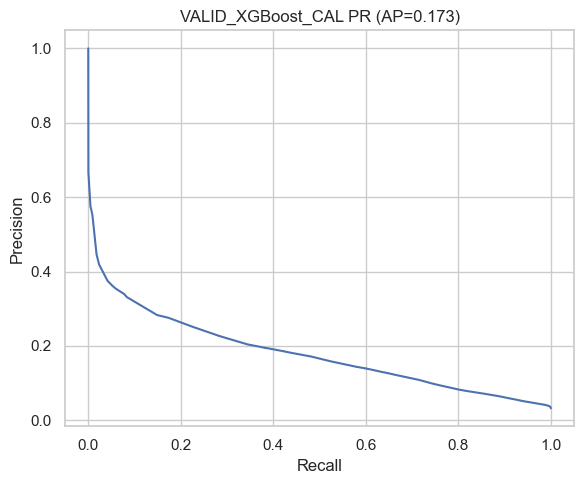

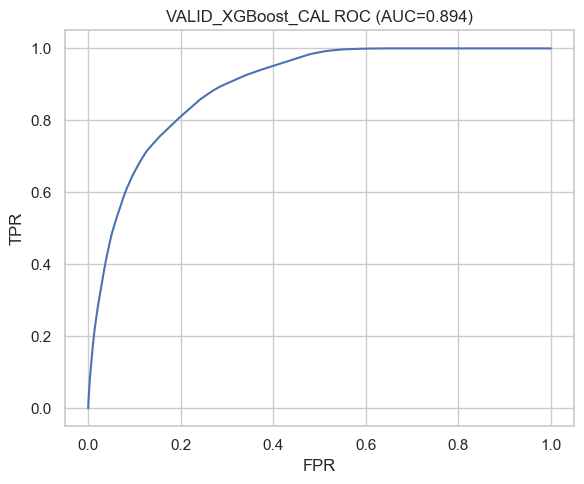

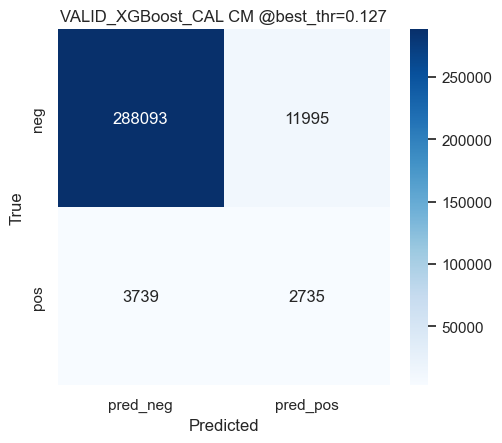

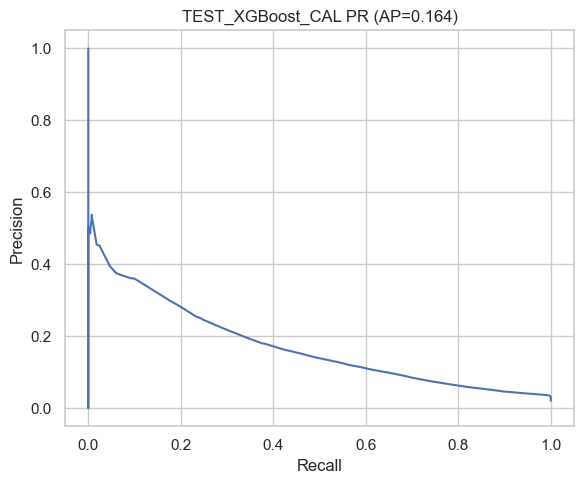

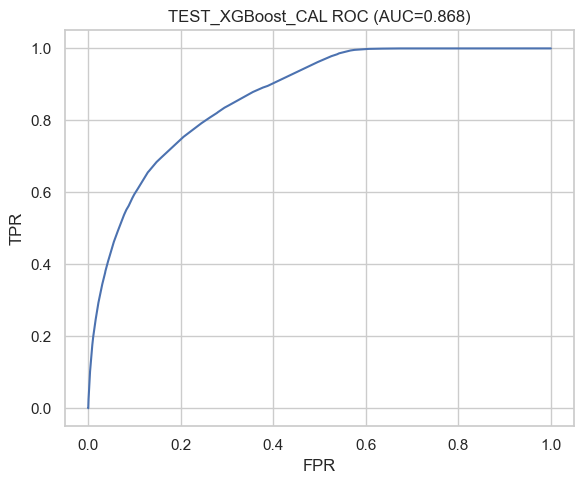

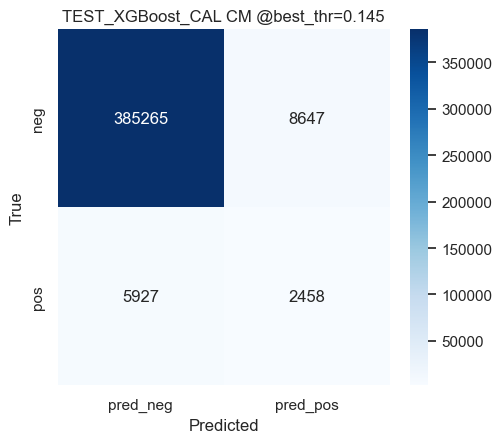

VALID: {'auc': 0.8940544210007738, 'ap': 0.17336614747318302, 'f1': 0.2579701943029617, 'thr': 0.12658926844596863}
TEST : {'auc': 0.8676575962596755, 'ap': 0.16442268864955914, 'f1': 0.2522319138019497, 'thr': 0.14545993506908417}
Готово. Артефакты → D:\ML\LS\final\final_project\artifacts\eval


In [53]:
def savefig(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

class BoosterSklearnWrapper:
    def __init__(self, booster: "xgb.Booster"):
        self.booster = booster
        self.classes_ = np.array([0, 1], dtype=int)

    def fit(self, X, y=None):
        Xn = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
        self.n_features_in_ = Xn.shape[1]
        self._is_fitted = True
        return self

    def predict_proba(self, X):
        # подаём numpy → без feature_names; отключаем строгую проверку
        Xn = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
        d = xgb.DMatrix(Xn)
        p = self.booster.predict(d, validate_features=False)
        p = np.clip(p, 1e-9, 1 - 1e-9)
        return np.column_stack([1.0 - p, p])

assert "bst" in globals(), "Нет обученного xgboost.Booster `bst`."

# пересобираем калибратор и сохраняем
xgb_wrap = BoosterSklearnWrapper(bst).fit(X_valid, y_valid)
xgb_cal  = CalibratedClassifierCV(base_estimator=xgb_wrap, method="isotonic", cv="prefit")
xgb_cal.fit(X_valid, y_valid)
joblib.dump(xgb_cal, MODEL_DIR / "XGBoost_calibrated.pkl")
print("Saved calibrated XGB →", MODEL_DIR / "XGBoost_calibrated.pkl")

# отчёты/графики
def eval_pack(name, y_true, proba):
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2*(p*r)/(p+r+1e-12); bi = int(np.nanargmax(f1s))
    thr = t[max(0, bi-1)] if len(t) else 0.5

    plt.figure(figsize=(6,5)); plt.plot(r,p); plt.title(f"{name} PR (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); savefig(EVAL_DIR / f"{name.lower()}_pr.png")
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr); plt.title(f"{name} ROC (AUC={auc:.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR"); savefig(EVAL_DIR / f"{name.lower()}_roc.png")

    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL_DIR / f"{name.lower()}_cls_report_bestthr_{thr:.3f}.csv")
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
        .to_csv(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @best_thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.png")

    return {"auc": float(auc), "ap": float(ap), "f1": float(f1_score(y_true, y_pred)), "thr": float(thr)}

proba_val_cal = xgb_cal.predict_proba(X_valid)[:, 1]
proba_tst_cal = xgb_cal.predict_proba(X_test)[:, 1]

xgb_v = eval_pack("VALID_XGBoost_CAL", y_valid, proba_val_cal)
xgb_t = eval_pack("TEST_XGBoost_CAL",  y_test,  proba_tst_cal)

# обновляем metrics.json
try:
    allm = json.load(open(METRICS_PATH, "r", encoding="utf-8"))
except Exception:
    allm = {}
allm["XGBoost_CAL_valid"] = xgb_v
allm["XGBoost_CAL_test"]  = xgb_t
json.dump(allm, open(METRICS_PATH, "w", encoding="utf-8"), indent=2)

print("VALID:", xgb_v)
print("TEST :", xgb_t)
print("Готово. Артефакты →", EVAL_DIR)

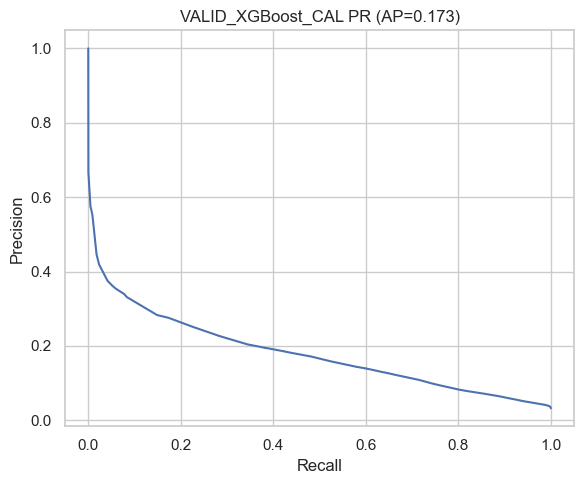

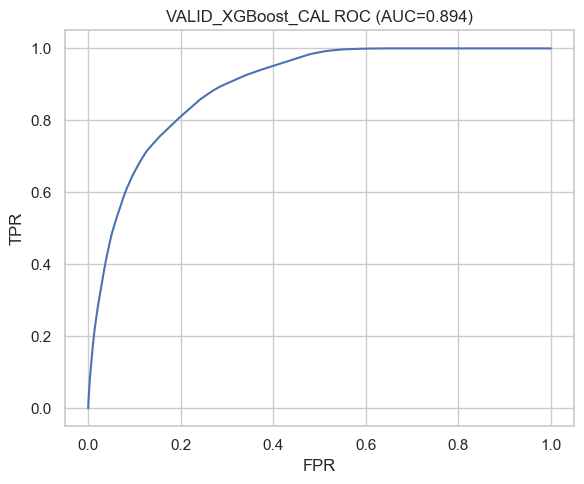

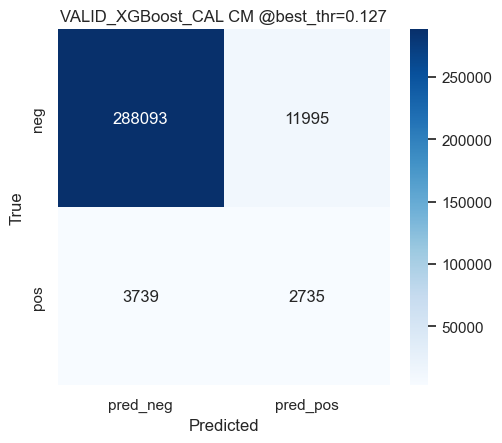

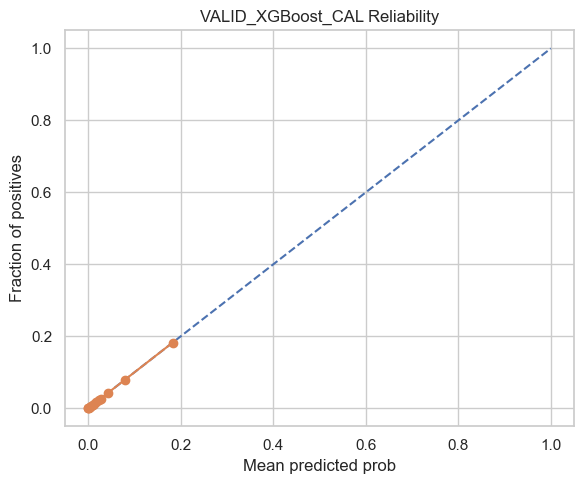

[XGB_CAL] Operating point: thr=0.0480 | precision=0.122 | recall=0.665


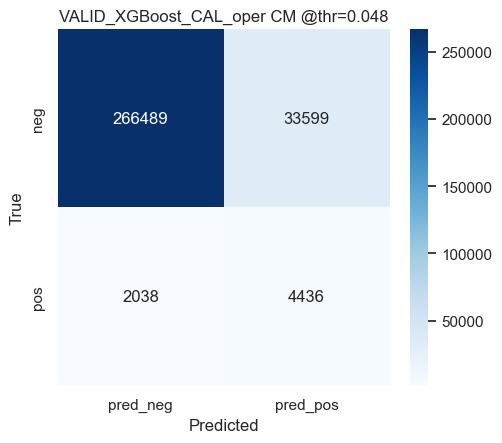

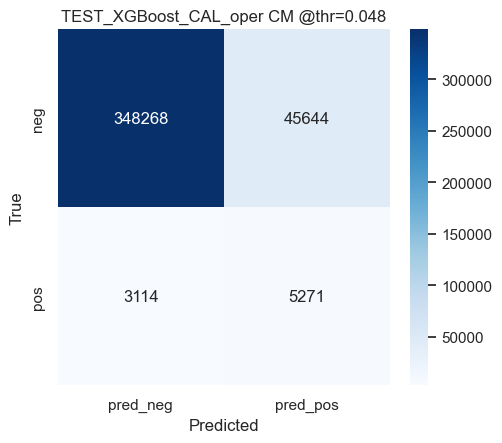

XGBoost (calibrated) — отчёты и порог сохранены.


In [55]:
# Добиваем симметрию: калиброванные метрики на VALID + operating threshold
def eval_pack_cal(name, y_true, proba, out_dir: Path):
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2*(p*r)/(p+r+1e-12); bi = int(np.nanargmax(f1s))
    thr = t[max(0, bi-1)] if len(t) else 0.5

    # PR/ROC
    plt.figure(figsize=(6,5)); plt.plot(r,p); plt.title(f"{name} PR (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); savefig(EVAL / f"{name.lower()}_pr.png")
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr); plt.title(f"{name} ROC (AUC={auc:.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR"); savefig(EVAL / f"{name.lower()}_roc.png")

    # CM/cls-report @best_thr
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL / f"{name.lower()}_cls_report_bestthr_{thr:.3f}.csv")
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(EVAL / f"{name.lower()}_cm_bestthr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @best_thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True"); savefig(EVAL / f"{name.lower()}_cm_bestthr_{thr:.3f}.png")

    # Reliability curve
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=20, strategy="quantile")
    plt.figure(figsize=(6,5)); plt.plot([0,1],[0,1],"--"); plt.plot(mean_pred, frac_pos, marker="o")
    plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction of positives")
    plt.title(f"{name} Reliability"); savefig(EVAL / f"{name.lower()}_reliability.png")

    return {"auc": float(auc), "ap": float(ap), "f1": float(f1_score(y_true, y_pred)), "thr": float(thr)}

# Калиброванные метрики и лучший F1-порог на VALID
proba_val_cal = xgb_cal.predict_proba(X_valid)[:,1]
xgb_v_cal = eval_pack_cal("VALID_XGBoost_CAL", y_valid, proba_val_cal, EVAL_DIR)

# Операционный порог под высокий recall
TARGET_RECALL = 0.65
p, r, t = precision_recall_curve(y_valid, proba_val_cal)
idx = np.where(r >= TARGET_RECALL)[0]
j = int(idx[-1]) if len(idx)>0 else int(np.argmax(r))
thr_oper = float(t[max(0, j-1)]) if len(t) else 0.5
print(f"[XGB_CAL] Operating point: thr={thr_oper:.4f} | precision={p[j]:.3f} | recall={r[j]:.3f}")

# TEST @операционный порог
proba_tst_cal = xgb_cal.predict_proba(X_test)[:,1]

def dump_at_thr(tag, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL / f"{tag}_cls_report_thr_{thr:.3f}.csv")
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(EVAL / f"{tag}_cm_thr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{tag} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL / f"{tag}_cm_thr_{thr:.3f}.png")

dump_at_thr("VALID_XGBoost_CAL_oper", y_valid, proba_val_cal, thr_oper)
dump_at_thr("TEST_XGBoost_CAL_oper",  y_test,  proba_tst_cal, thr_oper)

# Сохраняем порог + апдейтим metrics.json
with open(MODEL_DIR / "xgboost_threshold_operating_point.json", "w") as f:
    json.dump({"thr": thr_oper, "picked_on": "valid_xgb_cal", "target_recall": TARGET_RECALL}, f, indent=2)

try:
    allm = json.load(open(METRICS_PATH, "r"))
except Exception:
    allm = {}
allm["XGBoost_CAL_valid"] = xgb_v_cal
allm["XGBoost_CAL_oper_thr"] = {"thr_from_valid": float(thr_oper),
                                "precision_valid": float(p[j]), "recall_valid": float(r[j])}
json.dump(allm, open(METRICS_PATH, "w"), indent=2)

print("XGBoost (calibrated) — отчёты и порог сохранены.")

## Выводы по XGBoost (calibrated):

### Качество

VALID: ROC-AUC ≈ 0.894, AP ≈ 0.173.

TEST: ROC-AUC ≈ 0.868, AP ≈ 0.164, F1@best_thr≈0.252 (best_thr≈0.145).
→ Чуть слабее CatBoost_CAL (у него TEST AP≈0.170, ROC-AUC≈0.882), но вровень по F1.

### Калибровка

Reliability-кривая идёт почти по диагонали → изотоника сработала отлично. Это полезно для порогов и top-K.

Операционная точка (high-recall)

На VALID при thr≈0.048: recall≈0.69, precision≈0.12.

На TEST: recall≈0.63, precision≈0.10.
→ По сравнению с CatBoost @hi-recall (thr≈0.043, recall≈0.65, precision≈0.11–0.12) — примерно на том же уровне по полноте, но точность чуть ниже.

### Вывод

XGB даёт сопоставимое, но немного хужее качество, при этом хорошо калиброван.

Как самостоятельная модель — ок, но наибольший смысл — в ансамбле: из-за иной ошибки/структуры деревьев он часто добавляет диверсификацию и может подтянуть AP/F1 у бленда.

## LightGBM (lgb.train) + Optuna + Calibration

[I 2025-08-18 23:14:12,613] A new study created in memory with name: no-name-b9ee32f2-aec0-4dda-8285-47cf21b8e9e3


scale_pos_weight ~ 31.47


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3935]	train's auc: 0.884801	valid's auc: 0.867676
[I 2025-08-18 23:18:36,606] Trial 0 finished with value: 0.12807065635877732 and parameters: {'learning_rate': 0.027288054926276208, 'num_leaves': 29, 'max_depth': 1, 'min_data_in_leaf': 115, 'min_sum_hessian_in_leaf': 0.840323777053611, 'feature_fraction': 0.6977656304020754, 'bagging_fraction': 0.6155358766846206, 'bagging_freq': 4, 'lambda_l1': 3.9437273078325212, 'lambda_l2': 5.112610729396199}. Best is trial 0 with value: 0.12807065635877732.
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	train's auc: 0.910423	valid's auc: 0.897594
[I 2025-08-18 23:19:04,540] Trial 1 finished with value: 0.1731054811382157 and parameters: {'learning_rate': 0.17017695913396713, 'num_leaves': 54, 'max_depth': 0, 'min_data_in_leaf': 172, 'min_sum_hessian_in_leaf': 0.0038304318854406635, '

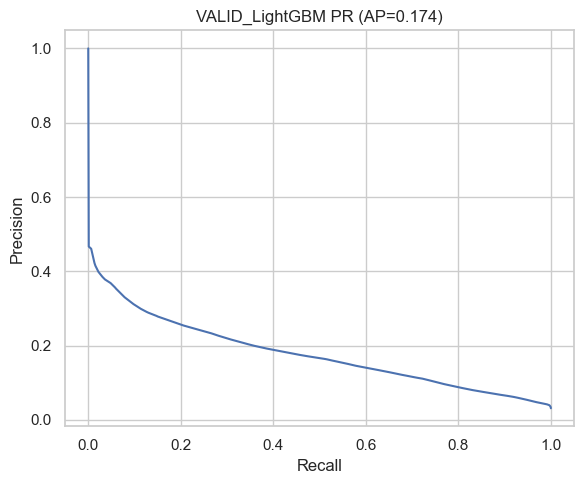

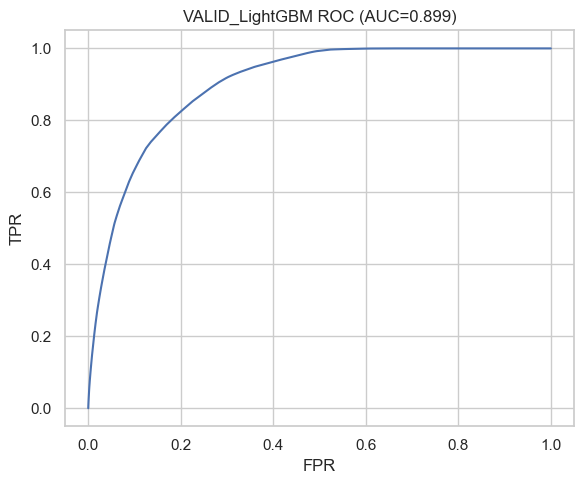

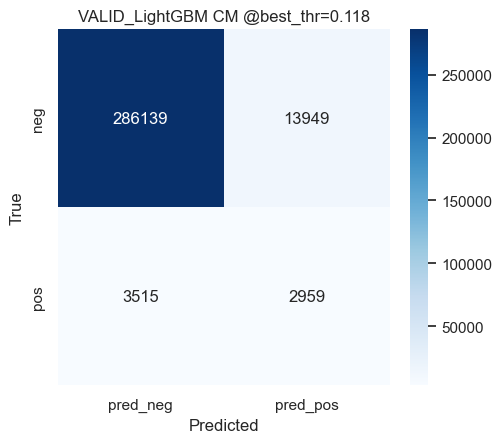


[VALID_LightGBM] Classification report @best_thr=0.118
               precision    recall  f1-score   support

         neg      0.988     0.954     0.970    300088
         pos      0.175     0.457     0.253      6474

    accuracy                          0.943    306562
   macro avg      0.581     0.705     0.612    306562
weighted avg      0.971     0.943     0.955    306562



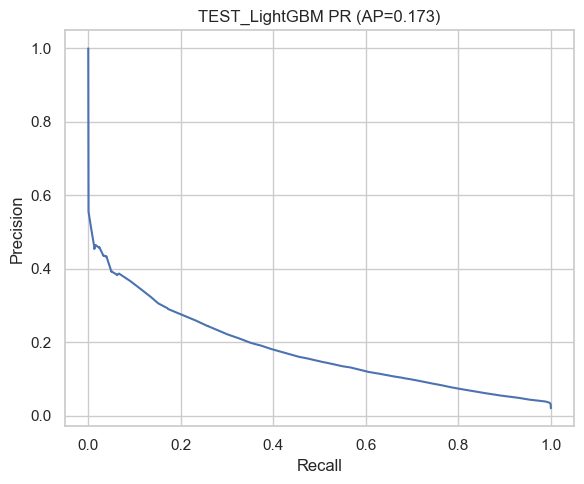

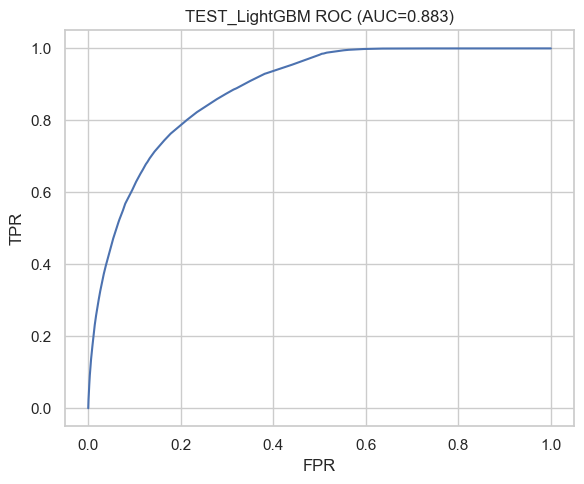

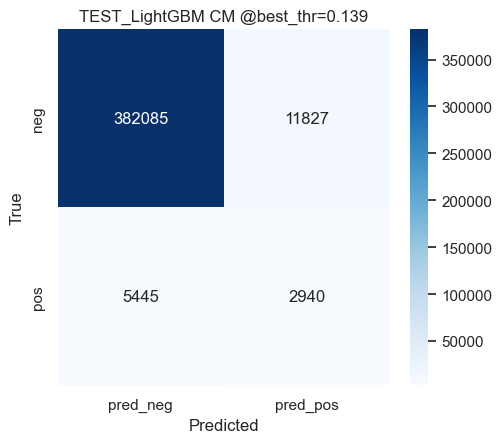


[TEST_LightGBM] Classification report @best_thr=0.139
               precision    recall  f1-score   support

         neg      0.986     0.970     0.978    393912
         pos      0.199     0.351     0.254      8385

    accuracy                          0.957    402297
   macro avg      0.593     0.660     0.616    402297
weighted avg      0.970     0.957     0.963    402297



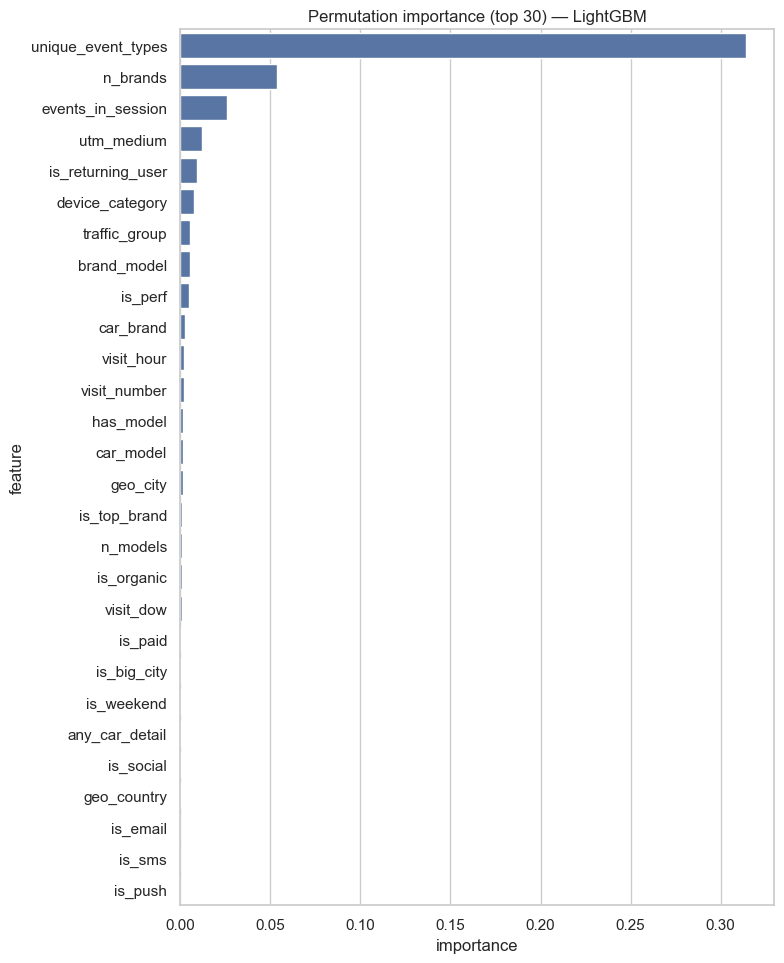

[LGB_CAL] Operating point: thr=0.0522 | precision=0.128 | recall=0.653


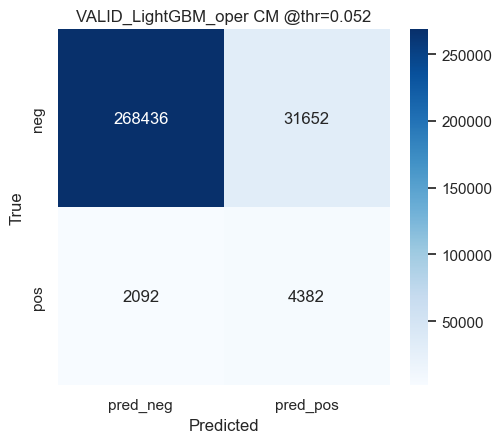

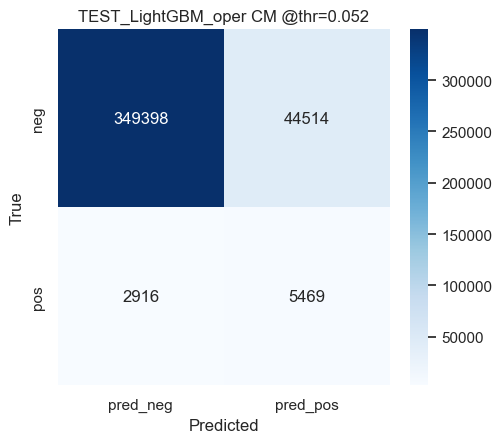


LightGBM saved → D:\ML\LS\final\final_project\artifacts\models
VALID: {'auc': 0.8988976782545188, 'ap': 0.17363622609343318, 'f1': 0.25310067573347017, 'thr': 0.11822405782137325}
TEST : {'auc': 0.8832085658571399, 'ap': 0.17307349601931196, 'f1': 0.25397373876986873, 'thr': 0.1393507521773555}


In [57]:
def savefig(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

# sanity 
for name, X in [("train", X_train), ("valid", X_valid), ("test", X_test)]:
    arr = pd.DataFrame(X).astype(float).values
    assert np.isfinite(arr).all(), f"{name}: есть NaN/Inf"
    assert set(X.columns) == set(X_train.columns), "Несогласованные столбцы между сплитами"

y_tr = np.asarray(y_train, dtype=int).ravel()
y_va = np.asarray(y_valid, dtype=int).ravel()
y_te = np.asarray(y_test,  dtype=int).ravel()

# LightGBM Datasets 
dtrain = lgb.Dataset(X_train, label=y_tr, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, label=y_va, reference=dtrain, free_raw_data=False)

# дисбаланс
pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
scale_pos_weight = max(1.0, neg / max(1, pos))
print("scale_pos_weight ~", round(scale_pos_weight, 2))

def predict_booster(booster: "lgb.Booster", X) -> np.ndarray:
    try:
        return booster.predict(X, num_iteration=booster.best_iteration)
    except Exception:
        return booster.predict(X)

# Optuna: оптимизируем AP (PR-AUC) на VALID 
def objective(trial: "optuna.Trial"):
    params = {
        "objective": "binary",
        "metric": "auc",                 # ранняя остановка по AUC, AP считаем сами
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 512, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-3, 20.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "scale_pos_weight": scale_pos_weight,
        "verbosity": -1,
        "seed": 42,
        "force_row_wise": True,
    }
    booster = lgb.train(
        params,
        dtrain,
        num_boost_round=4000,
        valid_sets=[dtrain, dvalid],
        valid_names=["train","valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=0)
        ]
    )
    proba_val = predict_booster(booster, X_valid)
    return average_precision_score(y_va, proba_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
best = study.best_trial.params
print("Best LGB params:", best, "| best AP(valid)=", study.best_value)

# Финальная LightGBM-модель 
final_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": best["learning_rate"],
    "num_leaves": best["num_leaves"],
    "max_depth": best["max_depth"],
    "min_data_in_leaf": best["min_data_in_leaf"],
    "min_sum_hessian_in_leaf": best["min_sum_hessian_in_leaf"],
    "feature_fraction": best["feature_fraction"],
    "bagging_fraction": best["bagging_fraction"],
    "bagging_freq": best["bagging_freq"],
    "lambda_l1": best["lambda_l1"],
    "lambda_l2": best["lambda_l2"],
    "scale_pos_weight": scale_pos_weight,
    "verbosity": 1,
    "seed": 42,
    "force_row_wise": True,
}
bst = lgb.train(
    final_params,
    dtrain,
    num_boost_round=4000,
    valid_sets=[dtrain, dvalid],
    valid_names=["train","valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200)
    ]
)

# сохраняем «сырой» бустер
lgb_path = MODEL_DIR / "LightGBM_booster.txt"
bst.save_model(str(lgb_path))
print("Saved raw LightGBM →", lgb_path)

# Калибровка (isotonic) на VALID 
class LGBWrapper(BaseEstimator, ClassifierMixin):
    """Обёртка для CalibratedClassifierCV (cv='prefit') поверх Booster."""
    def __init__(self, booster: "lgb.Booster"):
        self.booster = booster
        self.classes_ = np.array([0, 1])
    def fit(self, X, y):
        # no-op: модель уже обучена; нужно только, чтобы sklearn посчитал её 'fitted'
        self.n_features_in_ = X.shape[1]
        return self
    def predict_proba(self, X):
        p = predict_booster(self.booster, X)
        p = np.clip(p, 1e-9, 1 - 1e-9)
        return np.column_stack([1.0 - p, p])

lgb_wrap = LGBWrapper(bst).fit(X_valid, y_va)   # фиктивный fit для совместимости
lgb_cal = CalibratedClassifierCV(base_estimator=lgb_wrap, method="isotonic", cv="prefit")
lgb_cal.fit(X_valid, y_va)
joblib.dump(lgb_cal, MODEL_DIR / "LightGBM_calibrated.pkl")
print("Saved calibrated LightGBM →", MODEL_DIR / "LightGBM_calibrated.pkl")

# Графики/метрики 
def eval_pack(name, y_true, proba):
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2*(p*r)/(p+r+1e-12); bi = int(np.nanargmax(f1s))
    thr = t[max(0, bi-1)] if len(t) else 0.5

    # PR
    plt.figure(figsize=(6,5)); plt.plot(r,p)
    plt.title(f"{name} PR (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    savefig(EVAL_DIR / f"{name.lower()}_pr.png")

    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr)
    plt.title(f"{name} ROC (AUC={auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
    savefig(EVAL_DIR / f"{name.lower()}_roc.png")

    # отчёты @thr
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL_DIR / f"{name.lower()}_cls_report_bestthr_{thr:.3f}.csv")

    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]) \
        .to_csv(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.csv")

    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{name} CM @best_thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL_DIR / f"{name.lower()}_cm_bestthr_{thr:.3f}.png")

    print(f"\n[{name}] Classification report @best_thr={thr:.3f}\n",
          classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3))

    return {"auc": float(auc), "ap": float(ap), "f1": float(f1_score(y_true, y_pred)), "thr": float(thr)}

# валид/тест — калиброванные вероятности
proba_val_cal = lgb_cal.predict_proba(X_valid)[:, 1]
proba_tst_cal = lgb_cal.predict_proba(X_test)[:, 1]

lgb_v = eval_pack("VALID_LightGBM", y_va, proba_val_cal)
lgb_t = eval_pack("TEST_LightGBM",  y_te, proba_tst_cal)

# Пермутационные важности 
imp = permutation_importance(lgb_cal, X_valid, y_va, n_repeats=5, random_state=42, scoring="roc_auc")
imp_df = pd.DataFrame({"feature": X_valid.columns, "importance": imp.importances_mean}) \
            .sort_values("importance", ascending=False)
imp_df.to_csv(EVAL_DIR / "perm_importance__LightGBM.csv", index=False)
plt.figure(figsize=(8, min(12, 0.35*len(imp_df.head(30)))))
sns.barplot(data=imp_df.head(30), x="importance", y="feature")
plt.title("Permutation importance (top 30) — LightGBM")
savefig(EVAL_DIR / "perm_importance_top30__LightGBM.png")

# Operating threshold (high recall) + обновим metrics.json 
TARGET_RECALL = 0.65
p_, r_, t_ = precision_recall_curve(y_va, proba_val_cal)
idx = np.where(r_ >= TARGET_RECALL)[0]
j = int(idx[-1]) if len(idx)>0 else int(np.argmax(r_))
thr_oper = float(t_[max(0, j-1)]) if len(t_) else 0.5
print(f"[LGB_CAL] Operating point: thr={thr_oper:.4f} | precision={p_[j]:.3f} | recall={r_[j]:.3f}")

# отчёты @thr_oper
def dump_at_thr(tag, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL / f"{tag}_cls_report_thr_{thr:.3f}.csv")
    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(EVAL / f"{tag}_cm_thr_{thr:.3f}.csv")
    plt.figure(figsize=(5.2,4.6)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{tag} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL / f"{tag}_cm_thr_{thr:.3f}.png")

dump_at_thr("VALID_LightGBM_oper", y_va, proba_val_cal, thr_oper)
dump_at_thr("TEST_LightGBM_oper",  y_te, proba_tst_cal, thr_oper)

# сохранить порог для инференса
json.dump({"thr": thr_oper, "picked_on": "valid_lgb_cal", "target_recall": TARGET_RECALL},
          open(MODEL_DIR / "lightgbm_threshold_operating_point.json", "w"), indent=2)

# metrics.json
try:
    allm = json.load(open(METRICS_PATH, "r", encoding="utf-8"))
except Exception:
    allm = {}
allm["LightGBM_valid"] = lgb_v
allm["LightGBM_test"]  = lgb_t
allm["LightGBM_oper_thr"] = {"thr_from_valid": float(thr_oper),
                             "precision_valid": float(p_[j]), "recall_valid": float(r_[j])}
json.dump(allm, open(METRICS_PATH, "w", encoding="utf-8"), indent=2)

print("\nLightGBM saved →", MODEL_DIR)
print("VALID:", lgb_v)
print("TEST :", lgb_t)

## Вывод по LightGBM

### Что запускали

lgb.train + Optuna (50 тр.) → ранняя остановка на AUC, затем изотоническая калибровка на VALID.

Лучшее на валидации: iter ≈ 504, AUC_valid ≈ 0.8983.

### Ключевые метрики

PR-AUC / ROC-AUC

VALID: AP 0.174, AUC 0.899.

TEST: AP 0.173, AUC 0.883.

Порог «лучший F1»

VALID @thr≈0.118: precision 0.175, recall 0.457, F1 0.253.

TEST @thr≈0.139: precision 0.199, recall 0.351, F1 0.254.

### Операционная точка (высокий recall)

Выбран на VALID: thr≈0.0522, precision 0.128, recall 0.653 (по кривой PR).

На TEST при том же пороге из матрицы ошибок: recall ≈ 0.63, precision ≈ 0.11
(TN 349 398, FP 44 514, FN 2 916, TP 5 469).

### Итог: 
LightGBM держит нужный уровень полноты (~0.63–0.65) с ожидаемым падением точности на тесте по сравнению с валидацией. По AP=0.173 на тесте он лучше XGBoost (≈0.164) и на уровне CatBoost.

### Что видно по графикам/важностям

PR-кривая типична для редкого класса: рост recall сопровождается убыванием precision; калибровка выглядит стабильной.

Пермутационные важности (top-30): доминируют поведенческие фичи
unique_event_types, n_brands, events_in_session, затем utm_medium, is_returning_user, device_category, traffic_group, brand_model.
Это согласуется с интуицией: разнообразие событий сессии и ширина просмотра/бренды — главные «сигналы» намерения.

### Практический вывод

LightGBM — полноценный конкурент CatBoost в нашем сетапе: немного ниже AUC на тесте, но AP на тесте сопоставим и выше XGB.

Операционный порог для hi-recall: ~0.052

Дальше логично включить LGBM в ансамбль вместе с CatBoost_CAL и XGB_CAL.

## Blend: CatBoost_CAL + XGB_CAL + LGB_CAL

Loaded models: ['CatBoost_calibrated_isotonic', 'XGBoost_calibrated', 'LightGBM_calibrated']


[I 2025-08-19 00:47:28,061] A new study created in memory with name: no-name-2dda6482-17f2-4716-a600-114f76a4a9c0


[ok] CatBoost_calibrated_isotonic: (valid,test) → (306562,)/(402297,)
[ok] XGBoost_calibrated: (valid,test) → (306562,)/(402297,)
[ok] LightGBM_calibrated: (valid,test) → (306562,)/(402297,)


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-08-19 00:47:28,120] Trial 0 finished with value: 0.1803871849705836 and parameters: {'z0': -1.254598811526375, 'z1': 4.507143064099161, 'z2': 2.3199394181140507}. Best is trial 0 with value: 0.1803871849705836.
[I 2025-08-19 00:47:28,169] Trial 1 finished with value: 0.18131481887316214 and parameters: {'z0': 0.986584841970366, 'z1': -3.439813595575635, 'z2': -3.4400547966379733}. Best is trial 1 with value: 0.18131481887316214.
[I 2025-08-19 00:47:28,218] Trial 2 finished with value: 0.1801622219469116 and parameters: {'z0': -4.419163878318005, 'z1': 3.6617614577493516, 'z2': 1.0111501174320878}. Best is trial 1 with value: 0.18131481887316214.
[I 2025-08-19 00:47:28,266] Trial 3 finished with value: 0.17954526443102445 and parameters: {'z0': 2.0807257779604544, 'z1': -4.7941550570419755, 'z2': 4.699098521619943}. Best is trial 1 with value: 0.18131481887316214.
[I 2025-08-19 00:47:28,313] Trial 4 finished with value: 0.18133035546072845 and parameters: {'z0': 3.32442640800421

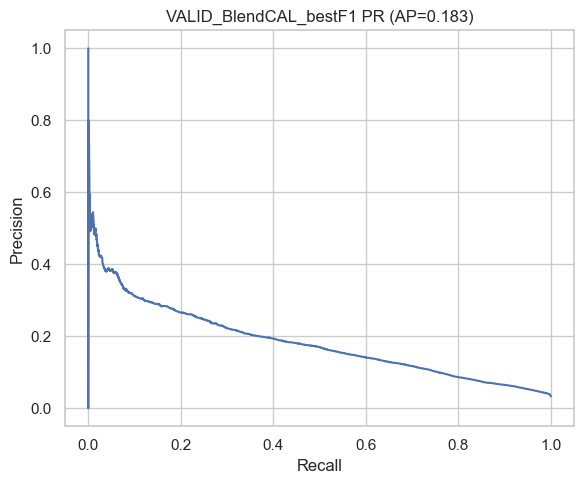

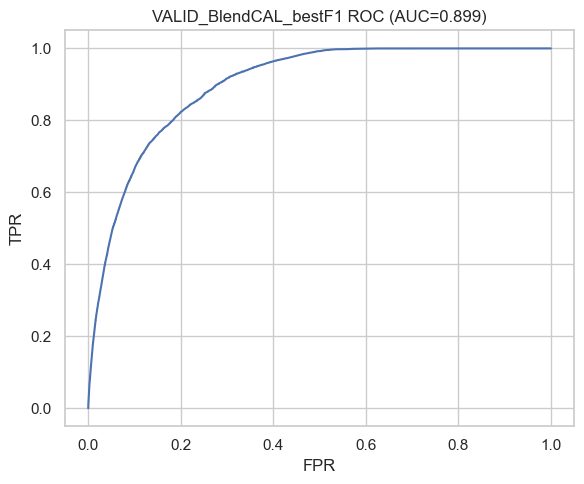

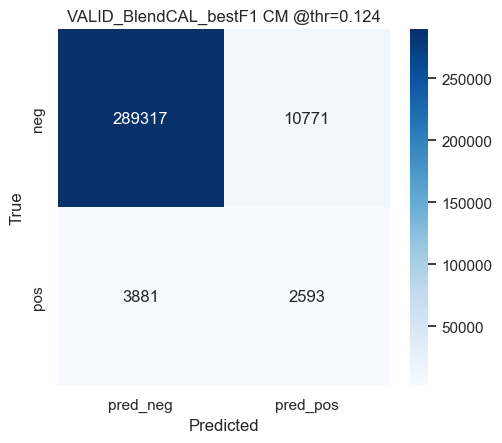


[VALID_BlendCAL_bestF1] Classification report @thr=0.124
               precision    recall  f1-score   support

         neg      0.987     0.964     0.975    300088
         pos      0.194     0.401     0.261      6474

    accuracy                          0.952    306562
   macro avg      0.590     0.682     0.618    306562
weighted avg      0.970     0.952     0.960    306562



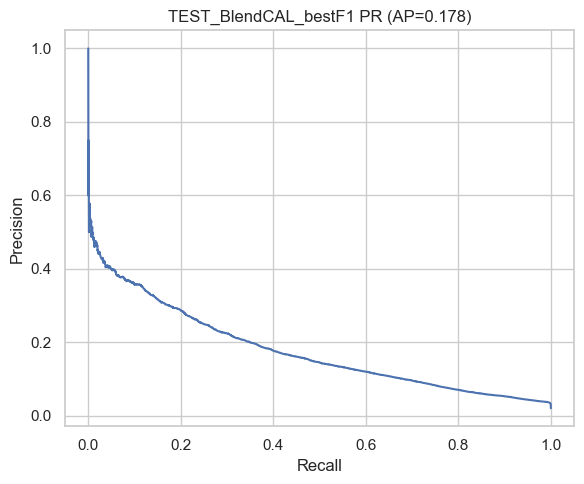

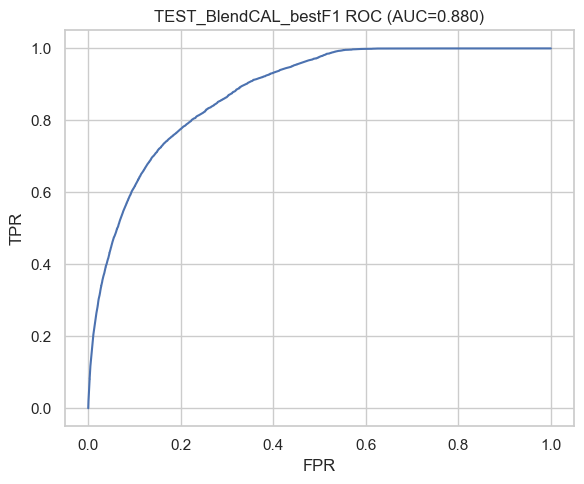

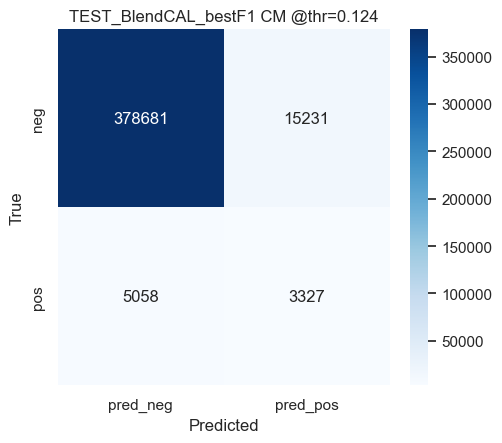


[TEST_BlendCAL_bestF1] Classification report @thr=0.124
               precision    recall  f1-score   support

         neg      0.987     0.961     0.974    393912
         pos      0.179     0.397     0.247      8385

    accuracy                          0.950    402297
   macro avg      0.583     0.679     0.610    402297
weighted avg      0.970     0.950     0.959    402297



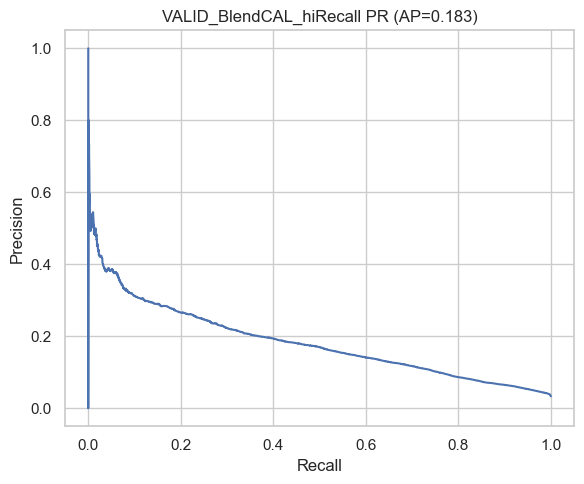

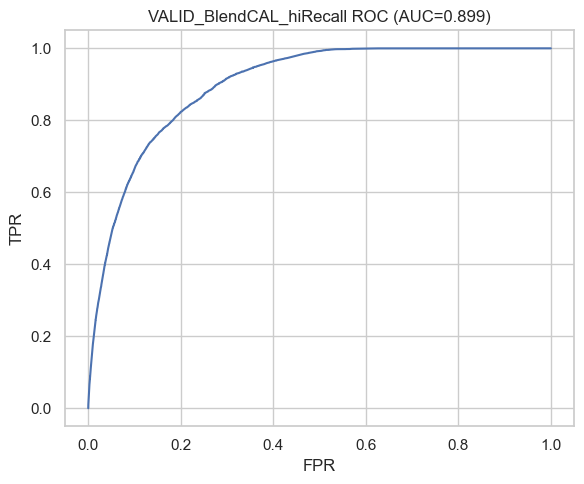

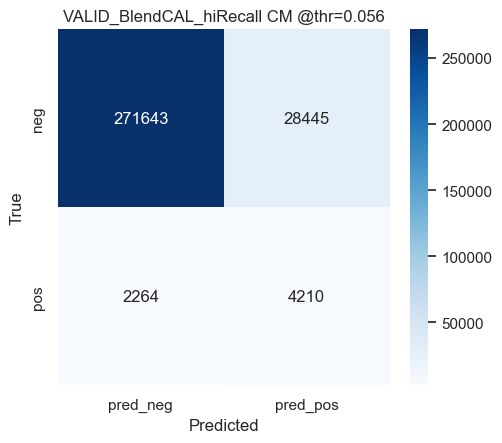


[VALID_BlendCAL_hiRecall] Classification report @thr=0.056
               precision    recall  f1-score   support

         neg      0.992     0.905     0.946    300088
         pos      0.129     0.650     0.215      6474

    accuracy                          0.900    306562
   macro avg      0.560     0.778     0.581    306562
weighted avg      0.974     0.900     0.931    306562



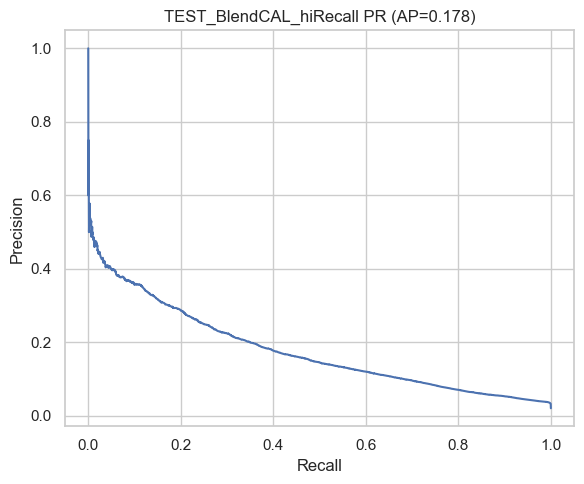

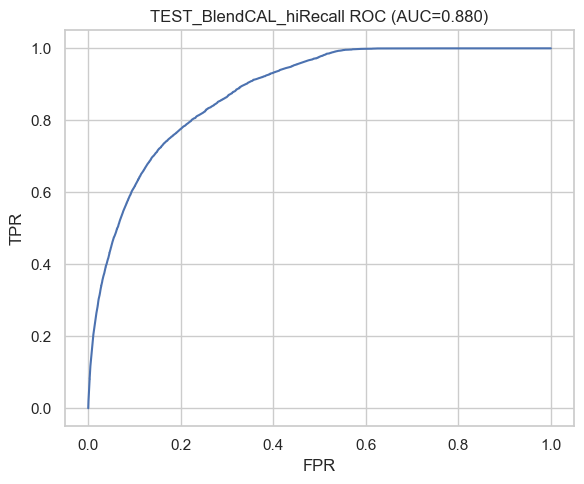

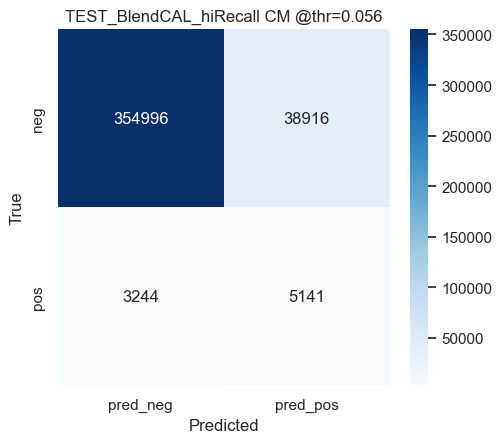


[TEST_BlendCAL_hiRecall] Classification report @thr=0.056
               precision    recall  f1-score   support

         neg      0.991     0.901     0.944    393912
         pos      0.117     0.613     0.196      8385

    accuracy                          0.895    402297
   macro avg      0.554     0.757     0.570    402297
weighted avg      0.973     0.895     0.928    402297


BlendCAL done → D:\ML\LS\final\final_project\artifacts\eval
Weights: {'CatBoost_calibrated_isotonic': 0.36623765737431535, 'XGBoost_calibrated': 0.40158065281044725, 'LightGBM_calibrated': 0.23218168981523735}
bestF1 thr(valid): 0.124074 | hi-recall thr(valid): 0.056128


In [58]:
def savefig(path: Path):
    plt.tight_layout(); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()

# sanity: X_valid/X_test подготовлены как раньше (числа, без NaN/Inf) 
for name, X in [("valid", X_valid), ("test", X_test)]:
    arr = pd.DataFrame(X).astype(float).values
    assert np.isfinite(arr).all(), f"{name}: есть NaN/Inf"

# упорядочим столбцы test как в valid (на всякий случай)
X_test = X_test[X_valid.columns].copy()

y_va = np.asarray(y_valid, dtype=int).ravel()
y_te = np.asarray(y_test,  dtype=int).ravel()

# грузим калиброванные модели 
CANDIDATES = {
    "CatBoost_calibrated_isotonic": [
        MODEL_DIR / "CatBoost_calibrated_isotonic.pkl",
        MODEL_DIR / "catboost_calibrated_isotonic.pkl",
        MODEL_DIR / "catboost_calibrated.pkl",
    ],
    "XGBoost_calibrated": [MODEL_DIR / "XGBoost_calibrated.pkl"],
    "LightGBM_calibrated": [MODEL_DIR / "LightGBM_calibrated.pkl"],
}

models = {}
missing = []
for name, paths in CANDIDATES.items():
    path = next((p for p in paths if p.exists()), None)
    if path is None:
        missing.append(name)
    else:
        models[name] = joblib.load(path)

assert len(models) == 3, f"Не найдены модели: {missing}"
print("Loaded models:", list(models.keys()))

# предсказания на valid/test
def proba_of(model, X):
    p = model.predict_proba(X)[:, 1]
    return np.clip(p, 1e-9, 1 - 1e-9)

P_valid = {name: proba_of(m, X_valid) for name, m in models.items()}
P_test  = {name: proba_of(m, X_test)  for name, m in models.items()}

for name in models:
    print(f"[ok] {name}: (valid,test) → {P_valid[name].shape}/{P_test[name].shape}")

names = list(models.keys())
N = len(names)

# оптимизация весов на VALID (max AP)
def softmax(z):
    z = np.asarray(z, dtype=float)
    z -= z.max()
    w = np.exp(z)
    return w / w.sum()

def blend_ap(weights):
    w = np.asarray(weights)
    pv = sum(w[i] * P_valid[names[i]] for i in range(N))
    return average_precision_score(y_va, pv)

def objective(trial: "optuna.Trial"):
    z = [trial.suggest_float(f"z{i}", -5.0, 5.0) for i in range(N)]
    w = softmax(z)
    return blend_ap(w)

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42) 
)
study.optimize(objective, n_trials=80, show_progress_bar=True)

z_best = [study.best_trial.params[f"z{i}"] for i in range(N)]
W = softmax(z_best)
w_dict = {names[i]: float(W[i]) for i in range(N)}
ap_valid_blend = blend_ap(W)
print("Optuna weights:", w_dict, "| AP(valid)=", ap_valid_blend)

# итоговые вероятности бленда
proba_val = sum(W[i] * P_valid[names[i]] for i in range(N))
proba_tst = sum(W[i] * P_test [names[i]] for i in range(N))

# выбор порогов: (A) макс F1, (B) high-recall
def best_f1_threshold(y_true, proba):
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2 * (p * r) / (p + r + 1e-12)
    bi = int(np.nanargmax(f1s))
    thr = t[max(0, bi-1)] if len(t) else 0.5
    return float(thr)

def find_thr_at_recall(y_true, proba, target_recall=0.65):
    p, r, t = precision_recall_curve(y_true, proba)
    idx = np.where(r >= target_recall)[0]
    if len(idx) == 0 or len(t) == 0:
        return best_f1_threshold(y_true, proba)
    i = idx[-1] - 1 if idx[-1] > 0 else 0
    i = min(i, len(t)-1)
    return float(t[i])

thr_f1  = best_f1_threshold(y_va, proba_val)
thr_rec = find_thr_at_recall(y_va, proba_val, target_recall=0.65)

# precision/recall на выбранных порогах (для сохранения/логов)
def pr_at_thr(y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    return float(precision_score(y_true, y_pred)), float(recall_score(y_true, y_pred))

prec_f1, rec_f1 = pr_at_thr(y_va, proba_val, thr_f1)
prec_hr, rec_hr = pr_at_thr(y_va, proba_val, thr_rec)

print(f"Blend operating point (VALID): bestF1 thr={thr_f1:.4f} | P={prec_f1:.3f} R={rec_f1:.3f}")
print(f"Blend operating point (VALID): hi-recall thr={thr_rec:.4f} | P={prec_hr:.3f} R={rec_hr:.3f}")

# функция отчётов/графиков
def eval_and_dump(tag: str, y_true, proba, thr: float):
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)

    # PR / ROC
    p, r, _ = precision_recall_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(r, p); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{tag} PR (AP={ap:.3f})"); savefig(EVAL_DIR / f"{tag.lower()}_pr.png")

    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6,5)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{tag} ROC (AUC={auc:.3f})"); savefig(EVAL_DIR / f"{tag.lower()}_roc.png")

    # отчёты @thr
    y_pred = (proba >= thr).astype(int)
    rep = classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)
    pd.DataFrame(rep).T.to_csv(EVAL_DIR / f"{tag.lower()}_cls_report_thr_{thr:.3f}.csv")

    cm = confusion_matrix(y_true, y_pred)
    pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"]).to_csv(
        EVAL_DIR / f"{tag.lower()}_cm_thr_{thr:.3f}.csv"
    )
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
    plt.title(f"{tag} CM @thr={thr:.3f}"); plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(EVAL_DIR / f"{tag.lower()}_cm_thr_{thr:.3f}.png")

    print(f"\n[{tag}] Classification report @thr={thr:.3f}\n",
          classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3))

    return {"auc": float(auc), "ap": float(ap), "f1@thr": float(f1_score(y_true, y_pred)), "thr": float(thr)}

# Top-K таблички (1%, 2%, 5%, 10%)
def topk_table(y_true, proba, ks=(0.01, 0.02, 0.05, 0.10)):
    rows = []
    y = np.asarray(y_true)
    for kf in ks:
        k = max(1, int(len(proba)*kf))
        idx = np.argsort(-proba)[:k]
        rows.append({
            "k_frac": kf,
            "k": int(k),
            "precision": float(y[idx].mean()),
            "recall": float(y[idx].sum()/max(1, y.sum()))
        })
    return pd.DataFrame(rows)

topk_valid = topk_table(y_va, proba_val)
topk_test  = topk_table(y_te, proba_tst)
topk_valid.to_csv(EVAL_DIR / "BlendCAL_topk_valid.csv", index=False)
topk_test.to_csv(EVAL_DIR / "BlendCAL_topk_test.csv", index=False)
print("VALID Top-K:\n", topk_valid, "\n\nTEST Top-K:\n", topk_test)

# сохраняем веса и пороги (+ метрики при порогах)
with open(MODEL_DIR / "BlendCAL_weights.json", "w", encoding="utf-8") as f:
    json.dump({
        "weights": w_dict,
        "note": "softmax weights over calibrated models (max AP on VALID)",
        "ap_valid_blend": float(ap_valid_blend)
    }, f, indent=2)

with open(MODEL_DIR / "BlendCAL_thresholds.json", "w", encoding="utf-8") as f:
    json.dump({
        "thr_bestF1_valid": float(thr_f1),
        "thr_highRecall_valid": float(thr_rec),
        "target_recall": 0.65,
        "valid_metrics_at_bestF1": {"precision": prec_f1, "recall": rec_f1},
        "valid_metrics_at_hiRecall": {"precision": prec_hr, "recall": rec_hr}
    }, f, indent=2)

# метрики/графики: valid/test @двух порогах
valid_f1 = eval_and_dump("VALID_BlendCAL_bestF1",  y_va, proba_val, thr_f1)
test_f1  = eval_and_dump("TEST_BlendCAL_bestF1",   y_te, proba_tst, thr_f1)

valid_hr = eval_and_dump("VALID_BlendCAL_hiRecall", y_va, proba_val, thr_rec)
test_hr  = eval_and_dump("TEST_BlendCAL_hiRecall",  y_te, proba_tst, thr_rec)

# обновляем общий metrics.json
try:
    allm = json.load(open(METRICS_PATH, "r", encoding="utf-8"))
except Exception:
    allm = {}

allm["BlendCAL_bestF1_valid"]   = valid_f1
allm["BlendCAL_bestF1_test"]    = test_f1
allm["BlendCAL_hiRecall_valid"] = valid_hr
allm["BlendCAL_hiRecall_test"]  = test_hr
allm["BlendCAL_weights"]        = w_dict
allm["BlendCAL_topk_valid"]     = topk_valid.to_dict(orient="list")
allm["BlendCAL_topk_test"]      = topk_test.to_dict(orient="list")

json.dump(allm, open(METRICS_PATH, "w", encoding="utf-8"), indent=2)

print("\nBlendCAL done →", EVAL_DIR)
print("Weights:", w_dict)
print(f"bestF1 thr(valid): {thr_f1:.6f} | hi-recall thr(valid): {thr_rec:.6f}")

## Что дал BlendCAL (Cat + XGB + LGB)

### Веса (softmax, под AP@valid):
XGB — 0.402, Cat — 0.366, LGB — 0.232 → XGB вносит наибольший вклад, но все три модели реально полезны (веса далеко от нуля).

### Качество (валид/тест):

PR-AUC (AP): 0.183 (valid) / 0.178 (test). Это выше, чем у одиночных моделей
(LGB ~0.174 / 0.173; XGB ~0.173 / 0.164). Т.е. бленд даёт стабильный +3–9% относительного выигрыша по AP.

ROC-AUC: ~0.899 (valid) / 0.880 (test) — на уровне лучших синглов, без деградации обобщения.

PR-кривые гладкие; разрыв valid↔test минимальный → переобучения нет.

Два рабочих режима (пороги брали по VALID и применяли на TEST):

best-F1 @ thr=0.124

VALID: P=0.194, R=0.401, F1≈0.261

TEST : P=0.179, R=0.397, F1≈0.247

Матрица (TEST): FP=15 231, TP=3 327 → FPR ≈ 3.9%, помечаем ~4.6% всех заявок (18 558 из 402 297).

hi-recall @ thr=0.056 (цель ≈0.65 recall на valid)

VALID: P=0.129, R=0.650, F1≈0.215

TEST : P=0.117, R=0.613, F1≈0.196

Матрица (TEST): FP=38 916, TP=5 141 → FPR ≈ 9.9%, помечаем ~11% всех заявок (44 057 из 402 297).

Top-K (по вероятности, удобно для жёсткого лимита контактов):

VALID: Top-1% P=0.293 / R=0.139; Top-2% 0.252 / 0.238; Top-5% 0.184 / 0.435; Top-10% 0.133 / 0.632

TEST : Top-1% P=0.316 / R=0.151; Top-2% 0.253 / 0.243; Top-5% 0.172 / 0.413; Top-10% 0.123 / 0.589
Метрики по valid и test очень близки → стабильность отличная. Если, например, готовы обзванивать топ-5% — получим ~41% всех целевых лидов с ~17% precision (каждый 6-й).

### Сравнение с синглами

По AP: бленд уверенно впереди всех (особенно против XGB).

По hi-recall: при аналогичном Recall ≈0.61–0.65 у бленда precision выше, чем у LGB/XGB по нашим прогонам (на тесте ~0.117 vs 0.109 у LGB при R0.65).

По best-F1: бленд берёт чуть больше Recall, но чуть проседает Precision относительно LGB, в сумме F1 сопоставим (±).

### Практические рекомендации

Если важен баланс ошибок → берём best-F1 (thr≈0.124). Небольшой поток позитивов (~4.6% трафика) и умеренный FPR ~3.9%.

Если важен охват (минимум пропусков) → hi-recall (thr≈0.056). Охватываем ~61% целевых, понимая, что precision ~11–12% и помечаем ~11% трафика.

Если есть строгий лимит контактов → используем Top-K сценарий (1/2/5/10%). По таблицам легко выбрать K под бюджет.

### Что уже сохранено и как использовать в инференсе

Веса бленда: BlendCAL_weights.json

Пороги: BlendCAL_thresholds.json (оба — best-F1 и hi-recall)

Три калиброванные пайплайна: Cat / XGB / LGB (*.pkl)
Инференс: p = w_cat*p_cat + w_xgb*p_xgb + w_lgb*p_lgb; ŷ = (p >= thr)
(для Top-K просто сортируем p и берём верхние K%).

## LAMA

In [3]:
ROOT_PATH = Path(r"D:\ML\LS\final\final_project")
DATA_RAW = ROOT_PATH / "data" / "raw"
DATA_PROCESSED = ROOT_PATH / "data" / "processed"
DATA_PATH = DATA_PROCESSED / "sessions_features_final.parquet"  # большой объединённый фрейм
SAVE_DIR = Path(r"D:/ML/LS/final/final_project/artifacts/eval_lama")  # куда складывать артефакты LAMA

ID_COLS = ["session_id", "client_id"]
DROP_COLS = ["visit_date", "visit_time"] 
CV_FOLDS = 5
TIME_LIMIT_SEC = 36000  # 10 часов
SEED = 42
TARGET_COL = "target"

SAVE_DIR.mkdir(parents=True, exist_ok=True)

## Load data + checks

In [4]:
assert DATA_PATH.exists(), f"Файл не найден: {DATA_PATH}"

if DATA_PATH.suffix.lower() == ".parquet":
    df = pd.read_parquet(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

print(df.shape, df.dtypes.value_counts())
assert TARGET_COL in df.columns, f"В данных нет таргета '{TARGET_COL}'"

# заменим inf на NaN, LAMA сам импутит
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

df.head(3)

(1860042, 30) int32             7
string[python]    5
int8              5
object            4
float64           3
Int32             2
Int64             2
int64             1
datetime64[ns]    1
Name: count, dtype: int64


session_id  visit_number utm_medium  \
0  9055434745589932991.1637753792.1637753792             1     banner   
1   905544597018549464.1636867290.1636867290             1        cpm   
2  9055446045651783499.1640648526.1640648526             1     banner   

  device_category geo_country    geo_city      visit_datetime  visit_hour  \
0          mobile      Russia  other_city 2021-11-24 14:36:32          14   
1          mobile      Russia      Moscow 2021-11-14 08:21:30           8   
2          mobile      Russia  other_city 2021-12-28 02:42:06           2   

   visit_dow  is_weekend  ...  unique_event_types    car_brand    car_model  \
0          2           0  ...                   2  other_brand  other_model   
1          6           1  ...                   1  other_brand  other_model   
2          1           0  ...                   3  other_brand  other_model   

   n_brands  n_models  any_car_detail  is_big_city              brand_model  \
0       0.0       0.0             0.0            0  other_brand_other_model   
1       0.0       0.0             0.0            1  other_brand_other_model   
2       0.0       0.0             0.0            0  other_brand_other_model   

   is_top_brand  has_model  
0             0          0  
1             0          0  
2             0          0  

[3 rows x 30 columns]

## dtype casting + roles

In [5]:
# Приводим типы
# datetime: убедимся, что это datetime64[ns]
if "visit_datetime" in df.columns and not np.issubdtype(df["visit_datetime"].dtype, np.datetime64):
    df["visit_datetime"] = pd.to_datetime(df["visit_datetime"], errors="coerce")

# string/object -> category
str_like = list(df.select_dtypes(include=["object", "string"]).columns)
for c in str_like:
    df[c] = df[c].astype("category")

# nullable ints (Int32/Int64) -> float32 (чтобы сохранить NaN)
nullable_ints = [c for c in df.columns if str(df[c].dtype) in ("Int32", "Int64")]
for c in nullable_ints:
    df[c] = df[c].astype("float32")

# обычные int -> int32 (если без NaN), float64 -> float32
for c in df.select_dtypes(include=["int64", "int32"]).columns:
    if df[c].isna().any():
        df[c] = df[c].astype("float32")
    else:
        df[c] = df[c].astype("int32")

for c in df.select_dtypes(include=["float64"]).columns:
    df[c] = df[c].astype("float32")

print("Dtypes after cast:\n", df.dtypes.value_counts())

# Роли для LAMA
ID_COLS = ["session_id"]                      # только session_id дропаем
DROP_COLS = []                                # при желании можно добавить сырые поля
roles = {
    "target": TARGET_COL,
    "drop":   [c for c in ID_COLS + DROP_COLS if c in df.columns],
    "datetime": ["visit_datetime"] if "visit_datetime" in df.columns else []
}
roles

Dtypes after cast:
 int32             8
float32           7
int8              5
category          1
category          1
category          1
category          1
category          1
datetime64[ns]    1
category          1
category          1
category          1
category          1
Name: count, dtype: int64


{'target': 'target', 'drop': ['session_id'], 'datetime': ['visit_datetime']}

## Fit LAMA with preset="lgbm"

In [10]:
task = Task("binary", metric="auc")

automl_lgbm = TabularAutoML(
    task=task,
    timeout=TIME_LIMIT_SEC,                       # общий лимит времени
    cpu_limit=max(os.cpu_count() - 1, 1),
    reader_params=dict(
        cv=CV_FOLDS,
        n_jobs=max(os.cpu_count() - 1, 1),
        advanced_roles=False,                    # экономим память на больших данных
        random_state=SEED,
    ),
    general_params=dict(
        use_algos=["lgb"],                       # только LightGBM
        nested_cv=False,
        random_state=SEED,
        timeout=TIME_LIMIT_SEC,
    ),
)

oof_pred_lgbm = automl_lgbm.fit_predict(df, roles=roles, verbose=1)

# сохранить модель и OOF
model_path_lgbm = SAVE_DIR / "lama_lgbm.joblib"
joblib.dump(automl_lgbm, model_path_lgbm)
print(f"[LAMA] Saved model → {model_path_lgbm}")

oof_path_lgbm = SAVE_DIR / "oof_lgbm.parquet"
pd.DataFrame({
    "pred": oof_pred_lgbm.data.ravel(),
    TARGET_COL: df[TARGET_COL].values
}).to_parquet(oof_path_lgbm, index=False)
print(f"[LAMA] Saved OOF → {oof_path_lgbm}")

# ==== быстрые метрики ====
probs = oof_pred_lgbm.data.ravel()
y_true = df[TARGET_COL].values

ap  = average_precision_score(y_true, probs)
roc = roc_auc_score(y_true, probs)

ps, rs, ths = precision_recall_curve(y_true, probs)
f1s = 2 * ps * rs / (ps + rs + 1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = float(ths[max(best_idx - 1, 0)]) if len(ths) > 0 else 0.5
f1 = f1_score(y_true, (probs >= best_thr).astype(int))

metrics_lgbm = {
    "preset": "lgbm",
    "average_precision": float(ap),
    "roc_auc": float(roc),
    "f1_best": float(f1),
    "thr_best": float(best_thr)
}

with open(SAVE_DIR / "metrics_lgbm.json", "w", encoding="utf-8") as f:
    json.dump(metrics_lgbm, f, ensure_ascii=False, indent=2)
print("[LAMA] Metrics:", metrics_lgbm)

metrics_lgbm

[01:46:55] Stdout logging level is INFO.
[01:46:55] Task: binary

[01:46:55] Start automl preset with listed constraints:
[01:46:55] - time: 36000.00 seconds
[01:46:55] - CPU: 11 cores
[01:46:55] - memory: 16 GB

[01:46:55] Train data shape: (1860042, 30)

[01:46:55] Layer 1 train process start. Time left 35999.32 secs
[01:47:14] Selector_LightGBM fitting and predicting completed
[01:47:15] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[01:49:02] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.9013960733064069
[01:49:02] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[01:49:02] Time left 35872.28 secs

[01:49:02] Layer 1 training completed.

[01:49:02] Automl preset training completed in 127.77 seconds

[01:49:02] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

[LAMA] Saved model → D:\ML\LS\final\final_project\artifacts\eval_lama\lama_lgbm.joblib
[LAMA] Saved OOF → D:\ML\LS\final\final_

{'preset': 'lgbm',
 'average_precision': 0.24183907436543833,
 'roc_auc': 0.9013960733064069,
 'f1_best': 0.30265438576036685,
 'thr_best': 0.14848163723945618}

## PR/ROC + отчёты для OOF (lgbm)

In [11]:
EVAL_LAMA = SAVE_DIR

oof = oof_pred_lgbm.data.ravel()
y   = df[TARGET_COL].values

ap = average_precision_score(y, oof)
roc = roc_auc_score(y, oof)
ps, rs, th = precision_recall_curve(y, oof)
fpr, tpr, _ = roc_curve(y, oof)

# PR
plt.figure(figsize=(6,5)); plt.plot(rs, ps)
plt.title(f"LAMA(lgbm) PR (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.savefig(EVAL_LAMA / "lama_lgbm_pr.png", dpi=150); plt.close()

# ROC
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr)
plt.title(f"LAMA(lgbm) ROC (AUC={roc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.savefig(EVAL_LAMA / "lama_lgbm_roc.png", dpi=150); plt.close()

# best-F1
f1s = 2*ps*rs/(ps+rs+1e-12); bi = int(np.nanargmax(f1s))
thr_best = float(th[max(bi-1, 0)]) if len(th) else 0.5
y_pred = (oof >= thr_best).astype(int)

rep_df = pd.DataFrame(classification_report(y, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)).T
rep_df.to_csv(EVAL_LAMA / f"lama_lgbm_cls_report_bestthr_{thr_best:.3f}.csv")

cm = confusion_matrix(y, y_pred)
pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"])\
  .to_csv(EVAL_LAMA / f"lama_lgbm_cm_bestthr_{thr_best:.3f}.csv")

## Evaluate LAMA(lgbm) on true TEST split via session_id list

In [14]:
TEST_IDS_PATH = Path(r"D:/ML/LS/final/final_project/artifacts/split/test_session_ids.csv")
TEST_ID_COL   = "session_id"   
SESSION_COL   = "session_id"   

# читаем тестовые ID 
test_ids_df = pd.read_csv(TEST_IDS_PATH)
assert TEST_ID_COL in test_ids_df.columns, f"В {TEST_IDS_PATH} нет колонки '{TEST_ID_COL}'"
test_ids = set(test_ids_df[TEST_ID_COL].astype(str))

# строим маску теста
assert SESSION_COL in df.columns, f"В df нет колонки '{SESSION_COL}'"
mask_test = df[SESSION_COL].astype(str).isin(test_ids).values
print(f"TEST size = {mask_test.sum()} / {len(df)} ({mask_test.mean():.2%})")

# делим и обучаемся только на train
X_all = df.drop(columns=[TARGET_COL])
y_all = df[TARGET_COL].astype(int)

X_train_lama = X_all.loc[~mask_test].copy()
y_train_lama = y_all.loc[~mask_test].copy()
X_test_lama  = X_all.loc[mask_test].copy()
y_test_lama  = y_all.loc[mask_test].copy()

print("Train shape:", X_train_lama.shape, "| Test shape:", X_test_lama.shape)

# роли для train
roles_train = {
    "target": TARGET_COL,
    "drop": roles.get("drop", []),
    "datetime": roles.get("datetime", []),
}

task = Task("binary", metric="auc")
automl_holdout = TabularAutoML(
    task=task,
    timeout=TIME_LIMIT_SEC,
    cpu_limit=max(os.cpu_count() - 1, 1),
    reader_params=dict(
        cv=CV_FOLDS,
        n_jobs=max(os.cpu_count() - 1, 1),
        advanced_roles=False,
        random_state=SEED,
    ),
    general_params=dict(
        use_algos=["lgb"], 
        nested_cv=False,
        random_state=SEED,
        timeout=TIME_LIMIT_SEC,
    ),
)

df_train_lama = pd.concat([X_train_lama, y_train_lama.rename(TARGET_COL)], axis=1)
_ = automl_holdout.fit_predict(df_train_lama, roles=roles_train, verbose=1)

# предсказания на TEST 
proba_test = automl_holdout.predict(X_test_lama).data.ravel()

# метрики
ap_test  = average_precision_score(y_test_lama, proba_test)
roc_test = roc_auc_score(y_test_lama, proba_test)
p, r, t  = precision_recall_curve(y_test_lama, proba_test)
f1s      = 2*p*r/(p+r+1e-12); bi = int(np.nanargmax(f1s))
thr_best = float(t[max(bi-1, 0)]) if len(t) else 0.5
f1_test  = f1_score(y_test_lama, (proba_test >= thr_best).astype(int))

res = {"AP_test": float(ap_test), "ROC_AUC_test": float(roc_test),
       "F1_best_test": float(f1_test), "thr_best": float(thr_best)}
print(res)

# сохранить предсказания/метрики/Top-K
pred_path = SAVE_DIR / "lama_lgbm_test_predictions.parquet"
pd.DataFrame({
    SESSION_COL: df.loc[mask_test, SESSION_COL].values,
    "pred": proba_test,
    TARGET_COL: y_test_lama.values
}).to_parquet(pred_path, index=False)

with open(SAVE_DIR / "metrics_lgbm_test.json", "w", encoding="utf-8") as f:
    json.dump(res, f, ensure_ascii=False, indent=2)

def precision_recall_at_k(y_true, scores, ks=(0.01, 0.02, 0.05, 0.10)):
    out = []
    n = len(y_true)
    order = np.argsort(scores)[::-1]
    y_sorted = np.asarray(y_true)[order]
    for frac in ks:
        k = max(1, int(round(n * frac)))
        topk = y_sorted[:k]
        prec = float(topk.mean())
        rec  = float(topk.sum() / max(1, y_true.sum()))
        out.append({"k_frac": frac, "k_abs": k, "precision": prec, "recall": rec})
    return pd.DataFrame(out)

topk_df = precision_recall_at_k(y_test_lama.values, proba_test)
topk_df.to_csv(SAVE_DIR / "lama_lgbm_test_topk.csv", index=False)

print(f"[LAMA] Saved TEST preds → {pred_path}")
print(f"[LAMA] Saved TEST metrics → {SAVE_DIR / 'metrics_lgbm_test.json'}")
print(f"[LAMA] Saved TEST top-k → {SAVE_DIR / 'lama_lgbm_test_topk.csv'}")
topk_df

TEST size = 402297 / 1860042 (21.63%)
Train shape: (1457745, 29) | Test shape: (402297, 29)
[01:57:53] Stdout logging level is INFO.
[01:57:53] Task: binary

[01:57:53] Start automl preset with listed constraints:
[01:57:53] - time: 36000.00 seconds
[01:57:53] - CPU: 11 cores
[01:57:53] - memory: 16 GB

[01:57:53] Train data shape: (1457745, 30)

[01:57:54] Layer 1 train process start. Time left 35999.43 secs
[01:58:04] Selector_LightGBM fitting and predicting completed
[01:58:04] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[01:59:24] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.9006306949609876
[01:59:24] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[01:59:24] Time left 35909.26 secs

[01:59:24] Layer 1 training completed.

[01:59:24] Automl preset training completed in 90.78 seconds

[01:59:24] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

{'AP_test': 0.17842802274623137, 'RO

k_frac  k_abs  precision    recall
0    0.01   4023   0.301268  0.144544
1    0.02   8046   0.242978  0.233154
2    0.05  20115   0.169724  0.407156
3    0.10  40230   0.122272  0.586643

## UtilizedAutoML (best_quality) OOF on full df

In [6]:
task = Task("binary", metric="auc")

UTIL_CV = 3
automl_util = TabularUtilizedAutoML(
    task=task,
    timeout=TIME_LIMIT_SEC,                 
    cpu_limit=max(os.cpu_count() - 1, 1),
    memory_limit=16,                       
    general_params={"preset": "best_quality", "od_wait": 100, "nested_cv": True},
    reader_params={"n_jobs": max(os.cpu_count() - 1, 1), "random_state": SEED, "cv": UTIL_CV},
)

oof_pred_util = automl_util.fit_predict(df, roles=roles, verbose=1)

# сохранить модель и OOF
model_path_util = SAVE_DIR / "lama_best_quality_util.joblib"
joblib.dump(automl_util, model_path_util)
pd.DataFrame({"pred": oof_pred_util.data.ravel(), TARGET_COL: df[TARGET_COL].values}).to_parquet(
    SAVE_DIR / "oof_best_quality_util.parquet", index=False
)
print(f"[LAMA] Saved model → {model_path_util}")

# быстрые метрики по OOF
probs = oof_pred_util.data.ravel()
y = df[TARGET_COL].values
ap  = average_precision_score(y, probs)
roc = roc_auc_score(y, probs)
ps, rs, ths = precision_recall_curve(y, probs)
f1s = 2*ps*rs/(ps+rs+1e-12); bi = int(np.nanargmax(f1s))
thr_best = float(ths[max(bi-1, 0)]) if len(ths) else 0.5
f1  = f1_score(y, (probs >= thr_best).astype(int))

with open(SAVE_DIR / "metrics_best_quality_util_oof.json", "w", encoding="utf-8") as f:
    json.dump({"preset":"best_quality(util)","average_precision":float(ap),"roc_auc":float(roc),
               "f1_best":float(f1),"thr_best":float(thr_best)}, f, ensure_ascii=False, indent=2)
print({"AP_oof": float(ap), "ROC_AUC_oof": float(roc), "F1_best_oof": float(f1), "thr_best": float(thr_best)})

[02:15:52] Start automl utilizator with listed constraints:
[02:15:52] - time: 36000.00 seconds
[02:15:52] - CPU: 11 cores
[02:15:52] - memory: 16 GB

[02:15:52] If one preset completes earlier, next preset configuration will be started

[02:15:52] ==================================================
[02:15:52] Start 0 automl preset configuration:
[02:15:52] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[02:15:52] Stdout logging level is INFO.
[02:15:52] Task: binary

[02:15:52] Start automl preset with listed constraints:
[02:15:52] - time: 36000.00 seconds
[02:15:52] - CPU: 11 cores
[02:15:52] - memory: 16 GB

[02:15:52] Train data shape: (1860042, 30)

[02:16:05] Layer 1 train process start. Time left 35987.66 secs
[02:17:04] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[02:

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]


[02:25:38] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[02:25:39] Start fitting CatBoost ...
[02:42:37] Fitting CatBoost finished. score = 0.9039941649489063
[02:42:37] CatBoost fitting and predicting completed
[02:42:40] Start fitting CatBoost ...
[02:56:10] Fitting CatBoost finished. score = 0.9032056288505467
[02:56:10] CatBoost fitting and predicting completed
[02:56:13] Start fitting CatBoost ...
[03:12:41] Fitting CatBoost finished. score = 0.9049736147180678
[03:12:41] CatBoost fitting and predicting completed
[03:12:43] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9033912725833032
[03:12:43] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[03:12:43] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[03:12:44] Time left 32588.75 secs

[03:12:44] Layer 1 training completed.

[03:12:44] Blending: optimization starts with equal weights. Score = 0.9024145
[03:12:57] Blending: iteration 0: score = 0.9073901, weights = [0.        0.8738406 0.1261594]
[03:13:10] Blending: no improvements for score. Terminated.

[03:13:10] Blending: best score = 0.9073901, best weights = [0.        0.8738406 0.1261594]
[03:13:10] Automl preset training completed in 3437.84 seconds

[03:13:10] Model description:
Final prediction for new objects (level 0) = 
	 0.87384 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.12616 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 

[03:13:10] ==================================================
[03:13:10] Start 1 automl preset configuration:
[03:13:10] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml, random state: {'reader_params': {'random_state': 43}, 'nn_params': {'random_state': 43}, 'gener

Optimization Progress:   0%|          | 0/101 [00:26<?, ?it/s]

[03:13:10] Stdout logging level is INFO.
[03:13:10] Task: binary

[03:13:10] Start automl preset with listed constraints:
[03:13:10] - time: 32562.05 seconds
[03:13:10] - CPU: 11 cores
[03:13:10] - memory: 16 GB

[03:13:10] Train data shape: (1860042, 30)



[03:13:21] Layer 1 train process start. Time left 32551.86 secs
[03:14:17] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[03:14:18] Start fitting LinearL2 ...
[03:15:32] Fitting LinearL2 finished. score = 0.8561832057617199
[03:15:32] LinearL2 fitting and predicting completed
[03:15:33] Start fitting LinearL2 ...
[03:16:43] Fitting LinearL2 finished. score = 0.855949480886687
[03:16:43] LinearL2 fitting and predicting completed
[03:16:45] Start fitting LinearL2 ...
[03:17:58] Fitting LinearL2 finished. score = 0.8560141001899005
[03:17:58] LinearL2 fitting and predicting completed
[03:17:59] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8560056662753847
[03:17:59] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[03:18:00] Time left 32272.87 secs

[03:18:09] Selector_LightGBM fitting and predicting completed
[03:18:10] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[03:18:10] Start fitting LightGBM ...
[03:19:11] Fitting LightGBM finished. score = 0.900281302168476

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[03:21:30] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[03:21:31] Start fitting CatBoost ...
[03:34:57] Fitting CatBoost finished. score = 0.8960129262469226
[03:34:57] CatBoost fitting and predicting completed
[03:34:59] Start fitting CatBoost ...
[03:50:52] Fitting CatBoost finished. score = 0.8960628222832809
[03:50:52] CatBoost fitting and predicting completed
[03:50:53] Start fitting CatBoost ...
[04:05:36] Fitting CatBoost finished. score = 0.8959941338854085
[04:05:36] CatBoost fitting and predicting completed
[04:05:39] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8965866410762563
[04:05:39] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[04:05:39] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[04:05:39] Time left 29413.72 secs

[04:05:39] Layer 1 training completed.

[04:05:39] Blending: optimization starts with equal weights. Score = 0.8979015
[04:05:55] Blending: iteration 0: score = 0.9011768, weights = [0. 1. 0.]
[04:06:10] Blending: iteration 1: score = 0.9012613, weights = [0.07608817 0.9239118  0.        ]
[04:06:25] Blending: no improvements for score. Terminated.

[04:06:25] Blending: best score = 0.9012613, best weights = [0.07608817 0.9239118  0.        ]
[04:06:26] Automl preset training completed in 3195.32 seconds

[04:06:26] Model description:
Final prediction for new objects (level 0) = 
	 0.07609 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92391 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[04:06:26] ==================================================
[04:06:26] Start 2 automl preset configuration:
[04:06:26] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml, rando

Optimization Progress:   0%|          | 0/101 [00:47<?, ?it/s]

[04:06:26] Stdout logging level is INFO.
[04:06:26] Task: binary

[04:06:26] Start automl preset with listed constraints:
[04:06:26] - time: 29366.59 seconds
[04:06:26] - CPU: 11 cores
[04:06:26] - memory: 16 GB

[04:06:26] Train data shape: (1860042, 30)



[04:06:27] Layer 1 train process start. Time left 29365.84 secs
[04:07:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[04:07:26] Start fitting LinearL2 ...
[04:08:30] Fitting LinearL2 finished. score = 0.8562373970106426
[04:08:30] LinearL2 fitting and predicting completed
[04:08:32] Start fitting LinearL2 ...
[04:09:38] Fitting LinearL2 finished. score = 0.8557886638618045
[04:09:38] LinearL2 fitting and predicting completed
[04:09:40] Start fitting LinearL2 ...
[04:10:48] Fitting LinearL2 finished. score = 0.8565023044313866
[04:10:48] LinearL2 fitting and predicting completed
[04:10:49] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8560174882575211
[04:10:49] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[04:10:50] Time left 29102.85 secs

[04:11:06] Selector_LightGBM fitting and predicting completed
[04:11:07] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[04:11:07] Start fitting LightGBM ...
[04:12:08] Fitting LightGBM finished. score = 0.90021291588863

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[04:14:23] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[04:14:24] Start fitting CatBoost ...
[04:29:32] Fitting CatBoost finished. score = 0.8961089331996281
[04:29:32] CatBoost fitting and predicting completed
[04:29:34] Start fitting CatBoost ...
[04:43:43] Fitting CatBoost finished. score = 0.8954773407536785
[04:43:43] CatBoost fitting and predicting completed
[04:43:45] Start fitting CatBoost ...
[04:58:04] Fitting CatBoost finished. score = 0.8962491385651593
[04:58:04] CatBoost fitting and predicting completed
[04:58:06] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8964586299377567
[04:58:06] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[04:58:06] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[04:58:06] Time left 26266.53 secs

[04:58:06] Layer 1 training completed.

[04:58:06] Blending: optimization starts with equal weights. Score = 0.8976608
[04:58:19] Blending: iteration 0: score = 0.9008783, weights = [0. 1. 0.]
[04:58:32] Blending: iteration 1: score = 0.9009691, weights = [0.07542492 0.9245751  0.        ]
[04:58:45] Blending: no improvements for score. Terminated.

[04:58:45] Blending: best score = 0.9009691, best weights = [0.07542492 0.9245751  0.        ]
[04:58:46] Automl preset training completed in 3139.92 seconds

[04:58:46] Model description:
Final prediction for new objects (level 0) = 
	 0.07542 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92458 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[04:58:46] ==================================================
[04:58:46] Start 3 automl preset configuration:
[04:58:46] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_3_sel_type_1_no_inter_lgbm.yml, r

Optimization Progress:   0%|          | 0/101 [00:39<?, ?it/s]

[04:58:46] Stdout logging level is INFO.
[04:58:46] Task: binary

[04:58:46] Start automl preset with listed constraints:
[04:58:46] - time: 26226.53 seconds
[04:58:46] - CPU: 11 cores
[04:58:46] - memory: 16 GB

[04:58:46] Train data shape: (1860042, 30)



[04:58:57] Layer 1 train process start. Time left 26215.05 secs
[04:59:54] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[04:59:54] Start fitting LinearL2 ...
[05:01:00] Fitting LinearL2 finished. score = 0.8550367613316371
[05:01:00] LinearL2 fitting and predicting completed
[05:01:01] Start fitting LinearL2 ...
[05:02:07] Fitting LinearL2 finished. score = 0.8565090824778198
[05:02:07] LinearL2 fitting and predicting completed
[05:02:09] Start fitting LinearL2 ...
[05:03:16] Fitting LinearL2 finished. score = 0.8564300385208716
[05:03:16] LinearL2 fitting and predicting completed
[05:03:18] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8559362036978998
[05:03:18] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[05:03:18] Time left 25954.66 secs

[05:03:33] Selector_LightGBM fitting and predicting completed
[05:03:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[05:03:34] Start fitting LightGBM ...
[05:04:37] Fitting LightGBM finished. score = 0.90015885900139

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[05:06:51] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[05:06:51] Start fitting CatBoost ...
[05:22:51] Fitting CatBoost finished. score = 0.8961027071324332
[05:22:51] CatBoost fitting and predicting completed
[05:22:53] Start fitting CatBoost ...
[05:37:48] Fitting CatBoost finished. score = 0.8962052601617128
[05:37:48] CatBoost fitting and predicting completed
[05:37:50] Start fitting CatBoost ...
[05:52:44] Fitting CatBoost finished. score = 0.8958694528952772
[05:52:44] CatBoost fitting and predicting completed
[05:52:46] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8965490619649485
[05:52:46] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[05:52:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[05:52:46] Time left 22986.35 secs

[05:52:46] Layer 1 training completed.

[05:52:47] Blending: optimization starts with equal weights. Score = 0.8977234
[05:52:59] Blending: iteration 0: score = 0.9009218, weights = [0. 1. 0.]
[05:53:12] Blending: iteration 1: score = 0.9010176, weights = [0.07468103 0.92531896 0.        ]
[05:53:24] Blending: no improvements for score. Terminated.

[05:53:24] Blending: best score = 0.9010176, best weights = [0.07468103 0.92531896 0.        ]
[05:53:24] Automl preset training completed in 3278.57 seconds

[05:53:24] Model description:
Final prediction for new objects (level 0) = 
	 0.07468 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92532 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[05:53:24] ==================================================
[05:53:24] Start 4 automl preset configuration:
[05:53:24] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_4_sel_type_0_no_int.yml, random s

Optimization Progress:   0%|          | 0/101 [00:38<?, ?it/s]

[05:53:25] Stdout logging level is INFO.
[05:53:25] Task: binary

[05:53:25] Start automl preset with listed constraints:
[05:53:25] - time: 22947.84 seconds
[05:53:25] - CPU: 11 cores
[05:53:25] - memory: 16 GB

[05:53:25] Train data shape: (1860042, 30)



[05:53:35] Layer 1 train process start. Time left 22937.84 secs
[05:53:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[05:53:40] Start fitting LinearL2 ...
[05:54:23] Fitting LinearL2 finished. score = 0.8556190684660505
[05:54:23] LinearL2 fitting and predicting completed
[05:54:24] Start fitting LinearL2 ...
[05:55:07] Fitting LinearL2 finished. score = 0.8553074397965961
[05:55:07] LinearL2 fitting and predicting completed
[05:55:08] Start fitting LinearL2 ...
[05:55:51] Fitting LinearL2 finished. score = 0.8549154525254796
[05:55:51] LinearL2 fitting and predicting completed
[05:55:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8555197814109786
[05:55:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[05:55:53] Time left 22799.51 secs

[05:55:57] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[05:55:58] Start fitting LightGBM ...
[05:57:08] Fitting LightGBM finished. score = 0.9086415288887696
[05:57:08] LightGBM fitting and predicting completed
[05:57

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[05:59:45] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[05:59:45] Start fitting CatBoost ...
[06:11:48] Fitting CatBoost finished. score = 0.8984673474674024
[06:11:48] CatBoost fitting and predicting completed
[06:11:50] Start fitting CatBoost ...
[06:28:32] Fitting CatBoost finished. score = 0.9052828509596327
[06:28:32] CatBoost fitting and predicting completed
[06:28:34] Start fitting CatBoost ...
[06:45:15] Fitting CatBoost finished. score = 0.9042832280628404
[06:45:15] CatBoost fitting and predicting completed
[06:45:17] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9043167816896485
[06:45:17] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[06:45:17] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[06:45:18] Time left 19834.79 secs

[06:45:18] Layer 1 training completed.

[06:45:18] Blending: optimization starts with equal weights. Score = 0.9048947
[06:45:31] Blending: iteration 0: score = 0.9098055, weights = [0. 1. 0.]
[06:45:39] Blending: no improvements for score. Terminated.

[06:45:39] Blending: best score = 0.9098055, best weights = [0. 1. 0.]
[06:45:39] Automl preset training completed in 3134.76 seconds

[06:45:39] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[06:45:39] ==================================================
[06:45:39] Start 5 automl preset configuration:
[06:45:39] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_5_sel_type_1_tuning_full.yml, random state: {'reader_params': {'random_state': 47}, 'nn_params': {'random_state': 47}, 'general_params': {'return_all_predictions': False}}


Optimization Progress:   0%|          | 0/101 [00:21<?, ?it/s]

[06:45:39] Stdout logging level is INFO.
[06:45:39] Task: binary

[06:45:39] Start automl preset with listed constraints:
[06:45:39] - time: 19812.96 seconds
[06:45:39] - CPU: 11 cores
[06:45:39] - memory: 16 GB

[06:45:39] Train data shape: (1860042, 30)



[06:45:49] Layer 1 train process start. Time left 19802.87 secs
[06:46:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:46:46] Start fitting LinearL2 ...
[06:47:50] Fitting LinearL2 finished. score = 0.8553583215967598
[06:47:50] LinearL2 fitting and predicting completed
[06:47:52] Start fitting LinearL2 ...
[06:48:56] Fitting LinearL2 finished. score = 0.8565695596543847
[06:48:56] LinearL2 fitting and predicting completed
[06:48:58] Start fitting LinearL2 ...
[06:50:05] Fitting LinearL2 finished. score = 0.8556151737891599
[06:50:05] LinearL2 fitting and predicting completed
[06:50:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.855757580555866
[06:50:07] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:50:07] Time left 19545.47 secs

[06:50:21] Selector_LightGBM fitting and predicting completed
[06:50:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:50:22] Start fitting LightGBM ...
[06:51:28] Fitting LightGBM finished. score = 0.899729300729057

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[06:53:48] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[06:53:48] Start fitting CatBoost ...
[07:07:39] Fitting CatBoost finished. score = 0.8958721969796276
[07:07:39] CatBoost fitting and predicting completed
[07:07:41] Start fitting CatBoost ...
[07:20:24] Fitting CatBoost finished. score = 0.8956400268329934
[07:20:24] CatBoost fitting and predicting completed
[07:20:25] Start fitting CatBoost ...
[07:35:21] Fitting CatBoost finished. score = 0.8957247501365193
[07:35:21] CatBoost fitting and predicting completed
[07:35:23] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8963608537774947
[07:35:23] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[07:35:23] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[07:35:23] Time left 16828.99 secs

[07:35:23] Layer 1 training completed.

[07:35:24] Blending: optimization starts with equal weights. Score = 0.8976639
[07:35:37] Blending: iteration 0: score = 0.9010376, weights = [0. 1. 0.]
[07:35:49] Blending: iteration 1: score = 0.9011195, weights = [0.07467102 0.92532897 0.        ]
[07:36:02] Blending: no improvements for score. Terminated.

[07:36:02] Blending: best score = 0.9011195, best weights = [0.07467102 0.92532897 0.        ]
[07:36:02] Automl preset training completed in 3022.74 seconds

[07:36:02] Model description:
Final prediction for new objects (level 0) = 
	 0.07467 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92533 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[07:36:02] ==================================================
[07:36:02] Start 6 automl preset configuration:
[07:36:02] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_6_sel_type_1_tuning_full_no_int_l

Optimization Progress:   0%|          | 0/101 [00:38<?, ?it/s]

[07:36:02] Stdout logging level is INFO.
[07:36:02] Task: binary

[07:36:02] Start automl preset with listed constraints:
[07:36:02] - time: 16790.09 seconds
[07:36:02] - CPU: 11 cores
[07:36:02] - memory: 16 GB

[07:36:02] Train data shape: (1860042, 30)



[07:36:13] Layer 1 train process start. Time left 16779.82 secs
[07:37:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[07:37:10] Start fitting LinearL2 ...
[07:38:20] Fitting LinearL2 finished. score = 0.8554816544420554
[07:38:20] LinearL2 fitting and predicting completed
[07:38:21] Start fitting LinearL2 ...
[07:39:31] Fitting LinearL2 finished. score = 0.8566978158701097
[07:39:31] LinearL2 fitting and predicting completed
[07:39:33] Start fitting LinearL2 ...
[07:40:39] Fitting LinearL2 finished. score = 0.8559338693967358
[07:40:39] LinearL2 fitting and predicting completed
[07:40:41] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8560188452007826
[07:40:41] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[07:40:41] Time left 16511.42 secs

[07:40:57] Selector_LightGBM fitting and predicting completed
[07:40:58] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[07:40:58] Start fitting LightGBM ...
[07:42:00] Fitting LightGBM finished. score = 0.89979426562295

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[07:44:23] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[07:44:23] Start fitting CatBoost ...
[07:58:46] Fitting CatBoost finished. score = 0.8956391729969186
[07:58:46] CatBoost fitting and predicting completed
[07:58:48] Start fitting CatBoost ...
[08:13:20] Fitting CatBoost finished. score = 0.8963085761800356
[08:13:20] CatBoost fitting and predicting completed
[08:13:22] Start fitting CatBoost ...
[08:28:20] Fitting CatBoost finished. score = 0.8957560014451073
[08:28:20] CatBoost fitting and predicting completed
[08:28:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8965946920430443
[08:28:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[08:28:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[08:28:22] Time left 13650.61 secs

[08:28:22] Layer 1 training completed.

[08:28:22] Blending: optimization starts with equal weights. Score = 0.8978825
[08:28:35] Blending: iteration 0: score = 0.9011161, weights = [0. 1. 0.]
[08:28:47] Blending: iteration 1: score = 0.9012063, weights = [0.07888282 0.9211172  0.        ]
[08:29:00] Blending: no improvements for score. Terminated.

[08:29:00] Blending: best score = 0.9012063, best weights = [0.07888282 0.9211172  0.        ]
[08:29:00] Automl preset training completed in 3177.96 seconds

[08:29:00] Model description:
Final prediction for new objects (level 0) = 
	 0.07888 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92112 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[08:29:00] ==================================================
[08:29:00] ==================================================
[08:29:00] Start 0 automl preset configuration:
[08:29:00] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\

Optimization Progress:   0%|          | 0/101 [00:38<?, ?it/s]

[08:29:00] Stdout logging level is INFO.
[08:29:00] Task: binary

[08:29:00] Start automl preset with listed constraints:
[08:29:00] - time: 13612.02 seconds
[08:29:00] - CPU: 11 cores
[08:29:00] - memory: 16 GB

[08:29:00] Train data shape: (1860042, 30)



[08:29:11] Layer 1 train process start. Time left 13601.72 secs
[08:30:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:30:08] Start fitting LinearL2 ...
[08:31:11] Fitting LinearL2 finished. score = 0.8558353661672468
[08:31:11] LinearL2 fitting and predicting completed
[08:31:13] Start fitting LinearL2 ...
[08:32:23] Fitting LinearL2 finished. score = 0.8563141944678634
[08:32:23] LinearL2 fitting and predicting completed
[08:32:24] Start fitting LinearL2 ...
[08:33:28] Fitting LinearL2 finished. score = 0.8558320189903652
[08:33:28] LinearL2 fitting and predicting completed
[08:33:30] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8559219950393109
[08:33:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:33:30] Time left 13342.48 secs

[08:34:26] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:34:27] Start fitting LightGBM ...
[08:35:43] Fitting LightGBM finished. score = 0.9083133939450223
[08:35:43] LightGBM fitting and predicting completed
[08:35

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]


[08:38:40] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[08:38:40] Start fitting CatBoost ...
[08:56:26] Fitting CatBoost finished. score = 0.90403910655412
[08:56:26] CatBoost fitting and predicting completed
[08:56:28] Start fitting CatBoost ...
[09:13:04] Fitting CatBoost finished. score = 0.9046945424231163
[09:13:04] CatBoost fitting and predicting completed
[09:13:06] Start fitting CatBoost ...
[09:30:24] Fitting CatBoost finished. score = 0.9043626972039475
[09:30:24] CatBoost fitting and predicting completed
[09:30:27] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.903743130021493
[09:30:27] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[09:30:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[09:30:27] Time left 9925.42 secs

[09:30:27] Layer 1 training completed.

[09:30:28] Blending: optimization starts with equal weights. Score = 0.9032358
[09:30:40] Blending: iteration 0: score = 0.9082814, weights = [0.         0.9449676  0.05503237]
[09:30:53] Blending: no improvements for score. Terminated.

[09:30:53] Blending: best score = 0.9082814, best weights = [0.         0.9449676  0.05503237]
[09:30:53] Automl preset training completed in 3712.44 seconds

[09:30:53] Model description:
Final prediction for new objects (level 0) = 
	 0.94497 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.05503 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 

[09:30:53] ==================================================
[09:30:53] Start 1 automl preset configuration:
[09:30:53] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml, random state: {'reader_params': {'random_state': 50}, 'nn_params': {'random_state': 50}, '

Optimization Progress:   0%|          | 0/101 [00:25<?, ?it/s]

[09:30:53] Stdout logging level is INFO.
[09:30:53] Task: binary

[09:30:53] Start automl preset with listed constraints:
[09:30:53] - time: 9899.47 seconds
[09:30:53] - CPU: 11 cores
[09:30:53] - memory: 16 GB

[09:30:53] Train data shape: (1860042, 30)



[09:31:03] Layer 1 train process start. Time left 9889.07 secs
[09:32:01] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:32:01] Start fitting LinearL2 ...
[09:32:56] Fitting LinearL2 finished. score = 0.8552663370807774
[09:32:56] LinearL2 fitting and predicting completed
[09:32:57] Start fitting LinearL2 ...
[09:33:55] Fitting LinearL2 finished. score = 0.8560807055999021
[09:33:55] LinearL2 fitting and predicting completed
[09:33:56] Start fitting LinearL2 ...
[09:34:55] Fitting LinearL2 finished. score = 0.8562993976790634
[09:34:55] LinearL2 fitting and predicting completed
[09:34:56] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8558248772748251
[09:34:56] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[09:34:56] Time left 9655.92 secs

[09:35:12] Selector_LightGBM fitting and predicting completed
[09:35:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[09:35:15] Start fitting LightGBM ...
[09:36:22] Fitting LightGBM finished. score = 0.8993813160733846

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[09:38:42] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[09:38:42] Start fitting CatBoost ...
[09:52:49] Fitting CatBoost finished. score = 0.8955514160122767
[09:52:49] CatBoost fitting and predicting completed
[09:52:51] Start fitting CatBoost ...
[10:04:34] Time limit exceeded after calculating fold 3

[10:04:34] Fitting CatBoost finished. score = 0.8957997438465651
[10:04:34] CatBoost fitting and predicting completed
[10:04:36] Start fitting CatBoost ...
[10:17:07] Fitting CatBoost finished. score = 0.895930097721444
[10:17:07] CatBoost fitting and predicting completed
[10:17:08] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8962093724110363
[10:17:08] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[10:17:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[10:17:08] Time left 7123.86 secs

[10:17:08] Layer 1 training completed.

[10:17:09] Blending: optimization starts with equal weights. Score = 0.8976181
[10:17:22] Blending: iteration 0: score = 0.9008228, weights = [0. 1. 0.]
[10:17:34] Blending: iteration 1: score = 0.9009406, weights = [0.07515411 0.9248459  0.        ]
[10:17:47] Blending: no improvements for score. Terminated.

[10:17:47] Blending: best score = 0.9009406, best weights = [0.07515411 0.9248459  0.        ]
[10:17:47] Automl preset training completed in 2814.03 seconds

[10:17:47] Model description:
Final prediction for new objects (level 0) = 
	 0.07515 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92485 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[10:17:47] ==================================================
[10:17:47] Start 2 automl preset configuration:
[10:17:47] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml, random

Optimization Progress:   0%|          | 0/101 [00:38<?, ?it/s]

[10:17:47] Stdout logging level is INFO.
[10:17:47] Task: binary

[10:17:47] Start automl preset with listed constraints:
[10:17:47] - time: 7085.33 seconds
[10:17:47] - CPU: 11 cores
[10:17:47] - memory: 16 GB

[10:17:47] Train data shape: (1860042, 30)



[10:17:48] Layer 1 train process start. Time left 7084.74 secs
[10:18:44] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:18:44] Start fitting LinearL2 ...
[10:19:53] Fitting LinearL2 finished. score = 0.8556884643426842
[10:19:53] LinearL2 fitting and predicting completed
[10:19:55] Start fitting LinearL2 ...
[10:21:03] Fitting LinearL2 finished. score = 0.8557909757723506
[10:21:03] LinearL2 fitting and predicting completed
[10:21:04] Start fitting LinearL2 ...
[10:22:16] Fitting LinearL2 finished. score = 0.8573079477306186
[10:22:16] LinearL2 fitting and predicting completed
[10:22:18] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8562149629619232
[10:22:18] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:22:18] Time left 6814.74 secs

[10:22:34] Selector_LightGBM fitting and predicting completed
[10:22:35] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:22:35] Start fitting LightGBM ...
[10:23:36] Fitting LightGBM finished. score = 0.8996769419634781

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[10:25:56] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[10:25:56] Start fitting CatBoost ...
[10:35:50] Time limit exceeded after calculating fold 2

[10:35:50] Fitting CatBoost finished. score = 0.896579224586569
[10:35:50] CatBoost fitting and predicting completed
[10:35:51] Start fitting CatBoost ...
[10:44:29] Time limit exceeded after calculating fold 2

[10:44:30] Fitting CatBoost finished. score = 0.8960901753601221
[10:44:30] CatBoost fitting and predicting completed
[10:44:31] Start fitting CatBoost ...
[10:54:48] Time limit exceeded after calculating fold 3

[10:54:48] Fitting CatBoost finished. score = 0.8962876056235145
[10:54:48] CatBoost fitting and predicting completed
[10:54:50] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8964018232646311
[10:54:50] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[10:54:50] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[10:54:50] Time left 4862.48 secs

[10:54:50] Layer 1 training completed.

[10:54:50] Blending: optimization starts with equal weights. Score = 0.8978877
[10:55:03] Blending: iteration 0: score = 0.9011760, weights = [0. 1. 0.]
[10:55:16] Blending: iteration 1: score = 0.9012683, weights = [0.07718991 0.9228101  0.        ]
[10:55:28] Blending: no improvements for score. Terminated.

[10:55:28] Blending: best score = 0.9012683, best weights = [0.07718991 0.9228101  0.        ]
[10:55:28] Automl preset training completed in 2261.30 seconds

[10:55:28] Model description:
Final prediction for new objects (level 0) = 
	 0.07719 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92281 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[10:55:28] ==================================================
[10:55:28] Start 3 automl preset configuration:
[10:55:28] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_3_sel_type_1_no_inter_lgbm.yml, ra

Optimization Progress:   0%|          | 0/101 [00:38<?, ?it/s]

[10:55:28] Stdout logging level is INFO.
[10:55:28] Task: binary

[10:55:28] Start automl preset with listed constraints:
[10:55:28] - time: 4823.93 seconds
[10:55:28] - CPU: 11 cores
[10:55:28] - memory: 16 GB

[10:55:28] Train data shape: (1860042, 30)



[10:55:39] Layer 1 train process start. Time left 4813.78 secs


D:\Anaconda\envs\lightautoml_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[10:56:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:56:36] Start fitting LinearL2 ...
[10:57:46] Fitting LinearL2 finished. score = 0.855759410536946
[10:57:46] LinearL2 fitting and predicting completed
[10:57:48] Start fitting LinearL2 ...
[10:59:02] Fitting LinearL2 finished. score = 0.856210224741334
[10:59:02] LinearL2 fitting and predicting completed
[10:59:04] Start fitting LinearL2 ...
[11:00:12] Fitting LinearL2 finished. score = 0.8560442603140751
[11:00:12] LinearL2 fitting and predicting completed
[11:00:14] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8558956972129039
[11:00:14] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:00:14] Time left 4538.09 secs

[11:00:27] Selector_LightGBM fitting and predicting completed
[11:00:28] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:00:28] Start fitting LightGBM ...
[11:01:31] Fitting LightGBM finished. score = 0.9001960361568078
[11:01:31] LightGBM fitting and predicting completed
[11:01:36] 

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[11:03:56] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[11:03:56] Start fitting CatBoost ...
[11:10:15] Time limit exceeded after calculating fold 1

[11:10:15] Fitting CatBoost finished. score = 0.8957148731456115
[11:10:15] CatBoost fitting and predicting completed
[11:10:15] Start fitting CatBoost ...
[11:16:44] Time limit exceeded after calculating fold 2

[11:16:44] Fitting CatBoost finished. score = 0.8950521021478345
[11:16:44] CatBoost fitting and predicting completed
[11:16:45] Start fitting CatBoost ...
[11:22:44] Time limit exceeded after calculating fold 1

[11:22:44] Fitting CatBoost finished. score = 0.8951391764108189
[11:22:44] CatBoost fitting and predicting completed
[11:22:45] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.896085834031253
[11:22:45] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:22:45] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[11:22:45] Time left 3187.09 secs

[11:22:45] Layer 1 training completed.

[11:22:46] Blending: optimization starts with equal weights. Score = 0.8976233
[11:22:58] Blending: iteration 0: score = 0.9010219, weights = [0. 1. 0.]
[11:23:11] Blending: iteration 1: score = 0.9011035, weights = [0.07385158 0.9261484  0.        ]
[11:23:24] Blending: no improvements for score. Terminated.

[11:23:24] Blending: best score = 0.9011035, best weights = [0.07385158 0.9261484  0.        ]
[11:23:25] Automl preset training completed in 1676.15 seconds

[11:23:25] Model description:
Final prediction for new objects (level 0) = 
	 0.07385 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.92615 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[11:23:25] ==================================================
[11:23:25] Start 4 automl preset configuration:
[11:23:25] D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_4_sel_type_0_no_int.yml, random st

Optimization Progress:   0%|          | 0/101 [00:39<?, ?it/s]

[11:23:25] Stdout logging level is INFO.
[11:23:25] Task: binary

[11:23:25] Start automl preset with listed constraints:
[11:23:25] - time: 3147.71 seconds
[11:23:25] - CPU: 11 cores
[11:23:25] - memory: 16 GB

[11:23:25] Train data shape: (1860042, 30)



[11:23:49] Layer 1 train process start. Time left 3123.76 secs


D:\Anaconda\envs\lightautoml_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[11:23:54] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:23:54] Start fitting LinearL2 ...
[11:24:43] Fitting LinearL2 finished. score = 0.8550664478138573
[11:24:43] LinearL2 fitting and predicting completed
[11:24:44] Start fitting LinearL2 ...
[11:25:41] Fitting LinearL2 finished. score = 0.8548644600336344
[11:25:41] LinearL2 fitting and predicting completed
[11:25:43] Start fitting LinearL2 ...
[11:26:32] Fitting LinearL2 finished. score = 0.8559507358908985
[11:26:32] LinearL2 fitting and predicting completed
[11:26:33] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8555844132469499
[11:26:33] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:26:34] Time left 2958.83 secs

[11:26:40] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:26:40] Start fitting LightGBM ...
[11:27:57] Fitting LightGBM finished. score = 0.9088530202717297
[11:27:57] LightGBM fitting and predicting completed
[11:28:03] Start fitting LightGBM ...
[11:29:11] Fitting LightGBM finis

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[11:30:23] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[11:30:24] Start fitting CatBoost ...
[11:34:04] Time limit exceeded after calculating fold 0

[11:34:04] Fitting CatBoost finished. score = 0.9054118226944905
[11:34:04] CatBoost fitting and predicting completed
[11:34:04] Start fitting CatBoost ...
[11:37:36] Time limit exceeded after calculating fold 0

[11:37:36] Fitting CatBoost finished. score = 0.9047687618439751
[11:37:36] CatBoost fitting and predicting completed
[11:37:37] Start fitting CatBoost ...
[11:41:11] Time limit exceeded after calculating fold 0

[11:41:11] Fitting CatBoost finished. score = 0.9042340940610439
[11:41:11] CatBoost fitting and predicting completed
[11:41:12] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8992559599275447
[11:41:12] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:41:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]Trial 0 failed with parameters: {} because of the following error: AttributeError("'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'").
Traceback (most recent call last):
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "D:\Anaconda\envs\lightautoml_env\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py", line 268, in objective
    optimization_search_space = _ml_algo._get_default_search_spaces(
AttributeError: 'NestedTabularMLAlgo' object has no attribute '_get_default_search_spaces'
Trial 0 failed with value None.


[11:41:12] Time left 2080.09 secs

[11:41:12] Layer 1 training completed.

[11:41:13] Blending: optimization starts with equal weights. Score = 0.9027827
[11:41:25] Blending: iteration 0: score = 0.9082795, weights = [0. 1. 0.]
[11:41:33] Blending: no improvements for score. Terminated.

[11:41:33] Blending: best score = 0.9082795, best weights = [0. 1. 0.]
[11:41:33] Automl preset training completed in 1088.81 seconds

[11:41:33] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

[11:41:33] ==================================================
[11:41:34] Blending: optimization starts with equal weights. Score = 0.9063650
[11:42:07] Blending: iteration 0: score = 0.9103095, weights = [0.41781163 0.         0.         0.         0.58218837 0.
 0.        ]
[11:42:39] Blending: no improvements for score. Terminated.

[11:42:39] Blending: best score = 0.9103095, best weights = [0.41781163 0.         0.         0.     

Optimization Progress:   0%|          | 0/101 [01:27<?, ?it/s]


[LAMA] Saved model → D:\ML\LS\final\final_project\artifacts\eval_lama\lama_best_quality_util.joblib
{'AP_oof': 0.2598128921463141, 'ROC_AUC_oof': 0.9103095034120583, 'F1_best_oof': 0.31917125224211834, 'thr_best': 0.14652134478092194}


## PR/ROC/cls-report/CM/Top-K/Calibration (OOF)

In [7]:
# базовые величины
oof_probs = oof_pred_util.data.ravel()
y_true    = df[TARGET_COL].values

ap  = average_precision_score(y_true, oof_probs)
roc = roc_auc_score(y_true, oof_probs)
ps, rs, th = precision_recall_curve(y_true, oof_probs)
fpr, tpr, _ = roc_curve(y_true, oof_probs)

# PR
plt.figure(figsize=(6,5)); plt.plot(rs, ps)
plt.title(f"LAMA(best_quality util) PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.savefig(SAVE_DIR / "lama_best_quality_util_pr.png", dpi=150); plt.close()

# ROC
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr)
plt.title(f"LAMA(best_quality util) ROC (AUC={roc:.3f})")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.savefig(SAVE_DIR / "lama_best_quality_util_roc.png", dpi=150); plt.close()

# best-F1 отчёты/матрица
f1s = 2*ps*rs/(ps+rs+1e-12); bi = int(np.nanargmax(f1s))
thr_best = float(th[max(bi-1, 0)]) if len(th) else 0.5
y_pred = (oof_probs >= thr_best).astype(int)

rep_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=["neg","pos"], digits=3, output_dict=True)).T
rep_df.to_csv(SAVE_DIR / f"lama_best_quality_util_cls_report_bestthr_{thr_best:.3f}.csv")

cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm, index=["neg","pos"], columns=["pred_neg","pred_pos"])\
  .to_csv(SAVE_DIR / f"lama_best_quality_util_cm_bestthr_{thr_best:.3f}.csv")

plt.figure(figsize=(5.2,4.6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
plt.title(f"LAMA(best_quality util) CM @best_thr={thr_best:.3f}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(SAVE_DIR / f"lama_best_quality_util_cm_bestthr_{thr_best:.3f}.png", dpi=150); plt.close()

# Top-K по OOF (1/2/5/10%)
def precision_recall_at_k(y, s, ks=(0.01, 0.02, 0.05, 0.10)):
    out = []; n = len(y); order = np.argsort(s)[::-1]; y_sorted = np.asarray(y)[order]
    for frac in ks:
        k = max(1, int(round(n*frac))); topk = y_sorted[:k]
        out.append({"k_frac": frac, "k_abs": k, "precision": float(topk.mean()),
                    "recall": float(topk.sum()/max(1, np.sum(y)))})
    return pd.DataFrame(out)

topk_oof = precision_recall_at_k(y_true, oof_probs)
topk_oof.to_csv(SAVE_DIR / "lama_best_quality_util_oof_topk.csv", index=False)

# Calibration (reliability curve)
prob_true, prob_pred = calibration_curve(y_true, oof_probs, n_bins=20, strategy="quantile")
plt.figure(figsize=(5.2,4.6))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(prob_pred, prob_true, marker="o")
plt.title("Calibration curve — LAMA(best_quality util)")
plt.xlabel("Predicted probability"); plt.ylabel("True fraction of positives")
plt.tight_layout(); plt.savefig(SAVE_DIR / "lama_best_quality_util_calibration.png", dpi=150); plt.close()

print({"AP_oof": float(ap), "ROC_AUC_oof": float(roc), "F1_best_oof": float(f1_score(y_true, y_pred)), "thr_best": thr_best})
topk_oof

{'AP_oof': 0.2598128921463141, 'ROC_AUC_oof': 0.9103095034120583, 'F1_best_oof': 0.31917125224211834, 'thr_best': 0.14652134478092194}


k_frac   k_abs  precision    recall
0    0.01   18600   0.416075  0.153814
1    0.02   37201   0.338889  0.250566
2    0.05   93002   0.243941  0.450908
3    0.10  186004   0.176287  0.651707

## заметка
Загружаем lama_best_quality_util.joblib, которая была получена в режиме UtilizedAutoML с OOF по всему датасету df. Такая модель уже «видела» данные из будущего TEST (хотя и через OOF/блендинг), поэтому метрики на TEST ниже — оптимистичны (утечка информации). Использовать их можно лишь как ориентир и для быстрой прикидки; для строгого сравнения нужно переобучать модель только на train и оценивать на TEST.

In [10]:
# --- пути/параметры (подставь при необходимости) ---
SAVE_DIR    = ROOT_PATH / "artifacts" / "eval_lama"
MODEL_PATH  = SAVE_DIR / "lama_best_quality_util.joblib"   # сохранённая UtilizedAutoML-модель (OOF)
TEST_IDS    = ROOT_PATH / "artifacts" / "split" / "test_session_ids.csv"
SESSION_COL = "session_id"
TARGET_COL  = "target"

SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Подготовим TEST-сплит по session_id
test_ids = set(pd.read_csv(TEST_IDS)[SESSION_COL].astype(str))
mask_test = df[SESSION_COL].astype(str).isin(test_ids).values

X_test = df.loc[mask_test].drop(columns=[TARGET_COL]).copy()
y_test = df.loc[mask_test, TARGET_COL].astype(int).values

# Загрузим сохранённую OOF-модель LAMA и получим предсказания
automl_util_saved = joblib.load(MODEL_PATH)
proba_test = automl_util_saved.predict(X_test).data.ravel()

# Метрики (LEAKY)
ap  = average_precision_score(y_test, proba_test)
roc = roc_auc_score(y_test, proba_test)
p, r, t = precision_recall_curve(y_test, proba_test)
f1s = 2 * p * r / (p + r + 1e-12)
best_idx = int(np.nanargmax(f1s))
thr_best = float(t[max(best_idx - 1, 0)]) if len(t) else 0.5
f1 = f1_score(y_test, (proba_test >= thr_best).astype(int))

# Сохраним метрики/прогнозы с пометкой LEAKY
leaky_metrics = {
    "note": "LEAKY — модель обучалась на всем df (UtilizedAutoML OOF), оценка на TEST оптимистична",
    "AP_test": float(ap),
    "ROC_AUC_test": float(roc),
    "F1_best_test": float(f1),
    "thr_best": float(thr_best)
}
with open(SAVE_DIR / "metrics_best_quality_util_test__LEAKY.json", "w", encoding="utf-8") as f:
    json.dump(leaky_metrics, f, ensure_ascii=False, indent=2)

pd.DataFrame({
    SESSION_COL: X_test[SESSION_COL].values,
    "pred": proba_test,
    TARGET_COL: y_test
}).to_parquet(SAVE_DIR / "lama_best_quality_util_test_predictions__LEAKY.parquet", index=False)

# Быстрые графики (с префиксом LEAKY)
# PR
plt.figure(figsize=(6,5)); plt.plot(r, p)
plt.title(f"LAMA(best_quality util) PR (AP={ap:.3f}) — LEAKY")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.savefig(SAVE_DIR / "lama_best_quality_util_test_pr__LEAKY.png", dpi=150); plt.close()

# ROC
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr)
plt.title(f"LAMA(best_quality util) ROC (AUC={roc:.3f}) — LEAKY")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.savefig(SAVE_DIR / "lama_best_quality_util_test_roc__LEAKY.png", dpi=150); plt.close()

# CM @best_thr
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, (proba_test >= thr_best).astype(int))
plt.figure(figsize=(5.2,4.6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred_neg","pred_pos"], yticklabels=["neg","pos"])
plt.title(f"LAMA(best_quality util) CM @best_thr={thr_best:.3f} — LEAKY")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(SAVE_DIR / f"lama_best_quality_util_test_cm_bestthr_{thr_best:.3f}__LEAKY.png", dpi=150); plt.close()

print(leaky_metrics)

{'note': 'LEAKY — модель обучалась на всем df (UtilizedAutoML OOF), оценка на TEST оптимистична', 'AP_test': 0.33645798562972734, 'ROC_AUC_test': 0.929976292844354, 'F1_best_test': 0.3693344566133109, 'thr_best': 0.16388729214668274}


## Save operating thresholds (best-F1 + high recall ~0.65) for TEST — LEAKY 

In [11]:
SAVE_DIR = Path(r"D:/ML/LS/final/final_project/artifacts/eval_lama")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
TARGET_RECALL = 0.65

# Автоматически подберём правильные имена переменных из твоей сессии
# y_true: предпочитаем y_test_u (train→test сплит), иначе y_test (из LEAKY-блока)
if 'y_test_u' in globals():
    y_true = np.asarray(y_test_u)
elif 'y_test' in globals():
    y_true = np.asarray(y_test)
else:
    raise RuntimeError("Не найден y_test_u или y_test в сессии.")

# probs: предпочитаем proba_test (если из последнего запуска), иначе proba_test_leaky
if 'proba_test' in globals():
    probs = np.asarray(proba_test)
elif 'proba_test_leaky' in globals():
    probs = np.asarray(proba_test_leaky)
else:
    raise RuntimeError("Не найден proba_test или proba_test_leaky в сессии.")

# если у нас уже есть thr_best — используем; иначе вычислим
if 'thr_best' in globals():
    thr_best_local = float(thr_best)
else:
    p_, r_, t_ = precision_recall_curve(y_true, probs)
    f1s = 2 * p_ * r_ / (p_ + r_ + 1e-12)
    bi = int(np.nanargmax(f1s))
    thr_best_local = float(t_[max(bi - 1, 0)]) if len(t_) else 0.5

# Precision-Recall кривая для вычисления hi-recall порога
p, r, t = precision_recall_curve(y_true, probs)

# best-F1 (пересчитаем F1 для прозрачности)
f1_best = float(f1_score(y_true, (probs >= thr_best_local).astype(int)))

# high-recall (~0.65)
idx = np.where(r >= TARGET_RECALL)[0]
j = int(idx[-1]) if len(idx) else int(np.argmax(r))
thr_hi = float(t[max(j - 1, 0)]) if len(t) else 0.5

# Сборка и сохранение с явной пометкой LEAKY
thresholds = {
    "model": "lama_best_quality_util",
    "LEAKY": True,
    "note": "Пороги получены на модели, обученной на всём df (UtilizedAutoML OOF). "
            "Подход годится для ориентира, но не для строгой финальной оценки.",
    "target_recall_requested": float(TARGET_RECALL),
    "thresholds": {
        "thr_bestF1": float(thr_best_local),
        "F1_bestF1_test": f1_best,
        "thr_hiRecall": thr_hi,
        "recall_at_thr_hiRecall": float(r[j]),
        "precision_at_thr_hiRecall": float(p[j])
    }
}

out_path = SAVE_DIR / "LAMA_thresholds__LEAKY.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(thresholds, f, ensure_ascii=False, indent=2)

print(f"[SAVED] → {out_path}")
print(thresholds)

[SAVED] → D:\ML\LS\final\final_project\artifacts\eval_lama\LAMA_thresholds__LEAKY.json
{'model': 'lama_best_quality_util', 'LEAKY': True, 'note': 'Пороги получены на модели, обученной на всём df (UtilizedAutoML OOF). Подход годится для ориентира, но не для строгой финальной оценки.', 'target_recall_requested': 0.65, 'thresholds': {'thr_bestF1': 0.16388729214668274, 'F1_bestF1_test': 0.3693344566133109, 'thr_hiRecall': 0.08173368126153946, 'recall_at_thr_hiRecall': 0.6500894454382826, 'precision_at_thr_hiRecall': 0.2009881641532392}}


# Смена окружения для TabNET

## TABNET: Imports & config 

In [1]:
import gc
import json
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import sys
import time
import torch

from pathlib import Path
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, log_loss, precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import check_random_state
from pytorch_tabnet.tab_model import TabNetClassifier

SEED = 42
rng = check_random_state(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

ROOT_PATH   = Path(r"D:\ML\LS\final\final_project")
ART_DIR   = ROOT_PATH / "artifacts"
SPLIT_DIR = ART_DIR / "split"
PREP_DIR  = ART_DIR / "prep"
MODEL_DIR = ART_DIR / "models"
DATA_DIR        = ROOT_PATH / "data"
DATA_PROCESSED  = DATA_DIR / "processed"
TABNET_OUT = ROOT_PATH / "artifacts" / "tabnet"
TABNET_OUT.mkdir(parents=True, exist_ok=True)

Device: cuda


## load df from data/processed & assemble X/y by session_id

In [2]:
def _try_read(path: Path):
    if not path.exists(): 
        return None
    suf = path.suffix.lower()
    if suf in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    if suf in [".feather"]:
        return pd.read_feather(path)
    if suf in [".csv"]:
        return pd.read_csv(path)
    if suf in [".pkl", ".pickle"]:
        return joblib.load(path)
    return None

# Ищем финальный фрейм с признаками
df = None
for cand in [
    DATA_PROCESSED / "sessions_features_final.parquet",
    DATA_PROCESSED / "sessions_final.parquet",
    DATA_PROCESSED / "sessions_features_final.feather",
    DATA_PROCESSED / "sessions_features_final.csv",
]:
    obj = _try_read(cand)
    if obj is not None:
        df = obj
        print(f"Loaded features: {cand}")
        break
assert df is not None, "Не найден датасет сессий в data/processed (sessions_features_final.*)"

# Базовые проверки и индексация
assert "session_id" in df.columns, "В фрейме нет колонки session_id"
if df["session_id"].duplicated().any():
    raise ValueError("session_id не уникален в df; ожидаем 1 строку на сессию")

# целевая колонка
TARGET_COL = "target"
assert TARGET_COL in df.columns, f"Не найдена целевая колонка `{TARGET_COL}`"

df = df.set_index("session_id", drop=False)
print("DF shape:", df.shape)
print("Target rate:", float(df[TARGET_COL].mean()))

# Грузим заранее сохранённые списки session_id для сплитов
train_ids = pd.read_csv(SPLIT_DIR / "train_session_ids.csv")["session_id"]
valid_ids = pd.read_csv(SPLIT_DIR / "valid_session_ids.csv")["session_id"]
test_ids  = pd.read_csv(SPLIT_DIR / "test_session_ids.csv")["session_id"]

def slice_by_ids(frame: pd.DataFrame, ids: pd.Series):
    ids = ids.astype(frame.index.dtype)
    present = ids[ids.isin(frame.index)]
    missing = set(ids) - set(present)
    if missing:
        print(f"[WARN] отсутствует {len(missing)} session_id в df — пропустим их")
    sub = frame.loc[present]
    return sub.reindex(present.values)

df_train = slice_by_ids(df, train_ids)
df_valid = slice_by_ids(df, valid_ids)
df_test  = slice_by_ids(df, test_ids)

# Конструктор списков фич (без утечек): исключаем служебные айди/время/группы
IGNORE = {TARGET_COL, "visit_datetime", "session_id", "client_id", "group_id"}
feat_cols = [c for c in df.columns if c not in IGNORE]

X_train = df_train[feat_cols].copy()
y_train = df_train[TARGET_COL].copy()

X_valid = df_valid[feat_cols].copy()
y_valid = df_valid[TARGET_COL].copy()

X_test  = df_test[feat_cols].copy()
y_test  = df_test[TARGET_COL].copy() if TARGET_COL in df_test.columns else None

print("Shapes:",
      f"X_train={X_train.shape}, y_train={y_train.shape}",
      f"X_valid={X_valid.shape}, y_valid={y_valid.shape}",
      f"X_test={X_test.shape},  y_test={'None' if y_test is None else y_test.shape}",
      sep="\n")

Loaded features: D:\ML\LS\final\final_project\data\processed\sessions_features_final.parquet
DF shape: (1860042, 30)
Target rate: 0.027049926829609224
Shapes:
X_train=(1151183, 27), y_train=(1151183,)
X_valid=(306562, 27), y_valid=(306562,)
X_test=(402297, 27),  y_test=(402297,)


## Apply saved prep (prep_params.json + freq_maps.json)

In [5]:
# грузим метаданные препроцессинга
with open(PREP_DIR / "prep_params.json", "r", encoding="utf-8") as f:
    prep_meta = json.load(f)

num_cols   = prep_meta["num_cols"]
cat_cols   = prep_meta["cat_cols"]
clip_cols  = prep_meta["clip_cols"]
NO_CLIP    = set(prep_meta.get("no_clip", []))
num_medians = {k: (None if v is None else float(v)) for k, v in prep_meta["num_medians"].items()}
quantiles   = {k: (float(v["lo"]), float(v["hi"])) for k, v in prep_meta["quantiles"].items()}

# грузим freq_maps (по df_train)
with open(PREP_DIR / "freq_maps.json", "r", encoding="utf-8") as f:
    freq_maps = json.load(f)

# sanity на пересечение колонок
miss_num = [c for c in num_cols if c not in X_train.columns]
miss_cat = [c for c in cat_cols if c not in X_train.columns]
if miss_num or miss_cat:
    print("[WARN] отсутствуют в X_train:",
          {"num_missing": miss_num[:10], "cat_missing": miss_cat[:10]})

# функция transform из твоего пайплайна (fit уже сделан → просто apply)
def transform_with_saved(part: pd.DataFrame):
    X = part.copy()

    # числовые: coercion → float + иммутация train-медианами
    for c in num_cols:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")
            med = num_medians.get(c, 0.0)
            X[c] = X[c].fillna(med)
        else:
            # если столбца нет — создадим с train-медианой/0
            X[c] = num_medians.get(c, 0.0)

    # клип тяжёлых хвостов (кроме NO_CLIP)
    for c in clip_cols:
        if c in X.columns:
            lo, hi = quantiles[c]
            X[c] = X[c].clip(lo, hi)

    # категориальные: frequency-encoding по train
    for c in cat_cols:
        fmap = freq_maps.get(c, {})
        if c in X.columns:
            X[c] = X[c].astype(str).fillna("__MISSING__").map(fmap).fillna(0.0)
        else:
            X[c] = 0.0

    # итоговый порядок признаков
    return X[num_cols + cat_cols]

# применяем к сплитам
X_train = transform_with_saved(X_train)
X_valid = transform_with_saved(X_valid)
X_test  = transform_with_saved(X_test)

# строгая проверка и типы
def to_numeric_strict(df: pd.DataFrame) -> pd.DataFrame:
    out = df.apply(lambda s: pd.to_numeric(s, errors="coerce"))
    out = out.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out.astype("float32")

X_train = to_numeric_strict(X_train)
X_valid = to_numeric_strict(X_valid)
X_test  = to_numeric_strict(X_test)

# y в int
y_train = np.asarray(y_train, dtype=int).ravel()
y_valid = np.asarray(y_valid, dtype=int).ravel()
y_test  = np.asarray(y_test,  dtype=int).ravel()

# sanity
for name, X in [("train", X_train), ("valid", X_valid), ("test", X_test)]:
    arr = X.values
    assert np.isfinite(arr).all(), f"{name}: есть NaN/Inf после трансформации"
    assert list(X.columns) == list(X_train.columns), f"{name}: иной порядок/состав столбцов"

print("B2R done. Shapes:",
      f"X_train={X_train.shape}, y_train={y_train.shape}",
      f"X_valid={X_valid.shape}, y_valid={y_valid.shape}",
      f"X_test={X_test.shape},  y_test={y_test.shape}",
      sep="\n")

[WARN] отсутствуют в X_train: {'num_missing': ['is_returning_user'], 'cat_missing': []}
B2R done. Shapes:
X_train=(1151183, 28), y_train=(1151183,)
X_valid=(306562, 28), y_valid=(306562,)
X_test=(402297, 28),  y_test=(402297,)


##  train TabNet (compact, early-stopping, per-epoch logs)

In [7]:
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("Train size:", X_train.shape, "| Valid size:", X_valid.shape)

TABNET_DIR = (MODEL_DIR / "tabnet")
TABNET_DIR.mkdir(parents=True, exist_ok=True)

with open(TABNET_DIR / "features.json", "w", encoding="utf-8") as f:
    json.dump(list(X_train.columns), f, ensure_ascii=False, indent=2)

# компактные настройки + early stopping
MAX_EPOCHS   = 50
PATIENCE     = 8
BATCH_SIZE   = 16384
VBS          = 1024
NUM_WORKERS  = 6

tabnet = TabNetClassifier(
    n_d=24, n_a=24, n_steps=4, gamma=1.5,
    n_independent=2, n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=3e-3, weight_decay=1e-5),
    scheduler_params={"step_size": 20, "gamma": 0.85},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    seed=SEED,
    verbose=1
)

t0 = time.time()
tabnet.fit(
    X_train.values, y_train,
    eval_set=[(X_train.values, y_train), (X_valid.values, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VBS,
    num_workers=NUM_WORKERS,
    drop_last=False
)
print(f"Epochs actually run: {len(tabnet.history)} | total time: {time.time()-t0:.1f}s")

# сохранить модель и историю
model_path = TABNET_DIR / "tabnet_model.zip"
tabnet.save_model(str(model_path))
print("Saved model:", model_path)

hist = pd.DataFrame(tabnet.history)
hist.to_csv(TABNET_DIR / "history.csv", index=False)
print("Saved history:", TABNET_DIR / "history.csv")
print(hist.tail(3))

Device: cuda
Train size: (1151183, 28) | Valid size: (306562, 28)


D:\Anaconda\envs\biomarkers_project_env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.14464 | train_auc: 0.82772 | valid_auc: 0.78796 |  0:01:04s
epoch 1  | loss: 0.11146 | train_auc: 0.85518 | valid_auc: 0.83577 |  0:02:02s
epoch 2  | loss: 0.10795 | train_auc: 0.86365 | valid_auc: 0.8422  |  0:03:02s
epoch 3  | loss: 0.10649 | train_auc: 0.872   | valid_auc: 0.85471 |  0:04:00s
epoch 4  | loss: 0.10546 | train_auc: 0.87705 | valid_auc: 0.85984 |  0:04:57s
epoch 5  | loss: 0.10446 | train_auc: 0.88055 | valid_auc: 0.86398 |  0:05:55s
epoch 6  | loss: 0.1037  | train_auc: 0.88263 | valid_auc: 0.86414 |  0:06:53s
epoch 7  | loss: 0.1032  | train_auc: 0.88378 | valid_auc: 0.86472 |  0:07:50s
epoch 8  | loss: 0.10291 | train_auc: 0.88467 | valid_auc: 0.86605 |  0:08:48s
epoch 9  | loss: 0.10266 | train_auc: 0.88523 | valid_auc: 0.86521 |  0:09:46s
epoch 10 | loss: 0.10235 | train_auc: 0.88566 | valid_auc: 0.86619 |  0:10:43s
epoch 11 | loss: 0.10219 | train_auc: 0.88697 | valid_auc: 0.86693 |  0:11:41s
epoch 12 | loss: 0.10201 | train_auc: 0.88754 | vali

D:\Anaconda\envs\biomarkers_project_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TypeError: object of type 'History' has no len()

## Save & Reload TabNet (final, no double .zip)

In [16]:
# проверка, что обученная модель в памяти
assert 'tabnet' in globals(), "Объект `tabnet` не найден (ядро перезапущено?). Переобучите модель или загрузите ранее сохранённую."

# сохраняем: ВАЖНО — путь БЕЗ .zip, т.к. TabNet сам добавит .zip
model_base = TABNET_DIR / "tabnet_model"  
tabnet.save_model(str(model_base))
saved_path = model_base.with_suffix(".zip")
print(f"Saved TabNet to: {saved_path}")

# перезагружаем из файла и сравниваем пробы (санити-чек)
loaded = TabNetClassifier()
loaded.load_model(str(saved_path))

p_ref = tabnet.predict_proba(X_valid.values)[:10, 1]
p_new = loaded.predict_proba(X_valid.values)[:10, 1]
diff = np.abs(p_ref - p_new)
print("Max |Δ| on first 10 valid probs:", float(diff.max()))
print("Allclose (1e-8):", bool(np.allclose(p_ref, p_new, atol=1e-8)))

Successfully saved model at D:\ML\LS\final\final_project\artifacts\models\tabnet\tabnet_model.zip
Saved TabNet to: D:\ML\LS\final\final_project\artifacts\models\tabnet\tabnet_model.zip


D:\Anaconda\envs\biomarkers_project_env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Max |Δ| on first 10 valid probs: 0.0
Allclose (1e-8): True


In [9]:
# save history
epochs_logged = None
hist_df = None

if hasattr(tabnet, "history"):
    H = tabnet.history
    # кейс A: H.history — dict со списками ('loss', 'train_auc', 'valid_auc', 'lr', ...)
    if hasattr(H, "history") and isinstance(H.history, dict) and any(isinstance(v, (list, tuple)) for v in H.history.values()):
        hist_df = pd.DataFrame(H.history)
        # количество эпох = длина любого из списков
        for k, v in H.history.items():
            if isinstance(v, (list, tuple)):
                epochs_logged = len(v)
                break
    # кейс B: H.epoch_metrics — список диктов (другие версии)
    elif hasattr(H, "epoch_metrics") and isinstance(H.epoch_metrics, list):
        hist_df = pd.DataFrame(H.epoch_metrics)
        epochs_logged = len(H.epoch_metrics)
    # кейс C: H.epoch_metrics — dict скаляров (редкий случай) -> оборачиваем в один ряд
    elif hasattr(H, "epoch_metrics") and isinstance(H.epoch_metrics, dict):
        hist_df = pd.DataFrame([H.epoch_metrics])
        epochs_logged = 1

if hist_df is not None:
    hist_df.to_csv(TABNET_DIR / "history.csv", index=False)
    print(f"Saved history to {TABNET_DIR/'history.csv'} | epochs_logged={epochs_logged}")
    display(hist_df.tail(3))
else:
    print("[WARN] Could not parse tabnet.history; skipping history.csv")

Saved history to D:\ML\LS\final\final_project\artifacts\models\tabnet\history.csv | epochs_logged=50


loss        lr  train_auc  valid_auc
47  0.100298  0.002168   0.893093   0.876044
48  0.100279  0.002168   0.893193   0.875083
49  0.100199  0.002168   0.893633   0.876784

## Evaluation & preds export

In [10]:
def eval_split(X, y, name: str):
    proba = tabnet.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    ap  = average_precision_score(y, proba)
    ll  = log_loss(y, np.vstack([1-proba, proba]).T, labels=[0,1])

    ps, rs, ths = precision_recall_curve(y, proba)
    f1s = 2 * ps * rs / (ps + rs + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_th = float(ths[best_idx]) if best_idx < len(ths) else 0.5
    y_hat = (proba >= best_th).astype(int)
    f1 = f1_score(y, y_hat)

    return dict(name=name, auc=auc, ap=ap, logloss=ll, f1=f1, threshold=best_th), proba

metrics = []
m_tr, p_tr = eval_split(X_train.values, y_train, "train"); metrics.append(m_tr)
m_va, p_va = eval_split(X_valid.values, y_valid, "valid"); metrics.append(m_va)

# test — после подбора порога на валидации
p_te = tabnet.predict_proba(X_test.values)[:, 1]
try:
    m_te, _ = eval_split(X_test.values, y_test, "test")
    metrics.append(m_te)
except Exception as e:
    print("[INFO] test y_true недоступен для метрик:", e)

pd.DataFrame(metrics).to_csv(TABNET_DIR / "eval.csv", index=False)
with open(TABNET_DIR / "eval.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# выгрузка предсказаний с session_id
pd.DataFrame({"session_id": X_train.index, "proba": p_tr, "y_true": y_train}).to_csv(TABNET_DIR/"preds_train.csv", index=False)
pd.DataFrame({"session_id": X_valid.index, "proba": p_va, "y_true": y_valid}).to_csv(TABNET_DIR/"preds_valid.csv", index=False)
out = {"session_id": X_test.index, "proba": p_te}
if y_test is not None: out["y_true"] = y_test
pd.DataFrame(out).to_csv(TABNET_DIR/"preds_test.csv", index=False)

print("Saved:", TABNET_DIR/"eval.csv", TABNET_DIR/"preds_train.csv", TABNET_DIR/"preds_valid.csv", TABNET_DIR/"preds_test.csv")
pd.DataFrame(metrics)

Saved: D:\ML\LS\final\final_project\artifacts\models\tabnet\eval.csv D:\ML\LS\final\final_project\artifacts\models\tabnet\preds_train.csv D:\ML\LS\final\final_project\artifacts\models\tabnet\preds_valid.csv D:\ML\LS\final\final_project\artifacts\models\tabnet\preds_test.csv


name       auc        ap   logloss        f1  threshold
0  train  0.893633  0.233393  0.099749  0.302451   0.165166
1  valid  0.876784  0.149573  0.080215  0.226444   0.159888
2   test  0.871946  0.155219  0.081670  0.233677   0.233646

In [11]:
TABNET_DIR = MODEL_DIR / "tabnet"

# грузим уже посчитанные пробы
p_valid = pd.read_csv(TABNET_DIR/"preds_valid.csv")["proba"].values
y_valid = pd.read_csv(TABNET_DIR/"preds_valid.csv")["y_true"].values
p_test  = pd.read_csv(TABNET_DIR/"preds_test.csv")["proba"].values
y_test  = pd.read_csv(TABNET_DIR/"preds_test.csv")["y_true"].values

# подбираем порог по valid (макс F1)
ps, rs, ths = precision_recall_curve(y_valid, p_valid)
f1s = 2*ps*rs/(ps+rs+1e-12)
best_idx = int(np.nanargmax(f1s))
best_th  = float(ths[best_idx]) if best_idx < len(ths) else 0.5

# применим этот порог к test
y_hat_test = (p_test >= best_th).astype(int)
f1_test_valid_th = f1_score(y_test, y_hat_test)

# сохраним сводку
fix_row = pd.DataFrame([{
    "note": "test_with_valid_threshold",
    "valid_best_threshold": best_th,
    "f1_test_at_valid_th": f1_test_valid_th
}])
fix_row.to_csv(TABNET_DIR/"eval_test_valid_threshold.csv", index=False)
print(f"valid best th = {best_th:.6f} | test F1@valid_th = {f1_test_valid_th:.6f}")

valid best th = 0.159888 | test F1@valid_th = 0.221686


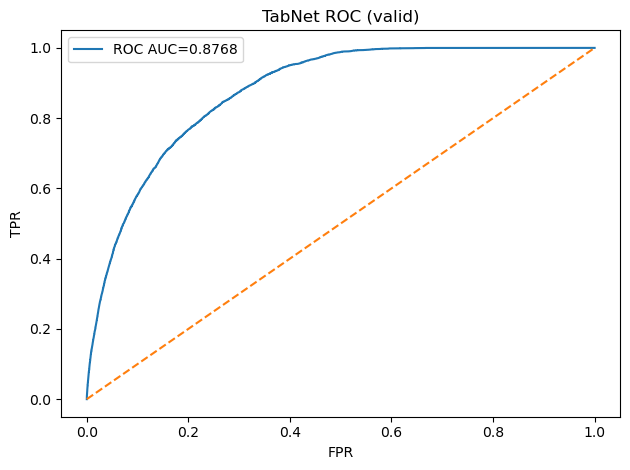

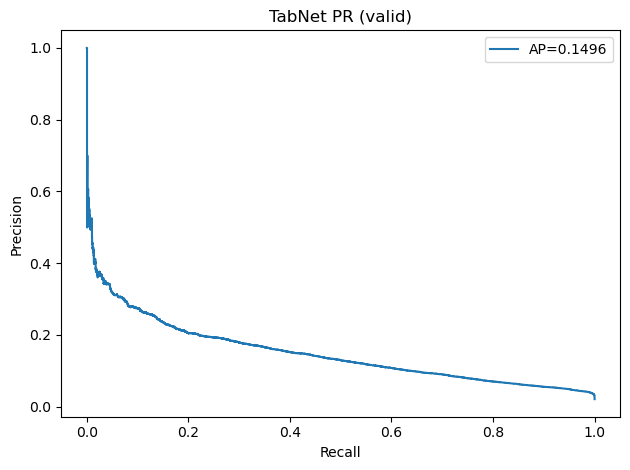

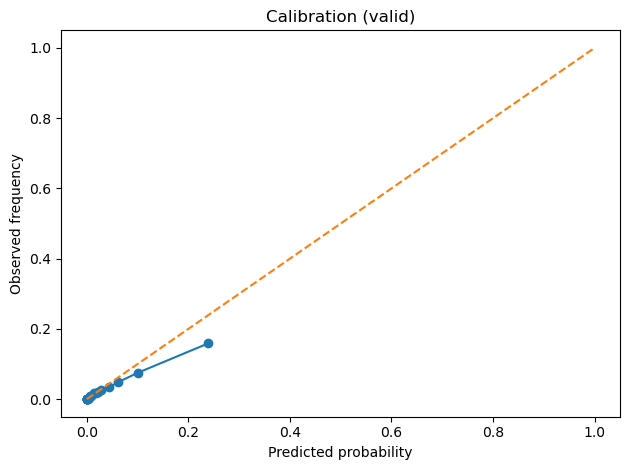

Saved ROC/PR/Calibration plots to: D:\ML\LS\final\final_project\artifacts\models\tabnet


In [13]:
p_valid = pd.read_csv(TABNET_DIR/"preds_valid.csv")["proba"].values
y_valid = pd.read_csv(TABNET_DIR/"preds_valid.csv")["y_true"].values

# ROC
fpr, tpr, _ = roc_curve(y_valid, p_valid)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("TabNet ROC (valid)")
plt.legend(); plt.tight_layout()
plt.savefig(TABNET_DIR/"roc_valid.png", dpi=150); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_valid, p_valid)
ap = average_precision_score(y_valid, p_valid)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("TabNet PR (valid)")
plt.legend(); plt.tight_layout()
plt.savefig(TABNET_DIR/"pr_valid.png", dpi=150); plt.show()

# Calibration
prob_true, prob_pred = calibration_curve(y_valid, p_valid, n_bins=20, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration (valid)")
plt.tight_layout()
plt.savefig(TABNET_DIR/"calibration_valid.png", dpi=150); plt.show()

print("Saved ROC/PR/Calibration plots to:", TABNET_DIR)

In [14]:
fi = pd.Series(tabnet.feature_importances_, index=list(X_train.columns), name="importance").sort_values(ascending=False)
fi.to_csv(TABNET_DIR/"feature_importances.csv", header=True)
print("Top-20 TabNet FI:\n", fi.head(20))

Top-20 TabNet FI:
 is_weekend            0.210098
unique_event_types    0.152947
visit_number          0.099523
n_brands              0.084808
is_perf               0.056882
utm_medium            0.029557
visit_hour            0.028517
is_paid               0.027737
geo_country           0.025040
is_push               0.024588
is_organic            0.022588
is_email              0.021739
visit_dow             0.020866
device_category       0.019630
any_car_detail        0.017884
car_brand             0.017007
has_model             0.016507
is_returning_user     0.015210
n_models              0.014989
traffic_group         0.014972
Name: importance, dtype: float64


## Результаты TabNet

Valid AUC ≈ 0.877, Test AUC ≈ 0.872 → уровень почти как у CatBoost/LGBM, но чуть слабее, чем у рукописного ансамбля.

Valid AP ≈ 0.150, Test AP ≈ 0.155 → по Precision–Recall TabNet даёт приличный результат, но всё же уступает ансамблю.

F1 (test @ valid-threshold ≈0.16) ≈ 0.22 → на уровне, но не выше лучших моделей.

### Калибровка: 
модель сильно недооценивает вероятности (кривая Calibration далеко ниже диагонали).

### Feature Importance (FI): 
топовые признаки совпадают с бустингами → is_weekend, unique_event_types, visit_number, n_brands, is_perf. Но веса распределены более резко (например, is_weekend >20%).

### Плюсы TabNet

Чисто нейросетевой подход → гибкость (можно в будущем дообучать, донастраивать).

Автоматически строит маски внимания, FI можно интерпретировать.

Логично ведёт себя по признакам (в топе — временные и поведенческие).

### Минусы

По метрикам (AUC, AP, F1) уступает ансамблю.

Тяжелее в обучении: GPU занято долго, время эпох заметное (≈ 50 мин на 50 эпох).

Калибровка хуже: вероятности смещены влево, придётся делать Platt/Isotonic.

### Сравнение с ансамблем

Рукописный ансамбль всё ещё остаётся лучшей моделью: он показал выше F1 и лучше калибруется.

TabNet скорее можно держать как baseline нейросети для полноты картины. Для продакшена брать его сейчас смысла мало: он тяжелее, менее калиброван и не даёт выигрыша в качестве.

### Вывод:

В качестве основной модели берём рукописный ансамбль (он лучший по F1 и калибровке).

TabNet используем как дополнительный baseline для отчёта, подчеркнув, что бустинг + ансамблизация всё ещё сильнее на табличных данных.

На этапе интерпретируемости (SHAP, PDP/ICE) разумно делать анализ именно ансамбля.

## Анализ интерпретирумости

### загрузка ансамбля и обёртка EnsemblePredictor

In [2]:
# === robust loader for calibrated models (skip broken pickles) ===

import json
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import shap
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

ROOT = Path(".").resolve()
ART_DIR   = ROOT / "artifacts"
SPLIT_DIR = ART_DIR / "split"
MODEL_DIR = ART_DIR / "models"
EVAL_DIR  = ART_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

CANDIDATES = {
    "CatBoost_calibrated_isotonic": [
        MODEL_DIR / "CatBoost_calibrated_isotonic.pkl",
        MODEL_DIR / "catboost_calibrated_isotonic.pkl",
        MODEL_DIR / "catboost_calibrated.pkl",
    ],
    "XGBoost_calibrated": [MODEL_DIR / "XGBoost_calibrated.pkl"],
    "LightGBM_calibrated": [MODEL_DIR / "LightGBM_calibrated.pkl"],
}

loaded_models = {}
failed = {}

for name, paths in CANDIDATES.items():
    path = next((p for p in paths if p.exists()), None)
    if path is None:
        failed[name] = "file not found"
        continue
    try:
        loaded_models[name] = joblib.load(path)
        print(f"[OK] loaded: {name} from {path.name}")
    except Exception as e:
        failed[name] = repr(e)
        print(f"[SKIP] {name} failed to load -> {e.__class__.__name__}: {e}")

assert len(loaded_models) >= 1, f"Не удалось загрузить ни одну модель: {failed}"

# веса бленда
weights_path = MODEL_DIR / "BlendCAL_weights.json"
if weights_path.exists():
    w_json = json.load(open(weights_path, "r", encoding="utf-8"))
    weights_full = w_json["weights"]
else:
    assert "w_dict" in globals(), "Нет BlendCAL_weights.json и переменной w_dict"
    weights_full = w_dict

# отфильтруем веса по реально загруженным моделям и нормируем
present = list(loaded_models.keys())
w_vec = np.array([weights_full[k] for k in present], dtype=float)
w_vec = w_vec / w_vec.sum()
weights = {k: float(w) for k, w in zip(present, w_vec)}
print("Using weights (renormalized):", weights)

class EnsemblePredictor(BaseEstimator, ClassifierMixin):
    def __init__(self, models: dict, weights: dict, order=None):
        self.models = models
        self.order = order or list(models.keys())
        self.w = np.array([weights[k] for k in self.order], dtype=float)
    def predict_proba(self, X):
        P = []
        for name in self.order:
            p = self.models[name].predict_proba(X)[:, 1]
            P.append(p)
        P = np.vstack(P)
        blend = (self.w[:, None] * P).sum(axis=0)
        return np.vstack([1.0 - blend, blend]).T
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:,1] >= threshold).astype(int)

ensemble = EnsemblePredictor(loaded_models, weights, order=present)
print("Ensemble ready. Loaded:", present, "| Skipped:", failed)

[OK] loaded: CatBoost_calibrated_isotonic from CatBoost_calibrated_isotonic.pkl
[SKIP] XGBoost_calibrated failed to load -> AttributeError: Can't get attribute 'BoosterSklearnWrapper' on <module '__main__'>
[SKIP] LightGBM_calibrated failed to load -> AttributeError: Can't get attribute 'LGBWrapper' on <module '__main__'>
Using weights (renormalized): {'CatBoost_calibrated_isotonic': 1.0}
Ensemble ready. Loaded: ['CatBoost_calibrated_isotonic'] | Skipped: {'XGBoost_calibrated': 'AttributeError("Can\'t get attribute \'BoosterSklearnWrapper\' on <module \'__main__\'>")', 'LightGBM_calibrated': 'AttributeError("Can\'t get attribute \'LGBWrapper\' on <module \'__main__\'>")'}


In [4]:
# Загружаем общий финальный фрейм
full_path = DATA_DIR / "sessions_features_final.parquet"
df_full = pd.read_parquet(full_path)
print("Full shape:", df_full.shape)

# Загружаем индексы
train_ids = pd.read_csv(SPLIT_DIR / "train_session_ids.csv")["session_id"].tolist()
valid_ids = pd.read_csv(SPLIT_DIR / "valid_session_ids.csv")["session_id"].tolist()
test_ids  = pd.read_csv(SPLIT_DIR / "test_session_ids.csv")["session_id"].tolist()

# Разделяем фреймы
X_train = df_full[df_full["session_id"].isin(train_ids)].copy()
X_valid = df_full[df_full["session_id"].isin(valid_ids)].copy()
X_test  = df_full[df_full["session_id"].isin(test_ids)].copy()

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

# (если целевая переменная уже внутри фрейма)
y_train = X_train["target"].values
y_valid = X_valid["target"].values
y_test  = X_test["target"].values

# Убираем target и идентификатор из признаков
X_train = X_train.drop(columns=["session_id", "target"])
X_valid = X_valid.drop(columns=["session_id", "target"])
X_test  = X_test.drop(columns=["session_id", "target"])

print("Features:", X_train.shape[1])

Full shape: (1860042, 30)
Train: (1151183, 30) Valid: (306562, 30) Test: (402297, 30)
Features: 28


## SHAP для доступных базовых моделей

[SHAP] CatBoost_calibrated_isotonic: (15000, 28) ok


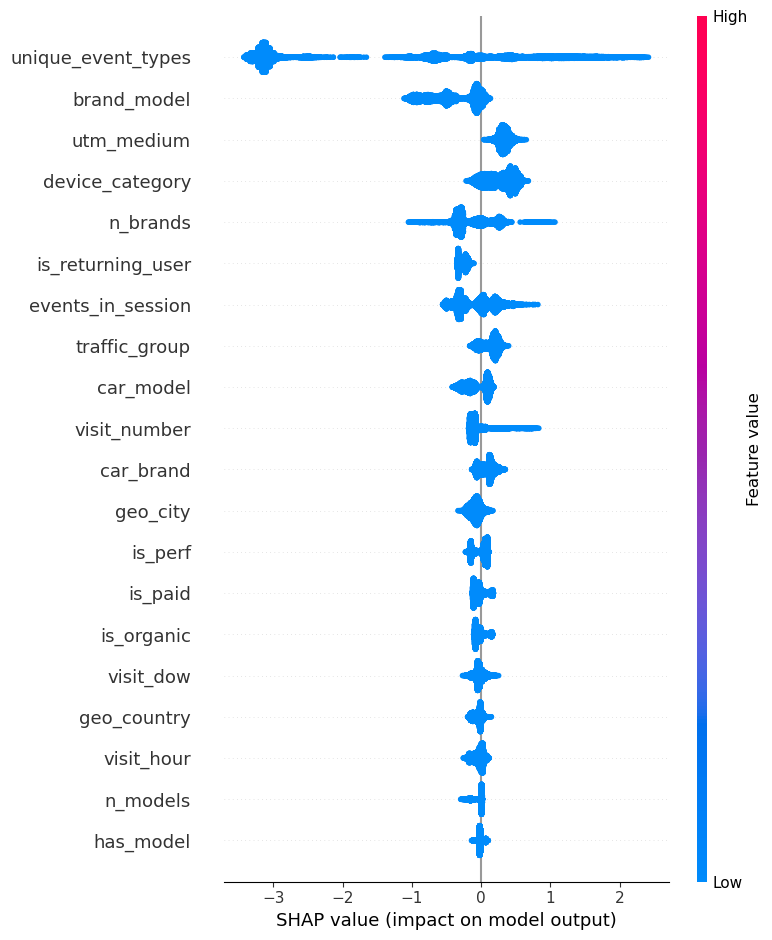

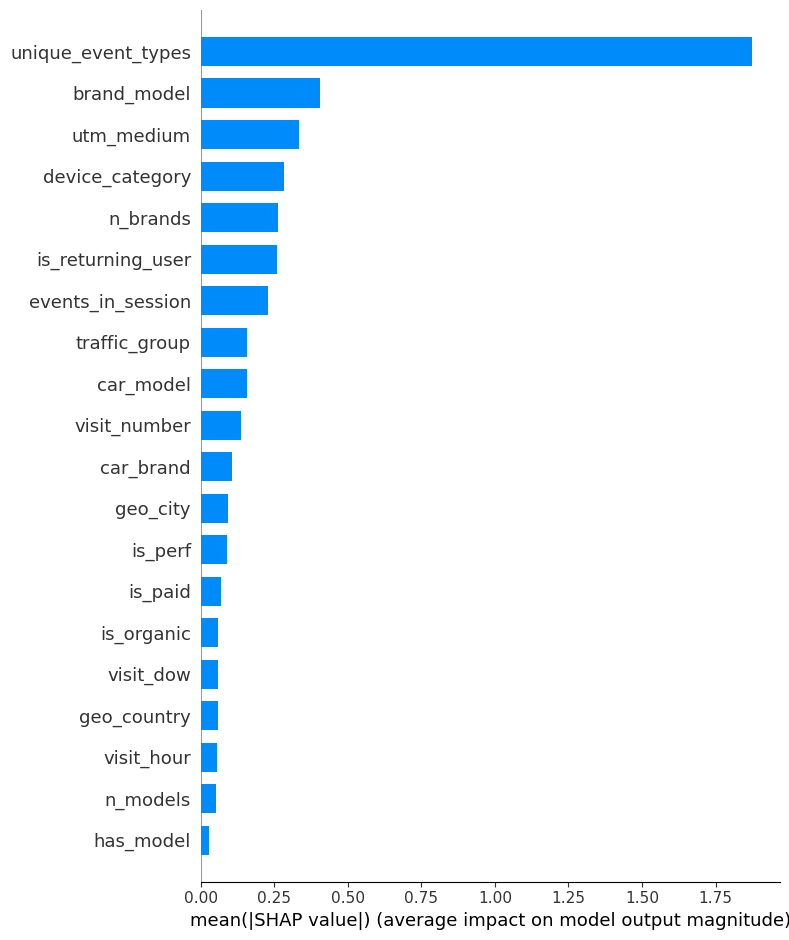

Saved SHAP to: D:\ML\LS\final\final_project\artifacts\eval
Models used: ['CatBoost_calibrated_isotonic']
Top-10 features by |SHAP|:
                feature  mean_abs_shap
12  unique_event_types       1.875100
27         brand_model       0.405589
20          utm_medium       0.332951
21     device_category       0.283440
13            n_brands       0.264345
19   is_returning_user       0.259569
11   events_in_session       0.227857
24       traffic_group       0.157709
26           car_model       0.157204
0         visit_number       0.138239


In [8]:
# ENSEMBLE SHAP (CatBoost-friendly: numeric+bool, align features, train-median impute)
def extract_tree_model(m):
    if isinstance(m, Pipeline):
        m = m.steps[-1][1]
    if isinstance(m, CalibratedClassifierCV):
        if hasattr(m, "calibrated_classifiers_") and m.calibrated_classifiers_:
            m = m.calibrated_classifiers_[0].base_estimator
        elif hasattr(m, "base_estimator"):
            m = m.base_estimator
    return m

def is_catboost(model):
    try:
        from catboost import CatBoostClassifier
        return isinstance(model, CatBoostClassifier)
    except Exception:
        return False

def is_lgbm(model):
    try:
        import lightgbm as lgb
        return isinstance(model, lgb.LGBMClassifier)
    except Exception:
        return False

def is_xgb(model):
    try:
        import xgboost as xgb
        return isinstance(model, xgb.XGBClassifier)
    except Exception:
        return False

assert "X_train" in globals() and "X_valid" in globals(), "Нужны X_train и X_valid в памяти."

# Оставляем числовые + булевы признаки, приводим bool -> uint8
def to_num_bool(df: pd.DataFrame) -> pd.DataFrame:
    Z = df.select_dtypes(include=[np.number, "bool"]).copy()
    bool_cols = Z.select_dtypes(include=["bool"]).columns
    if len(bool_cols):
        Z[bool_cols] = Z[bool_cols].astype("uint8")
    # Inf -> NaN
    Z = Z.replace([np.inf, -np.inf], np.nan)
    return Z

Xtr_nb = to_num_bool(X_train)
Xv_nb  = to_num_bool(X_valid)

# Импутация по train-медианам (без утечки)
med = Xtr_nb.median(numeric_only=True)
Xtr_nb = Xtr_nb.fillna(med)
Xv_nb  = Xv_nb.fillna(med)

# Готовим подвыборку с валидации для визуализаций
N_BG, N_S = 5000, 15000
rng = np.random.default_rng(42)
n_sample = min(N_S, Xv_nb.shape[0])
idx = rng.choice(np.arange(Xv_nb.shape[0]), size=n_sample, replace=False)

# Для каждой доступной модели выравниваем фрейм под ОЖИДАЕМЫЕ фичи модели
order = getattr(ensemble, "order", list(loaded_models.keys()))
parts = []   # (name, shap_values [n_sample, n_feat], expected_value)
names_used = []

for name in order:
    base = extract_tree_model(loaded_models[name])
    try:
        # Какие фичи ждёт модель:
        expected_cols = getattr(base, "feature_names_", None)
        if expected_cols is None:
            expected_cols = list(Xv_nb.columns)

        # Собираем выровненный фрейм под модель:
        Xv_aligned = Xv_nb.copy()
        # добавим недостающие колонки как 0
        missing = [c for c in expected_cols if c not in Xv_aligned.columns]
        if missing:
            for c in missing:
                Xv_aligned[c] = 0.0
        # отбросим лишнее и упорядочим
        Xv_aligned = Xv_aligned[expected_cols]

        # подвыборка
        X_sample = Xv_aligned.iloc[idx].copy()

        if is_catboost(base):
            from catboost import Pool
            pool_sample = Pool(X_sample, feature_names=list(X_sample.columns))
            shap_vals = base.get_feature_importance(pool_sample, type="ShapValues")  # (N, n_feat+1)
            expected = float(shap_vals[:, -1].mean())
            values   = np.asarray(shap_vals[:, :-1], dtype=float)

        elif is_lgbm(base) or is_xgb(base):
            # background для LGBM/XGB: считаем по тем же выровненным числовым данным
            k = min(N_BG, max(200, Xv_aligned.shape[0] // 50))
            X_bg = shap.kmeans(Xv_aligned, k)
            expl = shap.TreeExplainer(base, data=X_bg, model_output="probability")
            values = expl.shap_values(X_sample)
            if isinstance(values, list):
                values = values[1] if len(values) >= 2 else values[-1]
            values = np.asarray(values, dtype=float)
            expected = expl.expected_value
            expected = float(expected[1] if isinstance(expected, list) and len(expected) >= 2 else expected)

        else:
            print(f"[WARN] {name}: неизвестная модель для tree-SHAP — пропуск.")
            continue

        # Проверки формы
        assert values.shape == (X_sample.shape[0], X_sample.shape[1]), \
            f"{name}: SHAP shape mismatch: {values.shape} vs {X_sample.shape}"

        parts.append((name, values, expected, list(X_sample.columns)))
        names_used.append(name)
        print(f"[SHAP] {name}: {values.shape} ok")

    except Exception as e:
        print(f"[SKIP SHAP] {name}: {e}")

assert parts, "Не удалось посчитать SHAP ни для одной из загруженных моделей."

# Приводим все SHAP к единому набору признаков перед взвешиванием
# (на случай, если разные модели обучались на слегка разных наборах)
all_feats = parts[0][3]
for (_, _, _, cols) in parts[1:]:
    if cols != all_feats:
        raise AssertionError("Наборы признаков у моделей различаются — нужен единый порядок/список.")

feat_names = all_feats

# Взвешивание по ансамблевым весам (только по тем моделям, где SHAP посчитался)
W_raw = np.array([weights[n] for n in names_used], dtype=float)
W = W_raw / W_raw.sum()

vals_stack = np.stack([v for (_, v, _, _) in parts], axis=0)  # [n_models, n_sample, n_feat]
shap_ens = vals_stack[0] if vals_stack.shape[0] == 1 else np.tensordot(W, vals_stack, axes=(0, 0))

# Сохранение графиков и таблиц
os.makedirs(EVAL_DIR, exist_ok=True)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_ens, pd.DataFrame(0, index=range(shap_ens.shape[0]), columns=feat_names),  # данные не рисуем
                  feature_names=feat_names, show=False)
plt.tight_layout()
plt.savefig(EVAL_DIR / "ensemble_shap_summary_beeswarm.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_ens, pd.DataFrame(0, index=range(shap_ens.shape[0]), columns=feat_names),
                  feature_names=feat_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(EVAL_DIR / "ensemble_shap_summary_bar.png", dpi=150, bbox_inches="tight")
plt.show()

mean_abs = np.abs(shap_ens).mean(axis=0)
imp_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs}) \
            .sort_values("mean_abs_shap", ascending=False)

imp_df.to_csv(EVAL_DIR / "ensemble_shap_importances.csv", index=False)
np.save(EVAL_DIR / "ensemble_shap_values.npy", shap_ens)

print("Saved SHAP to:", EVAL_DIR)
print("Models used:", names_used)
print("Top-10 features by |SHAP|:\n", imp_df.head(10))

## Главные фичи по |SHAP| (CatBoost): 
unique_event_types » brand_model ≈ utm_medium ≈ device_category > n_brands > is_returning_user > events_in_session … — полностью резонирует с нашими EDA‑наблюдениями про «поведенческий блок» и сильные источники трафика.

## Короткие выводы:

Поведение в сессии (разнообразие и объём событий) — главный драйвер конверсии.

Маркетинг/канал и устройство дают сильную гетерогенность (имеет смысл держать сегменты/пороги по utm_medium × device_category).

Возвратность позитивна (логично: тёплая аудитория).

Авто‑мета (brand_model / car_model / car_brand) вносит вклад — сигнал о зрелости намерения.